In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import lightgbm as lgb
import numpy as np
import pandas as pd
import optuna
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# !pip install catboost

In [4]:
# !pip install optuna

In [13]:
# !pip install lightgbm

In [ ]:
# !pip install pycaret

In [8]:
train = pd.read_csv("./final_train.csv")

In [9]:
x = train.drop("matched_score",axis=1)
y = train["matched_score"]

In [10]:
def high_corelated(data):
    correlation_matrix = data.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )

    threshold = 0.8
    to_drop = [
        column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)
    ]

    # Drop highly correlated features
    data_reduced = data.drop(columns=to_drop)
    return data_reduced
x_reduced = high_corelated(x)

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(x_train)
test_scaled = scaler.transform(x_test)

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna

In [22]:
# Convert to DMatrix for XGBoost
# dtrain = xgb.DMatrix(train_scaled, label=y_train)
# dval = xgb.DMatrix(test_scaled, label=y_test)

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500)
    }

    # Train the model
    model = xgb.train(param, dtrain, evals=[(dval, "val")], early_stopping_rounds=50, verbose_eval=False)

    # Predict on the validation set
    y_val_pred = model.predict(dval)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_val_pred)
    return mse

# Create an Optuna study
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=1000)

# # Get the best parameters and best score
# best_params = study.best_params
# best_score = study.best_value

# print("Best Parameters:", best_params)
# print("Best MSE:", best_score)

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Define the hyperparameter search space
    param = {
        "iterations": trial.suggest_int("iterations", 500, 2000),  # Wider range for better exploration
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Log scale for finer granularity
        "depth": trial.suggest_int("depth", 6, 12),  # Focus on a realistic range for depth
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 50, log=True),  # Stronger regularization
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 20.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),  # Fine-tuned leaf size
        "grow_policy": trial.suggest_categorical("grow_policy", ["Depthwise", "Lossguide"]),
        "max_bin": trial.suggest_int("max_bin", 128, 512),  # Optimize numeric binning
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),  # Feature sampling
        "loss_function": "RMSE",
        "verbose": 0,
        "random_state": 42,
    }

    # Train the model with the current hyperparameters
    model = CatBoostRegressor(**param)
    model.fit(
        train_scaled,
        y_train,
        eval_set=(test_scaled, y_test),
        early_stopping_rounds=100,  # Allow more rounds to stabilize
        verbose=False
    )

    # Predict on the validation set
    y_val_pred = model.predict(test_scaled)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_val_pred)
    return mse

# Use an advanced pruner to stop unpromising trials
pruner = optuna.pruners.HyperbandPruner()

# Create an Optuna study with pruning
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner
)

# Optimize the study
study.optimize(objective, n_trials=300, n_jobs=-1, show_progress_bar=True)

# Get the best parameters and score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best MSE:", best_score)


[I 2024-12-28 04:39:42,741] A new study created in memory with name: no-name-f087d281-aa9c-4563-86e4-744f0c5843b8


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-28 04:40:09,416] Trial 1 finished with value: 0.010626722819307927 and parameters: {'iterations': 1033, 'learning_rate': 0.015573718675055328, 'depth': 7, 'l2_leaf_reg': 6.1460117363397275, 'bagging_temperature': 0.1244360909537523, 'random_strength': 8.397390690544464, 'min_data_in_leaf': 27, 'grow_policy': 'Depthwise', 'max_bin': 178, 'colsample_bylevel': 0.7491908408580145}. Best is trial 1 with value: 0.010626722819307927.
[I 2024-12-28 04:40:23,777] Trial 0 finished with value: 0.009013330637175469 and parameters: {'iterations': 1242, 'learning_rate': 0.04266472319023693, 'depth': 10, 'l2_leaf_reg': 5.400609978803352, 'bagging_temperature': 0.5849352436931083, 'random_strength': 19.95888989148185, 'min_data_in_leaf': 47, 'grow_policy': 'Depthwise', 'max_bin': 172, 'colsample_bylevel': 0.7477085110308609}. Best is trial 0 with value: 0.009013330637175469.
[I 2024-12-28 04:40:24,898] Trial 2 finished with value: 0.009144922381932779 and parameters: {'iterations': 686, 'le

In [ ]:
# Best Parameters: {'iterations': 477, 'learning_rate': 0.0992326660885819, 'depth': 9, 'l2_leaf_reg': 1.3636465913415061, 'bagging_temperature': 0.2509592895161558, 'random_strength': 0.23059308581429316}
# Best MSE: 0.008611292651485598

In [12]:
# print(train['matched_score'].value_counts())

matched_score
0.850000    1186
0.650000    1066
0.716667     413
0.683333     387
0.783333     357
            ... 
0.380000       1
0.223333       1
0.433333       1
0.796333       1
0.116667       1
Name: count, Length: 319, dtype: int64


In [39]:
def cat_boost():
    param= {'iterations': 477,

            'learning_rate': 0.0992326660885819, 'depth': 9, 'l2_leaf_reg': 1.3636465913415061, 'bagging_temperature': 0.2509592895161558, 'random_strength': 0.23059308581429316}
    model = CatBoostRegressor(**param)
    model.fit(train_scaled, y_train, eval_set=(test_scaled, y_test), early_stopping_rounds=50, verbose=False)

    # Predict on the validation set
    y_val_pred = model.predict(test_scaled)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_val_pred)
    return mse
print(cat_boost())
# 0.008741815217197125

0.008741815217197125


,Description,Value
0,Session id,123
1,Target,matched_score
2,Target type,Regression
3,Original data shape,"(7635, 237)"
4,Transformed data shape,"(7635, 237)"
5,Transformed train set shape,"(5344, 237)"
6,Transformed test set shape,"(2291, 237)"
7,Numeric features,236
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0732,0.0095,0.0974,0.6640,0.0624,0.1411,5.7630
lightgbm,Light Gradient Boosting Machine,0.0757,0.0101,0.1006,0.6414,0.0644,0.1465,0.8890
xgboost,Extreme Gradient Boosting,0.0772,0.0107,0.1031,0.6226,0.0659,0.1473,0.5470
rf,Random Forest Regressor,0.0806,0.0114,0.1067,0.5964,0.0682,0.1561,7.1970
et,Extra Trees Regressor,0.0828,0.0125,0.1114,0.5593,0.0712,0.1594,8.9800
gbr,Gradient Boosting Regressor,0.0920,0.0140,0.1183,0.5043,0.0756,0.1807,2.0250
knn,K Neighbors Regressor,0.0973,0.0169,0.1297,0.4041,0.0825,0.1906,0.1590
ridge,Ridge Regression,0.1032,0.0177,0.1329,0.3742,0.0842,0.1998,0.1920
br,Bayesian Ridge,0.1034,0.0177,0.1331,0.3726,0.0844,0.2013,0.2140
lr,Linear Regression,0.1033,0.0177,0.1330,0.3727,0.0843,0.1999,0.6990


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Best Model: <catboost.core.CatBoostRegressor object at 0x788b589d2d10>


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0809,0.0114,0.1070,0.6490,0.0694,0.1644
1,0.0792,0.0103,0.1016,0.6274,0.0647,0.1491
2,0.0730,0.0094,0.0971,0.6421,0.0617,0.1354
3,0.0735,0.0094,0.0970,0.6413,0.0616,0.1358
4,0.0723,0.0087,0.0935,0.6847,0.0592,0.1310
5,0.0714,0.0093,0.0962,0.6673,0.0618,0.1436
6,0.0744,0.0101,0.1006,0.6353,0.0642,0.1402
7,0.0756,0.0105,0.1025,0.6522,0.0667,0.1582
8,0.0726,0.0091,0.0952,0.6810,0.0607,0.1377


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


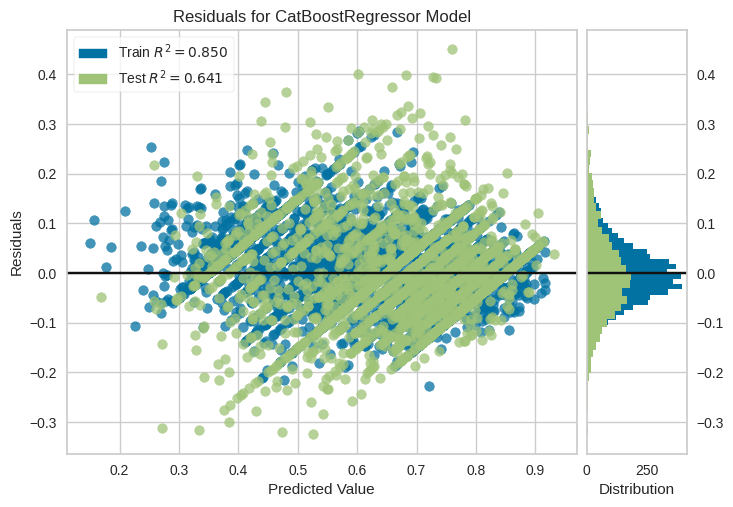

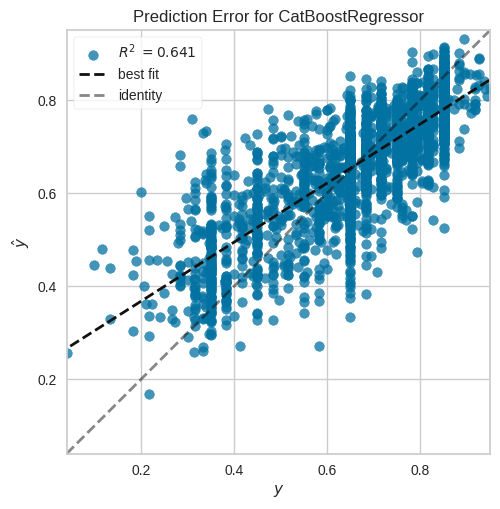

In [14]:
from pycaret.regression import *  # Import the regression module
import pandas as pd

# Load your dataset
train = pd.read_csv("./final_train.csv")

# Initialize PyCaret for regression
reg = setup(
    data=train,
    target='matched_score',  # Replace with your regression target variable
    session_id=123,          # For reproducibility
    normalize=True,          # Normalize features for better model performance
    verbose=True             # Display detailed logs
)

# Compare models and find the best one based on MSE
best_model = compare_models(sort='MSE')

print("Best Model:", best_model)

# Optional: Fine-tune the best model
tuned_model = tune_model(best_model, optimize='MSE')

# Evaluate the tuned model
plot_model(tuned_model, plot='residuals')  # Residuals plot to check performance
plot_model(tuned_model, plot='error')      # Prediction error plot

# Finalize the model for deployment
final_model = finalize_model(tuned_model)

# Save the final model
# save_model(final_model, 'best_regression_model_pycaret')

# Predict on new data (optional)
# predictions = predict_model(final_model, data=new_data)


In [17]:
# y_val_pred = final_model.predict(x_test)

# mse = mean_squared_error(y_test, y_val_pred)
# print(mse)

In [ ]:
def objective(trial):
    # Define hyperparameter search space
    params = {
       "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 10),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 10),
        "verbosity": -1,
        "seed": 42,
    }
    trn_data = lgb.Dataset(train_scaled, y_train)
    val_data = lgb.Dataset(test_scaled, y_test)
    # Train the model with the current hyperparameters
    model = lgb.train(params,
                trn_data,
                20000,
                valid_sets=[trn_data, val_data],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])
    # model.fit(
    #     train_scaled, y_train,
    #     eval_set=[(test_scaled, y_test)],
    #     eval_metric="rmse",
    #     # early_stopping_rounds=50,
    #     verbosity=1
    # )

    # Predict on the validation set
    y_val_pred = model.predict(test_scaled)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_val_pred)
    return mse

# Create an Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best MSE:", best_score)

[I 2024-12-27 18:09:06,123] A new study created in memory with name: no-name-9ef70956-92bd-4715-ba78-46b43bd2895f


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128732	valid_1's rmse: 0.130401
[100]	training's rmse: 0.116228	valid_1's rmse: 0.122237
[150]	training's rmse: 0.109888	valid_1's rmse: 0.118523
[200]	training's rmse: 0.105573	valid_1's rmse: 0.116121
[250]	training's rmse: 0.102408	valid_1's rmse: 0.114391
[300]	training's rmse: 0.0997119	valid_1's rmse: 0.11288
[350]	training's rmse: 0.0974644	valid_1's rmse: 0.111893
[400]	training's rmse: 0.0955072	valid_1's rmse: 0.110999
[450]	training's rmse: 0.0937059	valid_1's rmse: 0.110128
[500]	training's rmse: 0.0922723	valid_1's rmse: 0.109558
[550]	training's rmse: 0.0909254	valid_1's rmse: 0.108972
[600]	training's rmse: 0.0897321	valid_1's rmse: 0.108596
[650]	training's rmse: 0.0888316	valid_1's rmse: 0.108392
[700]	training's rmse: 0.0878525	valid_1's rmse: 0.10813
[750]	training's rmse: 0.0868987	valid_1's rmse: 0.107994
[800]	training's rmse: 0.0861137	valid_1's rmse: 0.107859
[850]	training's rm

[I 2024-12-27 18:09:08,706] Trial 0 finished with value: 0.011533257007884566 and parameters: {'learning_rate': 0.01999956094018796, 'num_leaves': 69, 'max_depth': 14, 'min_data_in_leaf': 35, 'feature_fraction': 0.6863690506569629, 'bagging_fraction': 0.8949337454659455, 'bagging_freq': 8, 'lambda_l1': 0.33736333654774747, 'lambda_l2': 1.7411674420276206}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122338	valid_1's rmse: 0.125001
[100]	training's rmse: 0.115717	valid_1's rmse: 0.120821
[150]	training's rmse: 0.112378	valid_1's rmse: 0.118643
[200]	training's rmse: 0.109611	valid_1's rmse: 0.116859
[250]	training's rmse: 0.107553	valid_1's rmse: 0.115688
[300]	training's rmse: 0.105995	valid_1's rmse: 0.115122
[350]	training's rmse: 0.104438	valid_1's rmse: 0.114099
[400]	training's rmse: 0.103381	valid_1's rmse: 0.113573
[450]	training's rmse: 0.102283	valid_1's rmse: 0.113285
[500]	training's rmse: 0.101291	valid_1's rmse: 0.112907
[550]	training's rmse: 0.100299	valid_1's rmse: 0.112371
[600]	training's rmse: 0.0995118	valid_1's rmse: 0.111967
[650]	training's rmse: 0.0989349	valid_1's rmse: 0.111951
[700]	training's rmse: 0.0982492	valid_1's rmse: 0.111762
[750]	training's rmse: 0.0975545	valid_1's rmse: 0.11156
[800]	training's rmse: 0.0970125	valid_1's rmse: 0.111331
[850]	training's rmse: 0

[I 2024-12-27 18:09:09,706] Trial 1 finished with value: 0.012310440196243895 and parameters: {'learning_rate': 0.07713103042477819, 'num_leaves': 134, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.7517660076475925, 'bagging_fraction': 0.7552550943751124, 'bagging_freq': 2, 'lambda_l1': 0.01643853814228407, 'lambda_l2': 0.01491982908315917}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0912258	valid_1's rmse: 0.109715
[100]	training's rmse: 0.0815733	valid_1's rmse: 0.107711
[150]	training's rmse: 0.0756027	valid_1's rmse: 0.107969
Early stopping, best iteration is:
[129]	training's rmse: 0.0775322	valid_1's rmse: 0.107489


[I 2024-12-27 18:09:10,251] Trial 2 finished with value: 0.011553792026723473 and parameters: {'learning_rate': 0.16267085171350318, 'num_leaves': 132, 'max_depth': 15, 'min_data_in_leaf': 42, 'feature_fraction': 0.9232099947211293, 'bagging_fraction': 0.9263168395779569, 'bagging_freq': 9, 'lambda_l1': 0.24547253016959344, 'lambda_l2': 0.012136824841214054}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129257	valid_1's rmse: 0.130258
[100]	training's rmse: 0.11844	valid_1's rmse: 0.122806
[150]	training's rmse: 0.113184	valid_1's rmse: 0.11944
[200]	training's rmse: 0.109901	valid_1's rmse: 0.117747
[250]	training's rmse: 0.107396	valid_1's rmse: 0.116397
[300]	training's rmse: 0.105251	valid_1's rmse: 0.115034
[350]	training's rmse: 0.103536	valid_1's rmse: 0.114134
[400]	training's rmse: 0.102157	valid_1's rmse: 0.113541
[450]	training's rmse: 0.100774	valid_1's rmse: 0.112745
[500]	training's rmse: 0.0997548	valid_1's rmse: 0.112307
[550]	training's rmse: 0.0986519	valid_1's rmse: 0.111791
[600]	training's rmse: 0.0978119	valid_1's rmse: 0.111477
[650]	training's rmse: 0.0969731	valid_1's rmse: 0.111091
[700]	training's rmse: 0.0960918	valid_1's rmse: 0.110824
[750]	training's rmse: 0.095348	valid_1's rmse: 0.110512
[800]	training's rmse: 0.0947334	valid_1's rmse: 0.11034
[850]	training's rmse: 0.

[I 2024-12-27 18:09:15,751] Trial 3 finished with value: 0.011867988158945091 and parameters: {'learning_rate': 0.02271700091076561, 'num_leaves': 89, 'max_depth': 10, 'min_data_in_leaf': 40, 'feature_fraction': 0.6246094795764657, 'bagging_fraction': 0.6923289734437537, 'bagging_freq': 3, 'lambda_l1': 0.5209647718088741, 'lambda_l2': 0.08852548811707545}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120078	valid_1's rmse: 0.125244
[100]	training's rmse: 0.112199	valid_1's rmse: 0.119272
[150]	training's rmse: 0.108774	valid_1's rmse: 0.117016
[200]	training's rmse: 0.105906	valid_1's rmse: 0.115404
[250]	training's rmse: 0.104265	valid_1's rmse: 0.114291
[300]	training's rmse: 0.102164	valid_1's rmse: 0.113681


[I 2024-12-27 18:09:16,114] Trial 4 finished with value: 0.012538995713418663 and parameters: {'learning_rate': 0.18027503668367964, 'num_leaves': 88, 'max_depth': 3, 'min_data_in_leaf': 13, 'feature_fraction': 0.8298962526141792, 'bagging_fraction': 0.6869203122972523, 'bagging_freq': 7, 'lambda_l1': 0.013641203728634569, 'lambda_l2': 0.0015715419194611488}. Best is trial 0 with value: 0.011533257007884566.


[350]	training's rmse: 0.100894	valid_1's rmse: 0.112744
[400]	training's rmse: 0.0993514	valid_1's rmse: 0.112173
[450]	training's rmse: 0.0981232	valid_1's rmse: 0.112166
Early stopping, best iteration is:
[409]	training's rmse: 0.0990905	valid_1's rmse: 0.111978
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122768	valid_1's rmse: 0.12579
[100]	training's rmse: 0.113679	valid_1's rmse: 0.120117
[150]	training's rmse: 0.109414	valid_1's rmse: 0.11767
[200]	training's rmse: 0.106585	valid_1's rmse: 0.116161
[250]	training's rmse: 0.10436	valid_1's rmse: 0.114858
[300]	training's rmse: 0.102269	valid_1's rmse: 0.113687
[350]	training's rmse: 0.100397	valid_1's rmse: 0.112481
[400]	training's rmse: 0.0985196	valid_1's rmse: 0.111537
[450]	training's rmse: 0.0970751	valid_1's rmse: 0.110817
[500]	training's rmse: 0.0958835	valid_1's rmse: 0.110468
[550]	training's rmse: 0.0946373	valid_1's rmse: 0.1098
[600]	training's rmse: 0.0936993	valid_1's rmse:

[I 2024-12-27 18:09:18,029] Trial 5 finished with value: 0.011676526585542432 and parameters: {'learning_rate': 0.031593928538430904, 'num_leaves': 33, 'max_depth': 8, 'min_data_in_leaf': 49, 'feature_fraction': 0.7999742241321782, 'bagging_fraction': 0.9522677980529926, 'bagging_freq': 8, 'lambda_l1': 0.026087036551636966, 'lambda_l2': 0.0027429502070042697}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113306	valid_1's rmse: 0.119736
[100]	training's rmse: 0.106713	valid_1's rmse: 0.115143
[150]	training's rmse: 0.103176	valid_1's rmse: 0.112868
[200]	training's rmse: 0.100999	valid_1's rmse: 0.111991
[250]	training's rmse: 0.0995164	valid_1's rmse: 0.111204
[300]	training's rmse: 0.0981863	valid_1's rmse: 0.111037
[350]	training's rmse: 0.0969671	valid_1's rmse: 0.11041
[400]	training's rmse: 0.0959461	valid_1's rmse: 0.110302
[450]	training's rmse: 0.0950152	valid_1's rmse: 0.110066
[500]	training's rmse: 0.0942223	valid_1's rmse: 0.109895
[550]	training's rmse: 0.0935474	valid_1's rmse: 0.109672
[600]	training's rmse: 0.0929184	valid_1's rmse: 0.109399


[I 2024-12-27 18:09:18,883] Trial 6 finished with value: 0.011900314373869339 and parameters: {'learning_rate': 0.1807310751809076, 'num_leaves': 139, 'max_depth': 5, 'min_data_in_leaf': 36, 'feature_fraction': 0.7461048103142534, 'bagging_fraction': 0.701507806345807, 'bagging_freq': 3, 'lambda_l1': 1.3573016374654165, 'lambda_l2': 0.14662671728856955}. Best is trial 0 with value: 0.011533257007884566.


[650]	training's rmse: 0.0923294	valid_1's rmse: 0.109166
Early stopping, best iteration is:
[644]	training's rmse: 0.0923908	valid_1's rmse: 0.109089
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.133569	valid_1's rmse: 0.133339
[100]	training's rmse: 0.125632	valid_1's rmse: 0.127578
[150]	training's rmse: 0.122083	valid_1's rmse: 0.125017
[200]	training's rmse: 0.119876	valid_1's rmse: 0.123652
[250]	training's rmse: 0.118272	valid_1's rmse: 0.122469
[300]	training's rmse: 0.116945	valid_1's rmse: 0.121561
[350]	training's rmse: 0.116082	valid_1's rmse: 0.120984
[400]	training's rmse: 0.11534	valid_1's rmse: 0.120524
[450]	training's rmse: 0.114808	valid_1's rmse: 0.120162
[500]	training's rmse: 0.114316	valid_1's rmse: 0.119774
[550]	training's rmse: 0.113904	valid_1's rmse: 0.119477
[600]	training's rmse: 0.11361	valid_1's rmse: 0.119247
[650]	training's rmse: 0.113336	valid_1's rmse: 0.119103
[700]	training's rmse: 0.113017	valid_1's rmse: 0.

[I 2024-12-27 18:09:20,987] Trial 7 finished with value: 0.01361571373407735 and parameters: {'learning_rate': 0.025969536136862776, 'num_leaves': 126, 'max_depth': 9, 'min_data_in_leaf': 44, 'feature_fraction': 0.7116517080479994, 'bagging_fraction': 0.7178780225205261, 'bagging_freq': 3, 'lambda_l1': 3.8337533097347576, 'lambda_l2': 0.0010577060240143936}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.100458	valid_1's rmse: 0.11489
[100]	training's rmse: 0.0902342	valid_1's rmse: 0.110238


[I 2024-12-27 18:09:21,433] Trial 8 finished with value: 0.011964790905329167 and parameters: {'learning_rate': 0.1253665936691536, 'num_leaves': 110, 'max_depth': 12, 'min_data_in_leaf': 42, 'feature_fraction': 0.9486526987582098, 'bagging_fraction': 0.7420123881421113, 'bagging_freq': 10, 'lambda_l1': 0.02113134476213854, 'lambda_l2': 0.7388705020533045}. Best is trial 0 with value: 0.011533257007884566.


[150]	training's rmse: 0.0848333	valid_1's rmse: 0.110109
Early stopping, best iteration is:
[137]	training's rmse: 0.0859173	valid_1's rmse: 0.109384
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11514	valid_1's rmse: 0.121211
[100]	training's rmse: 0.104858	valid_1's rmse: 0.115267
[150]	training's rmse: 0.0991392	valid_1's rmse: 0.112449
[200]	training's rmse: 0.0951368	valid_1's rmse: 0.110984
[250]	training's rmse: 0.0924262	valid_1's rmse: 0.110083
[300]	training's rmse: 0.0899968	valid_1's rmse: 0.109096
[350]	training's rmse: 0.0878912	valid_1's rmse: 0.108598
[400]	training's rmse: 0.0862926	valid_1's rmse: 0.108428
[450]	training's rmse: 0.0846979	valid_1's rmse: 0.108312
[500]	training's rmse: 0.0834499	valid_1's rmse: 0.108324
[550]	training's rmse: 0.0822863	valid_1's rmse: 0.108201
Early stopping, best iteration is:
[548]	training's rmse: 0.082327	valid_1's rmse: 0.108161


[I 2024-12-27 18:09:22,938] Trial 9 finished with value: 0.011698785623568755 and parameters: {'learning_rate': 0.04618099654776816, 'num_leaves': 122, 'max_depth': 15, 'min_data_in_leaf': 45, 'feature_fraction': 0.6799977651357171, 'bagging_fraction': 0.796663040758243, 'bagging_freq': 3, 'lambda_l1': 0.22309578423877668, 'lambda_l2': 0.05653013132288028}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.138444	valid_1's rmse: 0.137606
[100]	training's rmse: 0.125339	valid_1's rmse: 0.127907
[150]	training's rmse: 0.118516	valid_1's rmse: 0.123348
[200]	training's rmse: 0.113784	valid_1's rmse: 0.12037
[250]	training's rmse: 0.110387	valid_1's rmse: 0.11845
[300]	training's rmse: 0.107368	valid_1's rmse: 0.116676
[350]	training's rmse: 0.104987	valid_1's rmse: 0.11536
[400]	training's rmse: 0.103028	valid_1's rmse: 0.114299
[450]	training's rmse: 0.101257	valid_1's rmse: 0.113399
[500]	training's rmse: 0.0998507	valid_1's rmse: 0.112712
[550]	training's rmse: 0.0984902	valid_1's rmse: 0.112032
[600]	training's rmse: 0.0971612	valid_1's rmse: 0.111298
[650]	training's rmse: 0.0960013	valid_1's rmse: 0.110776
[700]	training's rmse: 0.094984	valid_1's rmse: 0.110379
[750]	training's rmse: 0.0940064	valid_1's rmse: 0.110029
[800]	training's rmse: 0.0931086	valid_1's rmse: 0.109654
[850]	training's rmse: 0.

[I 2024-12-27 18:09:28,770] Trial 10 finished with value: 0.011620568850205546 and parameters: {'learning_rate': 0.012656498383458224, 'num_leaves': 42, 'max_depth': 12, 'min_data_in_leaf': 24, 'feature_fraction': 0.8665490616841991, 'bagging_fraction': 0.8778557036617756, 'bagging_freq': 6, 'lambda_l1': 0.0010569516537889607, 'lambda_l2': 9.296974837458698}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.1406	valid_1's rmse: 0.139649
[100]	training's rmse: 0.127034	valid_1's rmse: 0.129927
[150]	training's rmse: 0.119661	valid_1's rmse: 0.12519
[200]	training's rmse: 0.114928	valid_1's rmse: 0.12243
[250]	training's rmse: 0.11109	valid_1's rmse: 0.12039
[300]	training's rmse: 0.107766	valid_1's rmse: 0.118448
[350]	training's rmse: 0.104803	valid_1's rmse: 0.116479
[400]	training's rmse: 0.10211	valid_1's rmse: 0.114846
[450]	training's rmse: 0.100167	valid_1's rmse: 0.113779
[500]	training's rmse: 0.0985726	valid_1's rmse: 0.112956
[550]	training's rmse: 0.097157	valid_1's rmse: 0.112198
[600]	training's rmse: 0.0958514	valid_1's rmse: 0.11148
[650]	training's rmse: 0.0945897	valid_1's rmse: 0.110882
[700]	training's rmse: 0.0931942	valid_1's rmse: 0.110105
[750]	training's rmse: 0.0920959	valid_1's rmse: 0.109629
[800]	training's rmse: 0.0910754	valid_1's rmse: 0.10928
[850]	training's rmse: 0.090192

[I 2024-12-27 18:09:32,869] Trial 11 finished with value: 0.011594774693384345 and parameters: {'learning_rate': 0.010172322045364364, 'num_leaves': 60, 'max_depth': 15, 'min_data_in_leaf': 30, 'feature_fraction': 0.9827094739047572, 'bagging_fraction': 0.9979893442838906, 'bagging_freq': 10, 'lambda_l1': 0.11109943280560264, 'lambda_l2': 3.963358925394664}. Best is trial 0 with value: 0.011533257007884566.
[I 2024-12-27 18:09:33,106] Trial 12 finished with value: 0.015879726690968644 and parameters: {'learning_rate': 0.07322996320908268, 'num_leaves': 64, 'max_depth': 13, 'min_data_in_leaf': 31, 'feature_fraction': 0.9094628530229351, 'bagging_fraction': 0.8851726830285501, 'bagging_freq': 8, 'lambda_l1': 9.362934607870303, 'lambda_l2': 0.012833233148826293}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126662	valid_1's rmse: 0.129072
[100]	training's rmse: 0.123302	valid_1's rmse: 0.126479
[150]	training's rmse: 0.122592	valid_1's rmse: 0.126015
Early stopping, best iteration is:
[127]	training's rmse: 0.122592	valid_1's rmse: 0.126015
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.133309	valid_1's rmse: 0.133568
[100]	training's rmse: 0.120707	valid_1's rmse: 0.12475
[150]	training's rmse: 0.114458	valid_1's rmse: 0.120711
[200]	training's rmse: 0.110289	valid_1's rmse: 0.11833
[250]	training's rmse: 0.107415	valid_1's rmse: 0.116785
[300]	training's rmse: 0.10471	valid_1's rmse: 0.115054
[350]	training's rmse: 0.102676	valid_1's rmse: 0.113873
[400]	training's rmse: 0.100902	valid_1's rmse: 0.112863
[450]	training's rmse: 0.0994063	valid_1's rmse: 0.112163
[500]	training's rmse: 0.098177	valid_1's rmse: 0.111574
[550]	training's rmse: 0.0969014	valid_1's rmse: 

[I 2024-12-27 18:09:36,489] Trial 13 finished with value: 0.011610321830112442 and parameters: {'learning_rate': 0.01709128312453355, 'num_leaves': 103, 'max_depth': 14, 'min_data_in_leaf': 35, 'feature_fraction': 0.6015493826655686, 'bagging_fraction': 0.8846013139608018, 'bagging_freq': 9, 'lambda_l1': 0.6257574643363427, 'lambda_l2': 0.6095623107323184}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.114046	valid_1's rmse: 0.121882
[100]	training's rmse: 0.102916	valid_1's rmse: 0.11569
[150]	training's rmse: 0.0968096	valid_1's rmse: 0.112903
[200]	training's rmse: 0.0924215	valid_1's rmse: 0.11132
[250]	training's rmse: 0.0894756	valid_1's rmse: 0.110475
[300]	training's rmse: 0.0870481	valid_1's rmse: 0.110392
[350]	training's rmse: 0.0847077	valid_1's rmse: 0.11001
[400]	training's rmse: 0.0826898	valid_1's rmse: 0.109622
[450]	training's rmse: 0.0807432	valid_1's rmse: 0.109635
Early stopping, best iteration is:
[415]	training's rmse: 0.0820216	valid_1's rmse: 0.109404


[I 2024-12-27 18:09:37,627] Trial 14 finished with value: 0.0119693199320496 and parameters: {'learning_rate': 0.0412916149962681, 'num_leaves': 64, 'max_depth': 11, 'min_data_in_leaf': 23, 'feature_fraction': 0.8629172723218008, 'bagging_fraction': 0.6236227448505043, 'bagging_freq': 5, 'lambda_l1': 0.0704777479747043, 'lambda_l2': 1.119815400905209}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117576	valid_1's rmse: 0.122098
[100]	training's rmse: 0.110982	valid_1's rmse: 0.117822
[150]	training's rmse: 0.107796	valid_1's rmse: 0.11568
[200]	training's rmse: 0.105716	valid_1's rmse: 0.114305
[250]	training's rmse: 0.104654	valid_1's rmse: 0.113686
[300]	training's rmse: 0.103583	valid_1's rmse: 0.112987
[350]	training's rmse: 0.103053	valid_1's rmse: 0.112718
[400]	training's rmse: 0.102504	valid_1's rmse: 0.112468
[450]	training's rmse: 0.102265	valid_1's rmse: 0.112303
Early stopping, best iteration is:
[442]	training's rmse: 0.102265	valid_1's rmse: 0.112303


[I 2024-12-27 18:09:41,078] Trial 15 finished with value: 0.012611986657706988 and parameters: {'learning_rate': 0.07334856195088124, 'num_leaves': 149, 'max_depth': 7, 'min_data_in_leaf': 37, 'feature_fraction': 0.6743454067401722, 'bagging_fraction': 0.9271801465201266, 'bagging_freq': 6, 'lambda_l1': 2.1206968633467933, 'lambda_l2': 0.00929303279505877}. Best is trial 0 with value: 0.011533257007884566.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0958209	valid_1's rmse: 0.113717


[I 2024-12-27 18:09:41,562] Trial 16 finished with value: 0.012237446475473472 and parameters: {'learning_rate': 0.11101533263536166, 'num_leaves': 78, 'max_depth': 13, 'min_data_in_leaf': 28, 'feature_fraction': 0.9936631617405205, 'bagging_fraction': 0.8352986770973468, 'bagging_freq': 8, 'lambda_l1': 0.0038476651586834307, 'lambda_l2': 0.2406067360252187}. Best is trial 0 with value: 0.011533257007884566.


[100]	training's rmse: 0.0849913	valid_1's rmse: 0.111126
[150]	training's rmse: 0.0782184	valid_1's rmse: 0.110947
Early stopping, best iteration is:
[112]	training's rmse: 0.0829362	valid_1's rmse: 0.110623
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.103915	valid_1's rmse: 0.117445
[100]	training's rmse: 0.0898808	valid_1's rmse: 0.110187
[150]	training's rmse: 0.0821434	valid_1's rmse: 0.106892
[200]	training's rmse: 0.0768709	valid_1's rmse: 0.105706
[250]	training's rmse: 0.0734416	valid_1's rmse: 0.105081
[300]	training's rmse: 0.0705242	valid_1's rmse: 0.104642
[350]	training's rmse: 0.0682273	valid_1's rmse: 0.104361
[400]	training's rmse: 0.0663626	valid_1's rmse: 0.104454
Early stopping, best iteration is:
[355]	training's rmse: 0.0680381	valid_1's rmse: 0.104342


[I 2024-12-27 18:09:42,977] Trial 17 finished with value: 0.010887212729640428 and parameters: {'learning_rate': 0.048770452504837886, 'num_leaves': 103, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7821414487431875, 'bagging_fraction': 0.998046075586939, 'bagging_freq': 9, 'lambda_l1': 0.24931768374599894, 'lambda_l2': 0.022738553225387613}. Best is trial 17 with value: 0.010887212729640428.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.103947	valid_1's rmse: 0.118211
[100]	training's rmse: 0.0910329	valid_1's rmse: 0.112352
[150]	training's rmse: 0.083155	valid_1's rmse: 0.109406
[200]	training's rmse: 0.0778113	valid_1's rmse: 0.108342
[250]	training's rmse: 0.0742082	valid_1's rmse: 0.108069
[300]	training's rmse: 0.0711886	valid_1's rmse: 0.108271
Early stopping, best iteration is:
[275]	training's rmse: 0.0725136	valid_1's rmse: 0.108026


[I 2024-12-27 18:09:44,101] Trial 18 finished with value: 0.011669604238079077 and parameters: {'learning_rate': 0.049314779012359415, 'num_leaves': 104, 'max_depth': 13, 'min_data_in_leaf': 18, 'feature_fraction': 0.7852231610919572, 'bagging_fraction': 0.9946101716355547, 'bagging_freq': 7, 'lambda_l1': 0.07621189238268057, 'lambda_l2': 0.03717002265852307}. Best is trial 17 with value: 0.010887212729640428.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128924	valid_1's rmse: 0.130408
[100]	training's rmse: 0.116544	valid_1's rmse: 0.12211
[150]	training's rmse: 0.110124	valid_1's rmse: 0.118086
[200]	training's rmse: 0.105724	valid_1's rmse: 0.115442
[250]	training's rmse: 0.1027	valid_1's rmse: 0.11356
[300]	training's rmse: 0.0999269	valid_1's rmse: 0.111719
[350]	training's rmse: 0.0977122	valid_1's rmse: 0.110445
[400]	training's rmse: 0.0958129	valid_1's rmse: 0.109475
[450]	training's rmse: 0.0941669	valid_1's rmse: 0.10872
[500]	training's rmse: 0.0928198	valid_1's rmse: 0.108136
[550]	training's rmse: 0.0916303	valid_1's rmse: 0.107686
[600]	training's rmse: 0.090541	valid_1's rmse: 0.10737
[650]	training's rmse: 0.0896278	valid_1's rmse: 0.106987
[700]	training's rmse: 0.0886684	valid_1's rmse: 0.106699
[750]	training's rmse: 0.0877816	valid_1's rmse: 0.106409
[800]	training's rmse: 0.0870135	valid_1's rmse: 0.106114
[850]	training's rmse: 0

[I 2024-12-27 18:09:48,489] Trial 19 finished with value: 0.010863846513614044 and parameters: {'learning_rate': 0.020616188750982044, 'num_leaves': 48, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.6863644619403537, 'bagging_fraction': 0.9632493233915932, 'bagging_freq': 5, 'lambda_l1': 0.5801666022196352, 'lambda_l2': 2.1398401697422846}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128791	valid_1's rmse: 0.129516
[100]	training's rmse: 0.120247	valid_1's rmse: 0.123708
[150]	training's rmse: 0.115884	valid_1's rmse: 0.120881
[200]	training's rmse: 0.112951	valid_1's rmse: 0.118898
[250]	training's rmse: 0.110662	valid_1's rmse: 0.117287
[300]	training's rmse: 0.108732	valid_1's rmse: 0.115849
[350]	training's rmse: 0.107153	valid_1's rmse: 0.114855
[400]	training's rmse: 0.10581	valid_1's rmse: 0.113853
[450]	training's rmse: 0.104732	valid_1's rmse: 0.113259
[500]	training's rmse: 0.10381	valid_1's rmse: 0.11282
[550]	training's rmse: 0.102983	valid_1's rmse: 0.112251
[600]	training's rmse: 0.102262	valid_1's rmse: 0.111824
[650]	training's rmse: 0.101724	valid_1's rmse: 0.111439
[700]	training's rmse: 0.101174	valid_1's rmse: 0.111091
[750]	training's rmse: 0.100643	valid_1's rmse: 0.110772
[800]	training's rmse: 0.100207	valid_1's rmse: 0.110556
[850]	training's rmse: 0.099807

[I 2024-12-27 18:09:53,681] Trial 20 finished with value: 0.01150269432729574 and parameters: {'learning_rate': 0.030792340998168254, 'num_leaves': 22, 'max_depth': 6, 'min_data_in_leaf': 12, 'feature_fraction': 0.7442565127416105, 'bagging_fraction': 0.965123323063796, 'bagging_freq': 5, 'lambda_l1': 1.4452307615820381, 'lambda_l2': 9.60769117316076}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127151	valid_1's rmse: 0.128406
[100]	training's rmse: 0.118778	valid_1's rmse: 0.122713
[150]	training's rmse: 0.114501	valid_1's rmse: 0.119982
[200]	training's rmse: 0.111686	valid_1's rmse: 0.118109
[250]	training's rmse: 0.109658	valid_1's rmse: 0.116873
[300]	training's rmse: 0.107965	valid_1's rmse: 0.115627
[350]	training's rmse: 0.106471	valid_1's rmse: 0.114491
[400]	training's rmse: 0.105296	valid_1's rmse: 0.113701
[450]	training's rmse: 0.104381	valid_1's rmse: 0.113207
[500]	training's rmse: 0.103648	valid_1's rmse: 0.112767
[550]	training's rmse: 0.102924	valid_1's rmse: 0.112237
[600]	training's rmse: 0.102343	valid_1's rmse: 0.111828
[650]	training's rmse: 0.102048	valid_1's rmse: 0.111636
[700]	training's rmse: 0.101677	valid_1's rmse: 0.111446
[750]	training's rmse: 0.10131	valid_1's rmse: 0.111175
[800]	training's rmse: 0.101011	valid_1's rmse: 0.110949
[850]	training's rmse: 0.1007

[I 2024-12-27 18:09:55,783] Trial 21 finished with value: 0.01208985840630072 and parameters: {'learning_rate': 0.033656698488439066, 'num_leaves': 22, 'max_depth': 7, 'min_data_in_leaf': 10, 'feature_fraction': 0.7525380389351757, 'bagging_fraction': 0.9607262842830208, 'bagging_freq': 5, 'lambda_l1': 1.807606218681822, 'lambda_l2': 7.22841020506949}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.139303	valid_1's rmse: 0.13775
[100]	training's rmse: 0.128601	valid_1's rmse: 0.129588
[150]	training's rmse: 0.123313	valid_1's rmse: 0.125944
[200]	training's rmse: 0.120191	valid_1's rmse: 0.124077
[250]	training's rmse: 0.11805	valid_1's rmse: 0.122609
[300]	training's rmse: 0.116062	valid_1's rmse: 0.121202
[350]	training's rmse: 0.114345	valid_1's rmse: 0.12
[400]	training's rmse: 0.112692	valid_1's rmse: 0.118864
[450]	training's rmse: 0.111422	valid_1's rmse: 0.117952
[500]	training's rmse: 0.110117	valid_1's rmse: 0.117053
[550]	training's rmse: 0.109103	valid_1's rmse: 0.116351
[600]	training's rmse: 0.108111	valid_1's rmse: 0.115681
[650]	training's rmse: 0.107374	valid_1's rmse: 0.115258
[700]	training's rmse: 0.106498	valid_1's rmse: 0.1147
[750]	training's rmse: 0.10575	valid_1's rmse: 0.114284
[800]	training's rmse: 0.105053	valid_1's rmse: 0.113946
[850]	training's rmse: 0.104333	valid

[I 2024-12-27 18:10:02,268] Trial 22 finished with value: 0.011303472554197759 and parameters: {'learning_rate': 0.017517520464988445, 'num_leaves': 43, 'max_depth': 5, 'min_data_in_leaf': 16, 'feature_fraction': 0.718961858878174, 'bagging_fraction': 0.966007574421039, 'bagging_freq': 4, 'lambda_l1': 0.9971382108076174, 'lambda_l2': 3.0132530209362733}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.135079	valid_1's rmse: 0.134908
[100]	training's rmse: 0.122624	valid_1's rmse: 0.126004
[150]	training's rmse: 0.116346	valid_1's rmse: 0.121761
[200]	training's rmse: 0.112429	valid_1's rmse: 0.119524
[250]	training's rmse: 0.109497	valid_1's rmse: 0.11786
[300]	training's rmse: 0.106968	valid_1's rmse: 0.116379
[350]	training's rmse: 0.10489	valid_1's rmse: 0.115148
[400]	training's rmse: 0.103074	valid_1's rmse: 0.114139
[450]	training's rmse: 0.101408	valid_1's rmse: 0.113088
[500]	training's rmse: 0.100151	valid_1's rmse: 0.112463
[550]	training's rmse: 0.0990154	valid_1's rmse: 0.111778
[600]	training's rmse: 0.0980034	valid_1's rmse: 0.111307
[650]	training's rmse: 0.0971356	valid_1's rmse: 0.110844
[700]	training's rmse: 0.0962257	valid_1's rmse: 0.110377
[750]	training's rmse: 0.0954102	valid_1's rmse: 0.109916
[800]	training's rmse: 0.0947609	valid_1's rmse: 0.109659
[850]	training's rmse: 0

[I 2024-12-27 18:10:11,061] Trial 23 finished with value: 0.011264294568664441 and parameters: {'learning_rate': 0.0158752884461344, 'num_leaves': 49, 'max_depth': 10, 'min_data_in_leaf': 16, 'feature_fraction': 0.6417215689670158, 'bagging_fraction': 0.8352894107394888, 'bagging_freq': 4, 'lambda_l1': 0.8231554723187169, 'lambda_l2': 2.6469445712571567}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.144267	valid_1's rmse: 0.141815
[100]	training's rmse: 0.133425	valid_1's rmse: 0.133245
[150]	training's rmse: 0.128022	valid_1's rmse: 0.129246
[200]	training's rmse: 0.124913	valid_1's rmse: 0.127111
[250]	training's rmse: 0.122924	valid_1's rmse: 0.125683
[300]	training's rmse: 0.121228	valid_1's rmse: 0.124471
[350]	training's rmse: 0.120054	valid_1's rmse: 0.123752
[400]	training's rmse: 0.118962	valid_1's rmse: 0.122989
[450]	training's rmse: 0.118028	valid_1's rmse: 0.122341
[500]	training's rmse: 0.117287	valid_1's rmse: 0.121865
[550]	training's rmse: 0.116563	valid_1's rmse: 0.121341
[600]	training's rmse: 0.116123	valid_1's rmse: 0.121018
[650]	training's rmse: 0.115715	valid_1's rmse: 0.120783
[700]	training's rmse: 0.115266	valid_1's rmse: 0.120475
[750]	training's rmse: 0.114973	valid_1's rmse: 0.120275
[800]	training's rmse: 0.11473	valid_1's rmse: 0.120113
[850]	training's rmse: 0.1145

[I 2024-12-27 18:10:14,997] Trial 24 finished with value: 0.013622299685458273 and parameters: {'learning_rate': 0.012897533596300801, 'num_leaves': 47, 'max_depth': 10, 'min_data_in_leaf': 18, 'feature_fraction': 0.6377929803463922, 'bagging_fraction': 0.8217376030253957, 'bagging_freq': 1, 'lambda_l1': 4.200997611937207, 'lambda_l2': 0.43499957700997527}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.110973	valid_1's rmse: 0.119058
[100]	training's rmse: 0.100292	valid_1's rmse: 0.112959
[150]	training's rmse: 0.0943225	valid_1's rmse: 0.11026
[200]	training's rmse: 0.0897237	valid_1's rmse: 0.10858
[250]	training's rmse: 0.0866447	valid_1's rmse: 0.108098
[300]	training's rmse: 0.0838598	valid_1's rmse: 0.10724
[350]	training's rmse: 0.0814778	valid_1's rmse: 0.106814
[400]	training's rmse: 0.0792387	valid_1's rmse: 0.10642
[450]	training's rmse: 0.0772844	valid_1's rmse: 0.106076
[500]	training's rmse: 0.0755737	valid_1's rmse: 0.106054
Early stopping, best iteration is:
[476]	training's rmse: 0.0763134	valid_1's rmse: 0.10589


[I 2024-12-27 18:10:16,181] Trial 25 finished with value: 0.011212776763747833 and parameters: {'learning_rate': 0.05495138131327708, 'num_leaves': 50, 'max_depth': 9, 'min_data_in_leaf': 14, 'feature_fraction': 0.6576451343336933, 'bagging_fraction': 0.8472671808291171, 'bagging_freq': 4, 'lambda_l1': 0.12658507026614682, 'lambda_l2': 2.044214645762818}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.108019	valid_1's rmse: 0.11811
[100]	training's rmse: 0.0988026	valid_1's rmse: 0.113881
[150]	training's rmse: 0.0925887	valid_1's rmse: 0.110844
[200]	training's rmse: 0.0883224	valid_1's rmse: 0.109745
[250]	training's rmse: 0.0849716	valid_1's rmse: 0.109128
[300]	training's rmse: 0.0821175	valid_1's rmse: 0.108608
[350]	training's rmse: 0.0798689	valid_1's rmse: 0.108309
[400]	training's rmse: 0.0777173	valid_1's rmse: 0.108283
[450]	training's rmse: 0.0756731	valid_1's rmse: 0.108042
[500]	training's rmse: 0.0739422	valid_1's rmse: 0.108033
Early stopping, best iteration is:
[477]	training's rmse: 0.0746396	valid_1's rmse: 0.107931


[I 2024-12-27 18:10:17,678] Trial 26 finished with value: 0.011649183997495224 and parameters: {'learning_rate': 0.05518561031393241, 'num_leaves': 77, 'max_depth': 9, 'min_data_in_leaf': 22, 'feature_fraction': 0.7063753966074612, 'bagging_fraction': 0.9096649203807208, 'bagging_freq': 4, 'lambda_l1': 0.12853132505409487, 'lambda_l2': 0.34870937997941664}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0984679	valid_1's rmse: 0.115745
[100]	training's rmse: 0.0841123	valid_1's rmse: 0.109102
[150]	training's rmse: 0.0759907	valid_1's rmse: 0.107382
[200]	training's rmse: 0.0703101	valid_1's rmse: 0.106801


[I 2024-12-27 18:10:21,168] Trial 27 finished with value: 0.011357583093223189 and parameters: {'learning_rate': 0.06380448234253824, 'num_leaves': 96, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.7788891713414547, 'bagging_fraction': 0.8568899630559637, 'bagging_freq': 6, 'lambda_l1': 0.04263586851519042, 'lambda_l2': 0.004633109064646981}. Best is trial 19 with value: 0.010863846513614044.


[250]	training's rmse: 0.0661342	valid_1's rmse: 0.107046
Early stopping, best iteration is:
[218]	training's rmse: 0.0684756	valid_1's rmse: 0.106572
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.102683	valid_1's rmse: 0.114611
[100]	training's rmse: 0.0925302	valid_1's rmse: 0.110332
[150]	training's rmse: 0.0857338	valid_1's rmse: 0.107678
[200]	training's rmse: 0.0813877	valid_1's rmse: 0.106771
[250]	training's rmse: 0.0776577	valid_1's rmse: 0.106484


[I 2024-12-27 18:10:21,888] Trial 28 finished with value: 0.011329495852952436 and parameters: {'learning_rate': 0.10147169603937589, 'num_leaves': 57, 'max_depth': 8, 'min_data_in_leaf': 14, 'feature_fraction': 0.6607700409215753, 'bagging_fraction': 0.794854749284475, 'bagging_freq': 7, 'lambda_l1': 0.16760069345318293, 'lambda_l2': 0.029528261784172095}. Best is trial 19 with value: 0.010863846513614044.


[300]	training's rmse: 0.0748801	valid_1's rmse: 0.106735
Early stopping, best iteration is:
[251]	training's rmse: 0.0775729	valid_1's rmse: 0.10644
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115703	valid_1's rmse: 0.122151
[100]	training's rmse: 0.103971	valid_1's rmse: 0.115966
[150]	training's rmse: 0.0981458	valid_1's rmse: 0.112958
[200]	training's rmse: 0.093615	valid_1's rmse: 0.110765
[250]	training's rmse: 0.090461	valid_1's rmse: 0.109605
[300]	training's rmse: 0.0877764	valid_1's rmse: 0.108565
[350]	training's rmse: 0.0855464	valid_1's rmse: 0.107969
[400]	training's rmse: 0.0837352	valid_1's rmse: 0.107632
[450]	training's rmse: 0.0820943	valid_1's rmse: 0.107331
[500]	training's rmse: 0.0808398	valid_1's rmse: 0.107188
[550]	training's rmse: 0.0795387	valid_1's rmse: 0.107107
[600]	training's rmse: 0.0784833	valid_1's rmse: 0.107098
Early stopping, best iteration is:
[590]	training's rmse: 0.0786968	valid_1's rmse: 0.107075


[I 2024-12-27 18:10:23,727] Trial 29 finished with value: 0.0114649547685401 and parameters: {'learning_rate': 0.03906966665695562, 'num_leaves': 76, 'max_depth': 11, 'min_data_in_leaf': 20, 'feature_fraction': 0.6068278005532302, 'bagging_fraction': 0.937381455365011, 'bagging_freq': 2, 'lambda_l1': 0.3294263159793343, 'lambda_l2': 1.4512457596142017}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125143	valid_1's rmse: 0.127614
[100]	training's rmse: 0.11379	valid_1's rmse: 0.120004
[150]	training's rmse: 0.107134	valid_1's rmse: 0.115607
[200]	training's rmse: 0.103193	valid_1's rmse: 0.113365
[250]	training's rmse: 0.100128	valid_1's rmse: 0.111595
[300]	training's rmse: 0.0978069	valid_1's rmse: 0.110423
[350]	training's rmse: 0.0957742	valid_1's rmse: 0.109496
[400]	training's rmse: 0.0941018	valid_1's rmse: 0.108851
[450]	training's rmse: 0.0925349	valid_1's rmse: 0.108247
[500]	training's rmse: 0.0911343	valid_1's rmse: 0.10782
[550]	training's rmse: 0.0898362	valid_1's rmse: 0.107319
[600]	training's rmse: 0.0886773	valid_1's rmse: 0.107029
[650]	training's rmse: 0.0877011	valid_1's rmse: 0.106768
[700]	training's rmse: 0.0867486	valid_1's rmse: 0.106414
[750]	training's rmse: 0.0858056	valid_1's rmse: 0.106123
[800]	training's rmse: 0.0850227	valid_1's rmse: 0.105969
[850]	training's rm

[I 2024-12-27 18:10:26,947] Trial 30 finished with value: 0.010907297524072157 and parameters: {'learning_rate': 0.025881077796482504, 'num_leaves': 34, 'max_depth': 14, 'min_data_in_leaf': 15, 'feature_fraction': 0.822635794355986, 'bagging_fraction': 0.9853838221841996, 'bagging_freq': 4, 'lambda_l1': 0.3859029033485297, 'lambda_l2': 0.174390906693544}. Best is trial 19 with value: 0.010863846513614044.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125651	valid_1's rmse: 0.127917
[100]	training's rmse: 0.114649	valid_1's rmse: 0.12044
[150]	training's rmse: 0.108461	valid_1's rmse: 0.116342
[200]	training's rmse: 0.104521	valid_1's rmse: 0.113994
[250]	training's rmse: 0.101658	valid_1's rmse: 0.112319
[300]	training's rmse: 0.099174	valid_1's rmse: 0.111001
[350]	training's rmse: 0.097233	valid_1's rmse: 0.109991
[400]	training's rmse: 0.0954646	valid_1's rmse: 0.10916
[450]	training's rmse: 0.093869	valid_1's rmse: 0.108402
[500]	training's rmse: 0.0926099	valid_1's rmse: 0.107946
[550]	training's rmse: 0.0913959	valid_1's rmse: 0.107509
[600]	training's rmse: 0.0903301	valid_1's rmse: 0.107237
[650]	training's rmse: 0.089386	valid_1's rmse: 0.106954
[700]	training's rmse: 0.088434	valid_1's rmse: 0.106616
[750]	training's rmse: 0.0875642	valid_1's rmse: 0.106348
[800]	training's rmse: 0.0867089	valid_1's rmse: 0.106095
[850]	training's rmse: 0

[I 2024-12-27 18:10:30,332] Trial 31 finished with value: 0.010810044568183057 and parameters: {'learning_rate': 0.025978503467616702, 'num_leaves': 32, 'max_depth': 14, 'min_data_in_leaf': 14, 'feature_fraction': 0.8038925435121193, 'bagging_fraction': 0.9944904685089733, 'bagging_freq': 4, 'lambda_l1': 0.4486900631085347, 'lambda_l2': 0.10675409112345709}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126469	valid_1's rmse: 0.128639
[100]	training's rmse: 0.11519	valid_1's rmse: 0.121091
[150]	training's rmse: 0.108858	valid_1's rmse: 0.116698
[200]	training's rmse: 0.104659	valid_1's rmse: 0.114038
[250]	training's rmse: 0.101702	valid_1's rmse: 0.112251
[300]	training's rmse: 0.0993383	valid_1's rmse: 0.110949
[350]	training's rmse: 0.0973707	valid_1's rmse: 0.109892
[400]	training's rmse: 0.0955262	valid_1's rmse: 0.10905
[450]	training's rmse: 0.0938686	valid_1's rmse: 0.108252
[500]	training's rmse: 0.0925304	valid_1's rmse: 0.1079
[550]	training's rmse: 0.0911725	valid_1's rmse: 0.107276
[600]	training's rmse: 0.0901406	valid_1's rmse: 0.106967
[650]	training's rmse: 0.0891725	valid_1's rmse: 0.106673
[700]	training's rmse: 0.0881781	valid_1's rmse: 0.106392
[750]	training's rmse: 0.087283	valid_1's rmse: 0.106109
[800]	training's rmse: 0.0864854	valid_1's rmse: 0.105891
[850]	training's rmse:

[I 2024-12-27 18:10:35,405] Trial 32 finished with value: 0.01097725016884167 and parameters: {'learning_rate': 0.024244429810051284, 'num_leaves': 33, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.8313577488834109, 'bagging_fraction': 0.9996838999341271, 'bagging_freq': 5, 'lambda_l1': 0.4414511323380409, 'lambda_l2': 0.1633794509953584}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129482	valid_1's rmse: 0.13091
[100]	training's rmse: 0.117709	valid_1's rmse: 0.12292
[150]	training's rmse: 0.111003	valid_1's rmse: 0.11831
[200]	training's rmse: 0.10656	valid_1's rmse: 0.11544
[250]	training's rmse: 0.103407	valid_1's rmse: 0.113618
[300]	training's rmse: 0.100845	valid_1's rmse: 0.112318
[350]	training's rmse: 0.0988178	valid_1's rmse: 0.111202
[400]	training's rmse: 0.0970109	valid_1's rmse: 0.110271
[450]	training's rmse: 0.095418	valid_1's rmse: 0.109586
[500]	training's rmse: 0.0940659	valid_1's rmse: 0.108958
[550]	training's rmse: 0.092702	valid_1's rmse: 0.108375
[600]	training's rmse: 0.091506	valid_1's rmse: 0.107981
[650]	training's rmse: 0.09049	valid_1's rmse: 0.107633
[700]	training's rmse: 0.0894478	valid_1's rmse: 0.107258
[750]	training's rmse: 0.0885439	valid_1's rmse: 0.106948
[800]	training's rmse: 0.0877066	valid_1's rmse: 0.106644
[850]	training's rmse: 0.086

[I 2024-12-27 18:10:39,076] Trial 33 finished with value: 0.01097479113324036 and parameters: {'learning_rate': 0.020252310543813924, 'num_leaves': 34, 'max_depth': 14, 'min_data_in_leaf': 16, 'feature_fraction': 0.8403224212087628, 'bagging_fraction': 0.9808005777141775, 'bagging_freq': 2, 'lambda_l1': 0.3621768491389476, 'lambda_l2': 0.027325818480970113}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12757	valid_1's rmse: 0.129
[100]	training's rmse: 0.118018	valid_1's rmse: 0.122444
[150]	training's rmse: 0.112827	valid_1's rmse: 0.118926
[200]	training's rmse: 0.109508	valid_1's rmse: 0.117078
[250]	training's rmse: 0.106843	valid_1's rmse: 0.115369
[300]	training's rmse: 0.104645	valid_1's rmse: 0.114122
[350]	training's rmse: 0.102853	valid_1's rmse: 0.113144
[400]	training's rmse: 0.10113	valid_1's rmse: 0.112164
[450]	training's rmse: 0.0997334	valid_1's rmse: 0.111571
[500]	training's rmse: 0.0985544	valid_1's rmse: 0.111389
[550]	training's rmse: 0.0974633	valid_1's rmse: 0.110978
[600]	training's rmse: 0.0963162	valid_1's rmse: 0.110612
[650]	training's rmse: 0.0953149	valid_1's rmse: 0.110173
[700]	training's rmse: 0.0943764	valid_1's rmse: 0.109885
[750]	training's rmse: 0.0934517	valid_1's rmse: 0.109607
[800]	training's rmse: 0.0926641	valid_1's rmse: 0.109421
[850]	training's rmse: 0.

[I 2024-12-27 18:10:41,646] Trial 34 finished with value: 0.01153769182414667 and parameters: {'learning_rate': 0.027737225460453638, 'num_leaves': 20, 'max_depth': 15, 'min_data_in_leaf': 26, 'feature_fraction': 0.8843013344310724, 'bagging_fraction': 0.9151381483462755, 'bagging_freq': 4, 'lambda_l1': 0.22042691200826306, 'lambda_l2': 0.06879690062856983}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.134146	valid_1's rmse: 0.134025
[100]	training's rmse: 0.124051	valid_1's rmse: 0.12675
[150]	training's rmse: 0.119598	valid_1's rmse: 0.123662
[200]	training's rmse: 0.116377	valid_1's rmse: 0.121661
[250]	training's rmse: 0.114195	valid_1's rmse: 0.120178
[300]	training's rmse: 0.112614	valid_1's rmse: 0.119113
[350]	training's rmse: 0.11134	valid_1's rmse: 0.118168
[400]	training's rmse: 0.110644	valid_1's rmse: 0.117744
[450]	training's rmse: 0.109707	valid_1's rmse: 0.117009
[500]	training's rmse: 0.109198	valid_1's rmse: 0.116604
[550]	training's rmse: 0.10865	valid_1's rmse: 0.116197
[600]	training's rmse: 0.108321	valid_1's rmse: 0.115954
[650]	training's rmse: 0.108065	valid_1's rmse: 0.115752
[700]	training's rmse: 0.107703	valid_1's rmse: 0.115499
[750]	training's rmse: 0.107657	valid_1's rmse: 0.115464
Early stopping, best iteration is:
[733]	training's rmse: 0.107657	valid_1's rmse: 0.115

[I 2024-12-27 18:10:42,932] Trial 35 finished with value: 0.013331957071562268 and parameters: {'learning_rate': 0.020636760687904217, 'num_leaves': 31, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.7704452904037649, 'bagging_fraction': 0.947392598822128, 'bagging_freq': 6, 'lambda_l1': 3.0991262245936477, 'lambda_l2': 0.12023664132310671}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11975	valid_1's rmse: 0.123984
[100]	training's rmse: 0.109347	valid_1's rmse: 0.117528
[150]	training's rmse: 0.103409	valid_1's rmse: 0.114156
[200]	training's rmse: 0.0995125	valid_1's rmse: 0.112108
[250]	training's rmse: 0.0967758	valid_1's rmse: 0.110851
[300]	training's rmse: 0.0944684	valid_1's rmse: 0.109622
[350]	training's rmse: 0.0925995	valid_1's rmse: 0.108669
[400]	training's rmse: 0.0911561	valid_1's rmse: 0.108276
[450]	training's rmse: 0.0898933	valid_1's rmse: 0.107915
[500]	training's rmse: 0.0887718	valid_1's rmse: 0.107502
[550]	training's rmse: 0.0877662	valid_1's rmse: 0.107149
[600]	training's rmse: 0.086865	valid_1's rmse: 0.106985
[650]	training's rmse: 0.0860842	valid_1's rmse: 0.106943
[700]	training's rmse: 0.0853107	valid_1's rmse: 0.106785
[750]	training's rmse: 0.0847521	valid_1's rmse: 0.106653
[800]	training's rmse: 0.0841221	valid_1's rmse: 0.106581
[850]	training's 

[I 2024-12-27 18:10:47,755] Trial 36 finished with value: 0.011288698294146518 and parameters: {'learning_rate': 0.036073733730113536, 'num_leaves': 37, 'max_depth': 13, 'min_data_in_leaf': 19, 'feature_fraction': 0.7934310632283521, 'bagging_fraction': 0.979155732702034, 'bagging_freq': 5, 'lambda_l1': 0.621527351854219, 'lambda_l2': 0.007763921748880173}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116565	valid_1's rmse: 0.124823
[100]	training's rmse: 0.100624	valid_1's rmse: 0.116493
[150]	training's rmse: 0.0912524	valid_1's rmse: 0.111467
[200]	training's rmse: 0.0854812	valid_1's rmse: 0.109089
[250]	training's rmse: 0.0810189	valid_1's rmse: 0.107813
[300]	training's rmse: 0.0771241	valid_1's rmse: 0.106834
[350]	training's rmse: 0.0739651	valid_1's rmse: 0.106207
[400]	training's rmse: 0.0711901	valid_1's rmse: 0.105784
[450]	training's rmse: 0.0688552	valid_1's rmse: 0.105671
[500]	training's rmse: 0.0667936	valid_1's rmse: 0.105703
[550]	training's rmse: 0.064932	valid_1's rmse: 0.105682
Early stopping, best iteration is:
[517]	training's rmse: 0.066144	valid_1's rmse: 0.1056


[I 2024-12-27 18:10:49,506] Trial 37 finished with value: 0.011151421636199211 and parameters: {'learning_rate': 0.023680502789558397, 'num_leaves': 116, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.8267412763493688, 'bagging_fraction': 0.9335501803606144, 'bagging_freq': 1, 'lambda_l1': 0.0402413109999725, 'lambda_l2': 0.020871071110110415}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124481	valid_1's rmse: 0.127193
[100]	training's rmse: 0.113932	valid_1's rmse: 0.120137
[150]	training's rmse: 0.107775	valid_1's rmse: 0.116199
[200]	training's rmse: 0.103997	valid_1's rmse: 0.114078
[250]	training's rmse: 0.100995	valid_1's rmse: 0.11251
[300]	training's rmse: 0.0984485	valid_1's rmse: 0.111132
[350]	training's rmse: 0.0964992	valid_1's rmse: 0.11031
[400]	training's rmse: 0.0946772	valid_1's rmse: 0.109625
[450]	training's rmse: 0.0931763	valid_1's rmse: 0.109369
[500]	training's rmse: 0.0915497	valid_1's rmse: 0.108876
[550]	training's rmse: 0.0901684	valid_1's rmse: 0.108515
[600]	training's rmse: 0.0889879	valid_1's rmse: 0.108179
[650]	training's rmse: 0.0877973	valid_1's rmse: 0.107917
[700]	training's rmse: 0.0863903	valid_1's rmse: 0.107296
[750]	training's rmse: 0.085348	valid_1's rmse: 0.107153
[800]	training's rmse: 0.0844173	valid_1's rmse: 0.107089
[850]	training's rms

[I 2024-12-27 18:10:51,296] Trial 38 finished with value: 0.011290971953652034 and parameters: {'learning_rate': 0.02866414188232419, 'num_leaves': 27, 'max_depth': 14, 'min_data_in_leaf': 16, 'feature_fraction': 0.8124387334158686, 'bagging_fraction': 0.9025464434752228, 'bagging_freq': 9, 'lambda_l1': 0.009790105563770388, 'lambda_l2': 0.20235349069286043}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.133455	valid_1's rmse: 0.134127
[100]	training's rmse: 0.1203	valid_1's rmse: 0.124899
[150]	training's rmse: 0.113267	valid_1's rmse: 0.120579
[200]	training's rmse: 0.108557	valid_1's rmse: 0.118015
[250]	training's rmse: 0.104979	valid_1's rmse: 0.115947
[300]	training's rmse: 0.10185	valid_1's rmse: 0.114325
[350]	training's rmse: 0.0990193	valid_1's rmse: 0.112751
[400]	training's rmse: 0.0968631	valid_1's rmse: 0.111632
[450]	training's rmse: 0.0950483	valid_1's rmse: 0.110785
[500]	training's rmse: 0.0935104	valid_1's rmse: 0.110104
[550]	training's rmse: 0.0920693	valid_1's rmse: 0.1095
[600]	training's rmse: 0.0907299	valid_1's rmse: 0.108977
[650]	training's rmse: 0.0896115	valid_1's rmse: 0.10864
[700]	training's rmse: 0.0885724	valid_1's rmse: 0.108348
[750]	training's rmse: 0.087546	valid_1's rmse: 0.108132
[800]	training's rmse: 0.0866628	valid_1's rmse: 0.10793
[850]	training's rmse: 0.0

[I 2024-12-27 18:10:55,127] Trial 39 finished with value: 0.011336458991735413 and parameters: {'learning_rate': 0.014694890290210745, 'num_leaves': 53, 'max_depth': 12, 'min_data_in_leaf': 21, 'feature_fraction': 0.8531361028662127, 'bagging_fraction': 0.9748377151686574, 'bagging_freq': 3, 'lambda_l1': 0.30813205917292386, 'lambda_l2': 0.08884216833410429}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128135	valid_1's rmse: 0.130372
[100]	training's rmse: 0.115678	valid_1's rmse: 0.122522
[150]	training's rmse: 0.109524	valid_1's rmse: 0.119006
[200]	training's rmse: 0.104535	valid_1's rmse: 0.115734
[250]	training's rmse: 0.10083	valid_1's rmse: 0.113484
[300]	training's rmse: 0.0979972	valid_1's rmse: 0.111871
[350]	training's rmse: 0.095607	valid_1's rmse: 0.110544
[400]	training's rmse: 0.0938461	valid_1's rmse: 0.1096
[450]	training's rmse: 0.0924787	valid_1's rmse: 0.108858
[500]	training's rmse: 0.0913799	valid_1's rmse: 0.108349
[550]	training's rmse: 0.0904087	valid_1's rmse: 0.107914
[600]	training's rmse: 0.0897689	valid_1's rmse: 0.10767
[650]	training's rmse: 0.0891221	valid_1's rmse: 0.107428
[700]	training's rmse: 0.0885936	valid_1's rmse: 0.107217
[750]	training's rmse: 0.0879994	valid_1's rmse: 0.10699
[800]	training's rmse: 0.0876465	valid_1's rmse: 0.106797
[850]	training's rmse: 

[I 2024-12-27 18:11:02,106] Trial 40 finished with value: 0.011141122096225144 and parameters: {'learning_rate': 0.02045232234340962, 'num_leaves': 93, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.891853935831762, 'bagging_fraction': 0.9470142743458515, 'bagging_freq': 7, 'lambda_l1': 1.0175622430841138, 'lambda_l2': 0.06246306864724466}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127644	valid_1's rmse: 0.129752
[100]	training's rmse: 0.115705	valid_1's rmse: 0.122001
[150]	training's rmse: 0.108736	valid_1's rmse: 0.117263
[200]	training's rmse: 0.104004	valid_1's rmse: 0.114205
[250]	training's rmse: 0.100558	valid_1's rmse: 0.112201
[300]	training's rmse: 0.0979979	valid_1's rmse: 0.110854
[350]	training's rmse: 0.0957751	valid_1's rmse: 0.109673
[400]	training's rmse: 0.0938672	valid_1's rmse: 0.108763
[450]	training's rmse: 0.0922996	valid_1's rmse: 0.108201
[500]	training's rmse: 0.0908766	valid_1's rmse: 0.107663
[550]	training's rmse: 0.0895069	valid_1's rmse: 0.107155
[600]	training's rmse: 0.0883062	valid_1's rmse: 0.106835
[650]	training's rmse: 0.0872942	valid_1's rmse: 0.106526
[700]	training's rmse: 0.0863259	valid_1's rmse: 0.106341
[750]	training's rmse: 0.0854291	valid_1's rmse: 0.106114
[800]	training's rmse: 0.0845896	valid_1's rmse: 0.10591
[850]	training's r

[I 2024-12-27 18:11:06,081] Trial 41 finished with value: 0.010868041876579167 and parameters: {'learning_rate': 0.02114825710372799, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 16, 'feature_fraction': 0.8443771593425812, 'bagging_fraction': 0.9839052286955157, 'bagging_freq': 2, 'lambda_l1': 0.34768375356348385, 'lambda_l2': 0.033909112363411424}. Best is trial 31 with value: 0.010810044568183057.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125439	valid_1's rmse: 0.127999
[100]	training's rmse: 0.113914	valid_1's rmse: 0.120283
[150]	training's rmse: 0.107	valid_1's rmse: 0.115537
[200]	training's rmse: 0.102839	valid_1's rmse: 0.112886
[250]	training's rmse: 0.099846	valid_1's rmse: 0.111143
[300]	training's rmse: 0.0973263	valid_1's rmse: 0.109887
[350]	training's rmse: 0.0953596	valid_1's rmse: 0.108964
[400]	training's rmse: 0.0937024	valid_1's rmse: 0.108221
[450]	training's rmse: 0.0922584	valid_1's rmse: 0.107575
[500]	training's rmse: 0.0909729	valid_1's rmse: 0.10707
[550]	training's rmse: 0.0898188	valid_1's rmse: 0.106637
[600]	training's rmse: 0.0888341	valid_1's rmse: 0.106323
[650]	training's rmse: 0.0879523	valid_1's rmse: 0.10607
[700]	training's rmse: 0.0871262	valid_1's rmse: 0.105838
[750]	training's rmse: 0.0863907	valid_1's rmse: 0.105578
[800]	training's rmse: 0.0856911	valid_1's rmse: 0.105387
[850]	training's rmse:

[I 2024-12-27 18:11:10,157] Trial 42 finished with value: 0.01078730341748534 and parameters: {'learning_rate': 0.024715538129454335, 'num_leaves': 40, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.8108676903614581, 'bagging_fraction': 0.9806598215776015, 'bagging_freq': 2, 'lambda_l1': 0.6287129132766294, 'lambda_l2': 0.049027427461356306}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129868	valid_1's rmse: 0.131403
[100]	training's rmse: 0.116976	valid_1's rmse: 0.122638
[150]	training's rmse: 0.10943	valid_1's rmse: 0.117512
[200]	training's rmse: 0.104425	valid_1's rmse: 0.114381
[250]	training's rmse: 0.100955	valid_1's rmse: 0.112353
[300]	training's rmse: 0.0981534	valid_1's rmse: 0.110897
[350]	training's rmse: 0.0957992	valid_1's rmse: 0.109796
[400]	training's rmse: 0.0937874	valid_1's rmse: 0.108901
[450]	training's rmse: 0.0920408	valid_1's rmse: 0.108243
[500]	training's rmse: 0.0904737	valid_1's rmse: 0.107647
[550]	training's rmse: 0.0890242	valid_1's rmse: 0.107114
[600]	training's rmse: 0.0878325	valid_1's rmse: 0.10679
[650]	training's rmse: 0.0866166	valid_1's rmse: 0.106467
[700]	training's rmse: 0.08546	valid_1's rmse: 0.106237
[750]	training's rmse: 0.0843455	valid_1's rmse: 0.105946
[800]	training's rmse: 0.0833849	valid_1's rmse: 0.10583
[850]	training's rmse:

[I 2024-12-27 18:11:16,280] Trial 43 finished with value: 0.010923992289238774 and parameters: {'learning_rate': 0.0181430505408266, 'num_leaves': 42, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.8091253550830921, 'bagging_fraction': 0.9557873551483989, 'bagging_freq': 2, 'lambda_l1': 0.17992246053703967, 'lambda_l2': 0.04743986859203536}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130121	valid_1's rmse: 0.131021
[100]	training's rmse: 0.119564	valid_1's rmse: 0.123614
[150]	training's rmse: 0.11394	valid_1's rmse: 0.119753
[200]	training's rmse: 0.110078	valid_1's rmse: 0.117183
[250]	training's rmse: 0.107198	valid_1's rmse: 0.115376
[300]	training's rmse: 0.105063	valid_1's rmse: 0.114025
[350]	training's rmse: 0.10333	valid_1's rmse: 0.112945
[400]	training's rmse: 0.101951	valid_1's rmse: 0.112146
[450]	training's rmse: 0.100668	valid_1's rmse: 0.111385
[500]	training's rmse: 0.0996872	valid_1's rmse: 0.110916
[550]	training's rmse: 0.0986798	valid_1's rmse: 0.110357
[600]	training's rmse: 0.0977589	valid_1's rmse: 0.109891
[650]	training's rmse: 0.0970376	valid_1's rmse: 0.109524
[700]	training's rmse: 0.0962869	valid_1's rmse: 0.108964
[750]	training's rmse: 0.0957438	valid_1's rmse: 0.108611
[800]	training's rmse: 0.0956335	valid_1's rmse: 0.108512
Early stopping, best it

[I 2024-12-27 18:11:17,676] Trial 44 finished with value: 0.011774909144422996 and parameters: {'learning_rate': 0.022567299298105976, 'num_leaves': 27, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.7653835784236404, 'bagging_fraction': 0.9999679547674953, 'bagging_freq': 2, 'lambda_l1': 0.9604589496557574, 'lambda_l2': 0.017819603849769494}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.136759	valid_1's rmse: 0.136179
[100]	training's rmse: 0.123978	valid_1's rmse: 0.126736
[150]	training's rmse: 0.117365	valid_1's rmse: 0.122395
[200]	training's rmse: 0.113011	valid_1's rmse: 0.119786
[250]	training's rmse: 0.109621	valid_1's rmse: 0.117723
[300]	training's rmse: 0.106637	valid_1's rmse: 0.115891
[350]	training's rmse: 0.104359	valid_1's rmse: 0.114526
[400]	training's rmse: 0.10249	valid_1's rmse: 0.113515
[450]	training's rmse: 0.100968	valid_1's rmse: 0.11272
[500]	training's rmse: 0.0996107	valid_1's rmse: 0.111998
[550]	training's rmse: 0.0983631	valid_1's rmse: 0.111376
[600]	training's rmse: 0.0972875	valid_1's rmse: 0.110881
[650]	training's rmse: 0.0963525	valid_1's rmse: 0.110456
[700]	training's rmse: 0.0954353	valid_1's rmse: 0.110049
[750]	training's rmse: 0.0946186	valid_1's rmse: 0.109703
[800]	training's rmse: 0.0938902	valid_1's rmse: 0.109407
[850]	training's rmse: 

[I 2024-12-27 18:11:22,349] Trial 45 finished with value: 0.01123108009138211 and parameters: {'learning_rate': 0.013786035371457846, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 18, 'feature_fraction': 0.7338370425835941, 'bagging_fraction': 0.9752654263633556, 'bagging_freq': 1, 'lambda_l1': 0.6405848323471406, 'lambda_l2': 0.00524432729367439}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.138264	valid_1's rmse: 0.138265
[100]	training's rmse: 0.12419	valid_1's rmse: 0.128089
[150]	training's rmse: 0.116414	valid_1's rmse: 0.12324
[200]	training's rmse: 0.111059	valid_1's rmse: 0.120205
[250]	training's rmse: 0.107025	valid_1's rmse: 0.117969
[300]	training's rmse: 0.1035	valid_1's rmse: 0.115943
[350]	training's rmse: 0.10046	valid_1's rmse: 0.114034
[400]	training's rmse: 0.0981198	valid_1's rmse: 0.112696
[450]	training's rmse: 0.0959995	valid_1's rmse: 0.111639
[500]	training's rmse: 0.094257	valid_1's rmse: 0.11083
[550]	training's rmse: 0.0927518	valid_1's rmse: 0.11009
[600]	training's rmse: 0.0913418	valid_1's rmse: 0.109468
[650]	training's rmse: 0.0900255	valid_1's rmse: 0.108841
[700]	training's rmse: 0.0888917	valid_1's rmse: 0.10856
[750]	training's rmse: 0.0878402	valid_1's rmse: 0.108143
[800]	training's rmse: 0.086814	valid_1's rmse: 0.107874
[850]	training's rmse: 0.0858

[I 2024-12-27 18:11:28,555] Trial 46 finished with value: 0.01123360256372763 and parameters: {'learning_rate': 0.011262499120300196, 'num_leaves': 55, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.943724456104033, 'bagging_fraction': 0.6579978444372847, 'bagging_freq': 3, 'lambda_l1': 0.23525100335528476, 'lambda_l2': 0.0019964075439666746}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117159	valid_1's rmse: 0.123662
[100]	training's rmse: 0.105371	valid_1's rmse: 0.116688
[150]	training's rmse: 0.098619	valid_1's rmse: 0.112979
[200]	training's rmse: 0.0939769	valid_1's rmse: 0.110599
[250]	training's rmse: 0.0908224	valid_1's rmse: 0.109256
[300]	training's rmse: 0.0881597	valid_1's rmse: 0.108369
[350]	training's rmse: 0.0858884	valid_1's rmse: 0.107642
[400]	training's rmse: 0.0843059	valid_1's rmse: 0.107443
[450]	training's rmse: 0.0828512	valid_1's rmse: 0.107324
[500]	training's rmse: 0.0816443	valid_1's rmse: 0.107122
[550]	training's rmse: 0.0805422	valid_1's rmse: 0.106954
[600]	training's rmse: 0.0795797	valid_1's rmse: 0.106937
[650]	training's rmse: 0.0786616	valid_1's rmse: 0.106842
[700]	training's rmse: 0.0778589	valid_1's rmse: 0.106867
Early stopping, best iteration is:
[660]	training's rmse: 0.0784716	valid_1's rmse: 0.106823


[I 2024-12-27 18:11:30,664] Trial 47 finished with value: 0.01141115419945705 and parameters: {'learning_rate': 0.0343148965735407, 'num_leaves': 69, 'max_depth': 13, 'min_data_in_leaf': 25, 'feature_fraction': 0.8504135572416033, 'bagging_fraction': 0.9260287865292267, 'bagging_freq': 3, 'lambda_l1': 0.47689938048543123, 'lambda_l2': 0.0402262968419896}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128206	valid_1's rmse: 0.129358
[100]	training's rmse: 0.119701	valid_1's rmse: 0.123787
[150]	training's rmse: 0.115243	valid_1's rmse: 0.120689
[200]	training's rmse: 0.112323	valid_1's rmse: 0.118799
[250]	training's rmse: 0.110554	valid_1's rmse: 0.117541
[300]	training's rmse: 0.10898	valid_1's rmse: 0.116338
[350]	training's rmse: 0.108052	valid_1's rmse: 0.115707
[400]	training's rmse: 0.107254	valid_1's rmse: 0.115128
[450]	training's rmse: 0.106776	valid_1's rmse: 0.114781
[500]	training's rmse: 0.106339	valid_1's rmse: 0.1145
[550]	training's rmse: 0.106004	valid_1's rmse: 0.114233
[600]	training's rmse: 0.10573	valid_1's rmse: 0.114044
[650]	training's rmse: 0.105481	valid_1's rmse: 0.113922
[700]	training's rmse: 0.105298	valid_1's rmse: 0.113842
[750]	training's rmse: 0.105079	valid_1's rmse: 0.113706
[800]	training's rmse: 0.104955	valid_1's rmse: 0.113642
[850]	training's rmse: 0.104803	

[I 2024-12-27 18:11:34,363] Trial 48 finished with value: 0.012378672809360353 and parameters: {'learning_rate': 0.029971195921821656, 'num_leaves': 82, 'max_depth': 14, 'min_data_in_leaf': 50, 'feature_fraction': 0.8814548233750736, 'bagging_fraction': 0.9476738701220169, 'bagging_freq': 1, 'lambda_l1': 2.6383852206102847, 'lambda_l2': 0.01446310330517118}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.111279	valid_1's rmse: 0.119993
[100]	training's rmse: 0.098656	valid_1's rmse: 0.113553
[150]	training's rmse: 0.0919236	valid_1's rmse: 0.110576
[200]	training's rmse: 0.0874936	valid_1's rmse: 0.109175
[250]	training's rmse: 0.0840067	valid_1's rmse: 0.108627
[300]	training's rmse: 0.0811409	valid_1's rmse: 0.108319
[350]	training's rmse: 0.0786315	valid_1's rmse: 0.107964
[400]	training's rmse: 0.0765829	valid_1's rmse: 0.107989
Early stopping, best iteration is:
[384]	training's rmse: 0.0772463	valid_1's rmse: 0.107893


[I 2024-12-27 18:11:35,596] Trial 49 finished with value: 0.011640990726360986 and parameters: {'learning_rate': 0.044337368267319655, 'num_leaves': 62, 'max_depth': 15, 'min_data_in_leaf': 17, 'feature_fraction': 0.6989955869769822, 'bagging_fraction': 0.8655353361308734, 'bagging_freq': 2, 'lambda_l1': 0.08913359122783023, 'lambda_l2': 0.10021651033950899}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.139596	valid_1's rmse: 0.138629
[100]	training's rmse: 0.132423	valid_1's rmse: 0.133343
[150]	training's rmse: 0.129555	valid_1's rmse: 0.131207
[200]	training's rmse: 0.127767	valid_1's rmse: 0.129718
[250]	training's rmse: 0.126884	valid_1's rmse: 0.129111
[300]	training's rmse: 0.126629	valid_1's rmse: 0.128879


[I 2024-12-27 18:11:35,914] Trial 50 finished with value: 0.016609747781522872 and parameters: {'learning_rate': 0.0373799481328522, 'num_leaves': 46, 'max_depth': 3, 'min_data_in_leaf': 12, 'feature_fraction': 0.802798086792864, 'bagging_fraction': 0.7601712545661655, 'bagging_freq': 10, 'lambda_l1': 8.105319958216041, 'lambda_l2': 0.2999298250526146}. Best is trial 42 with value: 0.01078730341748534.


Early stopping, best iteration is:
[266]	training's rmse: 0.126633	valid_1's rmse: 0.128879
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12652	valid_1's rmse: 0.128635
[100]	training's rmse: 0.11574	valid_1's rmse: 0.121183
[150]	training's rmse: 0.109543	valid_1's rmse: 0.116904
[200]	training's rmse: 0.105772	valid_1's rmse: 0.114571
[250]	training's rmse: 0.102836	valid_1's rmse: 0.112774
[300]	training's rmse: 0.10061	valid_1's rmse: 0.111612
[350]	training's rmse: 0.0985956	valid_1's rmse: 0.110496
[400]	training's rmse: 0.0970236	valid_1's rmse: 0.109905
[450]	training's rmse: 0.0954307	valid_1's rmse: 0.109169
[500]	training's rmse: 0.0940428	valid_1's rmse: 0.108554
[550]	training's rmse: 0.0927231	valid_1's rmse: 0.108018
[600]	training's rmse: 0.0916075	valid_1's rmse: 0.107673
[650]	training's rmse: 0.0905704	valid_1's rmse: 0.107301
[700]	training's rmse: 0.0895581	valid_1's rmse: 0.10698
[750]	training's rmse: 0.088545	valid_1's rmse

[I 2024-12-27 18:11:41,744] Trial 51 finished with value: 0.010911458863177629 and parameters: {'learning_rate': 0.025764940153686026, 'num_leaves': 28, 'max_depth': 14, 'min_data_in_leaf': 15, 'feature_fraction': 0.8186690884611072, 'bagging_fraction': 0.982642057037613, 'bagging_freq': 4, 'lambda_l1': 0.306134659604115, 'lambda_l2': 0.8250354393960476}. Best is trial 42 with value: 0.01078730341748534.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127322	valid_1's rmse: 0.129354
[100]	training's rmse: 0.116001	valid_1's rmse: 0.121689
[150]	training's rmse: 0.109557	valid_1's rmse: 0.117337
[200]	training's rmse: 0.105306	valid_1's rmse: 0.114645
[250]	training's rmse: 0.102029	valid_1's rmse: 0.112613
[300]	training's rmse: 0.0995349	valid_1's rmse: 0.111286
[350]	training's rmse: 0.0974781	valid_1's rmse: 0.110143
[400]	training's rmse: 0.0956059	valid_1's rmse: 0.10913
[450]	training's rmse: 0.093926	valid_1's rmse: 0.108464
[500]	training's rmse: 0.0926368	valid_1's rmse: 0.107941
[550]	training's rmse: 0.0914868	valid_1's rmse: 0.107461
[600]	training's rmse: 0.0903497	valid_1's rmse: 0.10713
[650]	training's rmse: 0.0893498	valid_1's rmse: 0.106782
[700]	training's rmse: 0.0884241	valid_1's rmse: 0.106458
[750]	training's rmse: 0.087538	valid_1's rmse: 0.10622
[800]	training's rmse: 0.0867498	valid_1's rmse: 0.106075
[850]	training's rmse:

[I 2024-12-27 18:11:45,760] Trial 52 finished with value: 0.010784831990724008 and parameters: {'learning_rate': 0.02252702461001213, 'num_leaves': 35, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.8664455439945188, 'bagging_fraction': 0.9801924945205156, 'bagging_freq': 3, 'lambda_l1': 0.48574556524722795, 'lambda_l2': 0.02373149214630493}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130811	valid_1's rmse: 0.132068
[100]	training's rmse: 0.118671	valid_1's rmse: 0.12359
[150]	training's rmse: 0.112146	valid_1's rmse: 0.119383
[200]	training's rmse: 0.107612	valid_1's rmse: 0.116397
[250]	training's rmse: 0.104158	valid_1's rmse: 0.114055
[300]	training's rmse: 0.101461	valid_1's rmse: 0.112489
[350]	training's rmse: 0.0992457	valid_1's rmse: 0.111205
[400]	training's rmse: 0.0974091	valid_1's rmse: 0.11026
[450]	training's rmse: 0.0957956	valid_1's rmse: 0.109342
[500]	training's rmse: 0.0944663	valid_1's rmse: 0.108767
[550]	training's rmse: 0.0932879	valid_1's rmse: 0.108211
[600]	training's rmse: 0.0921706	valid_1's rmse: 0.107771
[650]	training's rmse: 0.0912236	valid_1's rmse: 0.107422
[700]	training's rmse: 0.0902685	valid_1's rmse: 0.107001
[750]	training's rmse: 0.0893756	valid_1's rmse: 0.106702
[800]	training's rmse: 0.0886021	valid_1's rmse: 0.106537
[850]	training's rms

[I 2024-12-27 18:11:53,567] Trial 53 finished with value: 0.010813475430580572 and parameters: {'learning_rate': 0.018578193297276592, 'num_leaves': 38, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.8606502749005038, 'bagging_fraction': 0.9646049715067434, 'bagging_freq': 3, 'lambda_l1': 0.590086674844711, 'lambda_l2': 0.025182958826803194}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.132635	valid_1's rmse: 0.133154
[100]	training's rmse: 0.121689	valid_1's rmse: 0.125516
[150]	training's rmse: 0.115941	valid_1's rmse: 0.121919
[200]	training's rmse: 0.112004	valid_1's rmse: 0.119227
[250]	training's rmse: 0.108563	valid_1's rmse: 0.116853
[300]	training's rmse: 0.106222	valid_1's rmse: 0.115329
[350]	training's rmse: 0.104346	valid_1's rmse: 0.114058
[400]	training's rmse: 0.102942	valid_1's rmse: 0.113242
[450]	training's rmse: 0.101563	valid_1's rmse: 0.112431
[500]	training's rmse: 0.100564	valid_1's rmse: 0.11173
[550]	training's rmse: 0.0996605	valid_1's rmse: 0.111085
[600]	training's rmse: 0.0988544	valid_1's rmse: 0.110623
[650]	training's rmse: 0.098139	valid_1's rmse: 0.110202
[700]	training's rmse: 0.0974645	valid_1's rmse: 0.109763
[750]	training's rmse: 0.0968568	valid_1's rmse: 0.109408
[800]	training's rmse: 0.0963552	valid_1's rmse: 0.109159
[850]	training's rmse: 0

[I 2024-12-27 18:11:55,929] Trial 54 finished with value: 0.011693233378430938 and parameters: {'learning_rate': 0.01840167644042007, 'num_leaves': 37, 'max_depth': 12, 'min_data_in_leaf': 10, 'feature_fraction': 0.9201096853372905, 'bagging_fraction': 0.9611595587893992, 'bagging_freq': 3, 'lambda_l1': 1.504685399184941, 'lambda_l2': 0.007890724652786403}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.134657	valid_1's rmse: 0.134656
[100]	training's rmse: 0.122606	valid_1's rmse: 0.125924
[150]	training's rmse: 0.116351	valid_1's rmse: 0.121917
[200]	training's rmse: 0.112331	valid_1's rmse: 0.119443
[250]	training's rmse: 0.108978	valid_1's rmse: 0.117359
[300]	training's rmse: 0.106257	valid_1's rmse: 0.115717
[350]	training's rmse: 0.104121	valid_1's rmse: 0.114364
[400]	training's rmse: 0.102269	valid_1's rmse: 0.113267
[450]	training's rmse: 0.100579	valid_1's rmse: 0.112262
[500]	training's rmse: 0.0992745	valid_1's rmse: 0.111584
[550]	training's rmse: 0.0980269	valid_1's rmse: 0.110913
[600]	training's rmse: 0.0969664	valid_1's rmse: 0.110396
[650]	training's rmse: 0.0960104	valid_1's rmse: 0.109902
[700]	training's rmse: 0.0951203	valid_1's rmse: 0.109484
[750]	training's rmse: 0.09429	valid_1's rmse: 0.109082
[800]	training's rmse: 0.0936021	valid_1's rmse: 0.10882
[850]	training's rmse: 0

[I 2024-12-27 18:12:00,622] Trial 55 finished with value: 0.011322828626482135 and parameters: {'learning_rate': 0.015408570520444186, 'num_leaves': 41, 'max_depth': 12, 'min_data_in_leaf': 32, 'feature_fraction': 0.8720159439299703, 'bagging_fraction': 0.9202346104388, 'bagging_freq': 3, 'lambda_l1': 0.7130123428295684, 'lambda_l2': 0.011452737703526712}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130198	valid_1's rmse: 0.131197
[100]	training's rmse: 0.119693	valid_1's rmse: 0.123911
[150]	training's rmse: 0.113835	valid_1's rmse: 0.119877
[200]	training's rmse: 0.109608	valid_1's rmse: 0.116993
[250]	training's rmse: 0.106945	valid_1's rmse: 0.115379
[300]	training's rmse: 0.104586	valid_1's rmse: 0.113895
[350]	training's rmse: 0.102604	valid_1's rmse: 0.112656
[400]	training's rmse: 0.101068	valid_1's rmse: 0.111788
[450]	training's rmse: 0.0995358	valid_1's rmse: 0.110964
[500]	training's rmse: 0.0983457	valid_1's rmse: 0.110456
[550]	training's rmse: 0.0971462	valid_1's rmse: 0.109896
[600]	training's rmse: 0.0960194	valid_1's rmse: 0.109336
[650]	training's rmse: 0.0950443	valid_1's rmse: 0.109019
[700]	training's rmse: 0.0941251	valid_1's rmse: 0.108688
[750]	training's rmse: 0.093272	valid_1's rmse: 0.108426
[800]	training's rmse: 0.0925315	valid_1's rmse: 0.108167
[850]	training's rmse

[I 2024-12-27 18:12:07,901] Trial 56 finished with value: 0.010978909430581966 and parameters: {'learning_rate': 0.02208478771457144, 'num_leaves': 24, 'max_depth': 11, 'min_data_in_leaf': 14, 'feature_fraction': 0.897192045298679, 'bagging_fraction': 0.939589516877705, 'bagging_freq': 2, 'lambda_l1': 0.4649428096045502, 'lambda_l2': 0.0335228977194122}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131568	valid_1's rmse: 0.132173
[100]	training's rmse: 0.120366	valid_1's rmse: 0.124739
[150]	training's rmse: 0.114356	valid_1's rmse: 0.121019
[200]	training's rmse: 0.11032	valid_1's rmse: 0.118483
[250]	training's rmse: 0.107172	valid_1's rmse: 0.116414
[300]	training's rmse: 0.104581	valid_1's rmse: 0.114714
[350]	training's rmse: 0.102491	valid_1's rmse: 0.113455
[400]	training's rmse: 0.100807	valid_1's rmse: 0.112469
[450]	training's rmse: 0.0994226	valid_1's rmse: 0.111651
[500]	training's rmse: 0.0983562	valid_1's rmse: 0.111117
[550]	training's rmse: 0.0974815	valid_1's rmse: 0.11065
[600]	training's rmse: 0.0966707	valid_1's rmse: 0.110264
[650]	training's rmse: 0.0960516	valid_1's rmse: 0.109947
[700]	training's rmse: 0.0954704	valid_1's rmse: 0.109642
[750]	training's rmse: 0.0949427	valid_1's rmse: 0.109396
[800]	training's rmse: 0.0945273	valid_1's rmse: 0.10918
[850]	training's rmse: 

[I 2024-12-27 18:12:13,118] Trial 57 finished with value: 0.011488695822172889 and parameters: {'learning_rate': 0.018779892929627572, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 20, 'feature_fraction': 0.8438132159442878, 'bagging_fraction': 0.9665599242724522, 'bagging_freq': 2, 'lambda_l1': 1.2848469531745306, 'lambda_l2': 0.06734080689030893}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.142109	valid_1's rmse: 0.14043
[100]	training's rmse: 0.130146	valid_1's rmse: 0.131184
[150]	training's rmse: 0.123959	valid_1's rmse: 0.126931
[200]	training's rmse: 0.120029	valid_1's rmse: 0.124548
[250]	training's rmse: 0.117084	valid_1's rmse: 0.122615
[300]	training's rmse: 0.114747	valid_1's rmse: 0.121102
[350]	training's rmse: 0.112712	valid_1's rmse: 0.119783
[400]	training's rmse: 0.11105	valid_1's rmse: 0.118638
[450]	training's rmse: 0.109348	valid_1's rmse: 0.117507
[500]	training's rmse: 0.108381	valid_1's rmse: 0.116841
[550]	training's rmse: 0.107389	valid_1's rmse: 0.116169
[600]	training's rmse: 0.106483	valid_1's rmse: 0.115536
[650]	training's rmse: 0.105721	valid_1's rmse: 0.115022
[700]	training's rmse: 0.105135	valid_1's rmse: 0.114651
[750]	training's rmse: 0.104559	valid_1's rmse: 0.11429
[800]	training's rmse: 0.10407	valid_1's rmse: 0.113942
[850]	training's rmse: 0.103619	

[I 2024-12-27 18:12:23,832] Trial 58 finished with value: 0.011922708962893332 and parameters: {'learning_rate': 0.011489411752521859, 'num_leaves': 52, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.863096059732681, 'bagging_fraction': 0.8908042866470222, 'bagging_freq': 3, 'lambda_l1': 2.1592942078981436, 'lambda_l2': 0.04943064279428466}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.134206	valid_1's rmse: 0.134168
[100]	training's rmse: 0.123442	valid_1's rmse: 0.126281
[150]	training's rmse: 0.11822	valid_1's rmse: 0.123008
[200]	training's rmse: 0.114482	valid_1's rmse: 0.120394
[250]	training's rmse: 0.111215	valid_1's rmse: 0.118214
[300]	training's rmse: 0.108919	valid_1's rmse: 0.116742
[350]	training's rmse: 0.107164	valid_1's rmse: 0.115629
[400]	training's rmse: 0.105646	valid_1's rmse: 0.114708
[450]	training's rmse: 0.104388	valid_1's rmse: 0.113961
[500]	training's rmse: 0.103201	valid_1's rmse: 0.113158
[550]	training's rmse: 0.102116	valid_1's rmse: 0.112446
[600]	training's rmse: 0.101178	valid_1's rmse: 0.111875
[650]	training's rmse: 0.100445	valid_1's rmse: 0.111481
[700]	training's rmse: 0.0997248	valid_1's rmse: 0.111105
[750]	training's rmse: 0.0990753	valid_1's rmse: 0.110766
[800]	training's rmse: 0.0985166	valid_1's rmse: 0.110535
[850]	training's rmse: 0.0

[I 2024-12-27 18:12:26,907] Trial 59 finished with value: 0.011708167963504431 and parameters: {'learning_rate': 0.01719213255428564, 'num_leaves': 30, 'max_depth': 10, 'min_data_in_leaf': 39, 'feature_fraction': 0.9049893105944004, 'bagging_fraction': 0.9868141208643536, 'bagging_freq': 3, 'lambda_l1': 1.1698826932736788, 'lambda_l2': 0.004234080731735737}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.132833	valid_1's rmse: 0.133818
[100]	training's rmse: 0.119961	valid_1's rmse: 0.12502
[150]	training's rmse: 0.113354	valid_1's rmse: 0.120457
[200]	training's rmse: 0.108473	valid_1's rmse: 0.117379
[250]	training's rmse: 0.104921	valid_1's rmse: 0.11515
[300]	training's rmse: 0.101865	valid_1's rmse: 0.113292
[350]	training's rmse: 0.0993742	valid_1's rmse: 0.111953
[400]	training's rmse: 0.097257	valid_1's rmse: 0.110993
[450]	training's rmse: 0.095729	valid_1's rmse: 0.110306
[500]	training's rmse: 0.0942327	valid_1's rmse: 0.109722
[550]	training's rmse: 0.0927139	valid_1's rmse: 0.109023
[600]	training's rmse: 0.0913322	valid_1's rmse: 0.108467
[650]	training's rmse: 0.0902095	valid_1's rmse: 0.108109
[700]	training's rmse: 0.0890957	valid_1's rmse: 0.107682
[750]	training's rmse: 0.0880224	valid_1's rmse: 0.107353
[800]	training's rmse: 0.0870425	valid_1's rmse: 0.10718
[850]	training's rmse: 

[I 2024-12-27 18:12:32,240] Trial 60 finished with value: 0.011195402653583666 and parameters: {'learning_rate': 0.0159673086715877, 'num_leaves': 38, 'max_depth': 11, 'min_data_in_leaf': 13, 'feature_fraction': 0.9425499543525768, 'bagging_fraction': 0.9590877095712137, 'bagging_freq': 4, 'lambda_l1': 0.1674051117861083, 'lambda_l2': 0.02224403592810321}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123559	valid_1's rmse: 0.128022
[100]	training's rmse: 0.110078	valid_1's rmse: 0.120074
[150]	training's rmse: 0.102539	valid_1's rmse: 0.11581
[200]	training's rmse: 0.0977276	valid_1's rmse: 0.112902
[250]	training's rmse: 0.0939832	valid_1's rmse: 0.111054
[300]	training's rmse: 0.0904986	valid_1's rmse: 0.109443
[350]	training's rmse: 0.0876221	valid_1's rmse: 0.108173
[400]	training's rmse: 0.0852053	valid_1's rmse: 0.10714
[450]	training's rmse: 0.0832024	valid_1's rmse: 0.106414
[500]	training's rmse: 0.0818122	valid_1's rmse: 0.105894
[550]	training's rmse: 0.080441	valid_1's rmse: 0.105289
[600]	training's rmse: 0.0795677	valid_1's rmse: 0.1051
[650]	training's rmse: 0.0787914	valid_1's rmse: 0.104929
[700]	training's rmse: 0.0781604	valid_1's rmse: 0.104751
[750]	training's rmse: 0.0775987	valid_1's rmse: 0.104631
[800]	training's rmse: 0.0771757	valid_1's rmse: 0.104535
[850]	training's rms

[I 2024-12-27 18:12:36,185] Trial 61 finished with value: 0.010843303641011633 and parameters: {'learning_rate': 0.021742925841465355, 'num_leaves': 105, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7916147258711059, 'bagging_fraction': 0.9913848389034223, 'bagging_freq': 5, 'lambda_l1': 0.5472699447144653, 'lambda_l2': 0.023787955971784434}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126665	valid_1's rmse: 0.128993
[100]	training's rmse: 0.114965	valid_1's rmse: 0.121168
[150]	training's rmse: 0.108288	valid_1's rmse: 0.116752
[200]	training's rmse: 0.103833	valid_1's rmse: 0.113943
[250]	training's rmse: 0.100803	valid_1's rmse: 0.112155
[300]	training's rmse: 0.0981129	valid_1's rmse: 0.110602
[350]	training's rmse: 0.0960587	valid_1's rmse: 0.109558
[400]	training's rmse: 0.0943432	valid_1's rmse: 0.108616
[450]	training's rmse: 0.0928723	valid_1's rmse: 0.107962
[500]	training's rmse: 0.0916284	valid_1's rmse: 0.107412
[550]	training's rmse: 0.0904691	valid_1's rmse: 0.106924
[600]	training's rmse: 0.0895638	valid_1's rmse: 0.106523
[650]	training's rmse: 0.0887663	valid_1's rmse: 0.106248
[700]	training's rmse: 0.0879934	valid_1's rmse: 0.106004
[750]	training's rmse: 0.0872106	valid_1's rmse: 0.105739
[800]	training's rmse: 0.0865725	valid_1's rmse: 0.105456
[850]	training's 

[I 2024-12-27 18:12:39,308] Trial 62 finished with value: 0.010881793937610582 and parameters: {'learning_rate': 0.02280698299611465, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7978399467281423, 'bagging_fraction': 0.9702224031436566, 'bagging_freq': 5, 'lambda_l1': 0.752640860366488, 'lambda_l2': 0.016593509473957296}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120998	valid_1's rmse: 0.12611
[100]	training's rmse: 0.108286	valid_1's rmse: 0.119018
[150]	training's rmse: 0.101423	valid_1's rmse: 0.115049
[200]	training's rmse: 0.0964832	valid_1's rmse: 0.112264
[250]	training's rmse: 0.0922132	valid_1's rmse: 0.110132
[300]	training's rmse: 0.0887969	valid_1's rmse: 0.108434
[350]	training's rmse: 0.0860255	valid_1's rmse: 0.1072
[400]	training's rmse: 0.0840546	valid_1's rmse: 0.1065
[450]	training's rmse: 0.0823601	valid_1's rmse: 0.106071
[500]	training's rmse: 0.081232	valid_1's rmse: 0.105694
[550]	training's rmse: 0.0800568	valid_1's rmse: 0.105428
[600]	training's rmse: 0.0792607	valid_1's rmse: 0.105353
[650]	training's rmse: 0.0785321	valid_1's rmse: 0.105242
[700]	training's rmse: 0.0780084	valid_1's rmse: 0.105148
[750]	training's rmse: 0.0774114	valid_1's rmse: 0.105023
[800]	training's rmse: 0.0767978	valid_1's rmse: 0.104851
[850]	training's rmse

[I 2024-12-27 18:12:45,287] Trial 63 finished with value: 0.010976014948076436 and parameters: {'learning_rate': 0.02776302454932408, 'num_leaves': 114, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.8392735787333582, 'bagging_fraction': 0.9876868291444196, 'bagging_freq': 5, 'lambda_l1': 0.5482904594824495, 'lambda_l2': 5.130761151194402}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124798	valid_1's rmse: 0.12718
[100]	training's rmse: 0.115197	valid_1's rmse: 0.120596
[150]	training's rmse: 0.109673	valid_1's rmse: 0.116653
[200]	training's rmse: 0.106313	valid_1's rmse: 0.114569
[250]	training's rmse: 0.103745	valid_1's rmse: 0.112923
[300]	training's rmse: 0.101784	valid_1's rmse: 0.111978
[350]	training's rmse: 0.100022	valid_1's rmse: 0.111022
[400]	training's rmse: 0.0984133	valid_1's rmse: 0.110154
[450]	training's rmse: 0.097235	valid_1's rmse: 0.109523
[500]	training's rmse: 0.0962064	valid_1's rmse: 0.109075
[550]	training's rmse: 0.095203	valid_1's rmse: 0.108586
[600]	training's rmse: 0.0942498	valid_1's rmse: 0.108146
[650]	training's rmse: 0.0934502	valid_1's rmse: 0.107776
[700]	training's rmse: 0.0926991	valid_1's rmse: 0.107462
[750]	training's rmse: 0.0919941	valid_1's rmse: 0.107082
[800]	training's rmse: 0.0914019	valid_1's rmse: 0.106878
[850]	training's rmse:

[I 2024-12-27 18:12:48,029] Trial 64 finished with value: 0.011054764577968024 and parameters: {'learning_rate': 0.031317081860152245, 'num_leaves': 25, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.857160354310792, 'bagging_fraction': 0.9512648082706678, 'bagging_freq': 4, 'lambda_l1': 0.9124805783797714, 'lambda_l2': 0.02931548018455094}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124361	valid_1's rmse: 0.128635
[100]	training's rmse: 0.110853	valid_1's rmse: 0.121157
[150]	training's rmse: 0.103104	valid_1's rmse: 0.117274
[200]	training's rmse: 0.098486	valid_1's rmse: 0.115127
[250]	training's rmse: 0.0949527	valid_1's rmse: 0.113425
[300]	training's rmse: 0.0919428	valid_1's rmse: 0.112188
[350]	training's rmse: 0.0890599	valid_1's rmse: 0.111042
[400]	training's rmse: 0.0864734	valid_1's rmse: 0.109978
[450]	training's rmse: 0.0843979	valid_1's rmse: 0.109294
[500]	training's rmse: 0.0825017	valid_1's rmse: 0.108727
[550]	training's rmse: 0.0806442	valid_1's rmse: 0.108236
[600]	training's rmse: 0.0790498	valid_1's rmse: 0.107988
[650]	training's rmse: 0.077684	valid_1's rmse: 0.107805
[700]	training's rmse: 0.0764337	valid_1's rmse: 0.107577
[750]	training's rmse: 0.0752444	valid_1's rmse: 0.107397
[800]	training's rmse: 0.0741833	valid_1's rmse: 0.107327
[850]	training's 

[I 2024-12-27 18:12:52,152] Trial 65 finished with value: 0.011459118741023696 and parameters: {'learning_rate': 0.019723039339627, 'num_leaves': 132, 'max_depth': 11, 'min_data_in_leaf': 17, 'feature_fraction': 0.8714300121752042, 'bagging_fraction': 0.9900924559970524, 'bagging_freq': 3, 'lambda_l1': 0.28623580701982854, 'lambda_l2': 0.01052076745353704}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129763	valid_1's rmse: 0.131049
[100]	training's rmse: 0.118688	valid_1's rmse: 0.123683
[150]	training's rmse: 0.113096	valid_1's rmse: 0.120251
[200]	training's rmse: 0.108871	valid_1's rmse: 0.117338
[250]	training's rmse: 0.106235	valid_1's rmse: 0.11586
[300]	training's rmse: 0.103884	valid_1's rmse: 0.114292
[350]	training's rmse: 0.102029	valid_1's rmse: 0.113052
[400]	training's rmse: 0.100784	valid_1's rmse: 0.112263
[450]	training's rmse: 0.0997856	valid_1's rmse: 0.111592
[500]	training's rmse: 0.0991827	valid_1's rmse: 0.111174
[550]	training's rmse: 0.0985421	valid_1's rmse: 0.110763
[600]	training's rmse: 0.0978887	valid_1's rmse: 0.110344
[650]	training's rmse: 0.0974775	valid_1's rmse: 0.110091
[700]	training's rmse: 0.0970541	valid_1's rmse: 0.109795
[750]	training's rmse: 0.0968059	valid_1's rmse: 0.109606
[800]	training's rmse: 0.0967529	valid_1's rmse: 0.109579
Early stopping, best 

[I 2024-12-27 18:12:53,869] Trial 66 finished with value: 0.01200756156752763 and parameters: {'learning_rate': 0.021448497527014665, 'num_leaves': 69, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7606066452518245, 'bagging_fraction': 0.970384846043841, 'bagging_freq': 6, 'lambda_l1': 1.6735808961091867, 'lambda_l2': 0.12653382255513104}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12109	valid_1's rmse: 0.126393
[100]	training's rmse: 0.108007	valid_1's rmse: 0.118972
[150]	training's rmse: 0.100751	valid_1's rmse: 0.11516
[200]	training's rmse: 0.0954321	valid_1's rmse: 0.112428
[250]	training's rmse: 0.0916729	valid_1's rmse: 0.110773
[300]	training's rmse: 0.0885459	valid_1's rmse: 0.109446
[350]	training's rmse: 0.0859975	valid_1's rmse: 0.108495
[400]	training's rmse: 0.0841032	valid_1's rmse: 0.107939
[450]	training's rmse: 0.0823979	valid_1's rmse: 0.107471
[500]	training's rmse: 0.081104	valid_1's rmse: 0.107109
[550]	training's rmse: 0.0799225	valid_1's rmse: 0.106917
[600]	training's rmse: 0.0789051	valid_1's rmse: 0.106736
[650]	training's rmse: 0.0780704	valid_1's rmse: 0.10669
[700]	training's rmse: 0.0771899	valid_1's rmse: 0.10654
[750]	training's rmse: 0.0764683	valid_1's rmse: 0.106548
Early stopping, best iteration is:
[704]	training's rmse: 0.0770991	valid_1's 

[I 2024-12-27 18:12:59,176] Trial 67 finished with value: 0.011343549468587276 and parameters: {'learning_rate': 0.02483180693980042, 'num_leaves': 141, 'max_depth': 13, 'min_data_in_leaf': 17, 'feature_fraction': 0.7287067902174411, 'bagging_fraction': 0.9407379240612284, 'bagging_freq': 2, 'lambda_l1': 0.4288326318136107, 'lambda_l2': 0.04227558641655284}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129427	valid_1's rmse: 0.131457
[100]	training's rmse: 0.115919	valid_1's rmse: 0.122717
[150]	training's rmse: 0.108109	valid_1's rmse: 0.117673
[200]	training's rmse: 0.1034	valid_1's rmse: 0.114991
[250]	training's rmse: 0.0999457	valid_1's rmse: 0.113219
[300]	training's rmse: 0.0969376	valid_1's rmse: 0.111654
[350]	training's rmse: 0.0942834	valid_1's rmse: 0.110208
[400]	training's rmse: 0.0920381	valid_1's rmse: 0.109335
[450]	training's rmse: 0.0902095	valid_1's rmse: 0.108593
[500]	training's rmse: 0.08838	valid_1's rmse: 0.107978
[550]	training's rmse: 0.0866661	valid_1's rmse: 0.107414
[600]	training's rmse: 0.0850232	valid_1's rmse: 0.106854
[650]	training's rmse: 0.083756	valid_1's rmse: 0.106708
[700]	training's rmse: 0.0824378	valid_1's rmse: 0.10643
[750]	training's rmse: 0.0812067	valid_1's rmse: 0.106224
[800]	training's rmse: 0.0801295	valid_1's rmse: 0.106169
[850]	training's rmse:

[I 2024-12-27 18:13:01,982] Trial 68 finished with value: 0.011142869645440362 and parameters: {'learning_rate': 0.01681778651960535, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 14, 'feature_fraction': 0.7887861267886013, 'bagging_fraction': 0.9292357256396522, 'bagging_freq': 5, 'lambda_l1': 0.0010841774932039427, 'lambda_l2': 0.07566560419624033}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123072	valid_1's rmse: 0.12675
[100]	training's rmse: 0.111002	valid_1's rmse: 0.118605
[150]	training's rmse: 0.104202	valid_1's rmse: 0.113997
[200]	training's rmse: 0.10001	valid_1's rmse: 0.111897
[250]	training's rmse: 0.0966737	valid_1's rmse: 0.110434
[300]	training's rmse: 0.0938698	valid_1's rmse: 0.109252
[350]	training's rmse: 0.0918361	valid_1's rmse: 0.108545
[400]	training's rmse: 0.0896314	valid_1's rmse: 0.10764
[450]	training's rmse: 0.0877027	valid_1's rmse: 0.10713
[500]	training's rmse: 0.0861677	valid_1's rmse: 0.106727
[550]	training's rmse: 0.0846967	valid_1's rmse: 0.106515
[600]	training's rmse: 0.0832392	valid_1's rmse: 0.106174
[650]	training's rmse: 0.0819708	valid_1's rmse: 0.105806
[700]	training's rmse: 0.0807823	valid_1's rmse: 0.105528
[750]	training's rmse: 0.0796313	valid_1's rmse: 0.105312
[800]	training's rmse: 0.078621	valid_1's rmse: 0.105241
[850]	training's rmse

[I 2024-12-27 18:13:04,218] Trial 69 finished with value: 0.01092446490364362 and parameters: {'learning_rate': 0.026703616803438933, 'num_leaves': 38, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.835829293504268, 'bagging_fraction': 0.9063878803797406, 'bagging_freq': 4, 'lambda_l1': 0.19865483090843808, 'lambda_l2': 0.02459924783336816}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.136078	valid_1's rmse: 0.135961
[100]	training's rmse: 0.122806	valid_1's rmse: 0.126408
[150]	training's rmse: 0.115559	valid_1's rmse: 0.121455
[200]	training's rmse: 0.110882	valid_1's rmse: 0.118598
[250]	training's rmse: 0.107594	valid_1's rmse: 0.116681
[300]	training's rmse: 0.104597	valid_1's rmse: 0.114802
[350]	training's rmse: 0.102341	valid_1's rmse: 0.113587
[400]	training's rmse: 0.100115	valid_1's rmse: 0.112332
[450]	training's rmse: 0.0983193	valid_1's rmse: 0.111263
[500]	training's rmse: 0.0967517	valid_1's rmse: 0.110531
[550]	training's rmse: 0.0953487	valid_1's rmse: 0.109744
[600]	training's rmse: 0.0941286	valid_1's rmse: 0.109119
[650]	training's rmse: 0.0930122	valid_1's rmse: 0.108591
[700]	training's rmse: 0.0919894	valid_1's rmse: 0.108108
[750]	training's rmse: 0.0910153	valid_1's rmse: 0.107704
[800]	training's rmse: 0.0901809	valid_1's rmse: 0.107339
[850]	training's rms

[I 2024-12-27 18:13:06,583] Trial 70 finished with value: 0.011074670296088716 and parameters: {'learning_rate': 0.013397346940115915, 'num_leaves': 50, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.7756641614606585, 'bagging_fraction': 0.9997878047390989, 'bagging_freq': 1, 'lambda_l1': 0.6007277561052068, 'lambda_l2': 0.006232790327115468}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126556	valid_1's rmse: 0.128661
[100]	training's rmse: 0.114971	valid_1's rmse: 0.121004
[150]	training's rmse: 0.108285	valid_1's rmse: 0.116579
[200]	training's rmse: 0.104093	valid_1's rmse: 0.114077
[250]	training's rmse: 0.100946	valid_1's rmse: 0.11217
[300]	training's rmse: 0.098159	valid_1's rmse: 0.110495
[350]	training's rmse: 0.0962471	valid_1's rmse: 0.10947
[400]	training's rmse: 0.0945601	valid_1's rmse: 0.108609
[450]	training's rmse: 0.0931358	valid_1's rmse: 0.107782
[500]	training's rmse: 0.0918798	valid_1's rmse: 0.107211
[550]	training's rmse: 0.0908991	valid_1's rmse: 0.106806
[600]	training's rmse: 0.090001	valid_1's rmse: 0.106462
[650]	training's rmse: 0.0892356	valid_1's rmse: 0.106162
[700]	training's rmse: 0.0885132	valid_1's rmse: 0.105916
[750]	training's rmse: 0.087716	valid_1's rmse: 0.1056
[800]	training's rmse: 0.0871425	valid_1's rmse: 0.105402
[850]	training's rmse: 0

[I 2024-12-27 18:13:13,075] Trial 71 finished with value: 0.01083124829492136 and parameters: {'learning_rate': 0.023111184546238193, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7976224279139583, 'bagging_fraction': 0.9726643874552497, 'bagging_freq': 5, 'lambda_l1': 0.7882361885263318, 'lambda_l2': 0.01676217798366599}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131013	valid_1's rmse: 0.131794
[100]	training's rmse: 0.119548	valid_1's rmse: 0.123896
[150]	training's rmse: 0.1133	valid_1's rmse: 0.119679
[200]	training's rmse: 0.108907	valid_1's rmse: 0.116633
[250]	training's rmse: 0.105859	valid_1's rmse: 0.114753
[300]	training's rmse: 0.103406	valid_1's rmse: 0.113232
[350]	training's rmse: 0.101375	valid_1's rmse: 0.111977
[400]	training's rmse: 0.0998254	valid_1's rmse: 0.111164
[450]	training's rmse: 0.0983823	valid_1's rmse: 0.110307
[500]	training's rmse: 0.0971686	valid_1's rmse: 0.109637
[550]	training's rmse: 0.0960979	valid_1's rmse: 0.109128
[600]	training's rmse: 0.0950982	valid_1's rmse: 0.108627
[650]	training's rmse: 0.0942592	valid_1's rmse: 0.10822
[700]	training's rmse: 0.0934146	valid_1's rmse: 0.107866
[750]	training's rmse: 0.0926517	valid_1's rmse: 0.107558
[800]	training's rmse: 0.0920133	valid_1's rmse: 0.107247
[850]	training's rmse:

[I 2024-12-27 18:13:17,427] Trial 72 finished with value: 0.010938696392156786 and parameters: {'learning_rate': 0.019311463708378555, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.8190287189937174, 'bagging_fraction': 0.9784761816922151, 'bagging_freq': 6, 'lambda_l1': 0.8267425924872781, 'lambda_l2': 0.013745282788817887}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127241	valid_1's rmse: 0.129128
[100]	training's rmse: 0.115792	valid_1's rmse: 0.121302
[150]	training's rmse: 0.109396	valid_1's rmse: 0.116855
[200]	training's rmse: 0.105216	valid_1's rmse: 0.114246
[250]	training's rmse: 0.102232	valid_1's rmse: 0.112622
[300]	training's rmse: 0.0998711	valid_1's rmse: 0.111239
[350]	training's rmse: 0.0978482	valid_1's rmse: 0.110223
[400]	training's rmse: 0.0960569	valid_1's rmse: 0.109489
[450]	training's rmse: 0.0944455	valid_1's rmse: 0.108668
[500]	training's rmse: 0.0930569	valid_1's rmse: 0.108092
[550]	training's rmse: 0.0917805	valid_1's rmse: 0.107666
[600]	training's rmse: 0.0906444	valid_1's rmse: 0.107244
[650]	training's rmse: 0.0896278	valid_1's rmse: 0.106998
[700]	training's rmse: 0.0886021	valid_1's rmse: 0.106657
[750]	training's rmse: 0.0875842	valid_1's rmse: 0.106324
[800]	training's rmse: 0.0867561	valid_1's rmse: 0.106166
[850]	training's 

[I 2024-12-27 18:13:19,676] Trial 73 finished with value: 0.010942387009215779 and parameters: {'learning_rate': 0.023335105122415854, 'num_leaves': 31, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.8096222265221387, 'bagging_fraction': 0.9596093384512607, 'bagging_freq': 5, 'lambda_l1': 0.36872727914260967, 'lambda_l2': 0.0031965998690571063}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121393	valid_1's rmse: 0.125624
[100]	training's rmse: 0.111006	valid_1's rmse: 0.119197
[150]	training's rmse: 0.10501	valid_1's rmse: 0.11518
[200]	training's rmse: 0.100911	valid_1's rmse: 0.112548
[250]	training's rmse: 0.0982496	valid_1's rmse: 0.111048
[300]	training's rmse: 0.096264	valid_1's rmse: 0.109733
[350]	training's rmse: 0.0946681	valid_1's rmse: 0.108838
[400]	training's rmse: 0.0935645	valid_1's rmse: 0.108188
[450]	training's rmse: 0.0926545	valid_1's rmse: 0.107791
[500]	training's rmse: 0.0921205	valid_1's rmse: 0.107534
[550]	training's rmse: 0.0915477	valid_1's rmse: 0.107267
[600]	training's rmse: 0.0910229	valid_1's rmse: 0.107022
[650]	training's rmse: 0.0907356	valid_1's rmse: 0.106865
[700]	training's rmse: 0.0904073	valid_1's rmse: 0.106691
[750]	training's rmse: 0.0902233	valid_1's rmse: 0.106614
[800]	training's rmse: 0.0899797	valid_1's rmse: 0.106485
[850]	training's rm

[I 2024-12-27 18:13:24,676] Trial 74 finished with value: 0.011186815658263826 and parameters: {'learning_rate': 0.03320135617886419, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.877291572832434, 'bagging_fraction': 0.9857110652235848, 'bagging_freq': 5, 'lambda_l1': 1.1482666326242261, 'lambda_l2': 0.01860213994749921}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121055	valid_1's rmse: 0.127299
[100]	training's rmse: 0.105954	valid_1's rmse: 0.118717
[150]	training's rmse: 0.0975094	valid_1's rmse: 0.114068
[200]	training's rmse: 0.0924259	valid_1's rmse: 0.111484
[250]	training's rmse: 0.0882683	valid_1's rmse: 0.109749
[300]	training's rmse: 0.0847128	valid_1's rmse: 0.108193
[350]	training's rmse: 0.0816838	valid_1's rmse: 0.107243
[400]	training's rmse: 0.0790718	valid_1's rmse: 0.106601
[450]	training's rmse: 0.0766191	valid_1's rmse: 0.106008
[500]	training's rmse: 0.0745698	valid_1's rmse: 0.105656
[550]	training's rmse: 0.072747	valid_1's rmse: 0.105467
[600]	training's rmse: 0.0711377	valid_1's rmse: 0.105408
[650]	training's rmse: 0.0697052	valid_1's rmse: 0.105257
[700]	training's rmse: 0.0683064	valid_1's rmse: 0.105197
[750]	training's rmse: 0.0670199	valid_1's rmse: 0.105107
Early stopping, best iteration is:
[741]	training's rmse: 0.0672565	valid

[I 2024-12-27 18:13:27,347] Trial 75 finished with value: 0.011043238293598526 and parameters: {'learning_rate': 0.021334944211283742, 'num_leaves': 97, 'max_depth': 12, 'min_data_in_leaf': 10, 'feature_fraction': 0.8286807322768923, 'bagging_fraction': 0.9516899411094554, 'bagging_freq': 4, 'lambda_l1': 0.1394770150030682, 'lambda_l2': 0.03492293681862059}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120786	valid_1's rmse: 0.126525
[100]	training's rmse: 0.10801	valid_1's rmse: 0.119187
[150]	training's rmse: 0.101466	valid_1's rmse: 0.115438
[200]	training's rmse: 0.0966133	valid_1's rmse: 0.112687
[250]	training's rmse: 0.0924647	valid_1's rmse: 0.110769
[300]	training's rmse: 0.0888255	valid_1's rmse: 0.108953
[350]	training's rmse: 0.0856862	valid_1's rmse: 0.107498
[400]	training's rmse: 0.0834852	valid_1's rmse: 0.106727
[450]	training's rmse: 0.0815923	valid_1's rmse: 0.106171
[500]	training's rmse: 0.0802189	valid_1's rmse: 0.105865
[550]	training's rmse: 0.0791255	valid_1's rmse: 0.105637
[600]	training's rmse: 0.0781142	valid_1's rmse: 0.105444
[650]	training's rmse: 0.0772306	valid_1's rmse: 0.105242
[700]	training's rmse: 0.0764326	valid_1's rmse: 0.105167
[750]	training's rmse: 0.0757293	valid_1's rmse: 0.105011
[800]	training's rmse: 0.075124	valid_1's rmse: 0.10488
[850]	training's r

[I 2024-12-27 18:13:31,206] Trial 76 finished with value: 0.010940574995377686 and parameters: {'learning_rate': 0.025473762576886137, 'num_leaves': 108, 'max_depth': 11, 'min_data_in_leaf': 11, 'feature_fraction': 0.8456358876422494, 'bagging_fraction': 0.9723252350502228, 'bagging_freq': 6, 'lambda_l1': 0.5343635079355122, 'lambda_l2': 0.05638680754385249}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.142355	valid_1's rmse: 0.140402
[100]	training's rmse: 0.131863	valid_1's rmse: 0.13232
[150]	training's rmse: 0.126757	valid_1's rmse: 0.128543
[200]	training's rmse: 0.123957	valid_1's rmse: 0.126697
[250]	training's rmse: 0.122193	valid_1's rmse: 0.12545
[300]	training's rmse: 0.120769	valid_1's rmse: 0.12449
[350]	training's rmse: 0.119549	valid_1's rmse: 0.123709
[400]	training's rmse: 0.118638	valid_1's rmse: 0.123114
[450]	training's rmse: 0.117762	valid_1's rmse: 0.122542
[500]	training's rmse: 0.117148	valid_1's rmse: 0.122137
[550]	training's rmse: 0.116723	valid_1's rmse: 0.121854
[600]	training's rmse: 0.116507	valid_1's rmse: 0.121715


[I 2024-12-27 18:13:32,344] Trial 77 finished with value: 0.014782207397055129 and parameters: {'learning_rate': 0.0144754122269574, 'num_leaves': 124, 'max_depth': 15, 'min_data_in_leaf': 16, 'feature_fraction': 0.751343561521199, 'bagging_fraction': 0.991724456537621, 'bagging_freq': 3, 'lambda_l1': 5.404485498622657, 'lambda_l2': 0.586615012944288}. Best is trial 52 with value: 0.010784831990724008.


[650]	training's rmse: 0.116391	valid_1's rmse: 0.121649
[700]	training's rmse: 0.116295	valid_1's rmse: 0.121582
Early stopping, best iteration is:
[672]	training's rmse: 0.116295	valid_1's rmse: 0.121582
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.134663	valid_1's rmse: 0.134081
[100]	training's rmse: 0.126205	valid_1's rmse: 0.127907
[150]	training's rmse: 0.122288	valid_1's rmse: 0.125228
[200]	training's rmse: 0.119895	valid_1's rmse: 0.123511
[250]	training's rmse: 0.118045	valid_1's rmse: 0.122139
[300]	training's rmse: 0.116496	valid_1's rmse: 0.121088
[350]	training's rmse: 0.114875	valid_1's rmse: 0.119952
[400]	training's rmse: 0.113306	valid_1's rmse: 0.118673
[450]	training's rmse: 0.112155	valid_1's rmse: 0.117768
[500]	training's rmse: 0.111218	valid_1's rmse: 0.11707
[550]	training's rmse: 0.110488	valid_1's rmse: 0.116524
[600]	training's rmse: 0.109823	valid_1's rmse: 0.116132
[650]	training's rmse: 0.109166	valid_1's rmse: 0.1

[I 2024-12-27 18:13:35,174] Trial 78 finished with value: 0.01292160465474213 and parameters: {'learning_rate': 0.030077967428377993, 'num_leaves': 50, 'max_depth': 4, 'min_data_in_leaf': 14, 'feature_fraction': 0.7939327824527814, 'bagging_fraction': 0.9650854976088028, 'bagging_freq': 4, 'lambda_l1': 2.0098217955451125, 'lambda_l2': 0.0010327212791295458}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.133663	valid_1's rmse: 0.134022
[100]	training's rmse: 0.121393	valid_1's rmse: 0.125152
[150]	training's rmse: 0.114881	valid_1's rmse: 0.120988
[200]	training's rmse: 0.110234	valid_1's rmse: 0.118062
[250]	training's rmse: 0.107066	valid_1's rmse: 0.116251
[300]	training's rmse: 0.104306	valid_1's rmse: 0.114625
[350]	training's rmse: 0.102091	valid_1's rmse: 0.113424
[400]	training's rmse: 0.10027	valid_1's rmse: 0.112399
[450]	training's rmse: 0.0987451	valid_1's rmse: 0.111701
[500]	training's rmse: 0.0973572	valid_1's rmse: 0.111093
[550]	training's rmse: 0.0960413	valid_1's rmse: 0.110627
[600]	training's rmse: 0.0949225	valid_1's rmse: 0.110213
[650]	training's rmse: 0.0938484	valid_1's rmse: 0.109791
[700]	training's rmse: 0.0928771	valid_1's rmse: 0.109643
[750]	training's rmse: 0.0919227	valid_1's rmse: 0.109273
[800]	training's rmse: 0.0910571	valid_1's rmse: 0.10909
[850]	training's rmse:

[I 2024-12-27 18:13:39,739] Trial 79 finished with value: 0.011423761437519817 and parameters: {'learning_rate': 0.016158517633107015, 'num_leaves': 33, 'max_depth': 13, 'min_data_in_leaf': 19, 'feature_fraction': 0.8571816965354229, 'bagging_fraction': 0.9364202848306071, 'bagging_freq': 2, 'lambda_l1': 0.2598410942024698, 'lambda_l2': 0.026104107864380242}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125128	valid_1's rmse: 0.127906
[100]	training's rmse: 0.112943	valid_1's rmse: 0.119857
[150]	training's rmse: 0.106243	valid_1's rmse: 0.115527
[200]	training's rmse: 0.101924	valid_1's rmse: 0.113051
[250]	training's rmse: 0.098744	valid_1's rmse: 0.11134
[300]	training's rmse: 0.0959741	valid_1's rmse: 0.109842
[350]	training's rmse: 0.0937613	valid_1's rmse: 0.108731
[400]	training's rmse: 0.0919917	valid_1's rmse: 0.108
[450]	training's rmse: 0.0902216	valid_1's rmse: 0.1074
[500]	training's rmse: 0.0888434	valid_1's rmse: 0.106907
[550]	training's rmse: 0.0875804	valid_1's rmse: 0.106553
[600]	training's rmse: 0.0864229	valid_1's rmse: 0.106304
[650]	training's rmse: 0.0854752	valid_1's rmse: 0.106136
[700]	training's rmse: 0.0845198	valid_1's rmse: 0.105961
[750]	training's rmse: 0.0836031	valid_1's rmse: 0.105766
[800]	training's rmse: 0.0827675	valid_1's rmse: 0.105676
[850]	training's rmse: 

[I 2024-12-27 18:13:42,160] Trial 80 finished with value: 0.011046437734070724 and parameters: {'learning_rate': 0.024261407137883717, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7841057862598395, 'bagging_fraction': 0.7661307607463821, 'bagging_freq': 5, 'lambda_l1': 0.39948520915057734, 'lambda_l2': 0.015031751547454833}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126378	valid_1's rmse: 0.128727
[100]	training's rmse: 0.114566	valid_1's rmse: 0.121019
[150]	training's rmse: 0.107839	valid_1's rmse: 0.116725
[200]	training's rmse: 0.103372	valid_1's rmse: 0.113875
[250]	training's rmse: 0.100151	valid_1's rmse: 0.112023
[300]	training's rmse: 0.0974692	valid_1's rmse: 0.110525
[350]	training's rmse: 0.0955036	valid_1's rmse: 0.109632
[400]	training's rmse: 0.093723	valid_1's rmse: 0.108735
[450]	training's rmse: 0.0922187	valid_1's rmse: 0.107997
[500]	training's rmse: 0.0909916	valid_1's rmse: 0.107631
[550]	training's rmse: 0.0897483	valid_1's rmse: 0.107008
[600]	training's rmse: 0.0887724	valid_1's rmse: 0.106659
[650]	training's rmse: 0.0878989	valid_1's rmse: 0.106327
[700]	training's rmse: 0.0870905	valid_1's rmse: 0.106003
[750]	training's rmse: 0.0863562	valid_1's rmse: 0.105767
[800]	training's rmse: 0.0857845	valid_1's rmse: 0.105523
[850]	training's r

[I 2024-12-27 18:13:45,824] Trial 81 finished with value: 0.010843697098770125 and parameters: {'learning_rate': 0.0226874385770308, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7969102581618283, 'bagging_fraction': 0.9834653221851182, 'bagging_freq': 5, 'lambda_l1': 0.7048519867672332, 'lambda_l2': 0.00892596813289879}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128646	valid_1's rmse: 0.130601
[100]	training's rmse: 0.116542	valid_1's rmse: 0.122534
[150]	training's rmse: 0.109843	valid_1's rmse: 0.118248
[200]	training's rmse: 0.105324	valid_1's rmse: 0.115566
[250]	training's rmse: 0.1021	valid_1's rmse: 0.113514
[300]	training's rmse: 0.0989759	valid_1's rmse: 0.111613
[350]	training's rmse: 0.0968249	valid_1's rmse: 0.110586
[400]	training's rmse: 0.0948301	valid_1's rmse: 0.109534
[450]	training's rmse: 0.0931475	valid_1's rmse: 0.108647
[500]	training's rmse: 0.0918416	valid_1's rmse: 0.108096
[550]	training's rmse: 0.090635	valid_1's rmse: 0.107536
[600]	training's rmse: 0.089647	valid_1's rmse: 0.107195
[650]	training's rmse: 0.088801	valid_1's rmse: 0.106861
[700]	training's rmse: 0.0880033	valid_1's rmse: 0.106551
[750]	training's rmse: 0.0872243	valid_1's rmse: 0.106264
[800]	training's rmse: 0.0865284	valid_1's rmse: 0.105989
[850]	training's rmse:

[I 2024-12-27 18:13:52,582] Trial 82 finished with value: 0.010927458128759775 and parameters: {'learning_rate': 0.01972518550896152, 'num_leaves': 54, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.8034136550459733, 'bagging_fraction': 0.976501811829209, 'bagging_freq': 5, 'lambda_l1': 0.7745082103388328, 'lambda_l2': 0.011276478325334278}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131921	valid_1's rmse: 0.132332
[100]	training's rmse: 0.121732	valid_1's rmse: 0.125061
[150]	training's rmse: 0.116301	valid_1's rmse: 0.121202
[200]	training's rmse: 0.112571	valid_1's rmse: 0.118696
[250]	training's rmse: 0.109683	valid_1's rmse: 0.116666
[300]	training's rmse: 0.107718	valid_1's rmse: 0.11533
[350]	training's rmse: 0.105969	valid_1's rmse: 0.114072
[400]	training's rmse: 0.104557	valid_1's rmse: 0.113248
[450]	training's rmse: 0.103249	valid_1's rmse: 0.112419
[500]	training's rmse: 0.102146	valid_1's rmse: 0.111931
[550]	training's rmse: 0.10103	valid_1's rmse: 0.111365
[600]	training's rmse: 0.100057	valid_1's rmse: 0.110929
[650]	training's rmse: 0.0990929	valid_1's rmse: 0.110447
[700]	training's rmse: 0.0981963	valid_1's rmse: 0.110065
[750]	training's rmse: 0.0973864	valid_1's rmse: 0.109794
[800]	training's rmse: 0.096662	valid_1's rmse: 0.109512
[850]	training's rmse: 0.09

[I 2024-12-27 18:13:56,594] Trial 83 finished with value: 0.011078092258107082 and parameters: {'learning_rate': 0.021558410801525776, 'num_leaves': 20, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.8169905379340818, 'bagging_fraction': 0.9896567871780642, 'bagging_freq': 6, 'lambda_l1': 0.5380427469573602, 'lambda_l2': 0.008497139071490172}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.104894	valid_1's rmse: 0.115633
[100]	training's rmse: 0.098025	valid_1's rmse: 0.112256
[150]	training's rmse: 0.0944614	valid_1's rmse: 0.111035
[200]	training's rmse: 0.0917563	valid_1's rmse: 0.110668
[250]	training's rmse: 0.0896906	valid_1's rmse: 0.109944
[300]	training's rmse: 0.0880054	valid_1's rmse: 0.109855
[350]	training's rmse: 0.0865685	valid_1's rmse: 0.109688
[400]	training's rmse: 0.0852566	valid_1's rmse: 0.108942


[I 2024-12-27 18:13:57,506] Trial 84 finished with value: 0.011863463138434538 and parameters: {'learning_rate': 0.14822575145046235, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 45, 'feature_fraction': 0.7712586460527078, 'bagging_fraction': 0.606091110968275, 'bagging_freq': 5, 'lambda_l1': 0.6810837174995258, 'lambda_l2': 0.006826224591328435}. Best is trial 52 with value: 0.010784831990724008.


[450]	training's rmse: 0.0841011	valid_1's rmse: 0.109509
Early stopping, best iteration is:
[401]	training's rmse: 0.0852175	valid_1's rmse: 0.10892
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.132839	valid_1's rmse: 0.13328
[100]	training's rmse: 0.121168	valid_1's rmse: 0.125181
[150]	training's rmse: 0.114976	valid_1's rmse: 0.121291
[200]	training's rmse: 0.111214	valid_1's rmse: 0.119147
[250]	training's rmse: 0.10797	valid_1's rmse: 0.116851
[300]	training's rmse: 0.105308	valid_1's rmse: 0.115118
[350]	training's rmse: 0.103202	valid_1's rmse: 0.113868
[400]	training's rmse: 0.101511	valid_1's rmse: 0.112852
[450]	training's rmse: 0.100047	valid_1's rmse: 0.111878
[500]	training's rmse: 0.0990181	valid_1's rmse: 0.111285
[550]	training's rmse: 0.0980292	valid_1's rmse: 0.110681
[600]	training's rmse: 0.097194	valid_1's rmse: 0.110229
[650]	training's rmse: 0.0965537	valid_1's rmse: 0.109843
[700]	training's rmse: 0.0958898	valid_1's rmse:

[I 2024-12-27 18:14:03,895] Trial 85 finished with value: 0.011458162925353892 and parameters: {'learning_rate': 0.017627886448210003, 'num_leaves': 48, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.8256547800684143, 'bagging_fraction': 0.9552623901702549, 'bagging_freq': 4, 'lambda_l1': 1.3093246704266601, 'lambda_l2': 0.0195717900892862}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127008	valid_1's rmse: 0.12854
[100]	training's rmse: 0.116865	valid_1's rmse: 0.121887
[150]	training's rmse: 0.111185	valid_1's rmse: 0.117911
[200]	training's rmse: 0.107635	valid_1's rmse: 0.115615
[250]	training's rmse: 0.105095	valid_1's rmse: 0.114027
[300]	training's rmse: 0.103106	valid_1's rmse: 0.112776
[350]	training's rmse: 0.101446	valid_1's rmse: 0.111738
[400]	training's rmse: 0.100048	valid_1's rmse: 0.110988
[450]	training's rmse: 0.0988337	valid_1's rmse: 0.110234
[500]	training's rmse: 0.0978927	valid_1's rmse: 0.109749
[550]	training's rmse: 0.0969755	valid_1's rmse: 0.109313
[600]	training's rmse: 0.0962765	valid_1's rmse: 0.109037
[650]	training's rmse: 0.0956983	valid_1's rmse: 0.108773
[700]	training's rmse: 0.0950098	valid_1's rmse: 0.108392
[750]	training's rmse: 0.0943752	valid_1's rmse: 0.108094
[800]	training's rmse: 0.0938862	valid_1's rmse: 0.107875
[850]	training's rmse

[I 2024-12-27 18:14:07,638] Trial 86 finished with value: 0.01111221060388514 and parameters: {'learning_rate': 0.027938824147222537, 'num_leaves': 29, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6161008373999513, 'bagging_fraction': 0.9795151631760542, 'bagging_freq': 4, 'lambda_l1': 0.9626171146777109, 'lambda_l2': 0.034628705404617814}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126917	valid_1's rmse: 0.129392
[100]	training's rmse: 0.115255	valid_1's rmse: 0.121316
[150]	training's rmse: 0.108845	valid_1's rmse: 0.11728
[200]	training's rmse: 0.104652	valid_1's rmse: 0.114719
[250]	training's rmse: 0.101364	valid_1's rmse: 0.112853
[300]	training's rmse: 0.0986791	valid_1's rmse: 0.111358
[350]	training's rmse: 0.096548	valid_1's rmse: 0.11043
[400]	training's rmse: 0.0947136	valid_1's rmse: 0.10958
[450]	training's rmse: 0.0931044	valid_1's rmse: 0.109023
[500]	training's rmse: 0.0917459	valid_1's rmse: 0.108611
[550]	training's rmse: 0.0904176	valid_1's rmse: 0.108035
[600]	training's rmse: 0.0892397	valid_1's rmse: 0.107579
[650]	training's rmse: 0.0881684	valid_1's rmse: 0.10725
[700]	training's rmse: 0.087096	valid_1's rmse: 0.107051
[750]	training's rmse: 0.0861384	valid_1's rmse: 0.106653
[800]	training's rmse: 0.0852715	valid_1's rmse: 0.106413
[850]	training's rmse: 

[I 2024-12-27 18:14:10,190] Trial 87 finished with value: 0.011053137707324023 and parameters: {'learning_rate': 0.023013981017891493, 'num_leaves': 36, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.7405600689261732, 'bagging_fraction': 0.7099242363317655, 'bagging_freq': 3, 'lambda_l1': 0.3301353700821679, 'lambda_l2': 0.04962979501018207}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.13088	valid_1's rmse: 0.131998
[100]	training's rmse: 0.118774	valid_1's rmse: 0.123714
[150]	training's rmse: 0.1122	valid_1's rmse: 0.119206
[200]	training's rmse: 0.108508	valid_1's rmse: 0.116739
[250]	training's rmse: 0.106158	valid_1's rmse: 0.1153
[300]	training's rmse: 0.103699	valid_1's rmse: 0.113764
[350]	training's rmse: 0.10182	valid_1's rmse: 0.11282
[400]	training's rmse: 0.0997523	valid_1's rmse: 0.111711
[450]	training's rmse: 0.0979725	valid_1's rmse: 0.110945
[500]	training's rmse: 0.0963274	valid_1's rmse: 0.110273
[550]	training's rmse: 0.0948235	valid_1's rmse: 0.10965
[600]	training's rmse: 0.0934621	valid_1's rmse: 0.109051
[650]	training's rmse: 0.0922987	valid_1's rmse: 0.108706
[700]	training's rmse: 0.0911033	valid_1's rmse: 0.108335
[750]	training's rmse: 0.0900537	valid_1's rmse: 0.108027
[800]	training's rmse: 0.0890454	valid_1's rmse: 0.107697
[850]	training's rmse: 0.08

[I 2024-12-27 18:14:16,160] Trial 88 finished with value: 0.0112024724773267 and parameters: {'learning_rate': 0.018827921450103348, 'num_leaves': 41, 'max_depth': 8, 'min_data_in_leaf': 12, 'feature_fraction': 0.6894439018027473, 'bagging_fraction': 0.9951857500191162, 'bagging_freq': 2, 'lambda_l1': 0.25494225018029415, 'lambda_l2': 0.02361878690183025}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128794	valid_1's rmse: 0.13039
[100]	training's rmse: 0.116559	valid_1's rmse: 0.121696
[150]	training's rmse: 0.109773	valid_1's rmse: 0.116847
[200]	training's rmse: 0.105442	valid_1's rmse: 0.114288
[250]	training's rmse: 0.10224	valid_1's rmse: 0.112559
[300]	training's rmse: 0.099758	valid_1's rmse: 0.11125
[350]	training's rmse: 0.0975596	valid_1's rmse: 0.110398
[400]	training's rmse: 0.0958328	valid_1's rmse: 0.109591
[450]	training's rmse: 0.0941248	valid_1's rmse: 0.109039
[500]	training's rmse: 0.092707	valid_1's rmse: 0.108541
[550]	training's rmse: 0.091177	valid_1's rmse: 0.108021
[600]	training's rmse: 0.0898003	valid_1's rmse: 0.10766
[650]	training's rmse: 0.0886553	valid_1's rmse: 0.107325
[700]	training's rmse: 0.0873219	valid_1's rmse: 0.107011
[750]	training's rmse: 0.0863022	valid_1's rmse: 0.106839
[800]	training's rmse: 0.0853545	valid_1's rmse: 0.106681
[850]	training's rmse: 0

[I 2024-12-27 18:14:17,896] Trial 89 finished with value: 0.011306126028482055 and parameters: {'learning_rate': 0.020902227246729268, 'num_leaves': 33, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.7576893590116757, 'bagging_fraction': 0.9195380301296886, 'bagging_freq': 6, 'lambda_l1': 0.05499350464661723, 'lambda_l2': 0.013220240238489748}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121055	valid_1's rmse: 0.126198
[100]	training's rmse: 0.108961	valid_1's rmse: 0.119352
[150]	training's rmse: 0.101842	valid_1's rmse: 0.115471
[200]	training's rmse: 0.0969424	valid_1's rmse: 0.113113
[250]	training's rmse: 0.0932255	valid_1's rmse: 0.111458
[300]	training's rmse: 0.0904751	valid_1's rmse: 0.110318
[350]	training's rmse: 0.0881306	valid_1's rmse: 0.109449
[400]	training's rmse: 0.0863578	valid_1's rmse: 0.108913
[450]	training's rmse: 0.0846877	valid_1's rmse: 0.108447
[500]	training's rmse: 0.0833594	valid_1's rmse: 0.108286
[550]	training's rmse: 0.0820752	valid_1's rmse: 0.107986
[600]	training's rmse: 0.0809942	valid_1's rmse: 0.107924
Early stopping, best iteration is:
[598]	training's rmse: 0.0810346	valid_1's rmse: 0.107914


[I 2024-12-27 18:14:19,823] Trial 90 finished with value: 0.011645430651246012 and parameters: {'learning_rate': 0.02681757784403087, 'num_leaves': 87, 'max_depth': 12, 'min_data_in_leaf': 16, 'feature_fraction': 0.8914932519082495, 'bagging_fraction': 0.7374496021132502, 'bagging_freq': 4, 'lambda_l1': 0.46486782529976417, 'lambda_l2': 0.08653367761322399}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126227	valid_1's rmse: 0.128598
[100]	training's rmse: 0.114383	valid_1's rmse: 0.120644
[150]	training's rmse: 0.107574	valid_1's rmse: 0.116266
[200]	training's rmse: 0.103162	valid_1's rmse: 0.113576
[250]	training's rmse: 0.100058	valid_1's rmse: 0.111795
[300]	training's rmse: 0.0972189	valid_1's rmse: 0.110191
[350]	training's rmse: 0.0950253	valid_1's rmse: 0.109099
[400]	training's rmse: 0.0932139	valid_1's rmse: 0.108278
[450]	training's rmse: 0.091788	valid_1's rmse: 0.107691
[500]	training's rmse: 0.0904864	valid_1's rmse: 0.107227
[550]	training's rmse: 0.0893732	valid_1's rmse: 0.106832
[600]	training's rmse: 0.0884081	valid_1's rmse: 0.106519
[650]	training's rmse: 0.0875675	valid_1's rmse: 0.106289
[700]	training's rmse: 0.0867165	valid_1's rmse: 0.105955
[750]	training's rmse: 0.0859493	valid_1's rmse: 0.105791
[800]	training's rmse: 0.0852952	valid_1's rmse: 0.105478
[850]	training's r

[I 2024-12-27 18:14:22,346] Trial 91 finished with value: 0.010996274637865424 and parameters: {'learning_rate': 0.022847605666615593, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.798579810191056, 'bagging_fraction': 0.968576355399547, 'bagging_freq': 5, 'lambda_l1': 0.6547408342228382, 'lambda_l2': 0.016379206147307437}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125131	valid_1's rmse: 0.127977
[100]	training's rmse: 0.113596	valid_1's rmse: 0.120479
[150]	training's rmse: 0.107394	valid_1's rmse: 0.116453
[200]	training's rmse: 0.103122	valid_1's rmse: 0.114074
[250]	training's rmse: 0.099839	valid_1's rmse: 0.112092
[300]	training's rmse: 0.0969204	valid_1's rmse: 0.110238
[350]	training's rmse: 0.0949231	valid_1's rmse: 0.109293
[400]	training's rmse: 0.0930788	valid_1's rmse: 0.108402
[450]	training's rmse: 0.0915576	valid_1's rmse: 0.107874
[500]	training's rmse: 0.0903099	valid_1's rmse: 0.107333
[550]	training's rmse: 0.089201	valid_1's rmse: 0.106778
[600]	training's rmse: 0.0883357	valid_1's rmse: 0.106463
[650]	training's rmse: 0.0874934	valid_1's rmse: 0.106185
[700]	training's rmse: 0.0867214	valid_1's rmse: 0.105974
[750]	training's rmse: 0.0859293	valid_1's rmse: 0.105667
[800]	training's rmse: 0.0853462	valid_1's rmse: 0.105458
[850]	training's r

[I 2024-12-27 18:14:25,766] Trial 92 finished with value: 0.0109064199447409 and parameters: {'learning_rate': 0.024424129282300665, 'num_leaves': 48, 'max_depth': 11, 'min_data_in_leaf': 11, 'feature_fraction': 0.8077700419301407, 'bagging_fraction': 0.9713040011778209, 'bagging_freq': 5, 'lambda_l1': 0.7344794171968101, 'lambda_l2': 0.029484359304064157}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122138	valid_1's rmse: 0.125781
[100]	training's rmse: 0.111362	valid_1's rmse: 0.119195
[150]	training's rmse: 0.104385	valid_1's rmse: 0.114623
[200]	training's rmse: 0.100154	valid_1's rmse: 0.112285
[250]	training's rmse: 0.0972297	valid_1's rmse: 0.110628
[300]	training's rmse: 0.0947064	valid_1's rmse: 0.109225
[350]	training's rmse: 0.0928292	valid_1's rmse: 0.108217
[400]	training's rmse: 0.0913484	valid_1's rmse: 0.107608
[450]	training's rmse: 0.0901246	valid_1's rmse: 0.107101
[500]	training's rmse: 0.0891117	valid_1's rmse: 0.106674
[550]	training's rmse: 0.0881609	valid_1's rmse: 0.106286
[600]	training's rmse: 0.0874315	valid_1's rmse: 0.105904
[650]	training's rmse: 0.0867646	valid_1's rmse: 0.105689
[700]	training's rmse: 0.0861582	valid_1's rmse: 0.105539
[750]	training's rmse: 0.0855749	valid_1's rmse: 0.105411
[800]	training's rmse: 0.0851149	valid_1's rmse: 0.105231
[850]	training's

[I 2024-12-27 18:14:32,408] Trial 93 finished with value: 0.010876868529123845 and parameters: {'learning_rate': 0.028810708430242412, 'num_leaves': 52, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7850397788379047, 'bagging_fraction': 0.9415048705839201, 'bagging_freq': 5, 'lambda_l1': 0.8646313911958742, 'lambda_l2': 0.03891888441381074}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121586	valid_1's rmse: 0.125419
[100]	training's rmse: 0.111098	valid_1's rmse: 0.119362
[150]	training's rmse: 0.104182	valid_1's rmse: 0.114948
[200]	training's rmse: 0.100033	valid_1's rmse: 0.112533
[250]	training's rmse: 0.0972542	valid_1's rmse: 0.111087
[300]	training's rmse: 0.0950045	valid_1's rmse: 0.109693
[350]	training's rmse: 0.0933474	valid_1's rmse: 0.108804
[400]	training's rmse: 0.0919977	valid_1's rmse: 0.108169
[450]	training's rmse: 0.0908899	valid_1's rmse: 0.107553
[500]	training's rmse: 0.0900253	valid_1's rmse: 0.107155
[550]	training's rmse: 0.0892605	valid_1's rmse: 0.106804
[600]	training's rmse: 0.0887852	valid_1's rmse: 0.10659
[650]	training's rmse: 0.0882801	valid_1's rmse: 0.106411
[700]	training's rmse: 0.0878113	valid_1's rmse: 0.106254
[750]	training's rmse: 0.0874182	valid_1's rmse: 0.106177
[800]	training's rmse: 0.0870233	valid_1's rmse: 0.105983
[850]	training's 

[I 2024-12-27 18:14:35,660] Trial 94 finished with value: 0.011044555571400447 and parameters: {'learning_rate': 0.029758633170338753, 'num_leaves': 57, 'max_depth': 14, 'min_data_in_leaf': 14, 'feature_fraction': 0.7807821663503146, 'bagging_fraction': 0.9481916322639362, 'bagging_freq': 5, 'lambda_l1': 1.0250433199800433, 'lambda_l2': 0.04193222559706622}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123395	valid_1's rmse: 0.126728
[100]	training's rmse: 0.113867	valid_1's rmse: 0.120959
[150]	training's rmse: 0.108069	valid_1's rmse: 0.11703
[200]	training's rmse: 0.104524	valid_1's rmse: 0.114623
[250]	training's rmse: 0.101937	valid_1's rmse: 0.113015
[300]	training's rmse: 0.10014	valid_1's rmse: 0.111722
[350]	training's rmse: 0.0991136	valid_1's rmse: 0.111162
[400]	training's rmse: 0.0983322	valid_1's rmse: 0.110655
[450]	training's rmse: 0.0975272	valid_1's rmse: 0.110117
[500]	training's rmse: 0.0969931	valid_1's rmse: 0.109851
[550]	training's rmse: 0.0969664	valid_1's rmse: 0.10983
Early stopping, best iteration is:
[517]	training's rmse: 0.0969664	valid_1's rmse: 0.10983


[I 2024-12-27 18:14:36,873] Trial 95 finished with value: 0.012062678554953046 and parameters: {'learning_rate': 0.032291394709172694, 'num_leaves': 42, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.8316595789216195, 'bagging_fraction': 0.9826679728324573, 'bagging_freq': 7, 'lambda_l1': 1.56229242265646, 'lambda_l2': 0.01976396720545733}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127123	valid_1's rmse: 0.129712
[100]	training's rmse: 0.114443	valid_1's rmse: 0.121816
[150]	training's rmse: 0.107612	valid_1's rmse: 0.117905
[200]	training's rmse: 0.102492	valid_1's rmse: 0.115115
[250]	training's rmse: 0.0985314	valid_1's rmse: 0.113146
[300]	training's rmse: 0.095699	valid_1's rmse: 0.111899
[350]	training's rmse: 0.093121	valid_1's rmse: 0.110668
[400]	training's rmse: 0.0910987	valid_1's rmse: 0.10985
[450]	training's rmse: 0.0892074	valid_1's rmse: 0.109172
[500]	training's rmse: 0.0876491	valid_1's rmse: 0.108678
[550]	training's rmse: 0.0862448	valid_1's rmse: 0.108221
[600]	training's rmse: 0.0851212	valid_1's rmse: 0.107994
[650]	training's rmse: 0.0840721	valid_1's rmse: 0.107773
[700]	training's rmse: 0.08308	valid_1's rmse: 0.10744
[750]	training's rmse: 0.0822561	valid_1's rmse: 0.107274
[800]	training's rmse: 0.0814837	valid_1's rmse: 0.107128
[850]	training's rmse:

[I 2024-12-27 18:14:42,353] Trial 96 finished with value: 0.011322057953883944 and parameters: {'learning_rate': 0.020195491386088893, 'num_leaves': 62, 'max_depth': 12, 'min_data_in_leaf': 17, 'feature_fraction': 0.8511465474341684, 'bagging_fraction': 0.9999531751781382, 'bagging_freq': 3, 'lambda_l1': 0.37816256723049196, 'lambda_l2': 1.568690296455329}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123177	valid_1's rmse: 0.125758
[100]	training's rmse: 0.113765	valid_1's rmse: 0.11962
[150]	training's rmse: 0.108607	valid_1's rmse: 0.116471
[200]	training's rmse: 0.1054	valid_1's rmse: 0.114539
[250]	training's rmse: 0.102966	valid_1's rmse: 0.113195
[300]	training's rmse: 0.100827	valid_1's rmse: 0.112009
[350]	training's rmse: 0.0991037	valid_1's rmse: 0.111026
[400]	training's rmse: 0.0976458	valid_1's rmse: 0.110323
[450]	training's rmse: 0.0963835	valid_1's rmse: 0.109947
[500]	training's rmse: 0.0953138	valid_1's rmse: 0.109542
[550]	training's rmse: 0.0943203	valid_1's rmse: 0.109178
[600]	training's rmse: 0.0934412	valid_1's rmse: 0.108969
[650]	training's rmse: 0.0927322	valid_1's rmse: 0.108745
[700]	training's rmse: 0.0919167	valid_1's rmse: 0.108521
[750]	training's rmse: 0.0911348	valid_1's rmse: 0.108265
[800]	training's rmse: 0.0904578	valid_1's rmse: 0.108094
[850]	training's rmse

[I 2024-12-27 18:14:44,509] Trial 97 finished with value: 0.011409853971294298 and parameters: {'learning_rate': 0.036037399258794935, 'num_leaves': 25, 'max_depth': 15, 'min_data_in_leaf': 33, 'feature_fraction': 0.6689407067685773, 'bagging_fraction': 0.9605666645196707, 'bagging_freq': 5, 'lambda_l1': 0.5260464486987306, 'lambda_l2': 0.053428117803983606}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117701	valid_1's rmse: 0.123056
[100]	training's rmse: 0.107394	valid_1's rmse: 0.116561
[150]	training's rmse: 0.10146	valid_1's rmse: 0.112843
[200]	training's rmse: 0.0979106	valid_1's rmse: 0.110826
[250]	training's rmse: 0.0954665	valid_1's rmse: 0.10962
[300]	training's rmse: 0.0936118	valid_1's rmse: 0.108663
[350]	training's rmse: 0.092122	valid_1's rmse: 0.108115
[400]	training's rmse: 0.090876	valid_1's rmse: 0.107625
[450]	training's rmse: 0.089779	valid_1's rmse: 0.107262
[500]	training's rmse: 0.0888635	valid_1's rmse: 0.107032
[550]	training's rmse: 0.0881029	valid_1's rmse: 0.106833
[600]	training's rmse: 0.0875696	valid_1's rmse: 0.106675
[650]	training's rmse: 0.0871474	valid_1's rmse: 0.10659
[700]	training's rmse: 0.0866699	valid_1's rmse: 0.106504
[750]	training's rmse: 0.0862366	valid_1's rmse: 0.10638
[800]	training's rmse: 0.085797	valid_1's rmse: 0.106231
[850]	training's rmse: 

[I 2024-12-27 18:14:46,612] Trial 98 finished with value: 0.011276089220726988 and parameters: {'learning_rate': 0.04008054766722431, 'num_leaves': 51, 'max_depth': 14, 'min_data_in_leaf': 28, 'feature_fraction': 0.767520283892602, 'bagging_fraction': 0.9407180207153312, 'bagging_freq': 6, 'lambda_l1': 0.8961382542474978, 'lambda_l2': 0.033353885388151684}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123966	valid_1's rmse: 0.12756
[100]	training's rmse: 0.112894	valid_1's rmse: 0.121067
[150]	training's rmse: 0.106135	valid_1's rmse: 0.116723
[200]	training's rmse: 0.101607	valid_1's rmse: 0.114059
[250]	training's rmse: 0.0984193	valid_1's rmse: 0.112238
[300]	training's rmse: 0.095717	valid_1's rmse: 0.110637
[350]	training's rmse: 0.0938868	valid_1's rmse: 0.109609
[400]	training's rmse: 0.0926392	valid_1's rmse: 0.108868
[450]	training's rmse: 0.0918483	valid_1's rmse: 0.108413
[500]	training's rmse: 0.0912855	valid_1's rmse: 0.108109
[550]	training's rmse: 0.0908912	valid_1's rmse: 0.107933
[600]	training's rmse: 0.0906433	valid_1's rmse: 0.107798
[650]	training's rmse: 0.090455	valid_1's rmse: 0.107727
[700]	training's rmse: 0.0902852	valid_1's rmse: 0.10762
[750]	training's rmse: 0.0899734	valid_1's rmse: 0.107425
[800]	training's rmse: 0.0899144	valid_1's rmse: 0.107395
Early stopping, best

[I 2024-12-27 18:14:48,603] Trial 99 finished with value: 0.01153363668412471 and parameters: {'learning_rate': 0.025712540626116713, 'num_leaves': 73, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.8662304005937745, 'bagging_fraction': 0.992059519142349, 'bagging_freq': 2, 'lambda_l1': 1.1650760916186411, 'lambda_l2': 0.1179127104900107}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128339	valid_1's rmse: 0.129936
[100]	training's rmse: 0.116556	valid_1's rmse: 0.122215
[150]	training's rmse: 0.109603	valid_1's rmse: 0.117285
[200]	training's rmse: 0.105262	valid_1's rmse: 0.114893
[250]	training's rmse: 0.102044	valid_1's rmse: 0.113012
[300]	training's rmse: 0.0993878	valid_1's rmse: 0.111437
[350]	training's rmse: 0.0973243	valid_1's rmse: 0.110439
[400]	training's rmse: 0.0954592	valid_1's rmse: 0.109686
[450]	training's rmse: 0.0938644	valid_1's rmse: 0.109049
[500]	training's rmse: 0.0925096	valid_1's rmse: 0.108646
[550]	training's rmse: 0.0912928	valid_1's rmse: 0.108146
[600]	training's rmse: 0.0901618	valid_1's rmse: 0.107845
[650]	training's rmse: 0.0891971	valid_1's rmse: 0.107553
[700]	training's rmse: 0.0881103	valid_1's rmse: 0.107199
[750]	training's rmse: 0.0871639	valid_1's rmse: 0.106888
[800]	training's rmse: 0.0863286	valid_1's rmse: 0.106727
[850]	training's 

[I 2024-12-27 18:14:51,104] Trial 100 finished with value: 0.011155752117439506 and parameters: {'learning_rate': 0.021638666648564252, 'num_leaves': 38, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.6433126475088706, 'bagging_fraction': 0.8113832214815844, 'bagging_freq': 4, 'lambda_l1': 0.30593257428277904, 'lambda_l2': 0.0097261128882326}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.13122	valid_1's rmse: 0.132207
[100]	training's rmse: 0.118941	valid_1's rmse: 0.12386
[150]	training's rmse: 0.112396	valid_1's rmse: 0.119441
[200]	training's rmse: 0.107976	valid_1's rmse: 0.116793
[250]	training's rmse: 0.10456	valid_1's rmse: 0.114536
[300]	training's rmse: 0.101575	valid_1's rmse: 0.112647
[350]	training's rmse: 0.0993219	valid_1's rmse: 0.111333
[400]	training's rmse: 0.0974907	valid_1's rmse: 0.110374
[450]	training's rmse: 0.0959003	valid_1's rmse: 0.109572
[500]	training's rmse: 0.0945698	valid_1's rmse: 0.108925
[550]	training's rmse: 0.0934171	valid_1's rmse: 0.10835
[600]	training's rmse: 0.0924042	valid_1's rmse: 0.107902
[650]	training's rmse: 0.0915695	valid_1's rmse: 0.107547
[700]	training's rmse: 0.0907067	valid_1's rmse: 0.107217
[750]	training's rmse: 0.0899189	valid_1's rmse: 0.106855
[800]	training's rmse: 0.0892673	valid_1's rmse: 0.106594
[850]	training's rmse:

[I 2024-12-27 18:14:58,587] Trial 101 finished with value: 0.010889110707477483 and parameters: {'learning_rate': 0.018150562650733167, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7914368289866373, 'bagging_fraction': 0.9694777984836184, 'bagging_freq': 5, 'lambda_l1': 0.7488718361213154, 'lambda_l2': 1.1151043697892808}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126005	valid_1's rmse: 0.12892
[100]	training's rmse: 0.114399	valid_1's rmse: 0.121568
[150]	training's rmse: 0.107297	valid_1's rmse: 0.117093
[200]	training's rmse: 0.102848	valid_1's rmse: 0.114676
[250]	training's rmse: 0.0996261	valid_1's rmse: 0.112995
[300]	training's rmse: 0.0968162	valid_1's rmse: 0.111279
[350]	training's rmse: 0.0947245	valid_1's rmse: 0.110405
[400]	training's rmse: 0.0928705	valid_1's rmse: 0.10938
[450]	training's rmse: 0.0912686	valid_1's rmse: 0.108864
[500]	training's rmse: 0.0899573	valid_1's rmse: 0.108381
[550]	training's rmse: 0.0887129	valid_1's rmse: 0.108036
[600]	training's rmse: 0.0876327	valid_1's rmse: 0.107694
[650]	training's rmse: 0.0867513	valid_1's rmse: 0.107506
[700]	training's rmse: 0.0857597	valid_1's rmse: 0.107346
[750]	training's rmse: 0.0848922	valid_1's rmse: 0.107066
[800]	training's rmse: 0.0840176	valid_1's rmse: 0.106896
[850]	training's r

[I 2024-12-27 18:15:00,498] Trial 102 finished with value: 0.011405460865991571 and parameters: {'learning_rate': 0.022955284189840188, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.8171868889808128, 'bagging_fraction': 0.6749276741310499, 'bagging_freq': 5, 'lambda_l1': 0.4442213626470351, 'lambda_l2': 0.027760082848799203}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126076	valid_1's rmse: 0.128295
[100]	training's rmse: 0.114863	valid_1's rmse: 0.120783
[150]	training's rmse: 0.10833	valid_1's rmse: 0.116238
[200]	training's rmse: 0.104336	valid_1's rmse: 0.113707
[250]	training's rmse: 0.101389	valid_1's rmse: 0.112106
[300]	training's rmse: 0.0988453	valid_1's rmse: 0.110571
[350]	training's rmse: 0.0969793	valid_1's rmse: 0.109656
[400]	training's rmse: 0.0953527	valid_1's rmse: 0.108983
[450]	training's rmse: 0.0938759	valid_1's rmse: 0.108349
[500]	training's rmse: 0.0926172	valid_1's rmse: 0.10788
[550]	training's rmse: 0.0914099	valid_1's rmse: 0.107371
[600]	training's rmse: 0.0904095	valid_1's rmse: 0.107121
[650]	training's rmse: 0.089506	valid_1's rmse: 0.10681
[700]	training's rmse: 0.0886332	valid_1's rmse: 0.106559
[750]	training's rmse: 0.0877502	valid_1's rmse: 0.10626
[800]	training's rmse: 0.0869954	valid_1's rmse: 0.106019
[850]	training's rmse:

[I 2024-12-27 18:15:03,757] Trial 103 finished with value: 0.010851588837789606 and parameters: {'learning_rate': 0.024349679183468993, 'num_leaves': 35, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7987029831325853, 'bagging_fraction': 0.9774263985422441, 'bagging_freq': 5, 'lambda_l1': 0.58046975441901, 'lambda_l2': 0.016530756832048816}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128361	valid_1's rmse: 0.129804
[100]	training's rmse: 0.119048	valid_1's rmse: 0.123555
[150]	training's rmse: 0.114191	valid_1's rmse: 0.120247
[200]	training's rmse: 0.111163	valid_1's rmse: 0.118144
[250]	training's rmse: 0.109062	valid_1's rmse: 0.116776
[300]	training's rmse: 0.107315	valid_1's rmse: 0.115567
[350]	training's rmse: 0.106033	valid_1's rmse: 0.114574
[400]	training's rmse: 0.105297	valid_1's rmse: 0.114022
[450]	training's rmse: 0.104543	valid_1's rmse: 0.113435
[500]	training's rmse: 0.104351	valid_1's rmse: 0.113287
Early stopping, best iteration is:
[490]	training's rmse: 0.104351	valid_1's rmse: 0.113287


[I 2024-12-27 18:15:07,322] Trial 104 finished with value: 0.012833916454493876 and parameters: {'learning_rate': 0.02719115353767251, 'num_leaves': 31, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.8028459526005526, 'bagging_fraction': 0.9811149770400772, 'bagging_freq': 4, 'lambda_l1': 2.3355923944968824, 'lambda_l2': 0.042311683154212756}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125172	valid_1's rmse: 0.127728
[100]	training's rmse: 0.11356	valid_1's rmse: 0.120114
[150]	training's rmse: 0.106797	valid_1's rmse: 0.11536
[200]	training's rmse: 0.102778	valid_1's rmse: 0.113094
[250]	training's rmse: 0.0995818	valid_1's rmse: 0.111324
[300]	training's rmse: 0.0969975	valid_1's rmse: 0.110043
[350]	training's rmse: 0.0950515	valid_1's rmse: 0.109146
[400]	training's rmse: 0.0932367	valid_1's rmse: 0.108221
[450]	training's rmse: 0.0917706	valid_1's rmse: 0.107749
[500]	training's rmse: 0.0904549	valid_1's rmse: 0.107279
[550]	training's rmse: 0.0893344	valid_1's rmse: 0.106912
[600]	training's rmse: 0.0882978	valid_1's rmse: 0.106521
[650]	training's rmse: 0.0873923	valid_1's rmse: 0.106219
[700]	training's rmse: 0.0865104	valid_1's rmse: 0.106024
[750]	training's rmse: 0.0856498	valid_1's rmse: 0.105729
[800]	training's rmse: 0.0849323	valid_1's rmse: 0.105505
[850]	training's r

[I 2024-12-27 18:15:09,425] Trial 105 finished with value: 0.011026414730306747 and parameters: {'learning_rate': 0.024626082771108868, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7889481962609577, 'bagging_fraction': 0.9568324830454467, 'bagging_freq': 5, 'lambda_l1': 0.5675314942495759, 'lambda_l2': 0.012367946525858424}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122782	valid_1's rmse: 0.126378
[100]	training's rmse: 0.110577	valid_1's rmse: 0.117956
[150]	training's rmse: 0.104291	valid_1's rmse: 0.113881
[200]	training's rmse: 0.100048	valid_1's rmse: 0.111643
[250]	training's rmse: 0.0970113	valid_1's rmse: 0.110375
[300]	training's rmse: 0.0945175	valid_1's rmse: 0.109272
[350]	training's rmse: 0.0922642	valid_1's rmse: 0.10853
[400]	training's rmse: 0.0903763	valid_1's rmse: 0.107886
[450]	training's rmse: 0.0885759	valid_1's rmse: 0.107501
[500]	training's rmse: 0.0871029	valid_1's rmse: 0.107155
[550]	training's rmse: 0.0858154	valid_1's rmse: 0.106963
[600]	training's rmse: 0.0844139	valid_1's rmse: 0.1065
[650]	training's rmse: 0.0832368	valid_1's rmse: 0.106196
[700]	training's rmse: 0.0820202	valid_1's rmse: 0.105848
[750]	training's rmse: 0.0809328	valid_1's rmse: 0.105698
[800]	training's rmse: 0.0799829	valid_1's rmse: 0.105597
[850]	training's rm

[I 2024-12-27 18:15:11,466] Trial 106 finished with value: 0.010958752033595379 and parameters: {'learning_rate': 0.028449343450409177, 'num_leaves': 35, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.8116323414750388, 'bagging_fraction': 0.9443080173246045, 'bagging_freq': 6, 'lambda_l1': 0.20388661399751645, 'lambda_l2': 0.021817600705959297}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131232	valid_1's rmse: 0.132628
[100]	training's rmse: 0.118653	valid_1's rmse: 0.124278
[150]	training's rmse: 0.11158	valid_1's rmse: 0.119916
[200]	training's rmse: 0.106937	valid_1's rmse: 0.117185
[250]	training's rmse: 0.102946	valid_1's rmse: 0.114624
[300]	training's rmse: 0.0998948	valid_1's rmse: 0.112904
[350]	training's rmse: 0.0972608	valid_1's rmse: 0.111432
[400]	training's rmse: 0.0951996	valid_1's rmse: 0.110333
[450]	training's rmse: 0.0934497	valid_1's rmse: 0.109364
[500]	training's rmse: 0.0920929	valid_1's rmse: 0.108666
[550]	training's rmse: 0.0908582	valid_1's rmse: 0.108071
[600]	training's rmse: 0.0898023	valid_1's rmse: 0.107616
[650]	training's rmse: 0.0889768	valid_1's rmse: 0.107265
[700]	training's rmse: 0.0881912	valid_1's rmse: 0.106915
[750]	training's rmse: 0.0875323	valid_1's rmse: 0.106667
[800]	training's rmse: 0.0870373	valid_1's rmse: 0.106468
[850]	training's r

[I 2024-12-27 18:15:16,152] Trial 107 finished with value: 0.010990680497265976 and parameters: {'learning_rate': 0.01691330569228159, 'num_leaves': 66, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.8343638268399782, 'bagging_fraction': 0.9873343980578967, 'bagging_freq': 3, 'lambda_l1': 0.857005848407282, 'lambda_l2': 0.06188417261004515}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130913	valid_1's rmse: 0.131813
[100]	training's rmse: 0.119302	valid_1's rmse: 0.124118
[150]	training's rmse: 0.113371	valid_1's rmse: 0.12059
[200]	training's rmse: 0.109065	valid_1's rmse: 0.117861
[250]	training's rmse: 0.105704	valid_1's rmse: 0.115608
[300]	training's rmse: 0.103115	valid_1's rmse: 0.113978
[350]	training's rmse: 0.101024	valid_1's rmse: 0.112582
[400]	training's rmse: 0.0993932	valid_1's rmse: 0.111523
[450]	training's rmse: 0.0981855	valid_1's rmse: 0.110729
[500]	training's rmse: 0.0972686	valid_1's rmse: 0.11009
[550]	training's rmse: 0.0965072	valid_1's rmse: 0.109565
[600]	training's rmse: 0.0959211	valid_1's rmse: 0.109185
[650]	training's rmse: 0.095467	valid_1's rmse: 0.108965
[700]	training's rmse: 0.0949792	valid_1's rmse: 0.108671
[750]	training's rmse: 0.0946336	valid_1's rmse: 0.108462
[800]	training's rmse: 0.0942855	valid_1's rmse: 0.108251
[850]	training's rmse:

[I 2024-12-27 18:15:23,198] Trial 108 finished with value: 0.011267377450364897 and parameters: {'learning_rate': 0.01964036591532169, 'num_leaves': 119, 'max_depth': 15, 'min_data_in_leaf': 15, 'feature_fraction': 0.7796637751996855, 'bagging_fraction': 0.9752454169513279, 'bagging_freq': 1, 'lambda_l1': 1.4276567866895287, 'lambda_l2': 2.690975402584636}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.137683	valid_1's rmse: 0.136707
[100]	training's rmse: 0.126518	valid_1's rmse: 0.128309
[150]	training's rmse: 0.12061	valid_1's rmse: 0.124235
[200]	training's rmse: 0.116557	valid_1's rmse: 0.121408
[250]	training's rmse: 0.113697	valid_1's rmse: 0.119403
[300]	training's rmse: 0.111363	valid_1's rmse: 0.117939
[350]	training's rmse: 0.109427	valid_1's rmse: 0.116647
[400]	training's rmse: 0.107917	valid_1's rmse: 0.115711
[450]	training's rmse: 0.106573	valid_1's rmse: 0.114792
[500]	training's rmse: 0.105362	valid_1's rmse: 0.113951
[550]	training's rmse: 0.10421	valid_1's rmse: 0.113239
[600]	training's rmse: 0.103236	valid_1's rmse: 0.112602
[650]	training's rmse: 0.102369	valid_1's rmse: 0.112136
[700]	training's rmse: 0.101538	valid_1's rmse: 0.111676
[750]	training's rmse: 0.100811	valid_1's rmse: 0.111236
[800]	training's rmse: 0.100061	valid_1's rmse: 0.110841
[850]	training's rmse: 0.09941

[I 2024-12-27 18:15:28,840] Trial 109 finished with value: 0.011035749306571377 and parameters: {'learning_rate': 0.015062028409729276, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 16, 'feature_fraction': 0.8412705822848499, 'bagging_fraction': 0.9634264047708269, 'bagging_freq': 6, 'lambda_l1': 0.6262813750841137, 'lambda_l2': 7.193301221729766}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119692	valid_1's rmse: 0.124949
[100]	training's rmse: 0.107762	valid_1's rmse: 0.118073
[150]	training's rmse: 0.100675	valid_1's rmse: 0.113708
[200]	training's rmse: 0.0958647	valid_1's rmse: 0.111306
[250]	training's rmse: 0.0918749	valid_1's rmse: 0.109153
[300]	training's rmse: 0.0891862	valid_1's rmse: 0.108165
[350]	training's rmse: 0.0866704	valid_1's rmse: 0.107077
[400]	training's rmse: 0.0847724	valid_1's rmse: 0.10661
[450]	training's rmse: 0.0830856	valid_1's rmse: 0.106227
[500]	training's rmse: 0.0816403	valid_1's rmse: 0.105939
[550]	training's rmse: 0.0802821	valid_1's rmse: 0.10569
[600]	training's rmse: 0.0791895	valid_1's rmse: 0.105563
[650]	training's rmse: 0.0780535	valid_1's rmse: 0.105462
[700]	training's rmse: 0.0770228	valid_1's rmse: 0.105332
[750]	training's rmse: 0.076083	valid_1's rmse: 0.105241
[800]	training's rmse: 0.075286	valid_1's rmse: 0.105181
[850]	training's rm

[I 2024-12-27 18:15:33,503] Trial 110 finished with value: 0.01105035669460628 and parameters: {'learning_rate': 0.029102356112302764, 'num_leaves': 55, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.9778132687479257, 'bagging_fraction': 0.9284015476411019, 'bagging_freq': 5, 'lambda_l1': 0.38598996960251436, 'lambda_l2': 0.005418298897180349}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127926	valid_1's rmse: 0.129652
[100]	training's rmse: 0.116615	valid_1's rmse: 0.122198
[150]	training's rmse: 0.110271	valid_1's rmse: 0.117984
[200]	training's rmse: 0.106289	valid_1's rmse: 0.115508
[250]	training's rmse: 0.103257	valid_1's rmse: 0.113701
[300]	training's rmse: 0.100718	valid_1's rmse: 0.112013
[350]	training's rmse: 0.0988759	valid_1's rmse: 0.11095
[400]	training's rmse: 0.097317	valid_1's rmse: 0.110031
[450]	training's rmse: 0.0959921	valid_1's rmse: 0.109247
[500]	training's rmse: 0.0949971	valid_1's rmse: 0.108765
[550]	training's rmse: 0.094149	valid_1's rmse: 0.108363
[600]	training's rmse: 0.0934572	valid_1's rmse: 0.108037
[650]	training's rmse: 0.0929052	valid_1's rmse: 0.107759
[700]	training's rmse: 0.0922868	valid_1's rmse: 0.107435
[750]	training's rmse: 0.0916764	valid_1's rmse: 0.10714
[800]	training's rmse: 0.0913324	valid_1's rmse: 0.107018
[850]	training's rmse:

[I 2024-12-27 18:15:37,505] Trial 111 finished with value: 0.011049622436549705 and parameters: {'learning_rate': 0.022300993368759764, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7962442812600692, 'bagging_fraction': 0.9738107309492575, 'bagging_freq': 5, 'lambda_l1': 1.0877225264174353, 'lambda_l2': 0.01655521435107935}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126817	valid_1's rmse: 0.128692
[100]	training's rmse: 0.115582	valid_1's rmse: 0.121338
[150]	training's rmse: 0.109493	valid_1's rmse: 0.117113
[200]	training's rmse: 0.10519	valid_1's rmse: 0.114283
[250]	training's rmse: 0.102391	valid_1's rmse: 0.112745
[300]	training's rmse: 0.100018	valid_1's rmse: 0.111414
[350]	training's rmse: 0.09799	valid_1's rmse: 0.110208
[400]	training's rmse: 0.096325	valid_1's rmse: 0.109455
[450]	training's rmse: 0.094863	valid_1's rmse: 0.108819
[500]	training's rmse: 0.0936164	valid_1's rmse: 0.108187
[550]	training's rmse: 0.0924627	valid_1's rmse: 0.107602
[600]	training's rmse: 0.0915048	valid_1's rmse: 0.107283
[650]	training's rmse: 0.0907525	valid_1's rmse: 0.106939
[700]	training's rmse: 0.0899679	valid_1's rmse: 0.106658
[750]	training's rmse: 0.0893728	valid_1's rmse: 0.106381
[800]	training's rmse: 0.08875	valid_1's rmse: 0.106157
[850]	training's rmse: 0.

[I 2024-12-27 18:15:40,070] Trial 112 finished with value: 0.011008042905392212 and parameters: {'learning_rate': 0.023783899721974075, 'num_leaves': 37, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7990243164967706, 'bagging_fraction': 0.9920177169059746, 'bagging_freq': 5, 'lambda_l1': 0.7776223004998188, 'lambda_l2': 0.009775238329132248}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127852	valid_1's rmse: 0.129825
[100]	training's rmse: 0.115321	valid_1's rmse: 0.121341
[150]	training's rmse: 0.108351	valid_1's rmse: 0.116817
[200]	training's rmse: 0.103887	valid_1's rmse: 0.114123
[250]	training's rmse: 0.100551	valid_1's rmse: 0.112107
[300]	training's rmse: 0.0978543	valid_1's rmse: 0.1106
[350]	training's rmse: 0.0956508	valid_1's rmse: 0.109506
[400]	training's rmse: 0.0938015	valid_1's rmse: 0.108598
[450]	training's rmse: 0.0922591	valid_1's rmse: 0.107955
[500]	training's rmse: 0.0909046	valid_1's rmse: 0.107402
[550]	training's rmse: 0.089669	valid_1's rmse: 0.106959
[600]	training's rmse: 0.0886181	valid_1's rmse: 0.106641
[650]	training's rmse: 0.087709	valid_1's rmse: 0.106349
[700]	training's rmse: 0.086697	valid_1's rmse: 0.106074
[750]	training's rmse: 0.0858151	valid_1's rmse: 0.105894
[800]	training's rmse: 0.0850397	valid_1's rmse: 0.105564
[850]	training's rmse:

[I 2024-12-27 18:15:44,672] Trial 113 finished with value: 0.010893788702951528 and parameters: {'learning_rate': 0.020746633709948344, 'num_leaves': 43, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.8239593377861226, 'bagging_fraction': 0.9671654845989844, 'bagging_freq': 5, 'lambda_l1': 0.5141278344551039, 'lambda_l2': 0.01574048897868618}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12858	valid_1's rmse: 0.129734
[100]	training's rmse: 0.118827	valid_1's rmse: 0.123177
[150]	training's rmse: 0.113695	valid_1's rmse: 0.119871
[200]	training's rmse: 0.110647	valid_1's rmse: 0.117923
[250]	training's rmse: 0.108289	valid_1's rmse: 0.116289
[300]	training's rmse: 0.106341	valid_1's rmse: 0.114986
[350]	training's rmse: 0.104798	valid_1's rmse: 0.1139
[400]	training's rmse: 0.103653	valid_1's rmse: 0.113192
[450]	training's rmse: 0.102705	valid_1's rmse: 0.112478
[500]	training's rmse: 0.102028	valid_1's rmse: 0.111974
[550]	training's rmse: 0.101444	valid_1's rmse: 0.111673
[600]	training's rmse: 0.100965	valid_1's rmse: 0.11139
[650]	training's rmse: 0.100451	valid_1's rmse: 0.111046
[700]	training's rmse: 0.100094	valid_1's rmse: 0.110835
[750]	training's rmse: 0.0997141	valid_1's rmse: 0.110565
[800]	training's rmse: 0.0993821	valid_1's rmse: 0.110363
[850]	training's rmse: 0.09909

[I 2024-12-27 18:15:47,283] Trial 114 finished with value: 0.012023671389502218 and parameters: {'learning_rate': 0.02586997989644682, 'num_leaves': 32, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7223676888377495, 'bagging_fraction': 0.9514097431738605, 'bagging_freq': 4, 'lambda_l1': 1.8385768660492154, 'lambda_l2': 0.025459040233309797}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128117	valid_1's rmse: 0.130773
[100]	training's rmse: 0.115022	valid_1's rmse: 0.122478
[150]	training's rmse: 0.107965	valid_1's rmse: 0.118276
[200]	training's rmse: 0.103367	valid_1's rmse: 0.11556
[250]	training's rmse: 0.099887	valid_1's rmse: 0.113456
[300]	training's rmse: 0.0968117	valid_1's rmse: 0.111757
[350]	training's rmse: 0.0941661	valid_1's rmse: 0.110359
[400]	training's rmse: 0.0918157	valid_1's rmse: 0.109293
[450]	training's rmse: 0.0897846	valid_1's rmse: 0.108257
[500]	training's rmse: 0.0881094	valid_1's rmse: 0.10751
[550]	training's rmse: 0.0867581	valid_1's rmse: 0.10689
[600]	training's rmse: 0.0856767	valid_1's rmse: 0.106558
[650]	training's rmse: 0.0847681	valid_1's rmse: 0.106222
[700]	training's rmse: 0.0838981	valid_1's rmse: 0.105893
[750]	training's rmse: 0.0831596	valid_1's rmse: 0.105604
[800]	training's rmse: 0.0826076	valid_1's rmse: 0.105421
[850]	training's rms

[I 2024-12-27 18:15:51,916] Trial 115 finished with value: 0.01089164116002029 and parameters: {'learning_rate': 0.01870554618661467, 'num_leaves': 82, 'max_depth': 12, 'min_data_in_leaf': 12, 'feature_fraction': 0.7746575339662721, 'bagging_fraction': 0.9844570061675149, 'bagging_freq': 2, 'lambda_l1': 0.6605230457697182, 'lambda_l2': 0.03465524329117345}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129227	valid_1's rmse: 0.130564
[100]	training's rmse: 0.1182	valid_1's rmse: 0.122856
[150]	training's rmse: 0.111969	valid_1's rmse: 0.118468
[200]	training's rmse: 0.107998	valid_1's rmse: 0.1159
[250]	training's rmse: 0.105115	valid_1's rmse: 0.114116
[300]	training's rmse: 0.102817	valid_1's rmse: 0.112789
[350]	training's rmse: 0.100817	valid_1's rmse: 0.111655
[400]	training's rmse: 0.0992633	valid_1's rmse: 0.110918
[450]	training's rmse: 0.097779	valid_1's rmse: 0.110173
[500]	training's rmse: 0.0964531	valid_1's rmse: 0.109631
[550]	training's rmse: 0.0951302	valid_1's rmse: 0.109025
[600]	training's rmse: 0.09398	valid_1's rmse: 0.108526
[650]	training's rmse: 0.0930455	valid_1's rmse: 0.108271
[700]	training's rmse: 0.0920254	valid_1's rmse: 0.107913
[750]	training's rmse: 0.091068	valid_1's rmse: 0.107438
[800]	training's rmse: 0.090162	valid_1's rmse: 0.107179
[850]	training's rmse: 0.089

[I 2024-12-27 18:15:55,070] Trial 116 finished with value: 0.01097447853978676 and parameters: {'learning_rate': 0.022167930224732024, 'num_leaves': 27, 'max_depth': 14, 'min_data_in_leaf': 14, 'feature_fraction': 0.7853150743456755, 'bagging_fraction': 0.9774494311386368, 'bagging_freq': 4, 'lambda_l1': 0.3379246868842899, 'lambda_l2': 0.018492528485916343}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121609	valid_1's rmse: 0.125193
[100]	training's rmse: 0.110025	valid_1's rmse: 0.117525
[150]	training's rmse: 0.104425	valid_1's rmse: 0.113936
[200]	training's rmse: 0.100669	valid_1's rmse: 0.111914
[250]	training's rmse: 0.097585	valid_1's rmse: 0.110383
[300]	training's rmse: 0.0950167	valid_1's rmse: 0.109084
[350]	training's rmse: 0.0928105	valid_1's rmse: 0.108135
[400]	training's rmse: 0.0910096	valid_1's rmse: 0.107469
[450]	training's rmse: 0.0893657	valid_1's rmse: 0.106976
[500]	training's rmse: 0.0880558	valid_1's rmse: 0.106544
[550]	training's rmse: 0.0868881	valid_1's rmse: 0.106203
[600]	training's rmse: 0.0858203	valid_1's rmse: 0.105827
[650]	training's rmse: 0.0848736	valid_1's rmse: 0.105514
[700]	training's rmse: 0.0838984	valid_1's rmse: 0.105254
[750]	training's rmse: 0.0831088	valid_1's rmse: 0.105162
[800]	training's rmse: 0.0823443	valid_1's rmse: 0.104959
[850]	training's 

[I 2024-12-27 18:16:00,074] Trial 117 finished with value: 0.010863942888491959 and parameters: {'learning_rate': 0.031173343787918265, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 11, 'feature_fraction': 0.7600298543778035, 'bagging_fraction': 0.959321779558541, 'bagging_freq': 6, 'lambda_l1': 0.4834224912019733, 'lambda_l2': 0.003522600543734985}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.10476	valid_1's rmse: 0.114444
[100]	training's rmse: 0.0947915	valid_1's rmse: 0.109085
[150]	training's rmse: 0.089408	valid_1's rmse: 0.107132
[200]	training's rmse: 0.0854567	valid_1's rmse: 0.105993
[250]	training's rmse: 0.0828145	valid_1's rmse: 0.105606
[300]	training's rmse: 0.0804254	valid_1's rmse: 0.105124
[350]	training's rmse: 0.0785776	valid_1's rmse: 0.104817
[400]	training's rmse: 0.0769501	valid_1's rmse: 0.104658


[I 2024-12-27 18:16:01,023] Trial 118 finished with value: 0.010897416967931606 and parameters: {'learning_rate': 0.08903374842767735, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 10, 'feature_fraction': 0.7595173387697002, 'bagging_fraction': 0.959102821654067, 'bagging_freq': 6, 'lambda_l1': 0.4282216123730522, 'lambda_l2': 0.0025118280362709136}. Best is trial 52 with value: 0.010784831990724008.


[450]	training's rmse: 0.0755084	valid_1's rmse: 0.104423
Early stopping, best iteration is:
[427]	training's rmse: 0.0760972	valid_1's rmse: 0.104391
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119802	valid_1's rmse: 0.125182
[100]	training's rmse: 0.108012	valid_1's rmse: 0.118807
[150]	training's rmse: 0.102002	valid_1's rmse: 0.115757
[200]	training's rmse: 0.0980451	valid_1's rmse: 0.113897
[250]	training's rmse: 0.0952927	valid_1's rmse: 0.112544
[300]	training's rmse: 0.0922968	valid_1's rmse: 0.111235
[350]	training's rmse: 0.0898602	valid_1's rmse: 0.110386
[400]	training's rmse: 0.0873433	valid_1's rmse: 0.10943
[450]	training's rmse: 0.0852734	valid_1's rmse: 0.108737
[500]	training's rmse: 0.083671	valid_1's rmse: 0.108334
[550]	training's rmse: 0.0820664	valid_1's rmse: 0.107886
[600]	training's rmse: 0.0805535	valid_1's rmse: 0.107567
[650]	training's rmse: 0.0794633	valid_1's rmse: 0.1075
[700]	training's rmse: 0.078131	valid_1's 

[I 2024-12-27 18:16:03,285] Trial 119 finished with value: 0.011474333528340652 and parameters: {'learning_rate': 0.026954436376544544, 'num_leaves': 98, 'max_depth': 9, 'min_data_in_leaf': 18, 'feature_fraction': 0.7420103963795079, 'bagging_fraction': 0.9940544642149604, 'bagging_freq': 6, 'lambda_l1': 0.22395765989088734, 'lambda_l2': 0.0012833010941347683}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122656	valid_1's rmse: 0.125773
[100]	training's rmse: 0.112782	valid_1's rmse: 0.119372
[150]	training's rmse: 0.107808	valid_1's rmse: 0.116529
[200]	training's rmse: 0.104517	valid_1's rmse: 0.114763
[250]	training's rmse: 0.101787	valid_1's rmse: 0.113278
[300]	training's rmse: 0.0996026	valid_1's rmse: 0.112059
[350]	training's rmse: 0.0976277	valid_1's rmse: 0.111184
[400]	training's rmse: 0.0959449	valid_1's rmse: 0.110328
[450]	training's rmse: 0.0945348	valid_1's rmse: 0.109768
[500]	training's rmse: 0.0932135	valid_1's rmse: 0.109332
[550]	training's rmse: 0.0920149	valid_1's rmse: 0.108887
[600]	training's rmse: 0.0909679	valid_1's rmse: 0.1087
[650]	training's rmse: 0.0899316	valid_1's rmse: 0.108377
[700]	training's rmse: 0.088953	valid_1's rmse: 0.108157
[750]	training's rmse: 0.0880425	valid_1's rmse: 0.107836
[800]	training's rmse: 0.0872366	valid_1's rmse: 0.107692
[850]	training's rms

[I 2024-12-27 18:16:05,392] Trial 120 finished with value: 0.011499132461675896 and parameters: {'learning_rate': 0.031047426908191945, 'num_leaves': 35, 'max_depth': 10, 'min_data_in_leaf': 48, 'feature_fraction': 0.8101360883242177, 'bagging_fraction': 0.9365526050248073, 'bagging_freq': 6, 'lambda_l1': 0.2746182038571701, 'lambda_l2': 0.003410425148740133}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124919	valid_1's rmse: 0.127786
[100]	training's rmse: 0.113584	valid_1's rmse: 0.120648
[150]	training's rmse: 0.107303	valid_1's rmse: 0.116546
[200]	training's rmse: 0.103072	valid_1's rmse: 0.113957
[250]	training's rmse: 0.0999643	valid_1's rmse: 0.112137
[300]	training's rmse: 0.0971956	valid_1's rmse: 0.110475
[350]	training's rmse: 0.0951865	valid_1's rmse: 0.109435
[400]	training's rmse: 0.0934297	valid_1's rmse: 0.108553
[450]	training's rmse: 0.0920308	valid_1's rmse: 0.107935
[500]	training's rmse: 0.0908657	valid_1's rmse: 0.107351
[550]	training's rmse: 0.089853	valid_1's rmse: 0.106916
[600]	training's rmse: 0.0890167	valid_1's rmse: 0.106558
[650]	training's rmse: 0.0883145	valid_1's rmse: 0.106318
[700]	training's rmse: 0.0877046	valid_1's rmse: 0.106108
[750]	training's rmse: 0.0871334	valid_1's rmse: 0.105881
[800]	training's rmse: 0.0866087	valid_1's rmse: 0.105667
[850]	training's 

[I 2024-12-27 18:16:09,502] Trial 121 finished with value: 0.010938911714717394 and parameters: {'learning_rate': 0.02442012524581822, 'num_leaves': 52, 'max_depth': 11, 'min_data_in_leaf': 11, 'feature_fraction': 0.7904633602206368, 'bagging_fraction': 0.9647692264936317, 'bagging_freq': 5, 'lambda_l1': 0.868977355022641, 'lambda_l2': 0.007854631351651147}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128118	valid_1's rmse: 0.130193
[100]	training's rmse: 0.11554	valid_1's rmse: 0.12189
[150]	training's rmse: 0.109332	valid_1's rmse: 0.118147
[200]	training's rmse: 0.105105	valid_1's rmse: 0.115403
[250]	training's rmse: 0.101904	valid_1's rmse: 0.113434
[300]	training's rmse: 0.0989447	valid_1's rmse: 0.111704
[350]	training's rmse: 0.0964244	valid_1's rmse: 0.110352
[400]	training's rmse: 0.0943385	valid_1's rmse: 0.109338
[450]	training's rmse: 0.0925462	valid_1's rmse: 0.108463
[500]	training's rmse: 0.0910132	valid_1's rmse: 0.107838
[550]	training's rmse: 0.0895491	valid_1's rmse: 0.107302
[600]	training's rmse: 0.0883709	valid_1's rmse: 0.106959
[650]	training's rmse: 0.0873258	valid_1's rmse: 0.106687
[700]	training's rmse: 0.0862359	valid_1's rmse: 0.106321
[750]	training's rmse: 0.0852892	valid_1's rmse: 0.106091
[800]	training's rmse: 0.084438	valid_1's rmse: 0.105843
[850]	training's rms

[I 2024-12-27 18:16:14,296] Trial 122 finished with value: 0.010912797136861946 and parameters: {'learning_rate': 0.020369177874067973, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 12, 'feature_fraction': 0.7668935247412254, 'bagging_fraction': 0.9534758955664459, 'bagging_freq': 7, 'lambda_l1': 0.47753136182138706, 'lambda_l2': 0.004014726961005068}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128378	valid_1's rmse: 0.129898
[100]	training's rmse: 0.117443	valid_1's rmse: 0.122357
[150]	training's rmse: 0.111437	valid_1's rmse: 0.118247
[200]	training's rmse: 0.107511	valid_1's rmse: 0.115671
[250]	training's rmse: 0.104439	valid_1's rmse: 0.113751
[300]	training's rmse: 0.102109	valid_1's rmse: 0.1123
[350]	training's rmse: 0.100291	valid_1's rmse: 0.111298
[400]	training's rmse: 0.0986501	valid_1's rmse: 0.110505
[450]	training's rmse: 0.0973195	valid_1's rmse: 0.110018
[500]	training's rmse: 0.096014	valid_1's rmse: 0.10937
[550]	training's rmse: 0.0947758	valid_1's rmse: 0.10874
[600]	training's rmse: 0.0937843	valid_1's rmse: 0.108345
[650]	training's rmse: 0.0928587	valid_1's rmse: 0.107987
[700]	training's rmse: 0.0919581	valid_1's rmse: 0.10763
[750]	training's rmse: 0.0911178	valid_1's rmse: 0.107273
[800]	training's rmse: 0.0903854	valid_1's rmse: 0.107026
[850]	training's rmse: 0.

[I 2024-12-27 18:16:18,436] Trial 123 finished with value: 0.010866731192751384 and parameters: {'learning_rate': 0.023238269440706193, 'num_leaves': 29, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.8039282641736678, 'bagging_fraction': 0.9822620299894738, 'bagging_freq': 5, 'lambda_l1': 0.5766896910562672, 'lambda_l2': 0.02215637690096799}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126686	valid_1's rmse: 0.128866
[100]	training's rmse: 0.116048	valid_1's rmse: 0.121529
[150]	training's rmse: 0.110228	valid_1's rmse: 0.117365
[200]	training's rmse: 0.106411	valid_1's rmse: 0.114904
[250]	training's rmse: 0.103604	valid_1's rmse: 0.113112
[300]	training's rmse: 0.101536	valid_1's rmse: 0.111916
[350]	training's rmse: 0.0996539	valid_1's rmse: 0.110836
[400]	training's rmse: 0.0981084	valid_1's rmse: 0.110246
[450]	training's rmse: 0.0967736	valid_1's rmse: 0.109595
[500]	training's rmse: 0.0956218	valid_1's rmse: 0.109159
[550]	training's rmse: 0.0944502	valid_1's rmse: 0.10866
[600]	training's rmse: 0.0933971	valid_1's rmse: 0.108243
[650]	training's rmse: 0.0924484	valid_1's rmse: 0.107911
[700]	training's rmse: 0.0915692	valid_1's rmse: 0.107564
[750]	training's rmse: 0.0908072	valid_1's rmse: 0.107155
[800]	training's rmse: 0.0900889	valid_1's rmse: 0.106845
[850]	training's rm

[I 2024-12-27 18:16:20,162] Trial 124 finished with value: 0.011163354189339442 and parameters: {'learning_rate': 0.025690248174425404, 'num_leaves': 28, 'max_depth': 11, 'min_data_in_leaf': 12, 'feature_fraction': 0.8604220472488973, 'bagging_fraction': 0.9999459255991728, 'bagging_freq': 5, 'lambda_l1': 0.5990030464985686, 'lambda_l2': 0.023321203072335484}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117022	valid_1's rmse: 0.122503
[100]	training's rmse: 0.10637	valid_1's rmse: 0.11509
[150]	training's rmse: 0.10105	valid_1's rmse: 0.112138
[200]	training's rmse: 0.0971132	valid_1's rmse: 0.110122
[250]	training's rmse: 0.0941484	valid_1's rmse: 0.108966
[300]	training's rmse: 0.0915517	valid_1's rmse: 0.108039
[350]	training's rmse: 0.0892051	valid_1's rmse: 0.107276
[400]	training's rmse: 0.0871574	valid_1's rmse: 0.106746
[450]	training's rmse: 0.085567	valid_1's rmse: 0.106511
[500]	training's rmse: 0.0838644	valid_1's rmse: 0.106055
[550]	training's rmse: 0.0824934	valid_1's rmse: 0.105899
[600]	training's rmse: 0.0811218	valid_1's rmse: 0.105738
[650]	training's rmse: 0.079939	valid_1's rmse: 0.105644
[700]	training's rmse: 0.078793	valid_1's rmse: 0.105471
[750]	training's rmse: 0.0776633	valid_1's rmse: 0.105373
[800]	training's rmse: 0.0766862	valid_1's rmse: 0.105395
Early stopping, best 

[I 2024-12-27 18:16:21,521] Trial 125 finished with value: 0.011096998656926538 and parameters: {'learning_rate': 0.04260636987851448, 'num_leaves': 30, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.8752497669467919, 'bagging_fraction': 0.9814575279160657, 'bagging_freq': 5, 'lambda_l1': 0.14678369166051883, 'lambda_l2': 0.045659298984848926}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119404	valid_1's rmse: 0.123848
[100]	training's rmse: 0.107801	valid_1's rmse: 0.1163
[150]	training's rmse: 0.10149	valid_1's rmse: 0.112537
[200]	training's rmse: 0.0973396	valid_1's rmse: 0.11036
[250]	training's rmse: 0.0943193	valid_1's rmse: 0.109109
[300]	training's rmse: 0.091797	valid_1's rmse: 0.108167
[350]	training's rmse: 0.0897126	valid_1's rmse: 0.107305
[400]	training's rmse: 0.0879386	valid_1's rmse: 0.106698
[450]	training's rmse: 0.0863603	valid_1's rmse: 0.106197
[500]	training's rmse: 0.0849493	valid_1's rmse: 0.105733
[550]	training's rmse: 0.0836679	valid_1's rmse: 0.105418
[600]	training's rmse: 0.082528	valid_1's rmse: 0.105247
[650]	training's rmse: 0.0814721	valid_1's rmse: 0.105135
[700]	training's rmse: 0.0804738	valid_1's rmse: 0.105022
[750]	training's rmse: 0.0795164	valid_1's rmse: 0.104856
[800]	training's rmse: 0.0787092	valid_1's rmse: 0.104791
[850]	training's rmse

[I 2024-12-27 18:16:26,121] Trial 126 finished with value: 0.010887682190922269 and parameters: {'learning_rate': 0.0334475237525284, 'num_leaves': 41, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7100657033645348, 'bagging_fraction': 0.9881251477989926, 'bagging_freq': 2, 'lambda_l1': 0.3584105818155264, 'lambda_l2': 0.0021622554055798966}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12741	valid_1's rmse: 0.129425
[100]	training's rmse: 0.11624	valid_1's rmse: 0.121814
[150]	training's rmse: 0.10998	valid_1's rmse: 0.117727
[200]	training's rmse: 0.105699	valid_1's rmse: 0.115054
[250]	training's rmse: 0.102749	valid_1's rmse: 0.113299
[300]	training's rmse: 0.100396	valid_1's rmse: 0.111891
[350]	training's rmse: 0.0984057	valid_1's rmse: 0.110848
[400]	training's rmse: 0.0968042	valid_1's rmse: 0.110085
[450]	training's rmse: 0.0954361	valid_1's rmse: 0.109531
[500]	training's rmse: 0.094227	valid_1's rmse: 0.109039
[550]	training's rmse: 0.0930675	valid_1's rmse: 0.10851
[600]	training's rmse: 0.0920844	valid_1's rmse: 0.10816
[650]	training's rmse: 0.0911578	valid_1's rmse: 0.107804
[700]	training's rmse: 0.090179	valid_1's rmse: 0.107418
[750]	training's rmse: 0.0893332	valid_1's rmse: 0.107066
[800]	training's rmse: 0.0886235	valid_1's rmse: 0.106939
[850]	training's rmse: 0.

[I 2024-12-27 18:16:28,963] Trial 127 finished with value: 0.01112597285036457 and parameters: {'learning_rate': 0.023654861353425167, 'num_leaves': 34, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.752476265493637, 'bagging_fraction': 0.872089893030413, 'bagging_freq': 3, 'lambda_l1': 0.5619569688008327, 'lambda_l2': 0.03111576098837532}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131209	valid_1's rmse: 0.131917
[100]	training's rmse: 0.12086	valid_1's rmse: 0.124672
[150]	training's rmse: 0.115325	valid_1's rmse: 0.120788
[200]	training's rmse: 0.111699	valid_1's rmse: 0.118399
[250]	training's rmse: 0.108737	valid_1's rmse: 0.116343
[300]	training's rmse: 0.106518	valid_1's rmse: 0.114745
[350]	training's rmse: 0.104839	valid_1's rmse: 0.113651
[400]	training's rmse: 0.103555	valid_1's rmse: 0.112956
[450]	training's rmse: 0.102204	valid_1's rmse: 0.112044
[500]	training's rmse: 0.101121	valid_1's rmse: 0.111481
[550]	training's rmse: 0.100164	valid_1's rmse: 0.110825
[600]	training's rmse: 0.0993697	valid_1's rmse: 0.110427
[650]	training's rmse: 0.0985999	valid_1's rmse: 0.110071
[700]	training's rmse: 0.0979086	valid_1's rmse: 0.109752
[750]	training's rmse: 0.097201	valid_1's rmse: 0.109368
[800]	training's rmse: 0.0966276	valid_1's rmse: 0.109076
[850]	training's rmse: 0.

[I 2024-12-27 18:16:33,718] Trial 128 finished with value: 0.011102802259647958 and parameters: {'learning_rate': 0.021431144121582067, 'num_leaves': 25, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.818810395151797, 'bagging_fraction': 0.9786577570095027, 'bagging_freq': 5, 'lambda_l1': 1.0760439494244514, 'lambda_l2': 0.07241302763573984}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122749	valid_1's rmse: 0.126767
[100]	training's rmse: 0.11176	valid_1's rmse: 0.120294
[150]	training's rmse: 0.105412	valid_1's rmse: 0.116311
[200]	training's rmse: 0.100673	valid_1's rmse: 0.113266
[250]	training's rmse: 0.0977477	valid_1's rmse: 0.111616
[300]	training's rmse: 0.0957315	valid_1's rmse: 0.110342
[350]	training's rmse: 0.0941736	valid_1's rmse: 0.10939
[400]	training's rmse: 0.0933364	valid_1's rmse: 0.108931
[450]	training's rmse: 0.092463	valid_1's rmse: 0.10837
[500]	training's rmse: 0.0920108	valid_1's rmse: 0.108109
[550]	training's rmse: 0.0915946	valid_1's rmse: 0.107966
[600]	training's rmse: 0.0910047	valid_1's rmse: 0.107611
[650]	training's rmse: 0.0905844	valid_1's rmse: 0.107415
[700]	training's rmse: 0.0901925	valid_1's rmse: 0.107198
[750]	training's rmse: 0.0900388	valid_1's rmse: 0.107154
[800]	training's rmse: 0.0897893	valid_1's rmse: 0.107003
[850]	training's rms

[I 2024-12-27 18:16:38,486] Trial 129 finished with value: 0.011394477022508953 and parameters: {'learning_rate': 0.028522533873102957, 'num_leaves': 92, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.8865468342238305, 'bagging_fraction': 0.970182401317139, 'bagging_freq': 6, 'lambda_l1': 1.3019454438939277, 'lambda_l2': 0.0016099139689581558}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129904	valid_1's rmse: 0.13108
[100]	training's rmse: 0.117748	valid_1's rmse: 0.122788
[150]	training's rmse: 0.111106	valid_1's rmse: 0.118445
[200]	training's rmse: 0.106763	valid_1's rmse: 0.115676
[250]	training's rmse: 0.103332	valid_1's rmse: 0.113556
[300]	training's rmse: 0.100553	valid_1's rmse: 0.111825
[350]	training's rmse: 0.0983888	valid_1's rmse: 0.110729
[400]	training's rmse: 0.0965498	valid_1's rmse: 0.109783
[450]	training's rmse: 0.0948806	valid_1's rmse: 0.109026
[500]	training's rmse: 0.0934921	valid_1's rmse: 0.108461
[550]	training's rmse: 0.0922215	valid_1's rmse: 0.107923
[600]	training's rmse: 0.0911379	valid_1's rmse: 0.107549
[650]	training's rmse: 0.0901374	valid_1's rmse: 0.107186
[700]	training's rmse: 0.0892027	valid_1's rmse: 0.106908
[750]	training's rmse: 0.0883176	valid_1's rmse: 0.106615
[800]	training's rmse: 0.0874861	valid_1's rmse: 0.106374
[850]	training's rm

[I 2024-12-27 18:16:41,839] Trial 130 finished with value: 0.010886359842011117 and parameters: {'learning_rate': 0.019261454077311082, 'num_leaves': 38, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.805897867320858, 'bagging_fraction': 0.9447811807823661, 'bagging_freq': 1, 'lambda_l1': 0.4543634948732525, 'lambda_l2': 0.01237406339116656}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126166	valid_1's rmse: 0.128461
[100]	training's rmse: 0.11431	valid_1's rmse: 0.120647
[150]	training's rmse: 0.107697	valid_1's rmse: 0.116295
[200]	training's rmse: 0.103295	valid_1's rmse: 0.113488
[250]	training's rmse: 0.100269	valid_1's rmse: 0.111843
[300]	training's rmse: 0.097522	valid_1's rmse: 0.110252
[350]	training's rmse: 0.0954623	valid_1's rmse: 0.109156
[400]	training's rmse: 0.0936385	valid_1's rmse: 0.108283
[450]	training's rmse: 0.0921918	valid_1's rmse: 0.107662
[500]	training's rmse: 0.0908765	valid_1's rmse: 0.107123
[550]	training's rmse: 0.0897409	valid_1's rmse: 0.106633
[600]	training's rmse: 0.0888118	valid_1's rmse: 0.106357
[650]	training's rmse: 0.0879547	valid_1's rmse: 0.106061
[700]	training's rmse: 0.087123	valid_1's rmse: 0.105796
[750]	training's rmse: 0.0863513	valid_1's rmse: 0.105646
[800]	training's rmse: 0.0856421	valid_1's rmse: 0.105341
[850]	training's rms

[I 2024-12-27 18:16:46,424] Trial 131 finished with value: 0.010789493029290428 and parameters: {'learning_rate': 0.022764731937001226, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7958978280292467, 'bagging_fraction': 0.9626047808764971, 'bagging_freq': 5, 'lambda_l1': 0.6930499626610381, 'lambda_l2': 0.014477666404962621}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131812	valid_1's rmse: 0.132694
[100]	training's rmse: 0.119292	valid_1's rmse: 0.124005
[150]	training's rmse: 0.112591	valid_1's rmse: 0.119686
[200]	training's rmse: 0.108173	valid_1's rmse: 0.116979
[250]	training's rmse: 0.104934	valid_1's rmse: 0.115
[300]	training's rmse: 0.102221	valid_1's rmse: 0.113422
[350]	training's rmse: 0.100017	valid_1's rmse: 0.112139
[400]	training's rmse: 0.0982452	valid_1's rmse: 0.111129
[450]	training's rmse: 0.0966028	valid_1's rmse: 0.110337
[500]	training's rmse: 0.0952268	valid_1's rmse: 0.109621
[550]	training's rmse: 0.0939533	valid_1's rmse: 0.108932
[600]	training's rmse: 0.0929994	valid_1's rmse: 0.10864
[650]	training's rmse: 0.0921385	valid_1's rmse: 0.108303
[700]	training's rmse: 0.091273	valid_1's rmse: 0.107982
[750]	training's rmse: 0.0904988	valid_1's rmse: 0.10761
[800]	training's rmse: 0.0897775	valid_1's rmse: 0.107418
[850]	training's rmse: 0.

[I 2024-12-27 18:16:51,954] Trial 132 finished with value: 0.011181510142397892 and parameters: {'learning_rate': 0.017617968858120874, 'num_leaves': 43, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7747757890773036, 'bagging_fraction': 0.7871653035058135, 'bagging_freq': 5, 'lambda_l1': 0.6617516874625995, 'lambda_l2': 0.019520420833366782}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126288	valid_1's rmse: 0.128539
[100]	training's rmse: 0.115292	valid_1's rmse: 0.121316
[150]	training's rmse: 0.10921	valid_1's rmse: 0.117145
[200]	training's rmse: 0.104912	valid_1's rmse: 0.114482
[250]	training's rmse: 0.101915	valid_1's rmse: 0.112507
[300]	training's rmse: 0.0995446	valid_1's rmse: 0.111235
[350]	training's rmse: 0.0977393	valid_1's rmse: 0.110211
[400]	training's rmse: 0.0960389	valid_1's rmse: 0.109293
[450]	training's rmse: 0.0947664	valid_1's rmse: 0.108686
[500]	training's rmse: 0.0936937	valid_1's rmse: 0.108209
[550]	training's rmse: 0.0926526	valid_1's rmse: 0.107744
[600]	training's rmse: 0.0917443	valid_1's rmse: 0.107316
[650]	training's rmse: 0.0909342	valid_1's rmse: 0.10693
[700]	training's rmse: 0.0901876	valid_1's rmse: 0.106644
[750]	training's rmse: 0.0895404	valid_1's rmse: 0.106382
[800]	training's rmse: 0.0890058	valid_1's rmse: 0.10624
[850]	training's rms

[I 2024-12-27 18:16:55,956] Trial 133 finished with value: 0.010900230439719482 and parameters: {'learning_rate': 0.024659124784401496, 'num_leaves': 36, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.8483697989095393, 'bagging_fraction': 0.9613031147346438, 'bagging_freq': 4, 'lambda_l1': 0.8649925199466195, 'lambda_l2': 0.01459075072677634}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126999	valid_1's rmse: 0.129311
[100]	training's rmse: 0.115141	valid_1's rmse: 0.121496
[150]	training's rmse: 0.108427	valid_1's rmse: 0.117113
[200]	training's rmse: 0.103989	valid_1's rmse: 0.114301
[250]	training's rmse: 0.100699	valid_1's rmse: 0.112408
[300]	training's rmse: 0.0980205	valid_1's rmse: 0.110797
[350]	training's rmse: 0.0960697	valid_1's rmse: 0.109788
[400]	training's rmse: 0.0942361	valid_1's rmse: 0.10893
[450]	training's rmse: 0.0926727	valid_1's rmse: 0.108263
[500]	training's rmse: 0.091365	valid_1's rmse: 0.10766
[550]	training's rmse: 0.0902035	valid_1's rmse: 0.107162
[600]	training's rmse: 0.089223	valid_1's rmse: 0.106809
[650]	training's rmse: 0.088444	valid_1's rmse: 0.106551
[700]	training's rmse: 0.0876583	valid_1's rmse: 0.106215
[750]	training's rmse: 0.0869745	valid_1's rmse: 0.106022
[800]	training's rmse: 0.0863936	valid_1's rmse: 0.105767
[850]	training's rmse:

[I 2024-12-27 18:16:59,109] Trial 134 finished with value: 0.010942036819750894 and parameters: {'learning_rate': 0.02226334708384234, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.7981591078082642, 'bagging_fraction': 0.9886541851975258, 'bagging_freq': 5, 'lambda_l1': 0.7374968191267084, 'lambda_l2': 0.02797802978685838}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129797	valid_1's rmse: 0.130925
[100]	training's rmse: 0.118477	valid_1's rmse: 0.123121
[150]	training's rmse: 0.11208	valid_1's rmse: 0.118684
[200]	training's rmse: 0.10795	valid_1's rmse: 0.116032
[250]	training's rmse: 0.104891	valid_1's rmse: 0.114306
[300]	training's rmse: 0.102433	valid_1's rmse: 0.112763
[350]	training's rmse: 0.100316	valid_1's rmse: 0.111576
[400]	training's rmse: 0.0985666	valid_1's rmse: 0.110623
[450]	training's rmse: 0.0970792	valid_1's rmse: 0.10991
[500]	training's rmse: 0.0956641	valid_1's rmse: 0.109309
[550]	training's rmse: 0.0945337	valid_1's rmse: 0.108788
[600]	training's rmse: 0.0934627	valid_1's rmse: 0.10833
[650]	training's rmse: 0.0925544	valid_1's rmse: 0.108011
[700]	training's rmse: 0.0915957	valid_1's rmse: 0.107641
[750]	training's rmse: 0.090695	valid_1's rmse: 0.1074
[800]	training's rmse: 0.0899775	valid_1's rmse: 0.107152
[850]	training's rmse: 0.0

[I 2024-12-27 18:17:05,486] Trial 135 finished with value: 0.010891883352565829 and parameters: {'learning_rate': 0.020614820583311648, 'num_leaves': 32, 'max_depth': 11, 'min_data_in_leaf': 13, 'feature_fraction': 0.7842333647492533, 'bagging_fraction': 0.9522915135763941, 'bagging_freq': 5, 'lambda_l1': 0.5078953889144714, 'lambda_l2': 0.23374251350290257}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122369	valid_1's rmse: 0.126275
[100]	training's rmse: 0.111083	valid_1's rmse: 0.119433
[150]	training's rmse: 0.104839	valid_1's rmse: 0.115459
[200]	training's rmse: 0.101014	valid_1's rmse: 0.11332
[250]	training's rmse: 0.0976917	valid_1's rmse: 0.111486
[300]	training's rmse: 0.09452	valid_1's rmse: 0.109886
[350]	training's rmse: 0.0919216	valid_1's rmse: 0.108669
[400]	training's rmse: 0.089973	valid_1's rmse: 0.108048
[450]	training's rmse: 0.0880459	valid_1's rmse: 0.107261
[500]	training's rmse: 0.0865041	valid_1's rmse: 0.106971
[550]	training's rmse: 0.0849379	valid_1's rmse: 0.106559
[600]	training's rmse: 0.0835877	valid_1's rmse: 0.106324
[650]	training's rmse: 0.082432	valid_1's rmse: 0.106041
[700]	training's rmse: 0.0813291	valid_1's rmse: 0.105759
[750]	training's rmse: 0.0803065	valid_1's rmse: 0.105606
[800]	training's rmse: 0.0793948	valid_1's rmse: 0.105403
[850]	training's rmse

[I 2024-12-27 18:17:07,932] Trial 136 finished with value: 0.011030795995427481 and parameters: {'learning_rate': 0.026697625091182564, 'num_leaves': 50, 'max_depth': 9, 'min_data_in_leaf': 14, 'feature_fraction': 0.8139753389816762, 'bagging_fraction': 0.974855953359779, 'bagging_freq': 4, 'lambda_l1': 0.30654191192560176, 'lambda_l2': 0.02253863437571317}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125852	valid_1's rmse: 0.12852
[100]	training's rmse: 0.114532	valid_1's rmse: 0.121148
[150]	training's rmse: 0.108008	valid_1's rmse: 0.116998
[200]	training's rmse: 0.103629	valid_1's rmse: 0.114503
[250]	training's rmse: 0.10038	valid_1's rmse: 0.112716
[300]	training's rmse: 0.0979449	valid_1's rmse: 0.111445
[350]	training's rmse: 0.0959647	valid_1's rmse: 0.110498
[400]	training's rmse: 0.0941236	valid_1's rmse: 0.109685
[450]	training's rmse: 0.0926089	valid_1's rmse: 0.109229
[500]	training's rmse: 0.0913518	valid_1's rmse: 0.108818
[550]	training's rmse: 0.0901292	valid_1's rmse: 0.108476
[600]	training's rmse: 0.0890083	valid_1's rmse: 0.108243
[650]	training's rmse: 0.0880378	valid_1's rmse: 0.108013
[700]	training's rmse: 0.0870345	valid_1's rmse: 0.107754
[750]	training's rmse: 0.0861851	valid_1's rmse: 0.107514
[800]	training's rmse: 0.0853963	valid_1's rmse: 0.107356
[850]	training's rm

[I 2024-12-27 18:17:10,346] Trial 137 finished with value: 0.011333726008063316 and parameters: {'learning_rate': 0.023465469596697177, 'num_leaves': 40, 'max_depth': 13, 'min_data_in_leaf': 23, 'feature_fraction': 0.8333845569293523, 'bagging_fraction': 0.9829041613175921, 'bagging_freq': 6, 'lambda_l1': 0.3912367680648759, 'lambda_l2': 0.01131265826648124}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131382	valid_1's rmse: 0.132833
[100]	training's rmse: 0.118166	valid_1's rmse: 0.123912
[150]	training's rmse: 0.111111	valid_1's rmse: 0.119356
[200]	training's rmse: 0.106316	valid_1's rmse: 0.116441
[250]	training's rmse: 0.102657	valid_1's rmse: 0.114071
[300]	training's rmse: 0.0998473	valid_1's rmse: 0.112497
[350]	training's rmse: 0.097401	valid_1's rmse: 0.111057
[400]	training's rmse: 0.0953191	valid_1's rmse: 0.11008
[450]	training's rmse: 0.0933711	valid_1's rmse: 0.109033
[500]	training's rmse: 0.0917669	valid_1's rmse: 0.108412
[550]	training's rmse: 0.0902892	valid_1's rmse: 0.107834
[600]	training's rmse: 0.0891141	valid_1's rmse: 0.107459
[650]	training's rmse: 0.0881237	valid_1's rmse: 0.107084
[700]	training's rmse: 0.0871014	valid_1's rmse: 0.106742
[750]	training's rmse: 0.0861689	valid_1's rmse: 0.106417
[800]	training's rmse: 0.0853746	valid_1's rmse: 0.106209
[850]	training's rm

[I 2024-12-27 18:17:17,235] Trial 138 finished with value: 0.01090286774006178 and parameters: {'learning_rate': 0.016352623441991242, 'num_leaves': 59, 'max_depth': 12, 'min_data_in_leaf': 12, 'feature_fraction': 0.8049729644368917, 'bagging_fraction': 0.9658322485370039, 'bagging_freq': 8, 'lambda_l1': 0.5823630078079719, 'lambda_l2': 0.006442571547849885}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123328	valid_1's rmse: 0.127485
[100]	training's rmse: 0.111242	valid_1's rmse: 0.120448
[150]	training's rmse: 0.104351	valid_1's rmse: 0.116286
[200]	training's rmse: 0.0992139	valid_1's rmse: 0.113006
[250]	training's rmse: 0.0962058	valid_1's rmse: 0.111593
[300]	training's rmse: 0.0934381	valid_1's rmse: 0.110007
[350]	training's rmse: 0.0915185	valid_1's rmse: 0.108866
[400]	training's rmse: 0.0901537	valid_1's rmse: 0.108058
[450]	training's rmse: 0.0891968	valid_1's rmse: 0.107581
[500]	training's rmse: 0.0886896	valid_1's rmse: 0.107276
[550]	training's rmse: 0.0882794	valid_1's rmse: 0.107073
[600]	training's rmse: 0.0880271	valid_1's rmse: 0.107028
[650]	training's rmse: 0.0877979	valid_1's rmse: 0.106865
[700]	training's rmse: 0.0874198	valid_1's rmse: 0.106724
[750]	training's rmse: 0.0871911	valid_1's rmse: 0.106623
[800]	training's rmse: 0.0869871	valid_1's rmse: 0.106559
[850]	training'

[I 2024-12-27 18:17:19,455] Trial 139 finished with value: 0.011345315740745316 and parameters: {'learning_rate': 0.025494275658416863, 'num_leaves': 137, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7945640061445127, 'bagging_fraction': 0.9939250624861105, 'bagging_freq': 5, 'lambda_l1': 0.9903359755992948, 'lambda_l2': 0.4467708418188136}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117216	valid_1's rmse: 0.123492
[100]	training's rmse: 0.105845	valid_1's rmse: 0.117151
[150]	training's rmse: 0.0991351	valid_1's rmse: 0.112868
[200]	training's rmse: 0.0942794	valid_1's rmse: 0.110068
[250]	training's rmse: 0.0907949	valid_1's rmse: 0.108506
[300]	training's rmse: 0.0882284	valid_1's rmse: 0.107395
[350]	training's rmse: 0.0864581	valid_1's rmse: 0.106757
[400]	training's rmse: 0.0850583	valid_1's rmse: 0.106221
[450]	training's rmse: 0.0838671	valid_1's rmse: 0.105945
[500]	training's rmse: 0.0830788	valid_1's rmse: 0.105784
[550]	training's rmse: 0.0823983	valid_1's rmse: 0.105586
[600]	training's rmse: 0.0817909	valid_1's rmse: 0.1054
[650]	training's rmse: 0.0813729	valid_1's rmse: 0.105273
[700]	training's rmse: 0.0808862	valid_1's rmse: 0.10521
[750]	training's rmse: 0.0803824	valid_1's rmse: 0.105108
[800]	training's rmse: 0.0800346	valid_1's rmse: 0.105062
[850]	training's 

[I 2024-12-27 18:17:22,666] Trial 140 finished with value: 0.010977615961702469 and parameters: {'learning_rate': 0.035371716607939786, 'num_leaves': 109, 'max_depth': 13, 'min_data_in_leaf': 16, 'feature_fraction': 0.8241408708458493, 'bagging_fraction': 0.9721202768862892, 'bagging_freq': 2, 'lambda_l1': 0.7090995880326388, 'lambda_l2': 3.676926561121622}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125627	valid_1's rmse: 0.128314
[100]	training's rmse: 0.113408	valid_1's rmse: 0.120274
[150]	training's rmse: 0.106356	valid_1's rmse: 0.115637
[200]	training's rmse: 0.102183	valid_1's rmse: 0.113291
[250]	training's rmse: 0.0986945	valid_1's rmse: 0.111352
[300]	training's rmse: 0.0959599	valid_1's rmse: 0.109832
[350]	training's rmse: 0.0936881	valid_1's rmse: 0.10868
[400]	training's rmse: 0.0918002	valid_1's rmse: 0.107888
[450]	training's rmse: 0.0902411	valid_1's rmse: 0.107337
[500]	training's rmse: 0.0888221	valid_1's rmse: 0.106863
[550]	training's rmse: 0.0875727	valid_1's rmse: 0.106447
[600]	training's rmse: 0.0864894	valid_1's rmse: 0.106182
[650]	training's rmse: 0.0855198	valid_1's rmse: 0.106013
[700]	training's rmse: 0.0845603	valid_1's rmse: 0.105846
[750]	training's rmse: 0.0836456	valid_1's rmse: 0.105564
[800]	training's rmse: 0.0828555	valid_1's rmse: 0.105327
[850]	training's 

[I 2024-12-27 18:17:26,399] Trial 141 finished with value: 0.010869740213222994 and parameters: {'learning_rate': 0.022686600417479608, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.781144748537252, 'bagging_fraction': 0.9597797338490553, 'bagging_freq': 5, 'lambda_l1': 0.46311712954233786, 'lambda_l2': 0.017340931431301894}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127201	valid_1's rmse: 0.129337
[100]	training's rmse: 0.114929	valid_1's rmse: 0.1212
[150]	training's rmse: 0.108051	valid_1's rmse: 0.116596
[200]	training's rmse: 0.103848	valid_1's rmse: 0.113988
[250]	training's rmse: 0.100417	valid_1's rmse: 0.112006
[300]	training's rmse: 0.0975358	valid_1's rmse: 0.110389
[350]	training's rmse: 0.0953376	valid_1's rmse: 0.109256
[400]	training's rmse: 0.093397	valid_1's rmse: 0.10836
[450]	training's rmse: 0.0918239	valid_1's rmse: 0.107735
[500]	training's rmse: 0.0904074	valid_1's rmse: 0.107251
[550]	training's rmse: 0.0891251	valid_1's rmse: 0.106786
[600]	training's rmse: 0.0880695	valid_1's rmse: 0.106459
[650]	training's rmse: 0.0870832	valid_1's rmse: 0.106183
[700]	training's rmse: 0.0861261	valid_1's rmse: 0.105947
[750]	training's rmse: 0.0852151	valid_1's rmse: 0.105704
[800]	training's rmse: 0.0844246	valid_1's rmse: 0.105468
[850]	training's rmse

[I 2024-12-27 18:17:31,968] Trial 142 finished with value: 0.010820765234438073 and parameters: {'learning_rate': 0.021276690984542258, 'num_leaves': 43, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7825862908803195, 'bagging_fraction': 0.9612644508093254, 'bagging_freq': 5, 'lambda_l1': 0.46750662018880396, 'lambda_l2': 0.03808385308224044}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129474	valid_1's rmse: 0.130928
[100]	training's rmse: 0.117048	valid_1's rmse: 0.122708
[150]	training's rmse: 0.110047	valid_1's rmse: 0.118206
[200]	training's rmse: 0.105448	valid_1's rmse: 0.115292
[250]	training's rmse: 0.102077	valid_1's rmse: 0.113247
[300]	training's rmse: 0.0993932	valid_1's rmse: 0.1117
[350]	training's rmse: 0.0970271	valid_1's rmse: 0.110442
[400]	training's rmse: 0.0950429	valid_1's rmse: 0.109505
[450]	training's rmse: 0.0933483	valid_1's rmse: 0.108739
[500]	training's rmse: 0.0918323	valid_1's rmse: 0.108132
[550]	training's rmse: 0.0905914	valid_1's rmse: 0.107672
[600]	training's rmse: 0.0894212	valid_1's rmse: 0.107337
[650]	training's rmse: 0.0884113	valid_1's rmse: 0.107023
[700]	training's rmse: 0.0874111	valid_1's rmse: 0.10667
[750]	training's rmse: 0.0864351	valid_1's rmse: 0.106379
[800]	training's rmse: 0.0856106	valid_1's rmse: 0.106127
[850]	training's rms

[I 2024-12-27 18:17:35,527] Trial 143 finished with value: 0.010891473288346536 and parameters: {'learning_rate': 0.018945751672754634, 'num_leaves': 43, 'max_depth': 12, 'min_data_in_leaf': 12, 'feature_fraction': 0.7716952130035557, 'bagging_fraction': 0.9573436618818616, 'bagging_freq': 5, 'lambda_l1': 0.4307637691421612, 'lambda_l2': 0.016960123386625784}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128783	valid_1's rmse: 0.130011
[100]	training's rmse: 0.117569	valid_1's rmse: 0.122281
[150]	training's rmse: 0.111777	valid_1's rmse: 0.118753
[200]	training's rmse: 0.107749	valid_1's rmse: 0.116406
[250]	training's rmse: 0.104809	valid_1's rmse: 0.114754
[300]	training's rmse: 0.102375	valid_1's rmse: 0.11333
[350]	training's rmse: 0.100327	valid_1's rmse: 0.112319
[400]	training's rmse: 0.0985843	valid_1's rmse: 0.111406
[450]	training's rmse: 0.0971296	valid_1's rmse: 0.110789
[500]	training's rmse: 0.0958434	valid_1's rmse: 0.110166
[550]	training's rmse: 0.0946666	valid_1's rmse: 0.109661
[600]	training's rmse: 0.0935966	valid_1's rmse: 0.109376
[650]	training's rmse: 0.0927188	valid_1's rmse: 0.109124
[700]	training's rmse: 0.0918268	valid_1's rmse: 0.108923
[750]	training's rmse: 0.0909224	valid_1's rmse: 0.108626
[800]	training's rmse: 0.0901764	valid_1's rmse: 0.108389
[850]	training's rms

[I 2024-12-27 18:17:38,496] Trial 144 finished with value: 0.011437693932641437 and parameters: {'learning_rate': 0.021195027493682538, 'num_leaves': 36, 'max_depth': 14, 'min_data_in_leaf': 42, 'feature_fraction': 0.7637447278041093, 'bagging_fraction': 0.9815458771782639, 'bagging_freq': 5, 'lambda_l1': 0.2583132067981202, 'lambda_l2': 0.02114015480191049}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127892	valid_1's rmse: 0.130137
[100]	training's rmse: 0.11497	valid_1's rmse: 0.121354
[150]	training's rmse: 0.107688	valid_1's rmse: 0.116374
[200]	training's rmse: 0.102795	valid_1's rmse: 0.113343
[250]	training's rmse: 0.0994561	valid_1's rmse: 0.111466
[300]	training's rmse: 0.0965456	valid_1's rmse: 0.110057
[350]	training's rmse: 0.094059	valid_1's rmse: 0.108827
[400]	training's rmse: 0.0921951	valid_1's rmse: 0.1081
[450]	training's rmse: 0.0903872	valid_1's rmse: 0.107434
[500]	training's rmse: 0.0888989	valid_1's rmse: 0.106923
[550]	training's rmse: 0.0875532	valid_1's rmse: 0.106574
[600]	training's rmse: 0.0862725	valid_1's rmse: 0.106101
[650]	training's rmse: 0.085148	valid_1's rmse: 0.105853
[700]	training's rmse: 0.0840946	valid_1's rmse: 0.105653
[750]	training's rmse: 0.0831049	valid_1's rmse: 0.105453
[800]	training's rmse: 0.0822342	valid_1's rmse: 0.105339
[850]	training's rmse

[I 2024-12-27 18:17:44,383] Trial 145 finished with value: 0.010835575945895886 and parameters: {'learning_rate': 0.019831391691685834, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7822247141044031, 'bagging_fraction': 0.9650063331893161, 'bagging_freq': 6, 'lambda_l1': 0.3507447041279501, 'lambda_l2': 0.014118114035931674}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127595	valid_1's rmse: 0.129814
[100]	training's rmse: 0.114722	valid_1's rmse: 0.121083
[150]	training's rmse: 0.107394	valid_1's rmse: 0.116282
[200]	training's rmse: 0.102652	valid_1's rmse: 0.113365
[250]	training's rmse: 0.0993861	valid_1's rmse: 0.111639
[300]	training's rmse: 0.0968736	valid_1's rmse: 0.110529
[350]	training's rmse: 0.0944938	valid_1's rmse: 0.10945
[400]	training's rmse: 0.0927414	valid_1's rmse: 0.108946
[450]	training's rmse: 0.0909396	valid_1's rmse: 0.108438
[500]	training's rmse: 0.0893457	valid_1's rmse: 0.10799
[550]	training's rmse: 0.0878	valid_1's rmse: 0.107394
[600]	training's rmse: 0.0862879	valid_1's rmse: 0.106924
[650]	training's rmse: 0.0850314	valid_1's rmse: 0.106525
[700]	training's rmse: 0.0837257	valid_1's rmse: 0.106332
[750]	training's rmse: 0.0825129	valid_1's rmse: 0.106066
[800]	training's rmse: 0.0815806	valid_1's rmse: 0.106026
[850]	training's rmse

[I 2024-12-27 18:17:46,511] Trial 146 finished with value: 0.011089895402888511 and parameters: {'learning_rate': 0.02013981181163811, 'num_leaves': 40, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.7918034933446939, 'bagging_fraction': 0.9907154058625136, 'bagging_freq': 6, 'lambda_l1': 0.005240840360461283, 'lambda_l2': 0.013708405609624342}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131122	valid_1's rmse: 0.132246
[100]	training's rmse: 0.118784	valid_1's rmse: 0.123503
[150]	training's rmse: 0.111709	valid_1's rmse: 0.118621
[200]	training's rmse: 0.107026	valid_1's rmse: 0.115406
[250]	training's rmse: 0.103753	valid_1's rmse: 0.113514
[300]	training's rmse: 0.101269	valid_1's rmse: 0.112227
[350]	training's rmse: 0.0989874	valid_1's rmse: 0.110972
[400]	training's rmse: 0.097225	valid_1's rmse: 0.110187
[450]	training's rmse: 0.0955327	valid_1's rmse: 0.109584
[500]	training's rmse: 0.0941031	valid_1's rmse: 0.109016
[550]	training's rmse: 0.0928822	valid_1's rmse: 0.108543
[600]	training's rmse: 0.0916071	valid_1's rmse: 0.108182
[650]	training's rmse: 0.0904537	valid_1's rmse: 0.107765
[700]	training's rmse: 0.0891641	valid_1's rmse: 0.10739
[750]	training's rmse: 0.0881552	valid_1's rmse: 0.107238
[800]	training's rmse: 0.0870894	valid_1's rmse: 0.106857
[850]	training's rms

[I 2024-12-27 18:17:48,777] Trial 147 finished with value: 0.011116035294199699 and parameters: {'learning_rate': 0.018198304523072344, 'num_leaves': 33, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.8074839493262372, 'bagging_fraction': 0.9741341316600586, 'bagging_freq': 6, 'lambda_l1': 0.09792300035956121, 'lambda_l2': 0.03721569014031526}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127379	valid_1's rmse: 0.129308
[100]	training's rmse: 0.11627	valid_1's rmse: 0.121604
[150]	training's rmse: 0.110029	valid_1's rmse: 0.117121
[200]	training's rmse: 0.105802	valid_1's rmse: 0.114399
[250]	training's rmse: 0.102998	valid_1's rmse: 0.112962
[300]	training's rmse: 0.100627	valid_1's rmse: 0.11184
[350]	training's rmse: 0.0986221	valid_1's rmse: 0.110706
[400]	training's rmse: 0.0970222	valid_1's rmse: 0.110005
[450]	training's rmse: 0.0951982	valid_1's rmse: 0.109109
[500]	training's rmse: 0.0937903	valid_1's rmse: 0.108529
[550]	training's rmse: 0.092641	valid_1's rmse: 0.108209
[600]	training's rmse: 0.0914415	valid_1's rmse: 0.107913
[650]	training's rmse: 0.0903522	valid_1's rmse: 0.107612
[700]	training's rmse: 0.0893101	valid_1's rmse: 0.107337
[750]	training's rmse: 0.0883711	valid_1's rmse: 0.107071
[800]	training's rmse: 0.0874301	valid_1's rmse: 0.106795
[850]	training's rmse

[I 2024-12-27 18:17:52,955] Trial 148 finished with value: 0.010946881790121578 and parameters: {'learning_rate': 0.02387008627792543, 'num_leaves': 29, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.81577177859268, 'bagging_fraction': 0.9822093205114913, 'bagging_freq': 6, 'lambda_l1': 0.34437144897690475, 'lambda_l2': 0.028734466275551877}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128826	valid_1's rmse: 0.130871
[100]	training's rmse: 0.116462	valid_1's rmse: 0.122849
[150]	training's rmse: 0.109399	valid_1's rmse: 0.118229
[200]	training's rmse: 0.104444	valid_1's rmse: 0.114993
[250]	training's rmse: 0.100747	valid_1's rmse: 0.112909
[300]	training's rmse: 0.0977916	valid_1's rmse: 0.111206
[350]	training's rmse: 0.0955613	valid_1's rmse: 0.110027
[400]	training's rmse: 0.0936467	valid_1's rmse: 0.108993
[450]	training's rmse: 0.0920705	valid_1's rmse: 0.108289
[500]	training's rmse: 0.0907479	valid_1's rmse: 0.107782
[550]	training's rmse: 0.0894516	valid_1's rmse: 0.107255
[600]	training's rmse: 0.088281	valid_1's rmse: 0.1069
[650]	training's rmse: 0.0873691	valid_1's rmse: 0.106524
[700]	training's rmse: 0.0865105	valid_1's rmse: 0.106249
[750]	training's rmse: 0.085702	valid_1's rmse: 0.10601
[800]	training's rmse: 0.0849111	valid_1's rmse: 0.105811
[850]	training's rmse:

[I 2024-12-27 18:17:58,375] Trial 149 finished with value: 0.010897405915757061 and parameters: {'learning_rate': 0.01974592142717611, 'num_leaves': 47, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.9027997236454399, 'bagging_fraction': 0.9659513141318865, 'bagging_freq': 4, 'lambda_l1': 0.5913970641619333, 'lambda_l2': 0.010568122170820834}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127543	valid_1's rmse: 0.129513
[100]	training's rmse: 0.115009	valid_1's rmse: 0.12096
[150]	training's rmse: 0.108154	valid_1's rmse: 0.116343
[200]	training's rmse: 0.103601	valid_1's rmse: 0.113506
[250]	training's rmse: 0.100542	valid_1's rmse: 0.111709
[300]	training's rmse: 0.0977917	valid_1's rmse: 0.110176
[350]	training's rmse: 0.0957254	valid_1's rmse: 0.109137
[400]	training's rmse: 0.0939285	valid_1's rmse: 0.108509
[450]	training's rmse: 0.0922948	valid_1's rmse: 0.107963
[500]	training's rmse: 0.0908077	valid_1's rmse: 0.107409
[550]	training's rmse: 0.0892971	valid_1's rmse: 0.106915
[600]	training's rmse: 0.0881388	valid_1's rmse: 0.106523
[650]	training's rmse: 0.0869915	valid_1's rmse: 0.10605
[700]	training's rmse: 0.0860154	valid_1's rmse: 0.105856
[750]	training's rmse: 0.0849985	valid_1's rmse: 0.105614
[800]	training's rmse: 0.0841889	valid_1's rmse: 0.105418
[850]	training's rm

[I 2024-12-27 18:18:00,619] Trial 150 finished with value: 0.010950112295451791 and parameters: {'learning_rate': 0.02128066394464008, 'num_leaves': 39, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.799771017343893, 'bagging_fraction': 0.9965117938674912, 'bagging_freq': 5, 'lambda_l1': 0.3022529113385313, 'lambda_l2': 0.02522145348041037}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125784	valid_1's rmse: 0.128454
[100]	training's rmse: 0.113601	valid_1's rmse: 0.120411
[150]	training's rmse: 0.106666	valid_1's rmse: 0.115726
[200]	training's rmse: 0.102184	valid_1's rmse: 0.112935
[250]	training's rmse: 0.0990132	valid_1's rmse: 0.111349
[300]	training's rmse: 0.0963398	valid_1's rmse: 0.110031
[350]	training's rmse: 0.0942004	valid_1's rmse: 0.108957
[400]	training's rmse: 0.0924339	valid_1's rmse: 0.108334
[450]	training's rmse: 0.0908217	valid_1's rmse: 0.107649
[500]	training's rmse: 0.0893626	valid_1's rmse: 0.107155
[550]	training's rmse: 0.0880973	valid_1's rmse: 0.106692
[600]	training's rmse: 0.0869989	valid_1's rmse: 0.106327
[650]	training's rmse: 0.0859956	valid_1's rmse: 0.106009
[700]	training's rmse: 0.0849997	valid_1's rmse: 0.105674
[750]	training's rmse: 0.0841096	valid_1's rmse: 0.105546
[800]	training's rmse: 0.0833142	valid_1's rmse: 0.105268
[850]	training's

[I 2024-12-27 18:18:04,388] Trial 151 finished with value: 0.01084574242169677 and parameters: {'learning_rate': 0.022693066073581025, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7771209743634636, 'bagging_fraction': 0.9494661498135353, 'bagging_freq': 5, 'lambda_l1': 0.4862438262920683, 'lambda_l2': 0.009343521929235947}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0897175	valid_1's rmse: 0.108059
[100]	training's rmse: 0.0807497	valid_1's rmse: 0.105709
[150]	training's rmse: 0.0755545	valid_1's rmse: 0.104858
[200]	training's rmse: 0.0719601	valid_1's rmse: 0.104682


[I 2024-12-27 18:18:06,513] Trial 152 finished with value: 0.010911924403447558 and parameters: {'learning_rate': 0.19087725148754664, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7874618006628392, 'bagging_fraction': 0.9506908564026872, 'bagging_freq': 5, 'lambda_l1': 0.41060775700798585, 'lambda_l2': 0.008974507694208204}. Best is trial 52 with value: 0.010784831990724008.


Early stopping, best iteration is:
[180]	training's rmse: 0.0732051	valid_1's rmse: 0.10446
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126375	valid_1's rmse: 0.128778
[100]	training's rmse: 0.114579	valid_1's rmse: 0.121056
[150]	training's rmse: 0.107698	valid_1's rmse: 0.116418
[200]	training's rmse: 0.103267	valid_1's rmse: 0.113722
[250]	training's rmse: 0.0999728	valid_1's rmse: 0.111994
[300]	training's rmse: 0.0973284	valid_1's rmse: 0.110597
[350]	training's rmse: 0.0948691	valid_1's rmse: 0.109259
[400]	training's rmse: 0.093147	valid_1's rmse: 0.108484
[450]	training's rmse: 0.0915739	valid_1's rmse: 0.107917
[500]	training's rmse: 0.0903501	valid_1's rmse: 0.107529
[550]	training's rmse: 0.0890812	valid_1's rmse: 0.106955
[600]	training's rmse: 0.0879835	valid_1's rmse: 0.106579
[650]	training's rmse: 0.0870044	valid_1's rmse: 0.106228
[700]	training's rmse: 0.0861034	valid_1's rmse: 0.10594
[750]	training's rmse: 0.0852746	valid_1's

[I 2024-12-27 18:18:10,513] Trial 153 finished with value: 0.010889523523636343 and parameters: {'learning_rate': 0.022446122262020824, 'num_leaves': 43, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7765760943984485, 'bagging_fraction': 0.9700445751111993, 'bagging_freq': 6, 'lambda_l1': 0.5156442614151198, 'lambda_l2': 0.004989684777032155}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126212	valid_1's rmse: 0.128386
[100]	training's rmse: 0.114878	valid_1's rmse: 0.120765
[150]	training's rmse: 0.108281	valid_1's rmse: 0.116189
[200]	training's rmse: 0.104315	valid_1's rmse: 0.113797
[250]	training's rmse: 0.101515	valid_1's rmse: 0.112275
[300]	training's rmse: 0.0992739	valid_1's rmse: 0.111
[350]	training's rmse: 0.0973046	valid_1's rmse: 0.110029
[400]	training's rmse: 0.0956607	valid_1's rmse: 0.109204
[450]	training's rmse: 0.0942694	valid_1's rmse: 0.108585
[500]	training's rmse: 0.0930652	valid_1's rmse: 0.108085
[550]	training's rmse: 0.0919629	valid_1's rmse: 0.107645
[600]	training's rmse: 0.091038	valid_1's rmse: 0.107256
[650]	training's rmse: 0.0902142	valid_1's rmse: 0.106927
[700]	training's rmse: 0.089384	valid_1's rmse: 0.106702
[750]	training's rmse: 0.0886259	valid_1's rmse: 0.106422
[800]	training's rmse: 0.0879847	valid_1's rmse: 0.106208
[850]	training's rmse:

[I 2024-12-27 18:18:12,948] Trial 154 finished with value: 0.011030734832685919 and parameters: {'learning_rate': 0.02499571826862066, 'num_leaves': 37, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6917464914132248, 'bagging_fraction': 0.9852069498538908, 'bagging_freq': 7, 'lambda_l1': 0.6465162617647428, 'lambda_l2': 0.006982072835182577}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.132046	valid_1's rmse: 0.132835
[100]	training's rmse: 0.120063	valid_1's rmse: 0.124596
[150]	training's rmse: 0.113249	valid_1's rmse: 0.119924
[200]	training's rmse: 0.10884	valid_1's rmse: 0.11718
[250]	training's rmse: 0.10569	valid_1's rmse: 0.115236
[300]	training's rmse: 0.103141	valid_1's rmse: 0.11363
[350]	training's rmse: 0.100908	valid_1's rmse: 0.11235
[400]	training's rmse: 0.0990734	valid_1's rmse: 0.111337
[450]	training's rmse: 0.0974677	valid_1's rmse: 0.110512
[500]	training's rmse: 0.096139	valid_1's rmse: 0.109861
[550]	training's rmse: 0.0948643	valid_1's rmse: 0.109243
[600]	training's rmse: 0.0938207	valid_1's rmse: 0.108768
[650]	training's rmse: 0.0930037	valid_1's rmse: 0.108412
[700]	training's rmse: 0.092155	valid_1's rmse: 0.107997
[750]	training's rmse: 0.0913404	valid_1's rmse: 0.107692
[800]	training's rmse: 0.0906699	valid_1's rmse: 0.107398
[850]	training's rmse: 0.0

[I 2024-12-27 18:18:17,882] Trial 155 finished with value: 0.010967985096441575 and parameters: {'learning_rate': 0.017569824728189538, 'num_leaves': 41, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.7929687810125149, 'bagging_fraction': 0.9307042309366782, 'bagging_freq': 5, 'lambda_l1': 0.7549419693098256, 'lambda_l2': 0.013675057962979537}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127258	valid_1's rmse: 0.129444
[100]	training's rmse: 0.11519	valid_1's rmse: 0.121524
[150]	training's rmse: 0.10797	valid_1's rmse: 0.116703
[200]	training's rmse: 0.103668	valid_1's rmse: 0.114039
[250]	training's rmse: 0.100122	valid_1's rmse: 0.111936
[300]	training's rmse: 0.0974997	valid_1's rmse: 0.110442
[350]	training's rmse: 0.0952929	valid_1's rmse: 0.109292
[400]	training's rmse: 0.0934504	valid_1's rmse: 0.108413
[450]	training's rmse: 0.0919327	valid_1's rmse: 0.107724
[500]	training's rmse: 0.0906543	valid_1's rmse: 0.107314
[550]	training's rmse: 0.089466	valid_1's rmse: 0.106941
[600]	training's rmse: 0.0883363	valid_1's rmse: 0.106483
[650]	training's rmse: 0.0873508	valid_1's rmse: 0.106136
[700]	training's rmse: 0.0864434	valid_1's rmse: 0.105845
[750]	training's rmse: 0.0855492	valid_1's rmse: 0.105646
[800]	training's rmse: 0.0848277	valid_1's rmse: 0.105415
[850]	training's rms

[I 2024-12-27 18:18:23,377] Trial 156 finished with value: 0.010856021495089423 and parameters: {'learning_rate': 0.021425431816341527, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.7483936138854741, 'bagging_fraction': 0.9456777255776618, 'bagging_freq': 5, 'lambda_l1': 0.5015569233517723, 'lambda_l2': 0.05356522485973109}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129593	valid_1's rmse: 0.13106
[100]	training's rmse: 0.11709	valid_1's rmse: 0.122644
[150]	training's rmse: 0.110213	valid_1's rmse: 0.11813
[200]	training's rmse: 0.106004	valid_1's rmse: 0.11545
[250]	training's rmse: 0.10266	valid_1's rmse: 0.113597
[300]	training's rmse: 0.0997788	valid_1's rmse: 0.111679
[350]	training's rmse: 0.0975234	valid_1's rmse: 0.11045
[400]	training's rmse: 0.0956045	valid_1's rmse: 0.109485
[450]	training's rmse: 0.0939726	valid_1's rmse: 0.108712
[500]	training's rmse: 0.0925918	valid_1's rmse: 0.108169
[550]	training's rmse: 0.0913469	valid_1's rmse: 0.107668
[600]	training's rmse: 0.090223	valid_1's rmse: 0.107227
[650]	training's rmse: 0.0892771	valid_1's rmse: 0.106874
[700]	training's rmse: 0.0883301	valid_1's rmse: 0.106531
[750]	training's rmse: 0.0874298	valid_1's rmse: 0.106203
[800]	training's rmse: 0.0866788	valid_1's rmse: 0.105957
[850]	training's rmse: 0

[I 2024-12-27 18:18:28,169] Trial 157 finished with value: 0.010856895244783293 and parameters: {'learning_rate': 0.019106327131984024, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.7506426350744085, 'bagging_fraction': 0.9472367931713436, 'bagging_freq': 5, 'lambda_l1': 0.5183794135741052, 'lambda_l2': 0.08535959348222065}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12889	valid_1's rmse: 0.130687
[100]	training's rmse: 0.116181	valid_1's rmse: 0.122411
[150]	training's rmse: 0.109163	valid_1's rmse: 0.118051
[200]	training's rmse: 0.104716	valid_1's rmse: 0.115327
[250]	training's rmse: 0.101384	valid_1's rmse: 0.113343
[300]	training's rmse: 0.0985018	valid_1's rmse: 0.111625
[350]	training's rmse: 0.0960042	valid_1's rmse: 0.110222
[400]	training's rmse: 0.0939272	valid_1's rmse: 0.109243
[450]	training's rmse: 0.0921878	valid_1's rmse: 0.108384
[500]	training's rmse: 0.0907637	valid_1's rmse: 0.107819
[550]	training's rmse: 0.0894452	valid_1's rmse: 0.107304
[600]	training's rmse: 0.0882428	valid_1's rmse: 0.106769
[650]	training's rmse: 0.0872138	valid_1's rmse: 0.106397
[700]	training's rmse: 0.0862314	valid_1's rmse: 0.106119
[750]	training's rmse: 0.0853392	valid_1's rmse: 0.105991
[800]	training's rmse: 0.084572	valid_1's rmse: 0.105749
[850]	training's rm

[I 2024-12-27 18:18:34,187] Trial 158 finished with value: 0.010907781046603452 and parameters: {'learning_rate': 0.019083608979505617, 'num_leaves': 55, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.7343281069162625, 'bagging_fraction': 0.9424480036910554, 'bagging_freq': 5, 'lambda_l1': 0.5100514721374306, 'lambda_l2': 0.07401446452743518}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.111469	valid_1's rmse: 0.119517
[100]	training's rmse: 0.101146	valid_1's rmse: 0.113587
[150]	training's rmse: 0.0950393	valid_1's rmse: 0.11051
[200]	training's rmse: 0.0907259	valid_1's rmse: 0.108702
[250]	training's rmse: 0.0880511	valid_1's rmse: 0.108233
[300]	training's rmse: 0.0855319	valid_1's rmse: 0.107436
[350]	training's rmse: 0.0837051	valid_1's rmse: 0.107146
[400]	training's rmse: 0.0821659	valid_1's rmse: 0.106987
[450]	training's rmse: 0.080888	valid_1's rmse: 0.106735
[500]	training's rmse: 0.079727	valid_1's rmse: 0.106667
Early stopping, best iteration is:
[499]	training's rmse: 0.0797318	valid_1's rmse: 0.106662


[I 2024-12-27 18:18:35,735] Trial 159 finished with value: 0.011376867994147466 and parameters: {'learning_rate': 0.050869600573757015, 'num_leaves': 128, 'max_depth': 13, 'min_data_in_leaf': 35, 'feature_fraction': 0.7554229456834372, 'bagging_fraction': 0.9181060788335482, 'bagging_freq': 6, 'lambda_l1': 0.40750840961557083, 'lambda_l2': 0.09402271409029814}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129435	valid_1's rmse: 0.130913
[100]	training's rmse: 0.11723	valid_1's rmse: 0.122683
[150]	training's rmse: 0.110885	valid_1's rmse: 0.118562
[200]	training's rmse: 0.106861	valid_1's rmse: 0.116037
[250]	training's rmse: 0.104067	valid_1's rmse: 0.114305
[300]	training's rmse: 0.100969	valid_1's rmse: 0.112395
[350]	training's rmse: 0.0987748	valid_1's rmse: 0.111164
[400]	training's rmse: 0.0968558	valid_1's rmse: 0.110215
[450]	training's rmse: 0.0952951	valid_1's rmse: 0.109266
[500]	training's rmse: 0.0941561	valid_1's rmse: 0.108742
[550]	training's rmse: 0.0930698	valid_1's rmse: 0.108255
[600]	training's rmse: 0.0920362	valid_1's rmse: 0.10776
[650]	training's rmse: 0.0912562	valid_1's rmse: 0.107402
[700]	training's rmse: 0.0905269	valid_1's rmse: 0.107063
[750]	training's rmse: 0.0898125	valid_1's rmse: 0.106752
[800]	training's rmse: 0.0892903	valid_1's rmse: 0.106528
[850]	training's rms

[I 2024-12-27 18:18:39,849] Trial 160 finished with value: 0.010995954177815544 and parameters: {'learning_rate': 0.01990634331175544, 'num_leaves': 53, 'max_depth': 11, 'min_data_in_leaf': 12, 'feature_fraction': 0.747584093544287, 'bagging_fraction': 0.9468848492693015, 'bagging_freq': 4, 'lambda_l1': 0.8912421228571165, 'lambda_l2': 0.052927125656668496}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126609	valid_1's rmse: 0.128938
[100]	training's rmse: 0.114517	valid_1's rmse: 0.120837
[150]	training's rmse: 0.107842	valid_1's rmse: 0.116513
[200]	training's rmse: 0.103597	valid_1's rmse: 0.114024
[250]	training's rmse: 0.100173	valid_1's rmse: 0.112052
[300]	training's rmse: 0.097486	valid_1's rmse: 0.110389
[350]	training's rmse: 0.0954121	valid_1's rmse: 0.10938
[400]	training's rmse: 0.0935599	valid_1's rmse: 0.108542
[450]	training's rmse: 0.0920188	valid_1's rmse: 0.107824
[500]	training's rmse: 0.0907712	valid_1's rmse: 0.10732
[550]	training's rmse: 0.0896237	valid_1's rmse: 0.106891
[600]	training's rmse: 0.0886892	valid_1's rmse: 0.106604
[650]	training's rmse: 0.0878443	valid_1's rmse: 0.106363
[700]	training's rmse: 0.0869819	valid_1's rmse: 0.106108
[750]	training's rmse: 0.0861833	valid_1's rmse: 0.105862
[800]	training's rmse: 0.0854669	valid_1's rmse: 0.105586
[850]	training's rms

[I 2024-12-27 18:18:43,693] Trial 161 finished with value: 0.010850855245521068 and parameters: {'learning_rate': 0.022408761672969874, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7235231426631761, 'bagging_fraction': 0.9578456324797268, 'bagging_freq': 5, 'lambda_l1': 0.6316860054045953, 'lambda_l2': 0.050543420024462896}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128029	valid_1's rmse: 0.129715
[100]	training's rmse: 0.116157	valid_1's rmse: 0.121989
[150]	training's rmse: 0.109633	valid_1's rmse: 0.117656
[200]	training's rmse: 0.10526	valid_1's rmse: 0.114945
[250]	training's rmse: 0.102263	valid_1's rmse: 0.11318
[300]	training's rmse: 0.0996358	valid_1's rmse: 0.111721
[350]	training's rmse: 0.0974895	valid_1's rmse: 0.110412
[400]	training's rmse: 0.0958491	valid_1's rmse: 0.109596
[450]	training's rmse: 0.0945041	valid_1's rmse: 0.108888
[500]	training's rmse: 0.0933388	valid_1's rmse: 0.108401
[550]	training's rmse: 0.0921739	valid_1's rmse: 0.107872
[600]	training's rmse: 0.0912774	valid_1's rmse: 0.107544
[650]	training's rmse: 0.0905195	valid_1's rmse: 0.107228
[700]	training's rmse: 0.0896874	valid_1's rmse: 0.106828
[750]	training's rmse: 0.0889701	valid_1's rmse: 0.106607
[800]	training's rmse: 0.0883533	valid_1's rmse: 0.106369
[850]	training's rm

[I 2024-12-27 18:18:49,798] Trial 162 finished with value: 0.01101600252865774 and parameters: {'learning_rate': 0.021816043780840386, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.6805924215547892, 'bagging_fraction': 0.9332515447755547, 'bagging_freq': 5, 'lambda_l1': 0.7348647883835773, 'lambda_l2': 0.14797507603358565}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128	valid_1's rmse: 0.129946
[100]	training's rmse: 0.115612	valid_1's rmse: 0.121637
[150]	training's rmse: 0.108834	valid_1's rmse: 0.117231
[200]	training's rmse: 0.104487	valid_1's rmse: 0.114516
[250]	training's rmse: 0.101149	valid_1's rmse: 0.112494
[300]	training's rmse: 0.0983369	valid_1's rmse: 0.110857
[350]	training's rmse: 0.0960669	valid_1's rmse: 0.109649
[400]	training's rmse: 0.0942236	valid_1's rmse: 0.108805
[450]	training's rmse: 0.0926253	valid_1's rmse: 0.108141
[500]	training's rmse: 0.0912263	valid_1's rmse: 0.10761
[550]	training's rmse: 0.0898939	valid_1's rmse: 0.107037
[600]	training's rmse: 0.0887913	valid_1's rmse: 0.106748
[650]	training's rmse: 0.0878758	valid_1's rmse: 0.106465
[700]	training's rmse: 0.0869318	valid_1's rmse: 0.10618
[750]	training's rmse: 0.0860102	valid_1's rmse: 0.105936
[800]	training's rmse: 0.085221	valid_1's rmse: 0.105774
[850]	training's rmse: 

[I 2024-12-27 18:18:53,419] Trial 163 finished with value: 0.010839290540599542 and parameters: {'learning_rate': 0.02056193593729894, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.720195078676656, 'bagging_fraction': 0.9565476615281532, 'bagging_freq': 5, 'lambda_l1': 0.49140338411644074, 'lambda_l2': 0.0621591146011943}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130497	valid_1's rmse: 0.131782
[100]	training's rmse: 0.118037	valid_1's rmse: 0.12345
[150]	training's rmse: 0.111231	valid_1's rmse: 0.119017
[200]	training's rmse: 0.106789	valid_1's rmse: 0.116207
[250]	training's rmse: 0.10353	valid_1's rmse: 0.114321
[300]	training's rmse: 0.100526	valid_1's rmse: 0.112289
[350]	training's rmse: 0.098169	valid_1's rmse: 0.11101
[400]	training's rmse: 0.0962249	valid_1's rmse: 0.110086
[450]	training's rmse: 0.0946211	valid_1's rmse: 0.109254
[500]	training's rmse: 0.0933625	valid_1's rmse: 0.108735
[550]	training's rmse: 0.0921744	valid_1's rmse: 0.108107
[600]	training's rmse: 0.0911008	valid_1's rmse: 0.10761
[650]	training's rmse: 0.0902581	valid_1's rmse: 0.107269
[700]	training's rmse: 0.0892707	valid_1's rmse: 0.106842
[750]	training's rmse: 0.0883966	valid_1's rmse: 0.106497
[800]	training's rmse: 0.0876693	valid_1's rmse: 0.106275
[850]	training's rmse: 

[I 2024-12-27 18:19:00,981] Trial 164 finished with value: 0.010894885210795274 and parameters: {'learning_rate': 0.018250573723062196, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.7023617952344864, 'bagging_fraction': 0.9563277666156872, 'bagging_freq': 5, 'lambda_l1': 0.6434994922455436, 'lambda_l2': 0.05672659083839167}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127692	valid_1's rmse: 0.1298
[100]	training's rmse: 0.114983	valid_1's rmse: 0.121433
[150]	training's rmse: 0.107807	valid_1's rmse: 0.116695
[200]	training's rmse: 0.103248	valid_1's rmse: 0.114031
[250]	training's rmse: 0.0997317	valid_1's rmse: 0.112067
[300]	training's rmse: 0.0967021	valid_1's rmse: 0.11021
[350]	training's rmse: 0.094519	valid_1's rmse: 0.109119
[400]	training's rmse: 0.0926084	valid_1's rmse: 0.108329
[450]	training's rmse: 0.0909075	valid_1's rmse: 0.107653
[500]	training's rmse: 0.0894806	valid_1's rmse: 0.107297
[550]	training's rmse: 0.0881741	valid_1's rmse: 0.10681
[600]	training's rmse: 0.0869928	valid_1's rmse: 0.106427
[650]	training's rmse: 0.0859834	valid_1's rmse: 0.106179
[700]	training's rmse: 0.0849242	valid_1's rmse: 0.105947
[750]	training's rmse: 0.0839253	valid_1's rmse: 0.105794
[800]	training's rmse: 0.0831255	valid_1's rmse: 0.105582
[850]	training's rmse

[I 2024-12-27 18:19:03,358] Trial 165 finished with value: 0.010991364481846252 and parameters: {'learning_rate': 0.020628919883447838, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7204401911498451, 'bagging_fraction': 0.9654385546523675, 'bagging_freq': 5, 'lambda_l1': 0.3474018340318693, 'lambda_l2': 0.06315587368308394}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.132621	valid_1's rmse: 0.133138
[100]	training's rmse: 0.120149	valid_1's rmse: 0.124491
[150]	training's rmse: 0.113814	valid_1's rmse: 0.120413
[200]	training's rmse: 0.109436	valid_1's rmse: 0.117717
[250]	training's rmse: 0.10626	valid_1's rmse: 0.115667
[300]	training's rmse: 0.103421	valid_1's rmse: 0.113803
[350]	training's rmse: 0.101292	valid_1's rmse: 0.112491
[400]	training's rmse: 0.099418	valid_1's rmse: 0.11147
[450]	training's rmse: 0.0978746	valid_1's rmse: 0.110542
[500]	training's rmse: 0.0967218	valid_1's rmse: 0.109946
[550]	training's rmse: 0.0956758	valid_1's rmse: 0.109282
[600]	training's rmse: 0.0947915	valid_1's rmse: 0.108798
[650]	training's rmse: 0.0940553	valid_1's rmse: 0.108422
[700]	training's rmse: 0.0932438	valid_1's rmse: 0.108015
[750]	training's rmse: 0.0925229	valid_1's rmse: 0.107676
[800]	training's rmse: 0.0919446	valid_1's rmse: 0.10736
[850]	training's rmse: 

[I 2024-12-27 18:19:08,354] Trial 166 finished with value: 0.01102580476120898 and parameters: {'learning_rate': 0.01712571213624664, 'num_leaves': 50, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.724737660683187, 'bagging_fraction': 0.9476040481605097, 'bagging_freq': 5, 'lambda_l1': 1.0181465713507818, 'lambda_l2': 0.046375401249859234}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.133308	valid_1's rmse: 0.133856
[100]	training's rmse: 0.120214	valid_1's rmse: 0.124677
[150]	training's rmse: 0.113357	valid_1's rmse: 0.119962
[200]	training's rmse: 0.108678	valid_1's rmse: 0.117063
[250]	training's rmse: 0.105349	valid_1's rmse: 0.114889
[300]	training's rmse: 0.10262	valid_1's rmse: 0.113083
[350]	training's rmse: 0.10012	valid_1's rmse: 0.111657
[400]	training's rmse: 0.0982399	valid_1's rmse: 0.11063
[450]	training's rmse: 0.0965802	valid_1's rmse: 0.109832
[500]	training's rmse: 0.0951348	valid_1's rmse: 0.10922
[550]	training's rmse: 0.0937817	valid_1's rmse: 0.108646
[600]	training's rmse: 0.0926206	valid_1's rmse: 0.108118
[650]	training's rmse: 0.0916068	valid_1's rmse: 0.10779
[700]	training's rmse: 0.0906001	valid_1's rmse: 0.107364
[750]	training's rmse: 0.089695	valid_1's rmse: 0.107065
[800]	training's rmse: 0.0888802	valid_1's rmse: 0.106756
[850]	training's rmse: 0.

[I 2024-12-27 18:19:15,299] Trial 167 finished with value: 0.010865179933865352 and parameters: {'learning_rate': 0.015859419354333208, 'num_leaves': 44, 'max_depth': 12, 'min_data_in_leaf': 10, 'feature_fraction': 0.7335731805056603, 'bagging_fraction': 0.9388452014130348, 'bagging_freq': 5, 'lambda_l1': 0.5055087851019046, 'lambda_l2': 0.1107322543526684}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124165	valid_1's rmse: 0.127802
[100]	training's rmse: 0.111166	valid_1's rmse: 0.120001
[150]	training's rmse: 0.104157	valid_1's rmse: 0.11594
[200]	training's rmse: 0.0996705	valid_1's rmse: 0.11344
[250]	training's rmse: 0.0962653	valid_1's rmse: 0.111514
[300]	training's rmse: 0.0928904	valid_1's rmse: 0.109661
[350]	training's rmse: 0.090353	valid_1's rmse: 0.108563
[400]	training's rmse: 0.0881799	valid_1's rmse: 0.107581
[450]	training's rmse: 0.0865225	valid_1's rmse: 0.10692
[500]	training's rmse: 0.0851451	valid_1's rmse: 0.106456
[550]	training's rmse: 0.0840175	valid_1's rmse: 0.106029
[600]	training's rmse: 0.0830549	valid_1's rmse: 0.105703
[650]	training's rmse: 0.0823206	valid_1's rmse: 0.105483
[700]	training's rmse: 0.0816868	valid_1's rmse: 0.105304
[750]	training's rmse: 0.0811833	valid_1's rmse: 0.105203
[800]	training's rmse: 0.0807205	valid_1's rmse: 0.105077
[850]	training's rm

[I 2024-12-27 18:19:19,807] Trial 168 finished with value: 0.010905200611499797 and parameters: {'learning_rate': 0.022505340593295734, 'num_leaves': 105, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.738506860645644, 'bagging_fraction': 0.974270110623833, 'bagging_freq': 5, 'lambda_l1': 0.6339400623474452, 'lambda_l2': 0.08652006858158541}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129437	valid_1's rmse: 0.130982
[100]	training's rmse: 0.116846	valid_1's rmse: 0.122435
[150]	training's rmse: 0.110123	valid_1's rmse: 0.118021
[200]	training's rmse: 0.10582	valid_1's rmse: 0.115402
[250]	training's rmse: 0.10268	valid_1's rmse: 0.113351
[300]	training's rmse: 0.0996393	valid_1's rmse: 0.111416
[350]	training's rmse: 0.0975641	valid_1's rmse: 0.110348
[400]	training's rmse: 0.095718	valid_1's rmse: 0.109375
[450]	training's rmse: 0.094248	valid_1's rmse: 0.108576
[500]	training's rmse: 0.0930348	valid_1's rmse: 0.108016
[550]	training's rmse: 0.0919961	valid_1's rmse: 0.1076
[600]	training's rmse: 0.0909274	valid_1's rmse: 0.107106
[650]	training's rmse: 0.0901502	valid_1's rmse: 0.106785
[700]	training's rmse: 0.0893849	valid_1's rmse: 0.10649
[750]	training's rmse: 0.088693	valid_1's rmse: 0.106177
[800]	training's rmse: 0.0880884	valid_1's rmse: 0.105946
[850]	training's rmse: 0.

[I 2024-12-27 18:19:26,333] Trial 169 finished with value: 0.010871565359614808 and parameters: {'learning_rate': 0.01937862207978301, 'num_leaves': 53, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7472680435349796, 'bagging_fraction': 0.9520595518601485, 'bagging_freq': 4, 'lambda_l1': 0.8258444700531756, 'lambda_l2': 0.04288516982465763}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131969	valid_1's rmse: 0.132466
[100]	training's rmse: 0.121553	valid_1's rmse: 0.124921
[150]	training's rmse: 0.117003	valid_1's rmse: 0.122209
[200]	training's rmse: 0.113539	valid_1's rmse: 0.120042
[250]	training's rmse: 0.111191	valid_1's rmse: 0.118634
[300]	training's rmse: 0.108859	valid_1's rmse: 0.117187
[350]	training's rmse: 0.107104	valid_1's rmse: 0.116196
[400]	training's rmse: 0.105606	valid_1's rmse: 0.115302
[450]	training's rmse: 0.10429	valid_1's rmse: 0.114601
[500]	training's rmse: 0.102983	valid_1's rmse: 0.11399
[550]	training's rmse: 0.101834	valid_1's rmse: 0.113233
[600]	training's rmse: 0.100512	valid_1's rmse: 0.112557
[650]	training's rmse: 0.0995547	valid_1's rmse: 0.112113
[700]	training's rmse: 0.0985768	valid_1's rmse: 0.111655
[750]	training's rmse: 0.097615	valid_1's rmse: 0.111178
[800]	training's rmse: 0.0968097	valid_1's rmse: 0.11088
[850]	training's rmse: 0.096

[I 2024-12-27 18:19:30,629] Trial 170 finished with value: 0.011495430380181547 and parameters: {'learning_rate': 0.021150454615620425, 'num_leaves': 42, 'max_depth': 6, 'min_data_in_leaf': 28, 'feature_fraction': 0.711015689768796, 'bagging_fraction': 0.9618141600136498, 'bagging_freq': 5, 'lambda_l1': 0.3974751273887349, 'lambda_l2': 0.07596465084005062}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124776	valid_1's rmse: 0.127669
[100]	training's rmse: 0.112597	valid_1's rmse: 0.119509
[150]	training's rmse: 0.105799	valid_1's rmse: 0.115065
[200]	training's rmse: 0.101484	valid_1's rmse: 0.112636
[250]	training's rmse: 0.09805	valid_1's rmse: 0.110699
[300]	training's rmse: 0.0953787	valid_1's rmse: 0.10922
[350]	training's rmse: 0.0933003	valid_1's rmse: 0.108334
[400]	training's rmse: 0.0914611	valid_1's rmse: 0.107663
[450]	training's rmse: 0.0899824	valid_1's rmse: 0.107189
[500]	training's rmse: 0.0886607	valid_1's rmse: 0.106792
[550]	training's rmse: 0.0874815	valid_1's rmse: 0.106469
[600]	training's rmse: 0.086425	valid_1's rmse: 0.1062
[650]	training's rmse: 0.0854288	valid_1's rmse: 0.105922
[700]	training's rmse: 0.0844977	valid_1's rmse: 0.105697
[750]	training's rmse: 0.0835636	valid_1's rmse: 0.105456
[800]	training's rmse: 0.0827462	valid_1's rmse: 0.105254
[850]	training's rmse:

[I 2024-12-27 18:19:32,953] Trial 171 finished with value: 0.010949214465475454 and parameters: {'learning_rate': 0.024270673779948137, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7604885966930645, 'bagging_fraction': 0.9620797330258515, 'bagging_freq': 5, 'lambda_l1': 0.4527004618964284, 'lambda_l2': 0.05298694520985714}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123858	valid_1's rmse: 0.12704
[100]	training's rmse: 0.111782	valid_1's rmse: 0.119363
[150]	training's rmse: 0.10539	valid_1's rmse: 0.115133
[200]	training's rmse: 0.101049	valid_1's rmse: 0.112619
[250]	training's rmse: 0.0980268	valid_1's rmse: 0.111122
[300]	training's rmse: 0.0951898	valid_1's rmse: 0.109435
[350]	training's rmse: 0.0931164	valid_1's rmse: 0.108438
[400]	training's rmse: 0.0914629	valid_1's rmse: 0.10796
[450]	training's rmse: 0.0898441	valid_1's rmse: 0.107353
[500]	training's rmse: 0.088619	valid_1's rmse: 0.106913
[550]	training's rmse: 0.0874883	valid_1's rmse: 0.106683
[600]	training's rmse: 0.0863855	valid_1's rmse: 0.106283
[650]	training's rmse: 0.0855083	valid_1's rmse: 0.106055
[700]	training's rmse: 0.0845517	valid_1's rmse: 0.105776
[750]	training's rmse: 0.0838428	valid_1's rmse: 0.105617
[800]	training's rmse: 0.0831764	valid_1's rmse: 0.105421
[850]	training's rms

[I 2024-12-27 18:19:38,627] Trial 172 finished with value: 0.010945392749063003 and parameters: {'learning_rate': 0.026172130632351662, 'num_leaves': 48, 'max_depth': 12, 'min_data_in_leaf': 12, 'feature_fraction': 0.6949336386164473, 'bagging_fraction': 0.9546357410059326, 'bagging_freq': 6, 'lambda_l1': 0.5250275231185556, 'lambda_l2': 0.035046568625474936}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127842	valid_1's rmse: 0.129802
[100]	training's rmse: 0.116302	valid_1's rmse: 0.121997
[150]	training's rmse: 0.109997	valid_1's rmse: 0.117755
[200]	training's rmse: 0.105825	valid_1's rmse: 0.115166
[250]	training's rmse: 0.102568	valid_1's rmse: 0.113183
[300]	training's rmse: 0.0999981	valid_1's rmse: 0.111711
[350]	training's rmse: 0.0977477	valid_1's rmse: 0.110621
[400]	training's rmse: 0.0959546	valid_1's rmse: 0.109808
[450]	training's rmse: 0.0944268	valid_1's rmse: 0.109078
[500]	training's rmse: 0.0930473	valid_1's rmse: 0.108424
[550]	training's rmse: 0.0918119	valid_1's rmse: 0.107928
[600]	training's rmse: 0.0907099	valid_1's rmse: 0.107445
[650]	training's rmse: 0.0897651	valid_1's rmse: 0.107092
[700]	training's rmse: 0.0887951	valid_1's rmse: 0.106709
[750]	training's rmse: 0.0878866	valid_1's rmse: 0.106446
[800]	training's rmse: 0.0871418	valid_1's rmse: 0.106219
[850]	training's 

[I 2024-12-27 18:19:42,087] Trial 173 finished with value: 0.010956381629648527 and parameters: {'learning_rate': 0.02182410844104962, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 10, 'feature_fraction': 0.7669057104192063, 'bagging_fraction': 0.9256018445842771, 'bagging_freq': 5, 'lambda_l1': 0.570991350573345, 'lambda_l2': 0.04023641234443402}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126852	valid_1's rmse: 0.128846
[100]	training's rmse: 0.115222	valid_1's rmse: 0.121135
[150]	training's rmse: 0.108611	valid_1's rmse: 0.116628
[200]	training's rmse: 0.104496	valid_1's rmse: 0.114085
[250]	training's rmse: 0.10152	valid_1's rmse: 0.112399
[300]	training's rmse: 0.0988618	valid_1's rmse: 0.110842
[350]	training's rmse: 0.0969192	valid_1's rmse: 0.109811
[400]	training's rmse: 0.0952255	valid_1's rmse: 0.109003
[450]	training's rmse: 0.093842	valid_1's rmse: 0.108391
[500]	training's rmse: 0.0926579	valid_1's rmse: 0.107886
[550]	training's rmse: 0.0916332	valid_1's rmse: 0.107381
[600]	training's rmse: 0.0907063	valid_1's rmse: 0.107084
[650]	training's rmse: 0.0900019	valid_1's rmse: 0.106856
[700]	training's rmse: 0.0891506	valid_1's rmse: 0.106492
[750]	training's rmse: 0.0884583	valid_1's rmse: 0.106315
[800]	training's rmse: 0.0877878	valid_1's rmse: 0.106049
[850]	training's rm

[I 2024-12-27 18:19:46,267] Trial 174 finished with value: 0.010891583134938057 and parameters: {'learning_rate': 0.023568040783294518, 'num_leaves': 42, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.6543993049098131, 'bagging_fraction': 0.9684794115560914, 'bagging_freq': 5, 'lambda_l1': 0.7051193326974721, 'lambda_l2': 0.008475032714719374}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127922	valid_1's rmse: 0.130118
[100]	training's rmse: 0.115431	valid_1's rmse: 0.121861
[150]	training's rmse: 0.108046	valid_1's rmse: 0.116863
[200]	training's rmse: 0.103454	valid_1's rmse: 0.114232
[250]	training's rmse: 0.0999618	valid_1's rmse: 0.1122
[300]	training's rmse: 0.096988	valid_1's rmse: 0.110481
[350]	training's rmse: 0.0947943	valid_1's rmse: 0.109494
[400]	training's rmse: 0.0928876	valid_1's rmse: 0.108776
[450]	training's rmse: 0.0911427	valid_1's rmse: 0.108032
[500]	training's rmse: 0.0896504	valid_1's rmse: 0.107479
[550]	training's rmse: 0.0882966	valid_1's rmse: 0.107047
[600]	training's rmse: 0.087077	valid_1's rmse: 0.106672
[650]	training's rmse: 0.0860246	valid_1's rmse: 0.106338
[700]	training's rmse: 0.0849899	valid_1's rmse: 0.106001
[750]	training's rmse: 0.0840307	valid_1's rmse: 0.105769
[800]	training's rmse: 0.0831863	valid_1's rmse: 0.105529
[850]	training's rms

[I 2024-12-27 18:19:52,358] Trial 175 finished with value: 0.010895587302567539 and parameters: {'learning_rate': 0.020103813076942312, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7768563175795309, 'bagging_fraction': 0.9751207752486378, 'bagging_freq': 4, 'lambda_l1': 0.3539484828325598, 'lambda_l2': 0.06076347009706011}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129306	valid_1's rmse: 0.131056
[100]	training's rmse: 0.11646	valid_1's rmse: 0.122499
[150]	training's rmse: 0.109326	valid_1's rmse: 0.117839
[200]	training's rmse: 0.104614	valid_1's rmse: 0.114743
[250]	training's rmse: 0.101112	valid_1's rmse: 0.112677
[300]	training's rmse: 0.098057	valid_1's rmse: 0.110979
[350]	training's rmse: 0.0958408	valid_1's rmse: 0.109821
[400]	training's rmse: 0.0938889	valid_1's rmse: 0.10894
[450]	training's rmse: 0.0921411	valid_1's rmse: 0.108253
[500]	training's rmse: 0.090716	valid_1's rmse: 0.107716
[550]	training's rmse: 0.0894028	valid_1's rmse: 0.107186
[600]	training's rmse: 0.0882353	valid_1's rmse: 0.106823
[650]	training's rmse: 0.087213	valid_1's rmse: 0.106505
[700]	training's rmse: 0.0861342	valid_1's rmse: 0.106179
[750]	training's rmse: 0.0852386	valid_1's rmse: 0.105903
[800]	training's rmse: 0.0844388	valid_1's rmse: 0.105701
[850]	training's rmse:

[I 2024-12-27 18:19:56,486] Trial 176 finished with value: 0.01084412222300019 and parameters: {'learning_rate': 0.01872903342840879, 'num_leaves': 51, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.7545472577268122, 'bagging_fraction': 0.943111016294761, 'bagging_freq': 3, 'lambda_l1': 0.4709254216244119, 'lambda_l2': 0.011289220395329674}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128554	valid_1's rmse: 0.130835
[100]	training's rmse: 0.114663	valid_1's rmse: 0.121575
[150]	training's rmse: 0.107239	valid_1's rmse: 0.117219
[200]	training's rmse: 0.102184	valid_1's rmse: 0.114216
[250]	training's rmse: 0.0984598	valid_1's rmse: 0.11211
[300]	training's rmse: 0.0952584	valid_1's rmse: 0.11045
[350]	training's rmse: 0.0927628	valid_1's rmse: 0.109213
[400]	training's rmse: 0.090742	valid_1's rmse: 0.108485
[450]	training's rmse: 0.088848	valid_1's rmse: 0.10779
[500]	training's rmse: 0.0873066	valid_1's rmse: 0.107337
[550]	training's rmse: 0.0857792	valid_1's rmse: 0.106829
[600]	training's rmse: 0.0844206	valid_1's rmse: 0.106433
[650]	training's rmse: 0.08323	valid_1's rmse: 0.106099
[700]	training's rmse: 0.0819876	valid_1's rmse: 0.105827
[750]	training's rmse: 0.0809094	valid_1's rmse: 0.105594
[800]	training's rmse: 0.0798877	valid_1's rmse: 0.105431
[850]	training's rmse: 

[I 2024-12-27 18:19:59,264] Trial 177 finished with value: 0.01098045489411352 and parameters: {'learning_rate': 0.01839253322313651, 'num_leaves': 56, 'max_depth': 12, 'min_data_in_leaf': 10, 'feature_fraction': 0.7317296896274057, 'bagging_fraction': 0.9083933724315219, 'bagging_freq': 3, 'lambda_l1': 0.26092437241254773, 'lambda_l2': 0.010775747662152663}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130683	valid_1's rmse: 0.132048
[100]	training's rmse: 0.117737	valid_1's rmse: 0.12328
[150]	training's rmse: 0.11073	valid_1's rmse: 0.118748
[200]	training's rmse: 0.106048	valid_1's rmse: 0.11592
[250]	training's rmse: 0.102399	valid_1's rmse: 0.113718
[300]	training's rmse: 0.0992196	valid_1's rmse: 0.111861
[350]	training's rmse: 0.0968811	valid_1's rmse: 0.110596
[400]	training's rmse: 0.0950028	valid_1's rmse: 0.1097
[450]	training's rmse: 0.0932848	valid_1's rmse: 0.108937
[500]	training's rmse: 0.0919114	valid_1's rmse: 0.108374
[550]	training's rmse: 0.0906044	valid_1's rmse: 0.107756
[600]	training's rmse: 0.089476	valid_1's rmse: 0.107387
[650]	training's rmse: 0.0884305	valid_1's rmse: 0.107068
[700]	training's rmse: 0.0874302	valid_1's rmse: 0.106792
[750]	training's rmse: 0.0864867	valid_1's rmse: 0.106463
[800]	training's rmse: 0.0857028	valid_1's rmse: 0.106293
[850]	training's rmse: 

[I 2024-12-27 18:20:05,240] Trial 178 finished with value: 0.01104144430722214 and parameters: {'learning_rate': 0.017463817375934255, 'num_leaves': 50, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7523391698341467, 'bagging_fraction': 0.8361756517170358, 'bagging_freq': 3, 'lambda_l1': 0.43468964536460175, 'lambda_l2': 0.01256496156851223}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127689	valid_1's rmse: 0.130174
[100]	training's rmse: 0.115683	valid_1's rmse: 0.122519
[150]	training's rmse: 0.109187	valid_1's rmse: 0.118486
[200]	training's rmse: 0.104322	valid_1's rmse: 0.11515
[250]	training's rmse: 0.100472	valid_1's rmse: 0.112752
[300]	training's rmse: 0.0975247	valid_1's rmse: 0.111082
[350]	training's rmse: 0.0953238	valid_1's rmse: 0.10996
[400]	training's rmse: 0.0935553	valid_1's rmse: 0.109053
[450]	training's rmse: 0.0919618	valid_1's rmse: 0.108227
[500]	training's rmse: 0.0907839	valid_1's rmse: 0.107769
[550]	training's rmse: 0.0896541	valid_1's rmse: 0.107301
[600]	training's rmse: 0.0886089	valid_1's rmse: 0.106936
[650]	training's rmse: 0.0877084	valid_1's rmse: 0.106714
[700]	training's rmse: 0.08688	valid_1's rmse: 0.106434
[750]	training's rmse: 0.0861628	valid_1's rmse: 0.106222
[800]	training's rmse: 0.0854902	valid_1's rmse: 0.106075
[850]	training's rmse

[I 2024-12-27 18:20:09,078] Trial 179 finished with value: 0.010991636455463234 and parameters: {'learning_rate': 0.020822498965457657, 'num_leaves': 52, 'max_depth': 12, 'min_data_in_leaf': 12, 'feature_fraction': 0.9150749023804496, 'bagging_fraction': 0.9459296985930599, 'bagging_freq': 3, 'lambda_l1': 0.7591846150827603, 'lambda_l2': 0.015103633803530607}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129992	valid_1's rmse: 0.131351
[100]	training's rmse: 0.117415	valid_1's rmse: 0.122797
[150]	training's rmse: 0.110616	valid_1's rmse: 0.118282
[200]	training's rmse: 0.106085	valid_1's rmse: 0.11542
[250]	training's rmse: 0.102687	valid_1's rmse: 0.113318
[300]	training's rmse: 0.0999645	valid_1's rmse: 0.111665
[350]	training's rmse: 0.0977928	valid_1's rmse: 0.110481
[400]	training's rmse: 0.095893	valid_1's rmse: 0.109563
[450]	training's rmse: 0.0943193	valid_1's rmse: 0.10883
[500]	training's rmse: 0.0930073	valid_1's rmse: 0.108283
[550]	training's rmse: 0.0917109	valid_1's rmse: 0.107787
[600]	training's rmse: 0.0906292	valid_1's rmse: 0.107346
[650]	training's rmse: 0.0897238	valid_1's rmse: 0.106999
[700]	training's rmse: 0.0888161	valid_1's rmse: 0.106668
[750]	training's rmse: 0.0879533	valid_1's rmse: 0.106476
[800]	training's rmse: 0.0872249	valid_1's rmse: 0.106175
[850]	training's rms

[I 2024-12-27 18:20:12,014] Trial 180 finished with value: 0.011011626777872386 and parameters: {'learning_rate': 0.018901263669017978, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7180706706161952, 'bagging_fraction': 0.9400744371283352, 'bagging_freq': 5, 'lambda_l1': 0.5829996213724761, 'lambda_l2': 0.009449331662898262}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126857	valid_1's rmse: 0.129192
[100]	training's rmse: 0.114466	valid_1's rmse: 0.120773
[150]	training's rmse: 0.107442	valid_1's rmse: 0.116013
[200]	training's rmse: 0.103129	valid_1's rmse: 0.113546
[250]	training's rmse: 0.0999433	valid_1's rmse: 0.111907
[300]	training's rmse: 0.0975125	valid_1's rmse: 0.110747
[350]	training's rmse: 0.0951834	valid_1's rmse: 0.109662
[400]	training's rmse: 0.0930516	valid_1's rmse: 0.108985
[450]	training's rmse: 0.0912511	valid_1's rmse: 0.108357
[500]	training's rmse: 0.0896332	valid_1's rmse: 0.107848
[550]	training's rmse: 0.0880635	valid_1's rmse: 0.107344
[600]	training's rmse: 0.0865775	valid_1's rmse: 0.107003
[650]	training's rmse: 0.0853753	valid_1's rmse: 0.106864
[700]	training's rmse: 0.0841124	valid_1's rmse: 0.106707
[750]	training's rmse: 0.082968	valid_1's rmse: 0.106542
[800]	training's rmse: 0.0818715	valid_1's rmse: 0.106406
[850]	training's 

[I 2024-12-27 18:20:16,493] Trial 181 finished with value: 0.011188267967834972 and parameters: {'learning_rate': 0.021691657847084593, 'num_leaves': 36, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.768510069665866, 'bagging_fraction': 0.9568952684654113, 'bagging_freq': 5, 'lambda_l1': 0.02503451469161764, 'lambda_l2': 0.01871712357591148}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125929	valid_1's rmse: 0.128506
[100]	training's rmse: 0.113702	valid_1's rmse: 0.120513
[150]	training's rmse: 0.106937	valid_1's rmse: 0.116252
[200]	training's rmse: 0.102534	valid_1's rmse: 0.113589
[250]	training's rmse: 0.0991699	valid_1's rmse: 0.111685
[300]	training's rmse: 0.096349	valid_1's rmse: 0.110102
[350]	training's rmse: 0.0941266	valid_1's rmse: 0.108931
[400]	training's rmse: 0.0923922	valid_1's rmse: 0.108239
[450]	training's rmse: 0.0908035	valid_1's rmse: 0.107585
[500]	training's rmse: 0.0894901	valid_1's rmse: 0.107083
[550]	training's rmse: 0.0882975	valid_1's rmse: 0.106598
[600]	training's rmse: 0.0871871	valid_1's rmse: 0.106182
[650]	training's rmse: 0.086312	valid_1's rmse: 0.105946
[700]	training's rmse: 0.085285	valid_1's rmse: 0.105621
[750]	training's rmse: 0.084437	valid_1's rmse: 0.10541
[800]	training's rmse: 0.0837127	valid_1's rmse: 0.105242
[850]	training's rmse

[I 2024-12-27 18:20:19,934] Trial 182 finished with value: 0.010833468321323503 and parameters: {'learning_rate': 0.022889303966234977, 'num_leaves': 48, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.745254378100677, 'bagging_fraction': 0.9649347765251475, 'bagging_freq': 3, 'lambda_l1': 0.5104500034342236, 'lambda_l2': 0.02976777407067758}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124805	valid_1's rmse: 0.12855
[100]	training's rmse: 0.112166	valid_1's rmse: 0.120608
[150]	training's rmse: 0.105734	valid_1's rmse: 0.117307
[200]	training's rmse: 0.101127	valid_1's rmse: 0.11503
[250]	training's rmse: 0.0977598	valid_1's rmse: 0.113389
[300]	training's rmse: 0.0948808	valid_1's rmse: 0.112093
[350]	training's rmse: 0.09247	valid_1's rmse: 0.110869
[400]	training's rmse: 0.0906755	valid_1's rmse: 0.110349
[450]	training's rmse: 0.0890303	valid_1's rmse: 0.109826
[500]	training's rmse: 0.0877229	valid_1's rmse: 0.109546
[550]	training's rmse: 0.0864384	valid_1's rmse: 0.10904
[600]	training's rmse: 0.0854392	valid_1's rmse: 0.108831
[650]	training's rmse: 0.0845093	valid_1's rmse: 0.10853
[700]	training's rmse: 0.0835745	valid_1's rmse: 0.108422
[750]	training's rmse: 0.0827269	valid_1's rmse: 0.108242
[800]	training's rmse: 0.0819648	valid_1's rmse: 0.10825
Early stopping, best it

[I 2024-12-27 18:20:22,291] Trial 183 finished with value: 0.011699267686539635 and parameters: {'learning_rate': 0.02309954251120937, 'num_leaves': 150, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.7469145342644111, 'bagging_fraction': 0.6423787786130102, 'bagging_freq': 3, 'lambda_l1': 0.4668308666166251, 'lambda_l2': 0.0308580866383256}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124795	valid_1's rmse: 0.12767
[100]	training's rmse: 0.113219	valid_1's rmse: 0.120191
[150]	training's rmse: 0.106643	valid_1's rmse: 0.115883
[200]	training's rmse: 0.10227	valid_1's rmse: 0.113121
[250]	training's rmse: 0.0988723	valid_1's rmse: 0.111113
[300]	training's rmse: 0.0961721	valid_1's rmse: 0.109762
[350]	training's rmse: 0.0940222	valid_1's rmse: 0.108647
[400]	training's rmse: 0.0922447	valid_1's rmse: 0.107883
[450]	training's rmse: 0.090698	valid_1's rmse: 0.107322
[500]	training's rmse: 0.0893569	valid_1's rmse: 0.106822
[550]	training's rmse: 0.0882538	valid_1's rmse: 0.106396
[600]	training's rmse: 0.0871947	valid_1's rmse: 0.106011
[650]	training's rmse: 0.0863902	valid_1's rmse: 0.105805
[700]	training's rmse: 0.0855814	valid_1's rmse: 0.105619
[750]	training's rmse: 0.0848128	valid_1's rmse: 0.10538
[800]	training's rmse: 0.0842198	valid_1's rmse: 0.105233
[850]	training's rms

[I 2024-12-27 18:20:26,058] Trial 184 finished with value: 0.0108468985516088 and parameters: {'learning_rate': 0.02466856978788375, 'num_leaves': 48, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.7829151789922781, 'bagging_fraction': 0.9760404570010511, 'bagging_freq': 3, 'lambda_l1': 0.6497376405927096, 'lambda_l2': 0.025022898799353883}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.10833	valid_1's rmse: 0.116486
[100]	training's rmse: 0.0982632	valid_1's rmse: 0.110187
[150]	training's rmse: 0.0928406	valid_1's rmse: 0.107542
[200]	training's rmse: 0.0893319	valid_1's rmse: 0.106376
[250]	training's rmse: 0.086979	valid_1's rmse: 0.105591
[300]	training's rmse: 0.0850342	valid_1's rmse: 0.105128
[350]	training's rmse: 0.0835101	valid_1's rmse: 0.104819
[400]	training's rmse: 0.08226	valid_1's rmse: 0.104609
[450]	training's rmse: 0.0812707	valid_1's rmse: 0.104431
[500]	training's rmse: 0.0805348	valid_1's rmse: 0.104383
[550]	training's rmse: 0.079833	valid_1's rmse: 0.104316
[600]	training's rmse: 0.0792947	valid_1's rmse: 0.104283
[650]	training's rmse: 0.07878	valid_1's rmse: 0.104278
[700]	training's rmse: 0.0781755	valid_1's rmse: 0.104199
[750]	training's rmse: 0.0776943	valid_1's rmse: 0.104152
[800]	training's rmse: 0.0773024	valid_1's rmse: 0.104187
Early stopping, best

[I 2024-12-27 18:20:30,140] Trial 185 finished with value: 0.010841736219507153 and parameters: {'learning_rate': 0.06500546930431855, 'num_leaves': 47, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.7404455994906298, 'bagging_fraction': 0.9775963951464032, 'bagging_freq': 3, 'lambda_l1': 0.6256574653233339, 'lambda_l2': 0.02636162470381732}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11013	valid_1's rmse: 0.118403
[100]	training's rmse: 0.100138	valid_1's rmse: 0.112473
[150]	training's rmse: 0.0950873	valid_1's rmse: 0.110022
[200]	training's rmse: 0.0922202	valid_1's rmse: 0.108639
[250]	training's rmse: 0.0906132	valid_1's rmse: 0.108035
[300]	training's rmse: 0.0893039	valid_1's rmse: 0.107566
[350]	training's rmse: 0.0883493	valid_1's rmse: 0.107226
[400]	training's rmse: 0.0875197	valid_1's rmse: 0.106836
[450]	training's rmse: 0.087066	valid_1's rmse: 0.106706
[500]	training's rmse: 0.0865493	valid_1's rmse: 0.10654
[550]	training's rmse: 0.086196	valid_1's rmse: 0.106488
[600]	training's rmse: 0.0857802	valid_1's rmse: 0.106423
[650]	training's rmse: 0.0853956	valid_1's rmse: 0.106359
[700]	training's rmse: 0.0849637	valid_1's rmse: 0.1063
[750]	training's rmse: 0.0846289	valid_1's rmse: 0.106259
[800]	training's rmse: 0.0843948	valid_1's rmse: 0.106212
[850]	training's rms

[I 2024-12-27 18:20:31,787] Trial 186 finished with value: 0.011282009481378544 and parameters: {'learning_rate': 0.0651303800732819, 'num_leaves': 49, 'max_depth': 12, 'min_data_in_leaf': 17, 'feature_fraction': 0.7417085758781823, 'bagging_fraction': 0.9783314432183096, 'bagging_freq': 3, 'lambda_l1': 0.9085704019919049, 'lambda_l2': 0.02800883557425848}. Best is trial 52 with value: 0.010784831990724008.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.108764	valid_1's rmse: 0.116945
[100]	training's rmse: 0.0990377	valid_1's rmse: 0.111003
[150]	training's rmse: 0.0936046	valid_1's rmse: 0.108421
[200]	training's rmse: 0.0903624	valid_1's rmse: 0.107166
[250]	training's rmse: 0.0880962	valid_1's rmse: 0.106398
[300]	training's rmse: 0.0860548	valid_1's rmse: 0.105447
[350]	training's rmse: 0.0846317	valid_1's rmse: 0.104948
[400]	training's rmse: 0.083514	valid_1's rmse: 0.104673
[450]	training's rmse: 0.0826169	valid_1's rmse: 0.104486
[500]	training's rmse: 0.0817862	valid_1's rmse: 0.104174
[550]	training's rmse: 0.0810199	valid_1's rmse: 0.104026
[600]	training's rmse: 0.0805857	valid_1's rmse: 0.103946
[650]	training's rmse: 0.080185	valid_1's rmse: 0.103928
[700]	training's rmse: 0.0797896	valid_1's rmse: 0.103881
[750]	training's rmse: 0.0793409	valid_1's rmse: 0.103809
[800]	training's rmse: 0.0790402	valid_1's rmse: 0.103776
Early stopping,

[I 2024-12-27 18:20:33,444] Trial 187 finished with value: 0.010756717331437494 and parameters: {'learning_rate': 0.06751402755008809, 'num_leaves': 42, 'max_depth': 12, 'min_data_in_leaf': 16, 'feature_fraction': 0.7288602369848864, 'bagging_fraction': 0.9883917470632849, 'bagging_freq': 3, 'lambda_l1': 0.6421076700851276, 'lambda_l2': 0.024030120622582505}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.110736	valid_1's rmse: 0.118138
[100]	training's rmse: 0.101639	valid_1's rmse: 0.112289
[150]	training's rmse: 0.0973466	valid_1's rmse: 0.109886
[200]	training's rmse: 0.0950182	valid_1's rmse: 0.108315
[250]	training's rmse: 0.0936657	valid_1's rmse: 0.107627


[I 2024-12-27 18:20:34,221] Trial 188 finished with value: 0.011395585648825961 and parameters: {'learning_rate': 0.06929969492862471, 'num_leaves': 42, 'max_depth': 12, 'min_data_in_leaf': 16, 'feature_fraction': 0.7152780320319373, 'bagging_fraction': 0.9895867859997752, 'bagging_freq': 3, 'lambda_l1': 1.1498589379110926, 'lambda_l2': 0.023496650071121103}. Best is trial 187 with value: 0.010756717331437494.


[300]	training's rmse: 0.0930089	valid_1's rmse: 0.107199
[350]	training's rmse: 0.092212	valid_1's rmse: 0.106768
[400]	training's rmse: 0.0921135	valid_1's rmse: 0.10675
Early stopping, best iteration is:
[352]	training's rmse: 0.0921409	valid_1's rmse: 0.106739
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124274	valid_1's rmse: 0.127214
[100]	training's rmse: 0.112727	valid_1's rmse: 0.119859
[150]	training's rmse: 0.106366	valid_1's rmse: 0.115887
[200]	training's rmse: 0.101903	valid_1's rmse: 0.11314
[250]	training's rmse: 0.0985593	valid_1's rmse: 0.111363
[300]	training's rmse: 0.0957959	valid_1's rmse: 0.109913
[350]	training's rmse: 0.0936708	valid_1's rmse: 0.108848
[400]	training's rmse: 0.0920052	valid_1's rmse: 0.108018
[450]	training's rmse: 0.0906119	valid_1's rmse: 0.10744
[500]	training's rmse: 0.0894691	valid_1's rmse: 0.106911
[550]	training's rmse: 0.0883472	valid_1's rmse: 0.106361
[600]	training's rmse: 0.0874526	valid_1's 

[I 2024-12-27 18:20:37,136] Trial 189 finished with value: 0.01088193633280807 and parameters: {'learning_rate': 0.0250747945955535, 'num_leaves': 51, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.7819313905306517, 'bagging_fraction': 0.9928476594111612, 'bagging_freq': 3, 'lambda_l1': 0.7292528029796567, 'lambda_l2': 0.019786790073169552}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.106047	valid_1's rmse: 0.11534
[100]	training's rmse: 0.0962265	valid_1's rmse: 0.109533
[150]	training's rmse: 0.0912757	valid_1's rmse: 0.107362
[200]	training's rmse: 0.0881883	valid_1's rmse: 0.106411
[250]	training's rmse: 0.085834	valid_1's rmse: 0.105706
[300]	training's rmse: 0.0838769	valid_1's rmse: 0.10513
[350]	training's rmse: 0.082459	valid_1's rmse: 0.104802
[400]	training's rmse: 0.0812114	valid_1's rmse: 0.104633
[450]	training's rmse: 0.0802281	valid_1's rmse: 0.104503
[500]	training's rmse: 0.0795339	valid_1's rmse: 0.104435
Early stopping, best iteration is:
[485]	training's rmse: 0.0797671	valid_1's rmse: 0.104353


[I 2024-12-27 18:20:38,347] Trial 190 finished with value: 0.01088964298104059 and parameters: {'learning_rate': 0.0809326604442919, 'num_leaves': 41, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.7875981873401412, 'bagging_fraction': 0.977126416543172, 'bagging_freq': 3, 'lambda_l1': 0.6588775240777845, 'lambda_l2': 0.01630907960449727}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126053	valid_1's rmse: 0.128403
[100]	training's rmse: 0.114469	valid_1's rmse: 0.120904
[150]	training's rmse: 0.107774	valid_1's rmse: 0.116426
[200]	training's rmse: 0.103752	valid_1's rmse: 0.114119
[250]	training's rmse: 0.100465	valid_1's rmse: 0.112288
[300]	training's rmse: 0.0977698	valid_1's rmse: 0.110864
[350]	training's rmse: 0.0955141	valid_1's rmse: 0.109582
[400]	training's rmse: 0.0937217	valid_1's rmse: 0.108646
[450]	training's rmse: 0.0921756	valid_1's rmse: 0.107824
[500]	training's rmse: 0.0910039	valid_1's rmse: 0.107315
[550]	training's rmse: 0.0899605	valid_1's rmse: 0.106928
[600]	training's rmse: 0.0891151	valid_1's rmse: 0.106424
[650]	training's rmse: 0.088756	valid_1's rmse: 0.106154
[700]	training's rmse: 0.0886162	valid_1's rmse: 0.106023
[750]	training's rmse: 0.0885668	valid_1's rmse: 0.105969
Early stopping, best iteration is:
[737]	training's rmse: 0.0885686	valid_1'

[I 2024-12-27 18:20:42,518] Trial 191 finished with value: 0.011229434489374525 and parameters: {'learning_rate': 0.023268276810291397, 'num_leaves': 47, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.7270876817785172, 'bagging_fraction': 0.9995733925782421, 'bagging_freq': 3, 'lambda_l1': 0.6518122240757949, 'lambda_l2': 0.03520353881750613}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.108488	valid_1's rmse: 0.117318
[100]	training's rmse: 0.098176	valid_1's rmse: 0.111637
[150]	training's rmse: 0.0927422	valid_1's rmse: 0.109573
[200]	training's rmse: 0.0888732	valid_1's rmse: 0.10825
[250]	training's rmse: 0.0861353	valid_1's rmse: 0.107484
[300]	training's rmse: 0.0839143	valid_1's rmse: 0.106961
[350]	training's rmse: 0.0819248	valid_1's rmse: 0.106687
[400]	training's rmse: 0.0802603	valid_1's rmse: 0.106384
[450]	training's rmse: 0.0788193	valid_1's rmse: 0.106287
[500]	training's rmse: 0.0776132	valid_1's rmse: 0.106312
Early stopping, best iteration is:
[454]	training's rmse: 0.0787044	valid_1's rmse: 0.106234


[I 2024-12-27 18:20:43,696] Trial 192 finished with value: 0.011285678554947632 and parameters: {'learning_rate': 0.06210799985764018, 'num_leaves': 45, 'max_depth': 12, 'min_data_in_leaf': 17, 'feature_fraction': 0.7371711701281053, 'bagging_fraction': 0.9708081009935636, 'bagging_freq': 3, 'lambda_l1': 0.401377021106963, 'lambda_l2': 0.02589236636886363}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.106194	valid_1's rmse: 0.115214
[100]	training's rmse: 0.0962082	valid_1's rmse: 0.109748
[150]	training's rmse: 0.090997	valid_1's rmse: 0.107759
[200]	training's rmse: 0.0876345	valid_1's rmse: 0.106386
[250]	training's rmse: 0.0853979	valid_1's rmse: 0.106091
[300]	training's rmse: 0.0833688	valid_1's rmse: 0.105599
[350]	training's rmse: 0.0817307	valid_1's rmse: 0.105169
[400]	training's rmse: 0.0804942	valid_1's rmse: 0.10492
[450]	training's rmse: 0.0794086	valid_1's rmse: 0.104735
[500]	training's rmse: 0.0784225	valid_1's rmse: 0.104548
[550]	training's rmse: 0.0775717	valid_1's rmse: 0.10447


[I 2024-12-27 18:20:44,996] Trial 193 finished with value: 0.010913928865864583 and parameters: {'learning_rate': 0.0774675245978627, 'num_leaves': 44, 'max_depth': 11, 'min_data_in_leaf': 16, 'feature_fraction': 0.7258910516867072, 'bagging_fraction': 0.9847055355844075, 'bagging_freq': 3, 'lambda_l1': 0.5510006765629059, 'lambda_l2': 0.020551424050815014}. Best is trial 187 with value: 0.010756717331437494.


[600]	training's rmse: 0.0770542	valid_1's rmse: 0.104471
Early stopping, best iteration is:
[550]	training's rmse: 0.0775717	valid_1's rmse: 0.10447
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11075	valid_1's rmse: 0.118453
[100]	training's rmse: 0.100468	valid_1's rmse: 0.112145
[150]	training's rmse: 0.0948218	valid_1's rmse: 0.109148
[200]	training's rmse: 0.091528	valid_1's rmse: 0.10768
[250]	training's rmse: 0.0892043	valid_1's rmse: 0.106467
[300]	training's rmse: 0.0873991	valid_1's rmse: 0.105905
[350]	training's rmse: 0.086003	valid_1's rmse: 0.105564
[400]	training's rmse: 0.0850087	valid_1's rmse: 0.105284
[450]	training's rmse: 0.0841058	valid_1's rmse: 0.105119
[500]	training's rmse: 0.0833577	valid_1's rmse: 0.104861
[550]	training's rmse: 0.0826742	valid_1's rmse: 0.104706
[600]	training's rmse: 0.0821539	valid_1's rmse: 0.104591
[650]	training's rmse: 0.0816726	valid_1's rmse: 0.104487
[700]	training's rmse: 0.0812409	valid_1's

[I 2024-12-27 18:20:47,091] Trial 194 finished with value: 0.010835758596655668 and parameters: {'learning_rate': 0.059302468550318975, 'num_leaves': 48, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.7942433000327865, 'bagging_fraction': 0.9653275910122991, 'bagging_freq': 3, 'lambda_l1': 0.8073512056115859, 'lambda_l2': 0.03077720672174287}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.112474	valid_1's rmse: 0.119356
[100]	training's rmse: 0.10248	valid_1's rmse: 0.113803
[150]	training's rmse: 0.0969052	valid_1's rmse: 0.110693
[200]	training's rmse: 0.0935763	valid_1's rmse: 0.109019
[250]	training's rmse: 0.0915401	valid_1's rmse: 0.108147
[300]	training's rmse: 0.0898354	valid_1's rmse: 0.107594
[350]	training's rmse: 0.0885522	valid_1's rmse: 0.107211
[400]	training's rmse: 0.0876271	valid_1's rmse: 0.106891
[450]	training's rmse: 0.0867448	valid_1's rmse: 0.106759
[500]	training's rmse: 0.0861476	valid_1's rmse: 0.106555
[550]	training's rmse: 0.0855621	valid_1's rmse: 0.106383
[600]	training's rmse: 0.0851136	valid_1's rmse: 0.106283
[650]	training's rmse: 0.0847089	valid_1's rmse: 0.106218
[700]	training's rmse: 0.0842891	valid_1's rmse: 0.106104
[750]	training's rmse: 0.0839157	valid_1's rmse: 0.106152
Early stopping, best iteration is:
[728]	training's rmse: 0.0840464	valid

[I 2024-12-27 18:20:48,951] Trial 195 finished with value: 0.011257922077737018 and parameters: {'learning_rate': 0.0543067932358467, 'num_leaves': 54, 'max_depth': 12, 'min_data_in_leaf': 26, 'feature_fraction': 0.7978983165999304, 'bagging_fraction': 0.9688786814721352, 'bagging_freq': 3, 'lambda_l1': 0.8630330676081335, 'lambda_l2': 0.031124595848405552}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113532	valid_1's rmse: 0.119786
[100]	training's rmse: 0.104234	valid_1's rmse: 0.113869
[150]	training's rmse: 0.0993115	valid_1's rmse: 0.111009
[200]	training's rmse: 0.0962114	valid_1's rmse: 0.109277
[250]	training's rmse: 0.0942054	valid_1's rmse: 0.108191
[300]	training's rmse: 0.0924058	valid_1's rmse: 0.107395
[350]	training's rmse: 0.0909543	valid_1's rmse: 0.106764
[400]	training's rmse: 0.0899973	valid_1's rmse: 0.106396
[450]	training's rmse: 0.0892297	valid_1's rmse: 0.106106
[500]	training's rmse: 0.0885424	valid_1's rmse: 0.105908
[550]	training's rmse: 0.0879838	valid_1's rmse: 0.105775
[600]	training's rmse: 0.0874994	valid_1's rmse: 0.10556
[650]	training's rmse: 0.0870504	valid_1's rmse: 0.105418
[700]	training's rmse: 0.0864529	valid_1's rmse: 0.105222
[750]	training's rmse: 0.0861054	valid_1's rmse: 0.105131
[800]	training's rmse: 0.085842	valid_1's rmse: 0.10499
[850]	training's 

[I 2024-12-27 18:20:50,599] Trial 196 finished with value: 0.011021429366515604 and parameters: {'learning_rate': 0.05856775311542599, 'num_leaves': 34, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.7913422647260909, 'bagging_fraction': 0.9777550300923844, 'bagging_freq': 3, 'lambda_l1': 0.9799260940194923, 'lambda_l2': 0.024479994901243654}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.111682	valid_1's rmse: 0.118524
[100]	training's rmse: 0.102966	valid_1's rmse: 0.112791
[150]	training's rmse: 0.0985742	valid_1's rmse: 0.110347
[200]	training's rmse: 0.0959672	valid_1's rmse: 0.108855
[250]	training's rmse: 0.0944314	valid_1's rmse: 0.108029
[300]	training's rmse: 0.0931957	valid_1's rmse: 0.107409
[350]	training's rmse: 0.0920959	valid_1's rmse: 0.106957
[400]	training's rmse: 0.0914954	valid_1's rmse: 0.106669
[450]	training's rmse: 0.0910867	valid_1's rmse: 0.106607
[500]	training's rmse: 0.0906455	valid_1's rmse: 0.106388
[550]	training's rmse: 0.0906206	valid_1's rmse: 0.106393
Early stopping, best iteration is:
[500]	training's rmse: 0.0906455	valid_1's rmse: 0.106388


[I 2024-12-27 18:20:53,413] Trial 197 finished with value: 0.011319544913142587 and parameters: {'learning_rate': 0.06826733324621391, 'num_leaves': 38, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.7816993539279192, 'bagging_fraction': 0.9644297432070403, 'bagging_freq': 3, 'lambda_l1': 1.2440504810473172, 'lambda_l2': 0.015234957431663917}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.108558	valid_1's rmse: 0.116991
[100]	training's rmse: 0.0983123	valid_1's rmse: 0.110842
[150]	training's rmse: 0.0924902	valid_1's rmse: 0.107875
[200]	training's rmse: 0.089358	valid_1's rmse: 0.106623
[250]	training's rmse: 0.0873947	valid_1's rmse: 0.106014
[300]	training's rmse: 0.0858318	valid_1's rmse: 0.105543


[I 2024-12-27 18:20:55,044] Trial 198 finished with value: 0.011015543880178693 and parameters: {'learning_rate': 0.0826904405617848, 'num_leaves': 48, 'max_depth': 8, 'min_data_in_leaf': 12, 'feature_fraction': 0.8011958581373775, 'bagging_fraction': 0.9862666846793671, 'bagging_freq': 3, 'lambda_l1': 0.7928893483168808, 'lambda_l2': 0.037522285574283123}. Best is trial 187 with value: 0.010756717331437494.


[350]	training's rmse: 0.0846785	valid_1's rmse: 0.105057
[400]	training's rmse: 0.0843021	valid_1's rmse: 0.104955
Early stopping, best iteration is:
[372]	training's rmse: 0.0843021	valid_1's rmse: 0.104955
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122691	valid_1's rmse: 0.126317
[100]	training's rmse: 0.110966	valid_1's rmse: 0.118664
[150]	training's rmse: 0.104773	valid_1's rmse: 0.114764
[200]	training's rmse: 0.100659	valid_1's rmse: 0.112285
[250]	training's rmse: 0.0972941	valid_1's rmse: 0.110556
[300]	training's rmse: 0.0945746	valid_1's rmse: 0.109065
[350]	training's rmse: 0.092464	valid_1's rmse: 0.108097
[400]	training's rmse: 0.0907476	valid_1's rmse: 0.107514
[450]	training's rmse: 0.089249	valid_1's rmse: 0.107051
[500]	training's rmse: 0.0880611	valid_1's rmse: 0.106646
[550]	training's rmse: 0.0869004	valid_1's rmse: 0.106154
[600]	training's rmse: 0.0859026	valid_1's rmse: 0.10582
[650]	training's rmse: 0.0850771	valid_1's

[I 2024-12-27 18:20:57,509] Trial 199 finished with value: 0.010952754570764429 and parameters: {'learning_rate': 0.02718522335903692, 'num_leaves': 51, 'max_depth': 11, 'min_data_in_leaf': 12, 'feature_fraction': 0.7069000137721542, 'bagging_fraction': 0.9704591410644271, 'bagging_freq': 3, 'lambda_l1': 0.6254440553571993, 'lambda_l2': 0.019005310741321293}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.110522	valid_1's rmse: 0.118468
[100]	training's rmse: 0.100704	valid_1's rmse: 0.112628
[150]	training's rmse: 0.0951975	valid_1's rmse: 0.110063
[200]	training's rmse: 0.0916351	valid_1's rmse: 0.108746
[250]	training's rmse: 0.089069	valid_1's rmse: 0.108292
[300]	training's rmse: 0.0868549	valid_1's rmse: 0.107732
[350]	training's rmse: 0.084962	valid_1's rmse: 0.107286
[400]	training's rmse: 0.0833633	valid_1's rmse: 0.107096
[450]	training's rmse: 0.0818833	valid_1's rmse: 0.10686
[500]	training's rmse: 0.0805634	valid_1's rmse: 0.106726


[I 2024-12-27 18:20:58,848] Trial 200 finished with value: 0.011385205829669705 and parameters: {'learning_rate': 0.0648904959484885, 'num_leaves': 42, 'max_depth': 12, 'min_data_in_leaf': 38, 'feature_fraction': 0.8124164222396936, 'bagging_fraction': 0.9790635847262272, 'bagging_freq': 2, 'lambda_l1': 0.3746816911756122, 'lambda_l2': 0.028482355169725606}. Best is trial 187 with value: 0.010756717331437494.


Early stopping, best iteration is:
[498]	training's rmse: 0.0806144	valid_1's rmse: 0.106701
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.104252	valid_1's rmse: 0.116779
[100]	training's rmse: 0.0922316	valid_1's rmse: 0.110619
[150]	training's rmse: 0.0848902	valid_1's rmse: 0.107644
[200]	training's rmse: 0.0807101	valid_1's rmse: 0.106312
[250]	training's rmse: 0.0781469	valid_1's rmse: 0.105667
[300]	training's rmse: 0.0762614	valid_1's rmse: 0.105306
[350]	training's rmse: 0.0748859	valid_1's rmse: 0.105174
[400]	training's rmse: 0.0738306	valid_1's rmse: 0.10512
[450]	training's rmse: 0.0729483	valid_1's rmse: 0.105084
Early stopping, best iteration is:
[432]	training's rmse: 0.0732746	valid_1's rmse: 0.105049


[I 2024-12-27 18:21:00,503] Trial 201 finished with value: 0.011035290068032081 and parameters: {'learning_rate': 0.061600001880829806, 'num_leaves': 113, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.7741104756445498, 'bagging_fraction': 0.9610525328320536, 'bagging_freq': 3, 'lambda_l1': 0.4957460290897355, 'lambda_l2': 0.047454088014607855}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.106535	valid_1's rmse: 0.116024
[100]	training's rmse: 0.0958863	valid_1's rmse: 0.109729
[150]	training's rmse: 0.0904283	valid_1's rmse: 0.107446
[200]	training's rmse: 0.0871075	valid_1's rmse: 0.106377
[250]	training's rmse: 0.0846846	valid_1's rmse: 0.105876
[300]	training's rmse: 0.0829336	valid_1's rmse: 0.105271
[350]	training's rmse: 0.0814782	valid_1's rmse: 0.105078
[400]	training's rmse: 0.0804327	valid_1's rmse: 0.105047
[450]	training's rmse: 0.0795571	valid_1's rmse: 0.104935
[500]	training's rmse: 0.0787733	valid_1's rmse: 0.104775
[550]	training's rmse: 0.0780382	valid_1's rmse: 0.104565
[600]	training's rmse: 0.0775107	valid_1's rmse: 0.104496
[650]	training's rmse: 0.0770112	valid_1's rmse: 0.104527
Early stopping, best iteration is:
[615]	training's rmse: 0.0773249	valid_1's rmse: 0.104479


[I 2024-12-27 18:21:02,040] Trial 202 finished with value: 0.010917837891780326 and parameters: {'learning_rate': 0.07140861741532635, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 16, 'feature_fraction': 0.9297295489117257, 'bagging_fraction': 0.9887610297321829, 'bagging_freq': 3, 'lambda_l1': 0.6202221603673785, 'lambda_l2': 0.012182097118816619}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.104984	valid_1's rmse: 0.114623
[100]	training's rmse: 0.0946186	valid_1's rmse: 0.109133
[150]	training's rmse: 0.0892108	valid_1's rmse: 0.107213
[200]	training's rmse: 0.0855519	valid_1's rmse: 0.106299
[250]	training's rmse: 0.0829453	valid_1's rmse: 0.105794
[300]	training's rmse: 0.080767	valid_1's rmse: 0.105337
[350]	training's rmse: 0.0789163	valid_1's rmse: 0.105113
[400]	training's rmse: 0.0773574	valid_1's rmse: 0.104955
[450]	training's rmse: 0.076048	valid_1's rmse: 0.104997
[500]	training's rmse: 0.0749916	valid_1's rmse: 0.104844
[550]	training's rmse: 0.0740048	valid_1's rmse: 0.104754
[600]	training's rmse: 0.0732425	valid_1's rmse: 0.104708
[650]	training's rmse: 0.0725501	valid_1's rmse: 0.104751
Early stopping, best iteration is:
[612]	training's rmse: 0.0730352	valid_1's rmse: 0.104668


[I 2024-12-27 18:21:03,555] Trial 203 finished with value: 0.01095537737096869 and parameters: {'learning_rate': 0.0745587826541246, 'num_leaves': 48, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7407411081846479, 'bagging_fraction': 0.9546366097590288, 'bagging_freq': 3, 'lambda_l1': 0.4716408256988405, 'lambda_l2': 0.039459096380709185}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.110801	valid_1's rmse: 0.118389
[100]	training's rmse: 0.100403	valid_1's rmse: 0.111642
[150]	training's rmse: 0.0952239	valid_1's rmse: 0.109216
[200]	training's rmse: 0.0920961	valid_1's rmse: 0.107759
[250]	training's rmse: 0.089791	valid_1's rmse: 0.106858
[300]	training's rmse: 0.087911	valid_1's rmse: 0.106221
[350]	training's rmse: 0.0864585	valid_1's rmse: 0.105725
[400]	training's rmse: 0.0852728	valid_1's rmse: 0.105239
[450]	training's rmse: 0.0841758	valid_1's rmse: 0.104922
[500]	training's rmse: 0.0834116	valid_1's rmse: 0.104723
[550]	training's rmse: 0.0827215	valid_1's rmse: 0.104565
[600]	training's rmse: 0.0821538	valid_1's rmse: 0.104415
[650]	training's rmse: 0.0816757	valid_1's rmse: 0.10436
[700]	training's rmse: 0.0812382	valid_1's rmse: 0.104238
[750]	training's rmse: 0.0808633	valid_1's rmse: 0.104322
Early stopping, best iteration is:
[700]	training's rmse: 0.0812382	valid_1

[I 2024-12-27 18:21:07,860] Trial 204 finished with value: 0.010865639902644497 and parameters: {'learning_rate': 0.05955892549776703, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.7927544718703062, 'bagging_fraction': 0.9652866745876879, 'bagging_freq': 3, 'lambda_l1': 0.8048646373064903, 'lambda_l2': 0.023065665849040275}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126621	valid_1's rmse: 0.128822
[100]	training's rmse: 0.114446	valid_1's rmse: 0.120802
[150]	training's rmse: 0.107581	valid_1's rmse: 0.116059
[200]	training's rmse: 0.103288	valid_1's rmse: 0.113543
[250]	training's rmse: 0.100193	valid_1's rmse: 0.111859
[300]	training's rmse: 0.0973797	valid_1's rmse: 0.110327
[350]	training's rmse: 0.0951133	valid_1's rmse: 0.109265
[400]	training's rmse: 0.093276	valid_1's rmse: 0.108543
[450]	training's rmse: 0.0916782	valid_1's rmse: 0.107961
[500]	training's rmse: 0.0902314	valid_1's rmse: 0.107386
[550]	training's rmse: 0.0888604	valid_1's rmse: 0.107018
[600]	training's rmse: 0.0876377	valid_1's rmse: 0.106698
[650]	training's rmse: 0.0865916	valid_1's rmse: 0.106409
[700]	training's rmse: 0.0856193	valid_1's rmse: 0.106222
[750]	training's rmse: 0.0846454	valid_1's rmse: 0.105935
[800]	training's rmse: 0.0837493	valid_1's rmse: 0.105742
[850]	training's r

[I 2024-12-27 18:21:11,133] Trial 205 finished with value: 0.01089435532857822 and parameters: {'learning_rate': 0.022407554444146386, 'num_leaves': 41, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.7613707563250827, 'bagging_fraction': 0.974677843494288, 'bagging_freq': 2, 'lambda_l1': 0.31550005015118077, 'lambda_l2': 0.02768243513140836}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125757	valid_1's rmse: 0.128247
[100]	training's rmse: 0.114169	valid_1's rmse: 0.120385
[150]	training's rmse: 0.107781	valid_1's rmse: 0.116134
[200]	training's rmse: 0.103852	valid_1's rmse: 0.113868
[250]	training's rmse: 0.100866	valid_1's rmse: 0.112207
[300]	training's rmse: 0.0982556	valid_1's rmse: 0.110642
[350]	training's rmse: 0.0962438	valid_1's rmse: 0.109684
[400]	training's rmse: 0.0944073	valid_1's rmse: 0.108886
[450]	training's rmse: 0.0928093	valid_1's rmse: 0.108229
[500]	training's rmse: 0.0914639	valid_1's rmse: 0.10761
[550]	training's rmse: 0.0902149	valid_1's rmse: 0.107087
[600]	training's rmse: 0.0891805	valid_1's rmse: 0.106772
[650]	training's rmse: 0.0882375	valid_1's rmse: 0.106446
[700]	training's rmse: 0.0873525	valid_1's rmse: 0.106111
[750]	training's rmse: 0.0865108	valid_1's rmse: 0.105777
[800]	training's rmse: 0.0857429	valid_1's rmse: 0.10563
[850]	training's rm

[I 2024-12-27 18:21:15,234] Trial 206 finished with value: 0.010801952263034941 and parameters: {'learning_rate': 0.02432053242773566, 'num_leaves': 38, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.7857508036848558, 'bagging_fraction': 0.993347043613021, 'bagging_freq': 4, 'lambda_l1': 0.5177773483779465, 'lambda_l2': 0.018116540177446638}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125964	valid_1's rmse: 0.128199
[100]	training's rmse: 0.114832	valid_1's rmse: 0.120811
[150]	training's rmse: 0.108606	valid_1's rmse: 0.116617
[200]	training's rmse: 0.104418	valid_1's rmse: 0.114024
[250]	training's rmse: 0.101353	valid_1's rmse: 0.112303
[300]	training's rmse: 0.0989532	valid_1's rmse: 0.111058
[350]	training's rmse: 0.0968889	valid_1's rmse: 0.109997
[400]	training's rmse: 0.0952543	valid_1's rmse: 0.109321
[450]	training's rmse: 0.0937256	valid_1's rmse: 0.108656
[500]	training's rmse: 0.0924346	valid_1's rmse: 0.10806
[550]	training's rmse: 0.0912123	valid_1's rmse: 0.107516
[600]	training's rmse: 0.0902225	valid_1's rmse: 0.107123
[650]	training's rmse: 0.0893469	valid_1's rmse: 0.106778
[700]	training's rmse: 0.0884468	valid_1's rmse: 0.106454
[750]	training's rmse: 0.0876436	valid_1's rmse: 0.10616
[800]	training's rmse: 0.0868535	valid_1's rmse: 0.106004
[850]	training's rm

[I 2024-12-27 18:21:20,349] Trial 207 finished with value: 0.010947282076393441 and parameters: {'learning_rate': 0.024578315879406926, 'num_leaves': 36, 'max_depth': 12, 'min_data_in_leaf': 13, 'feature_fraction': 0.7855823385046077, 'bagging_fraction': 0.9955507833138857, 'bagging_freq': 4, 'lambda_l1': 0.5724374350837536, 'lambda_l2': 0.016850589925384976}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125071	valid_1's rmse: 0.127688
[100]	training's rmse: 0.114116	valid_1's rmse: 0.120623
[150]	training's rmse: 0.107917	valid_1's rmse: 0.116353
[200]	training's rmse: 0.103575	valid_1's rmse: 0.113641
[250]	training's rmse: 0.100515	valid_1's rmse: 0.111832
[300]	training's rmse: 0.0980419	valid_1's rmse: 0.110455
[350]	training's rmse: 0.09602	valid_1's rmse: 0.109396
[400]	training's rmse: 0.0943211	valid_1's rmse: 0.108645
[450]	training's rmse: 0.0929923	valid_1's rmse: 0.108054
[500]	training's rmse: 0.0918346	valid_1's rmse: 0.107635
[550]	training's rmse: 0.0907885	valid_1's rmse: 0.107264
[600]	training's rmse: 0.0899191	valid_1's rmse: 0.106876
[650]	training's rmse: 0.0891011	valid_1's rmse: 0.106524
[700]	training's rmse: 0.0884115	valid_1's rmse: 0.1061
[750]	training's rmse: 0.0882764	valid_1's rmse: 0.105965
Early stopping, best iteration is:
[730]	training's rmse: 0.0882764	valid_1's r

[I 2024-12-27 18:21:21,897] Trial 208 finished with value: 0.011228588244066438 and parameters: {'learning_rate': 0.025368499342729788, 'num_leaves': 40, 'max_depth': 12, 'min_data_in_leaf': 12, 'feature_fraction': 0.8065077772426144, 'bagging_fraction': 0.9996863432620693, 'bagging_freq': 4, 'lambda_l1': 0.7279836417051929, 'lambda_l2': 0.0135848359892912}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127016	valid_1's rmse: 0.12902
[100]	training's rmse: 0.115872	valid_1's rmse: 0.121283
[150]	training's rmse: 0.109668	valid_1's rmse: 0.117136
[200]	training's rmse: 0.105449	valid_1's rmse: 0.114503
[250]	training's rmse: 0.102291	valid_1's rmse: 0.112678
[300]	training's rmse: 0.0998963	valid_1's rmse: 0.111298
[350]	training's rmse: 0.0978702	valid_1's rmse: 0.110203
[400]	training's rmse: 0.0961553	valid_1's rmse: 0.109372
[450]	training's rmse: 0.0945561	valid_1's rmse: 0.108707
[500]	training's rmse: 0.0931577	valid_1's rmse: 0.108202
[550]	training's rmse: 0.0918495	valid_1's rmse: 0.107712
[600]	training's rmse: 0.0906862	valid_1's rmse: 0.10739
[650]	training's rmse: 0.0896478	valid_1's rmse: 0.106978
[700]	training's rmse: 0.0886344	valid_1's rmse: 0.106718
[750]	training's rmse: 0.0877682	valid_1's rmse: 0.106422
[800]	training's rmse: 0.0869704	valid_1's rmse: 0.10626
[850]	training's rms

[I 2024-12-27 18:21:25,214] Trial 209 finished with value: 0.010867155336706567 and parameters: {'learning_rate': 0.023523850566985714, 'num_leaves': 32, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.7781204906483296, 'bagging_fraction': 0.9848479910390473, 'bagging_freq': 3, 'lambda_l1': 0.41734108162862044, 'lambda_l2': 0.018908096204373216}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11435	valid_1's rmse: 0.120585
[100]	training's rmse: 0.104566	valid_1's rmse: 0.114338
[150]	training's rmse: 0.0993403	valid_1's rmse: 0.111224
[200]	training's rmse: 0.0964342	valid_1's rmse: 0.109621
[250]	training's rmse: 0.0944319	valid_1's rmse: 0.108717
[300]	training's rmse: 0.0926746	valid_1's rmse: 0.107674
[350]	training's rmse: 0.0913628	valid_1's rmse: 0.106956
[400]	training's rmse: 0.0907208	valid_1's rmse: 0.106619
[450]	training's rmse: 0.0899572	valid_1's rmse: 0.106296
[500]	training's rmse: 0.0894467	valid_1's rmse: 0.106049
[550]	training's rmse: 0.0890353	valid_1's rmse: 0.105841
[600]	training's rmse: 0.0889222	valid_1's rmse: 0.105858
Early stopping, best iteration is:
[551]	training's rmse: 0.0890332	valid_1's rmse: 0.10584


[I 2024-12-27 18:21:26,398] Trial 210 finished with value: 0.011205889453038003 and parameters: {'learning_rate': 0.0550602467081135, 'num_leaves': 37, 'max_depth': 11, 'min_data_in_leaf': 13, 'feature_fraction': 0.7989723688224296, 'bagging_fraction': 0.9899656713575214, 'bagging_freq': 3, 'lambda_l1': 1.0110684237218612, 'lambda_l2': 0.01066939153095745}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127313	valid_1's rmse: 0.129334
[100]	training's rmse: 0.115331	valid_1's rmse: 0.121252
[150]	training's rmse: 0.108503	valid_1's rmse: 0.11675
[200]	training's rmse: 0.103873	valid_1's rmse: 0.113721
[250]	training's rmse: 0.100665	valid_1's rmse: 0.111937
[300]	training's rmse: 0.0980281	valid_1's rmse: 0.110478
[350]	training's rmse: 0.0960476	valid_1's rmse: 0.109542
[400]	training's rmse: 0.0941893	valid_1's rmse: 0.108665
[450]	training's rmse: 0.0926835	valid_1's rmse: 0.108009
[500]	training's rmse: 0.0913522	valid_1's rmse: 0.107504
[550]	training's rmse: 0.090154	valid_1's rmse: 0.107018
[600]	training's rmse: 0.0890363	valid_1's rmse: 0.106602
[650]	training's rmse: 0.0881006	valid_1's rmse: 0.106374
[700]	training's rmse: 0.0871443	valid_1's rmse: 0.106064
[750]	training's rmse: 0.0862855	valid_1's rmse: 0.10583
[800]	training's rmse: 0.0854958	valid_1's rmse: 0.105607
[850]	training's rms

[I 2024-12-27 18:21:30,614] Trial 211 finished with value: 0.010843396833267854 and parameters: {'learning_rate': 0.021773650215388633, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 15, 'feature_fraction': 0.7305970809455972, 'bagging_fraction': 0.980383251600984, 'bagging_freq': 4, 'lambda_l1': 0.5151466855661161, 'lambda_l2': 0.03213548968357799}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123856	valid_1's rmse: 0.127813
[100]	training's rmse: 0.110978	valid_1's rmse: 0.120029
[150]	training's rmse: 0.103968	valid_1's rmse: 0.115862
[200]	training's rmse: 0.0999163	valid_1's rmse: 0.113544
[250]	training's rmse: 0.0961641	valid_1's rmse: 0.111479
[300]	training's rmse: 0.092219	valid_1's rmse: 0.109268
[350]	training's rmse: 0.0896015	valid_1's rmse: 0.108104
[400]	training's rmse: 0.0875786	valid_1's rmse: 0.107311
[450]	training's rmse: 0.0858225	valid_1's rmse: 0.106557
[500]	training's rmse: 0.0844056	valid_1's rmse: 0.106125
[550]	training's rmse: 0.0831318	valid_1's rmse: 0.10569
[600]	training's rmse: 0.0821407	valid_1's rmse: 0.105466
[650]	training's rmse: 0.0814229	valid_1's rmse: 0.105308
[700]	training's rmse: 0.0806876	valid_1's rmse: 0.105107
[750]	training's rmse: 0.0799819	valid_1's rmse: 0.104904
[800]	training's rmse: 0.0793597	valid_1's rmse: 0.104752
[850]	training's 

[I 2024-12-27 18:21:36,591] Trial 212 finished with value: 0.010838803018845912 and parameters: {'learning_rate': 0.022757404518431088, 'num_leaves': 100, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.7167515518143658, 'bagging_fraction': 0.9809975199924728, 'bagging_freq': 4, 'lambda_l1': 0.5664025083011238, 'lambda_l2': 0.03167112315795618}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.111524	valid_1's rmse: 0.120056
[100]	training's rmse: 0.100468	valid_1's rmse: 0.113533
[150]	training's rmse: 0.0938393	valid_1's rmse: 0.109969
[200]	training's rmse: 0.0890375	valid_1's rmse: 0.107626
[250]	training's rmse: 0.0864238	valid_1's rmse: 0.106612
[300]	training's rmse: 0.0844217	valid_1's rmse: 0.105688
[350]	training's rmse: 0.0830321	valid_1's rmse: 0.10518
[400]	training's rmse: 0.0820971	valid_1's rmse: 0.105045
[450]	training's rmse: 0.0812659	valid_1's rmse: 0.104817
[500]	training's rmse: 0.0806547	valid_1's rmse: 0.10473
[550]	training's rmse: 0.0801629	valid_1's rmse: 0.104611
[600]	training's rmse: 0.0796435	valid_1's rmse: 0.104455
[650]	training's rmse: 0.0793235	valid_1's rmse: 0.104397
[700]	training's rmse: 0.0789476	valid_1's rmse: 0.104314
[750]	training's rmse: 0.0786458	valid_1's rmse: 0.104262
[800]	training's rmse: 0.0785063	valid_1's rmse: 0.104248
[850]	training's

[I 2024-12-27 18:21:39,007] Trial 213 finished with value: 0.010843829375948808 and parameters: {'learning_rate': 0.047285385260122395, 'num_leaves': 106, 'max_depth': 12, 'min_data_in_leaf': 16, 'feature_fraction': 0.7186121873829955, 'bagging_fraction': 0.9848526432104254, 'bagging_freq': 4, 'lambda_l1': 0.6671325837298012, 'lambda_l2': 0.03224287981694665}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128772	valid_1's rmse: 0.130259
[100]	training's rmse: 0.116888	valid_1's rmse: 0.122302
[150]	training's rmse: 0.110161	valid_1's rmse: 0.118063
[200]	training's rmse: 0.105728	valid_1's rmse: 0.115348
[250]	training's rmse: 0.102601	valid_1's rmse: 0.113746
[300]	training's rmse: 0.099874	valid_1's rmse: 0.112255
[350]	training's rmse: 0.0977936	valid_1's rmse: 0.111204
[400]	training's rmse: 0.0959589	valid_1's rmse: 0.110473
[450]	training's rmse: 0.0944928	valid_1's rmse: 0.109843
[500]	training's rmse: 0.0931449	valid_1's rmse: 0.109214
[550]	training's rmse: 0.0919187	valid_1's rmse: 0.108766
[600]	training's rmse: 0.0907869	valid_1's rmse: 0.108379
[650]	training's rmse: 0.0898921	valid_1's rmse: 0.108068
[700]	training's rmse: 0.0889895	valid_1's rmse: 0.10775
[750]	training's rmse: 0.088166	valid_1's rmse: 0.107477
[800]	training's rmse: 0.0874312	valid_1's rmse: 0.107262
[850]	training's rms

[I 2024-12-27 18:21:43,412] Trial 214 finished with value: 0.011155803605971949 and parameters: {'learning_rate': 0.020432452099183287, 'num_leaves': 43, 'max_depth': 12, 'min_data_in_leaf': 17, 'feature_fraction': 0.7154754371109113, 'bagging_fraction': 0.9818264227285802, 'bagging_freq': 4, 'lambda_l1': 0.5282713116139437, 'lambda_l2': 0.03448304596911743}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124211	valid_1's rmse: 0.128139
[100]	training's rmse: 0.111057	valid_1's rmse: 0.120409
[150]	training's rmse: 0.104012	valid_1's rmse: 0.116546
[200]	training's rmse: 0.0993161	valid_1's rmse: 0.11427
[250]	training's rmse: 0.0958048	valid_1's rmse: 0.112611
[300]	training's rmse: 0.0927317	valid_1's rmse: 0.111056
[350]	training's rmse: 0.0899656	valid_1's rmse: 0.10987
[400]	training's rmse: 0.0878112	valid_1's rmse: 0.108986
[450]	training's rmse: 0.0857446	valid_1's rmse: 0.108144
[500]	training's rmse: 0.0842245	valid_1's rmse: 0.107625
[550]	training's rmse: 0.0828486	valid_1's rmse: 0.107178
[600]	training's rmse: 0.0816517	valid_1's rmse: 0.106832
[650]	training's rmse: 0.0807254	valid_1's rmse: 0.106714
[700]	training's rmse: 0.0797703	valid_1's rmse: 0.10649
[750]	training's rmse: 0.0789584	valid_1's rmse: 0.106366
[800]	training's rmse: 0.0781753	valid_1's rmse: 0.10629
[850]	training's rm

[I 2024-12-27 18:21:48,898] Trial 215 finished with value: 0.01125927388379726 and parameters: {'learning_rate': 0.021555411987049567, 'num_leaves': 109, 'max_depth': 12, 'min_data_in_leaf': 18, 'feature_fraction': 0.7292122674709669, 'bagging_fraction': 0.9917721509416239, 'bagging_freq': 4, 'lambda_l1': 0.4325835132101123, 'lambda_l2': 0.03148229824429486}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113296	valid_1's rmse: 0.120989
[100]	training's rmse: 0.102434	valid_1's rmse: 0.114814
[150]	training's rmse: 0.0958186	valid_1's rmse: 0.111019
[200]	training's rmse: 0.0909725	valid_1's rmse: 0.108634
[250]	training's rmse: 0.0882507	valid_1's rmse: 0.107223
[300]	training's rmse: 0.0862174	valid_1's rmse: 0.106141
[350]	training's rmse: 0.0849365	valid_1's rmse: 0.10581
[400]	training's rmse: 0.0839897	valid_1's rmse: 0.105491
[450]	training's rmse: 0.0831635	valid_1's rmse: 0.105148
[500]	training's rmse: 0.0825369	valid_1's rmse: 0.105064
[550]	training's rmse: 0.0821039	valid_1's rmse: 0.104903
[600]	training's rmse: 0.0816525	valid_1's rmse: 0.10479
[650]	training's rmse: 0.0812112	valid_1's rmse: 0.104629
[700]	training's rmse: 0.0808896	valid_1's rmse: 0.104617
[750]	training's rmse: 0.0805106	valid_1's rmse: 0.104558
[800]	training's rmse: 0.0803375	valid_1's rmse: 0.104523
[850]	training's

[I 2024-12-27 18:21:51,218] Trial 216 finished with value: 0.010904150754400918 and parameters: {'learning_rate': 0.0434626554899511, 'num_leaves': 106, 'max_depth': 12, 'min_data_in_leaf': 16, 'feature_fraction': 0.7123234191030151, 'bagging_fraction': 0.9824729839762395, 'bagging_freq': 4, 'lambda_l1': 0.7266574399447697, 'lambda_l2': 0.02497432760676173}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.109347	valid_1's rmse: 0.119062
[100]	training's rmse: 0.0981663	valid_1's rmse: 0.112959
[150]	training's rmse: 0.0911183	valid_1's rmse: 0.109103
[200]	training's rmse: 0.0866546	valid_1's rmse: 0.107256
[250]	training's rmse: 0.0839404	valid_1's rmse: 0.106316
[300]	training's rmse: 0.0817516	valid_1's rmse: 0.105612
[350]	training's rmse: 0.080354	valid_1's rmse: 0.105382
[400]	training's rmse: 0.0791593	valid_1's rmse: 0.105159
[450]	training's rmse: 0.0781578	valid_1's rmse: 0.104982
[500]	training's rmse: 0.0774287	valid_1's rmse: 0.104816
[550]	training's rmse: 0.0767255	valid_1's rmse: 0.104759
[600]	training's rmse: 0.0761963	valid_1's rmse: 0.104806
Early stopping, best iteration is:
[552]	training's rmse: 0.0767134	valid_1's rmse: 0.104752


[I 2024-12-27 18:21:52,958] Trial 217 finished with value: 0.010973070232471408 and parameters: {'learning_rate': 0.049377851041201494, 'num_leaves': 106, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.7290860516619319, 'bagging_fraction': 0.9732527889851256, 'bagging_freq': 4, 'lambda_l1': 0.5734925640447475, 'lambda_l2': 0.02270336646792039}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.108813	valid_1's rmse: 0.119326
[100]	training's rmse: 0.0982503	valid_1's rmse: 0.113369
[150]	training's rmse: 0.0912082	valid_1's rmse: 0.109805
[200]	training's rmse: 0.0853498	valid_1's rmse: 0.107443
[250]	training's rmse: 0.0816921	valid_1's rmse: 0.106234
[300]	training's rmse: 0.0785466	valid_1's rmse: 0.105377
[350]	training's rmse: 0.0760118	valid_1's rmse: 0.104896
[400]	training's rmse: 0.0741714	valid_1's rmse: 0.104734
[450]	training's rmse: 0.0725129	valid_1's rmse: 0.104616
[500]	training's rmse: 0.0713277	valid_1's rmse: 0.104632
Early stopping, best iteration is:
[451]	training's rmse: 0.0724791	valid_1's rmse: 0.10461


[I 2024-12-27 18:21:54,589] Trial 218 finished with value: 0.010943219783618265 and parameters: {'learning_rate': 0.0453165988584529, 'num_leaves': 100, 'max_depth': 11, 'min_data_in_leaf': 14, 'feature_fraction': 0.7208383909323364, 'bagging_fraction': 0.9915849287427431, 'bagging_freq': 4, 'lambda_l1': 0.3448540755391526, 'lambda_l2': 0.031163639585724608}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120418	valid_1's rmse: 0.125999
[100]	training's rmse: 0.107692	valid_1's rmse: 0.119126
[150]	training's rmse: 0.100328	valid_1's rmse: 0.11507
[200]	training's rmse: 0.0956196	valid_1's rmse: 0.112713
[250]	training's rmse: 0.0919871	valid_1's rmse: 0.111172
[300]	training's rmse: 0.088898	valid_1's rmse: 0.109896
[350]	training's rmse: 0.0863642	valid_1's rmse: 0.108826
[400]	training's rmse: 0.0843705	valid_1's rmse: 0.108058
[450]	training's rmse: 0.0825486	valid_1's rmse: 0.10748
[500]	training's rmse: 0.0812624	valid_1's rmse: 0.107169
[550]	training's rmse: 0.0799327	valid_1's rmse: 0.106915
[600]	training's rmse: 0.0788501	valid_1's rmse: 0.106813
[650]	training's rmse: 0.0780727	valid_1's rmse: 0.106693
[700]	training's rmse: 0.07728	valid_1's rmse: 0.106623
[750]	training's rmse: 0.0765803	valid_1's rmse: 0.106517
[800]	training's rmse: 0.0759668	valid_1's rmse: 0.106497
[850]	training's rms

[I 2024-12-27 18:22:00,060] Trial 219 finished with value: 0.011331075229145 and parameters: {'learning_rate': 0.02618915431250068, 'num_leaves': 102, 'max_depth': 12, 'min_data_in_leaf': 17, 'feature_fraction': 0.7865052618429925, 'bagging_fraction': 0.9692689206341378, 'bagging_freq': 4, 'lambda_l1': 0.4680709634955466, 'lambda_l2': 0.04041275359072737}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.106999	valid_1's rmse: 0.1173
[100]	training's rmse: 0.0964072	valid_1's rmse: 0.111048
[150]	training's rmse: 0.0909121	valid_1's rmse: 0.108229
[200]	training's rmse: 0.0878934	valid_1's rmse: 0.106889
[250]	training's rmse: 0.0864329	valid_1's rmse: 0.106442
[300]	training's rmse: 0.0851288	valid_1's rmse: 0.105897
[350]	training's rmse: 0.0843485	valid_1's rmse: 0.105673
[400]	training's rmse: 0.0838682	valid_1's rmse: 0.105552
[450]	training's rmse: 0.0832646	valid_1's rmse: 0.105385
[500]	training's rmse: 0.082839	valid_1's rmse: 0.105261
[550]	training's rmse: 0.082382	valid_1's rmse: 0.105135
[600]	training's rmse: 0.0820565	valid_1's rmse: 0.105061
[650]	training's rmse: 0.0818221	valid_1's rmse: 0.104983
[700]	training's rmse: 0.0815688	valid_1's rmse: 0.104878
[750]	training's rmse: 0.081359	valid_1's rmse: 0.104853
[800]	training's rmse: 0.081204	valid_1's rmse: 0.104782
[850]	training's rm

[I 2024-12-27 18:22:01,863] Trial 220 finished with value: 0.010973607493431996 and parameters: {'learning_rate': 0.06651562890631449, 'num_leaves': 112, 'max_depth': 12, 'min_data_in_leaf': 16, 'feature_fraction': 0.7691742957126397, 'bagging_fraction': 0.9790085786369337, 'bagging_freq': 4, 'lambda_l1': 0.8695154248069671, 'lambda_l2': 0.026605577707987174}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124394	valid_1's rmse: 0.127914
[100]	training's rmse: 0.111421	valid_1's rmse: 0.120148
[150]	training's rmse: 0.104203	valid_1's rmse: 0.11578
[200]	training's rmse: 0.0999145	valid_1's rmse: 0.113504
[250]	training's rmse: 0.0963213	valid_1's rmse: 0.111493
[300]	training's rmse: 0.0929294	valid_1's rmse: 0.109552
[350]	training's rmse: 0.090563	valid_1's rmse: 0.108467
[400]	training's rmse: 0.0884647	valid_1's rmse: 0.107473
[450]	training's rmse: 0.0868207	valid_1's rmse: 0.106729
[500]	training's rmse: 0.0855704	valid_1's rmse: 0.106261
[550]	training's rmse: 0.0845604	valid_1's rmse: 0.10594
[600]	training's rmse: 0.0836089	valid_1's rmse: 0.105637
[650]	training's rmse: 0.0829037	valid_1's rmse: 0.105377
[700]	training's rmse: 0.0821953	valid_1's rmse: 0.105177
[750]	training's rmse: 0.0816144	valid_1's rmse: 0.104981
[800]	training's rmse: 0.0811451	valid_1's rmse: 0.10485
[850]	training's rm

[I 2024-12-27 18:22:04,652] Trial 221 finished with value: 0.010951206611552852 and parameters: {'learning_rate': 0.022546011596474666, 'num_leaves': 104, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7036459057771428, 'bagging_fraction': 0.9627826010975795, 'bagging_freq': 4, 'lambda_l1': 0.6471091901015661, 'lambda_l2': 0.03582487790867234}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125552	valid_1's rmse: 0.128062
[100]	training's rmse: 0.113692	valid_1's rmse: 0.120205
[150]	training's rmse: 0.107128	valid_1's rmse: 0.116066
[200]	training's rmse: 0.102868	valid_1's rmse: 0.113433
[250]	training's rmse: 0.0995286	valid_1's rmse: 0.111444
[300]	training's rmse: 0.0968215	valid_1's rmse: 0.109985
[350]	training's rmse: 0.094731	valid_1's rmse: 0.108907
[400]	training's rmse: 0.0930466	valid_1's rmse: 0.108032
[450]	training's rmse: 0.0916166	valid_1's rmse: 0.107399
[500]	training's rmse: 0.0903781	valid_1's rmse: 0.106905
[550]	training's rmse: 0.0892829	valid_1's rmse: 0.106496
[600]	training's rmse: 0.0883545	valid_1's rmse: 0.106198
[650]	training's rmse: 0.087596	valid_1's rmse: 0.105924
[700]	training's rmse: 0.0867812	valid_1's rmse: 0.105657
[750]	training's rmse: 0.0860545	valid_1's rmse: 0.105443
[800]	training's rmse: 0.0854435	valid_1's rmse: 0.10522
[850]	training's rm

[I 2024-12-27 18:22:07,861] Trial 222 finished with value: 0.010826282188293974 and parameters: {'learning_rate': 0.02374411694279733, 'num_leaves': 48, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7254162618179683, 'bagging_fraction': 0.9843750367932791, 'bagging_freq': 3, 'lambda_l1': 0.6996886765456367, 'lambda_l2': 0.04421691193228265}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.111347	valid_1's rmse: 0.119344
[100]	training's rmse: 0.100542	valid_1's rmse: 0.112902
[150]	training's rmse: 0.0944261	valid_1's rmse: 0.109411
[200]	training's rmse: 0.0908177	valid_1's rmse: 0.107416
[250]	training's rmse: 0.0883308	valid_1's rmse: 0.106773
[300]	training's rmse: 0.0863355	valid_1's rmse: 0.106028
[350]	training's rmse: 0.0847861	valid_1's rmse: 0.105565
[400]	training's rmse: 0.0837743	valid_1's rmse: 0.10523
[450]	training's rmse: 0.0828578	valid_1's rmse: 0.10512
[500]	training's rmse: 0.0820671	valid_1's rmse: 0.104906
[550]	training's rmse: 0.0813793	valid_1's rmse: 0.104743
[600]	training's rmse: 0.0808577	valid_1's rmse: 0.104643
[650]	training's rmse: 0.080319	valid_1's rmse: 0.104539
Early stopping, best iteration is:
[649]	training's rmse: 0.080319	valid_1's rmse: 0.104539


[I 2024-12-27 18:22:12,000] Trial 223 finished with value: 0.010928367435456346 and parameters: {'learning_rate': 0.05204860528863211, 'num_leaves': 50, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.8683480527899217, 'bagging_fraction': 0.9861562201946427, 'bagging_freq': 3, 'lambda_l1': 0.6990564932445196, 'lambda_l2': 0.04403422790012484}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113383	valid_1's rmse: 0.119944
[100]	training's rmse: 0.102271	valid_1's rmse: 0.113133
[150]	training's rmse: 0.0965454	valid_1's rmse: 0.110308
[200]	training's rmse: 0.0926874	valid_1's rmse: 0.108325
[250]	training's rmse: 0.0900813	valid_1's rmse: 0.107289
[300]	training's rmse: 0.0878092	valid_1's rmse: 0.106479
[350]	training's rmse: 0.0859578	valid_1's rmse: 0.105906
[400]	training's rmse: 0.0844497	valid_1's rmse: 0.105519
[450]	training's rmse: 0.0831378	valid_1's rmse: 0.105175
[500]	training's rmse: 0.0820733	valid_1's rmse: 0.104954
[550]	training's rmse: 0.0810915	valid_1's rmse: 0.104757
[600]	training's rmse: 0.0801816	valid_1's rmse: 0.104538
[650]	training's rmse: 0.0794497	valid_1's rmse: 0.104445
[700]	training's rmse: 0.0786937	valid_1's rmse: 0.10431
[750]	training's rmse: 0.0780237	valid_1's rmse: 0.104263
[800]	training's rmse: 0.0774348	valid_1's rmse: 0.104178
[850]	training'

[I 2024-12-27 18:22:14,088] Trial 224 finished with value: 0.010830504440667283 and parameters: {'learning_rate': 0.04751906922309332, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7369945312934209, 'bagging_fraction': 0.972578694066248, 'bagging_freq': 3, 'lambda_l1': 0.5371794485595226, 'lambda_l2': 0.02988570287226493}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124958	valid_1's rmse: 0.128917
[100]	training's rmse: 0.111115	valid_1's rmse: 0.120771
[150]	training's rmse: 0.103789	valid_1's rmse: 0.116547
[200]	training's rmse: 0.0993227	valid_1's rmse: 0.114087
[250]	training's rmse: 0.0956475	valid_1's rmse: 0.11206
[300]	training's rmse: 0.0920546	valid_1's rmse: 0.110153
[350]	training's rmse: 0.0889385	valid_1's rmse: 0.108688
[400]	training's rmse: 0.0865483	valid_1's rmse: 0.107736
[450]	training's rmse: 0.0845077	valid_1's rmse: 0.106908
[500]	training's rmse: 0.0829171	valid_1's rmse: 0.106352
[550]	training's rmse: 0.0815811	valid_1's rmse: 0.105833
[600]	training's rmse: 0.0804457	valid_1's rmse: 0.105477
[650]	training's rmse: 0.0796675	valid_1's rmse: 0.105261
[700]	training's rmse: 0.0788393	valid_1's rmse: 0.10499
[750]	training's rmse: 0.0782762	valid_1's rmse: 0.104847
[800]	training's rmse: 0.0777409	valid_1's rmse: 0.104736
[850]	training's 

[I 2024-12-27 18:22:17,859] Trial 225 finished with value: 0.01086812126026565 and parameters: {'learning_rate': 0.020445528056503556, 'num_leaves': 116, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7363588369352282, 'bagging_fraction': 0.9916733380339675, 'bagging_freq': 3, 'lambda_l1': 0.5203613166299393, 'lambda_l2': 0.03078482284949948}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125346	valid_1's rmse: 0.128021
[100]	training's rmse: 0.113114	valid_1's rmse: 0.120009
[150]	training's rmse: 0.106233	valid_1's rmse: 0.115592
[200]	training's rmse: 0.101933	valid_1's rmse: 0.113096
[250]	training's rmse: 0.0986564	valid_1's rmse: 0.111388
[300]	training's rmse: 0.0957469	valid_1's rmse: 0.109794
[350]	training's rmse: 0.0936706	valid_1's rmse: 0.108897
[400]	training's rmse: 0.0918119	valid_1's rmse: 0.108191
[450]	training's rmse: 0.0901183	valid_1's rmse: 0.107443
[500]	training's rmse: 0.0887207	valid_1's rmse: 0.106937
[550]	training's rmse: 0.0874461	valid_1's rmse: 0.106428
[600]	training's rmse: 0.0862797	valid_1's rmse: 0.106011
[650]	training's rmse: 0.0852918	valid_1's rmse: 0.105775
[700]	training's rmse: 0.0843161	valid_1's rmse: 0.105552
[750]	training's rmse: 0.0833695	valid_1's rmse: 0.105317
[800]	training's rmse: 0.0825742	valid_1's rmse: 0.105183
[850]	training's

[I 2024-12-27 18:22:21,153] Trial 226 finished with value: 0.01082760415546331 and parameters: {'learning_rate': 0.023421373309067888, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7288320361700514, 'bagging_fraction': 0.9697251169867328, 'bagging_freq': 3, 'lambda_l1': 0.39235911375568827, 'lambda_l2': 0.019702670231155548}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113639	valid_1's rmse: 0.120435
[100]	training's rmse: 0.102692	valid_1's rmse: 0.113213
[150]	training's rmse: 0.0969861	valid_1's rmse: 0.110192
[200]	training's rmse: 0.0930758	valid_1's rmse: 0.108501
[250]	training's rmse: 0.0900715	valid_1's rmse: 0.10749
[300]	training's rmse: 0.0875479	valid_1's rmse: 0.106457
[350]	training's rmse: 0.0854715	valid_1's rmse: 0.106012
[400]	training's rmse: 0.083775	valid_1's rmse: 0.105591
[450]	training's rmse: 0.082291	valid_1's rmse: 0.105359
[500]	training's rmse: 0.0809274	valid_1's rmse: 0.105016
[550]	training's rmse: 0.0796837	valid_1's rmse: 0.104856
[600]	training's rmse: 0.0785765	valid_1's rmse: 0.104656
[650]	training's rmse: 0.0775915	valid_1's rmse: 0.104542
[700]	training's rmse: 0.076631	valid_1's rmse: 0.104461
[750]	training's rmse: 0.0757766	valid_1's rmse: 0.104419
[800]	training's rmse: 0.0750199	valid_1's rmse: 0.104374
[850]	training's r

[I 2024-12-27 18:22:25,660] Trial 227 finished with value: 0.010872516557506607 and parameters: {'learning_rate': 0.046646509001794255, 'num_leaves': 41, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7302098634610344, 'bagging_fraction': 0.9830854071765014, 'bagging_freq': 3, 'lambda_l1': 0.36889480892829496, 'lambda_l2': 0.02088750769174301}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.103365	valid_1's rmse: 0.116522
[100]	training's rmse: 0.091203	valid_1's rmse: 0.110504
[150]	training's rmse: 0.0839056	valid_1's rmse: 0.10737
[200]	training's rmse: 0.079558	valid_1's rmse: 0.106046
[250]	training's rmse: 0.0769292	valid_1's rmse: 0.105525


[I 2024-12-27 18:22:26,756] Trial 228 finished with value: 0.011042129232340561 and parameters: {'learning_rate': 0.05816855077193587, 'num_leaves': 102, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7188598365061837, 'bagging_fraction': 0.9994359823649542, 'bagging_freq': 3, 'lambda_l1': 0.4204227462222726, 'lambda_l2': 0.022083280763213788}. Best is trial 187 with value: 0.010756717331437494.


[300]	training's rmse: 0.0752724	valid_1's rmse: 0.105096
[350]	training's rmse: 0.0752369	valid_1's rmse: 0.105082
Early stopping, best iteration is:
[315]	training's rmse: 0.0752369	valid_1's rmse: 0.105082
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.114912	valid_1's rmse: 0.12091
[100]	training's rmse: 0.104358	valid_1's rmse: 0.114165
[150]	training's rmse: 0.0991243	valid_1's rmse: 0.111408
[200]	training's rmse: 0.0956222	valid_1's rmse: 0.109494
[250]	training's rmse: 0.0931987	valid_1's rmse: 0.108309
[300]	training's rmse: 0.0912917	valid_1's rmse: 0.10737
[350]	training's rmse: 0.0898219	valid_1's rmse: 0.106761
[400]	training's rmse: 0.0887808	valid_1's rmse: 0.106445
[450]	training's rmse: 0.0877776	valid_1's rmse: 0.106025
[500]	training's rmse: 0.086987	valid_1's rmse: 0.10582
[550]	training's rmse: 0.0862567	valid_1's rmse: 0.105585
[600]	training's rmse: 0.0856999	valid_1's rmse: 0.105464
[650]	training's rmse: 0.0851963	valid_1'

[I 2024-12-27 18:22:29,392] Trial 229 finished with value: 0.01088804211648725 and parameters: {'learning_rate': 0.04744912797278536, 'num_leaves': 43, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7113034805442386, 'bagging_fraction': 0.9688581334888166, 'bagging_freq': 3, 'lambda_l1': 0.8597702314728501, 'lambda_l2': 0.03823009998571261}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125683	valid_1's rmse: 0.128152
[100]	training's rmse: 0.113545	valid_1's rmse: 0.12024
[150]	training's rmse: 0.106574	valid_1's rmse: 0.11543
[200]	training's rmse: 0.102368	valid_1's rmse: 0.112925
[250]	training's rmse: 0.099328	valid_1's rmse: 0.111333
[300]	training's rmse: 0.0966303	valid_1's rmse: 0.110006
[350]	training's rmse: 0.0944304	valid_1's rmse: 0.10907
[400]	training's rmse: 0.0926089	valid_1's rmse: 0.108417
[450]	training's rmse: 0.0909849	valid_1's rmse: 0.10782
[500]	training's rmse: 0.0895827	valid_1's rmse: 0.107404
[550]	training's rmse: 0.0883057	valid_1's rmse: 0.10705
[600]	training's rmse: 0.0870622	valid_1's rmse: 0.106724
[650]	training's rmse: 0.0859837	valid_1's rmse: 0.106359
[700]	training's rmse: 0.0849987	valid_1's rmse: 0.106286
[750]	training's rmse: 0.0839796	valid_1's rmse: 0.106004
[800]	training's rmse: 0.0830833	valid_1's rmse: 0.105773
[850]	training's rmse:

[I 2024-12-27 18:22:32,374] Trial 230 finished with value: 0.010918015297149329 and parameters: {'learning_rate': 0.023700412413137913, 'num_leaves': 40, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7387552759283315, 'bagging_fraction': 0.9743873429601928, 'bagging_freq': 2, 'lambda_l1': 0.29728019670193273, 'lambda_l2': 0.031660188910662135}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126732	valid_1's rmse: 0.128986
[100]	training's rmse: 0.114504	valid_1's rmse: 0.120811
[150]	training's rmse: 0.107624	valid_1's rmse: 0.116335
[200]	training's rmse: 0.103298	valid_1's rmse: 0.113553
[250]	training's rmse: 0.100144	valid_1's rmse: 0.111876
[300]	training's rmse: 0.0973443	valid_1's rmse: 0.110193
[350]	training's rmse: 0.0952271	valid_1's rmse: 0.109241
[400]	training's rmse: 0.0932716	valid_1's rmse: 0.108353
[450]	training's rmse: 0.0916827	valid_1's rmse: 0.107646
[500]	training's rmse: 0.0904129	valid_1's rmse: 0.107177
[550]	training's rmse: 0.0891596	valid_1's rmse: 0.106723
[600]	training's rmse: 0.0880352	valid_1's rmse: 0.106323
[650]	training's rmse: 0.0870782	valid_1's rmse: 0.105962
[700]	training's rmse: 0.0861512	valid_1's rmse: 0.105654
[750]	training's rmse: 0.0853205	valid_1's rmse: 0.105427
[800]	training's rmse: 0.084573	valid_1's rmse: 0.105274
[850]	training's r

[I 2024-12-27 18:22:38,553] Trial 231 finished with value: 0.010815041429458893 and parameters: {'learning_rate': 0.02218954544964259, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7218077213079673, 'bagging_fraction': 0.9664739285083752, 'bagging_freq': 4, 'lambda_l1': 0.5229332080235385, 'lambda_l2': 0.027268292788948698}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127646	valid_1's rmse: 0.12956
[100]	training's rmse: 0.115399	valid_1's rmse: 0.121366
[150]	training's rmse: 0.108442	valid_1's rmse: 0.116773
[200]	training's rmse: 0.104051	valid_1's rmse: 0.114059
[250]	training's rmse: 0.100888	valid_1's rmse: 0.112224
[300]	training's rmse: 0.0981064	valid_1's rmse: 0.110747
[350]	training's rmse: 0.0958844	valid_1's rmse: 0.109601
[400]	training's rmse: 0.0939384	valid_1's rmse: 0.108639
[450]	training's rmse: 0.0924011	valid_1's rmse: 0.107992
[500]	training's rmse: 0.0911049	valid_1's rmse: 0.107559
[550]	training's rmse: 0.0898816	valid_1's rmse: 0.107038
[600]	training's rmse: 0.0887367	valid_1's rmse: 0.106642
[650]	training's rmse: 0.0877897	valid_1's rmse: 0.106234
[700]	training's rmse: 0.0868426	valid_1's rmse: 0.105994
[750]	training's rmse: 0.0859741	valid_1's rmse: 0.10565
[800]	training's rmse: 0.0852577	valid_1's rmse: 0.10543
[850]	training's rms

[I 2024-12-27 18:22:41,693] Trial 232 finished with value: 0.010886937577304382 and parameters: {'learning_rate': 0.02146407713340358, 'num_leaves': 44, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7212213480443609, 'bagging_fraction': 0.9696801927012159, 'bagging_freq': 4, 'lambda_l1': 0.5300987034559617, 'lambda_l2': 0.02790899625167058}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115392	valid_1's rmse: 0.121004
[100]	training's rmse: 0.103479	valid_1's rmse: 0.113592
[150]	training's rmse: 0.0975423	valid_1's rmse: 0.110504
[200]	training's rmse: 0.0936511	valid_1's rmse: 0.108875
[250]	training's rmse: 0.0903354	valid_1's rmse: 0.107766
[300]	training's rmse: 0.0874402	valid_1's rmse: 0.106929
[350]	training's rmse: 0.0850782	valid_1's rmse: 0.106549
[400]	training's rmse: 0.0830766	valid_1's rmse: 0.106256
[450]	training's rmse: 0.0811449	valid_1's rmse: 0.106129
[500]	training's rmse: 0.0793338	valid_1's rmse: 0.105885
[550]	training's rmse: 0.07774	valid_1's rmse: 0.105692
[600]	training's rmse: 0.0762549	valid_1's rmse: 0.10564
[650]	training's rmse: 0.0749405	valid_1's rmse: 0.105581
Early stopping, best iteration is:
[642]	training's rmse: 0.0751039	valid_1's rmse: 0.105511


[I 2024-12-27 18:22:43,009] Trial 233 finished with value: 0.011132465217020621 and parameters: {'learning_rate': 0.04017117432054908, 'num_leaves': 39, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.733972127716536, 'bagging_fraction': 0.9812694610050272, 'bagging_freq': 4, 'lambda_l1': 0.014768140615705376, 'lambda_l2': 0.020440461830022915}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128762	valid_1's rmse: 0.130405
[100]	training's rmse: 0.116405	valid_1's rmse: 0.122022
[150]	training's rmse: 0.109573	valid_1's rmse: 0.117568
[200]	training's rmse: 0.105066	valid_1's rmse: 0.11456
[250]	training's rmse: 0.101866	valid_1's rmse: 0.112617
[300]	training's rmse: 0.0991356	valid_1's rmse: 0.111008
[350]	training's rmse: 0.0969225	valid_1's rmse: 0.109912
[400]	training's rmse: 0.0949963	valid_1's rmse: 0.108939
[450]	training's rmse: 0.0934397	valid_1's rmse: 0.10823
[500]	training's rmse: 0.0921802	valid_1's rmse: 0.10771
[550]	training's rmse: 0.0909778	valid_1's rmse: 0.107217
[600]	training's rmse: 0.0899436	valid_1's rmse: 0.106858
[650]	training's rmse: 0.0890827	valid_1's rmse: 0.106546
[700]	training's rmse: 0.0881588	valid_1's rmse: 0.10616
[750]	training's rmse: 0.0873451	valid_1's rmse: 0.105869
[800]	training's rmse: 0.08664	valid_1's rmse: 0.105676
[850]	training's rmse: 

[I 2024-12-27 18:22:47,918] Trial 234 finished with value: 0.010804495499906827 and parameters: {'learning_rate': 0.020199498483354585, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7287765072878452, 'bagging_fraction': 0.963701753558202, 'bagging_freq': 4, 'lambda_l1': 0.6126916771387093, 'lambda_l2': 0.026618936348090563}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12742	valid_1's rmse: 0.130013
[100]	training's rmse: 0.114384	valid_1's rmse: 0.121741
[150]	training's rmse: 0.107402	valid_1's rmse: 0.117511
[200]	training's rmse: 0.102705	valid_1's rmse: 0.114683
[250]	training's rmse: 0.0994389	valid_1's rmse: 0.11278
[300]	training's rmse: 0.0961005	valid_1's rmse: 0.110881
[350]	training's rmse: 0.0934907	valid_1's rmse: 0.109553
[400]	training's rmse: 0.0914041	valid_1's rmse: 0.10851
[450]	training's rmse: 0.0897292	valid_1's rmse: 0.107659
[500]	training's rmse: 0.0884551	valid_1's rmse: 0.10711
[550]	training's rmse: 0.0873639	valid_1's rmse: 0.106639
[600]	training's rmse: 0.0865022	valid_1's rmse: 0.106299
[650]	training's rmse: 0.085918	valid_1's rmse: 0.106033
[700]	training's rmse: 0.0852235	valid_1's rmse: 0.105709
[750]	training's rmse: 0.084526	valid_1's rmse: 0.105441
[800]	training's rmse: 0.084161	valid_1's rmse: 0.105262
[850]	training's rmse: 

[I 2024-12-27 18:22:53,059] Trial 235 finished with value: 0.010985277791116674 and parameters: {'learning_rate': 0.019907498166626625, 'num_leaves': 91, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7269475140090651, 'bagging_fraction': 0.9874151670063867, 'bagging_freq': 4, 'lambda_l1': 0.7468505221948339, 'lambda_l2': 0.02598865892932669}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125568	valid_1's rmse: 0.128101
[100]	training's rmse: 0.113532	valid_1's rmse: 0.12019
[150]	training's rmse: 0.106778	valid_1's rmse: 0.115536
[200]	training's rmse: 0.102617	valid_1's rmse: 0.113002
[250]	training's rmse: 0.0994873	valid_1's rmse: 0.111186
[300]	training's rmse: 0.0967081	valid_1's rmse: 0.109681
[350]	training's rmse: 0.0946517	valid_1's rmse: 0.10872
[400]	training's rmse: 0.0928445	valid_1's rmse: 0.107903
[450]	training's rmse: 0.0913852	valid_1's rmse: 0.107416
[500]	training's rmse: 0.0901642	valid_1's rmse: 0.107015
[550]	training's rmse: 0.0889904	valid_1's rmse: 0.106633
[600]	training's rmse: 0.087939	valid_1's rmse: 0.106299
[650]	training's rmse: 0.0870194	valid_1's rmse: 0.105911
[700]	training's rmse: 0.0861355	valid_1's rmse: 0.105643
[750]	training's rmse: 0.0853374	valid_1's rmse: 0.105371
[800]	training's rmse: 0.0846305	valid_1's rmse: 0.105182
[850]	training's rm

[I 2024-12-27 18:22:56,010] Trial 236 finished with value: 0.010854020968647052 and parameters: {'learning_rate': 0.023795183902915535, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7198318584311733, 'bagging_fraction': 0.9646610045963029, 'bagging_freq': 4, 'lambda_l1': 0.5810033716832708, 'lambda_l2': 0.04474121516491823}. Best is trial 187 with value: 0.010756717331437494.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127168	valid_1's rmse: 0.129122
[100]	training's rmse: 0.115304	valid_1's rmse: 0.121107
[150]	training's rmse: 0.108517	valid_1's rmse: 0.116789
[200]	training's rmse: 0.104189	valid_1's rmse: 0.113944
[250]	training's rmse: 0.100988	valid_1's rmse: 0.112035
[300]	training's rmse: 0.0982848	valid_1's rmse: 0.110327
[350]	training's rmse: 0.0962515	valid_1's rmse: 0.109257
[400]	training's rmse: 0.0944732	valid_1's rmse: 0.108379
[450]	training's rmse: 0.0929307	valid_1's rmse: 0.107629
[500]	training's rmse: 0.091686	valid_1's rmse: 0.107224
[550]	training's rmse: 0.0905587	valid_1's rmse: 0.106771
[600]	training's rmse: 0.0894708	valid_1's rmse: 0.106363
[650]	training's rmse: 0.0886176	valid_1's rmse: 0.106103
[700]	training's rmse: 0.0877688	valid_1's rmse: 0.105804
[750]	training's rmse: 0.0870196	valid_1's rmse: 0.105504
[800]	training's rmse: 0.086312	valid_1's rmse: 0.105267
[850]	training's rm

[I 2024-12-27 18:22:59,892] Trial 237 finished with value: 0.010720729551467788 and parameters: {'learning_rate': 0.022165452403149263, 'num_leaves': 43, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7128096764072896, 'bagging_fraction': 0.9763877963226547, 'bagging_freq': 4, 'lambda_l1': 0.5996120906516242, 'lambda_l2': 0.03386848871416634}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126722	valid_1's rmse: 0.128997
[100]	training's rmse: 0.114448	valid_1's rmse: 0.121151
[150]	training's rmse: 0.10703	valid_1's rmse: 0.116131
[200]	training's rmse: 0.102574	valid_1's rmse: 0.113266
[250]	training's rmse: 0.0993767	valid_1's rmse: 0.111531
[300]	training's rmse: 0.0965478	valid_1's rmse: 0.109902
[350]	training's rmse: 0.0944105	valid_1's rmse: 0.109103
[400]	training's rmse: 0.0925229	valid_1's rmse: 0.108354
[450]	training's rmse: 0.0908798	valid_1's rmse: 0.107705
[500]	training's rmse: 0.0895398	valid_1's rmse: 0.107284
[550]	training's rmse: 0.0882246	valid_1's rmse: 0.106852
[600]	training's rmse: 0.087086	valid_1's rmse: 0.106588
[650]	training's rmse: 0.0861287	valid_1's rmse: 0.106262
[700]	training's rmse: 0.0851081	valid_1's rmse: 0.105943
[750]	training's rmse: 0.0841131	valid_1's rmse: 0.105679
[800]	training's rmse: 0.0832786	valid_1's rmse: 0.10544
[850]	training's rm

[I 2024-12-27 18:23:06,172] Trial 238 finished with value: 0.010867359289969226 and parameters: {'learning_rate': 0.021948573419591985, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.6995835067817587, 'bagging_fraction': 0.974616381283416, 'bagging_freq': 4, 'lambda_l1': 0.3913461469547908, 'lambda_l2': 0.03615471387895485}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128702	valid_1's rmse: 0.130312
[100]	training's rmse: 0.116476	valid_1's rmse: 0.122069
[150]	training's rmse: 0.109687	valid_1's rmse: 0.117496
[200]	training's rmse: 0.10535	valid_1's rmse: 0.114832
[250]	training's rmse: 0.102149	valid_1's rmse: 0.112897
[300]	training's rmse: 0.0993172	valid_1's rmse: 0.111147
[350]	training's rmse: 0.0973476	valid_1's rmse: 0.110172
[400]	training's rmse: 0.0953952	valid_1's rmse: 0.109154
[450]	training's rmse: 0.0938769	valid_1's rmse: 0.10842
[500]	training's rmse: 0.092583	valid_1's rmse: 0.107927
[550]	training's rmse: 0.0914113	valid_1's rmse: 0.107478
[600]	training's rmse: 0.090339	valid_1's rmse: 0.107057
[650]	training's rmse: 0.0894119	valid_1's rmse: 0.10669
[700]	training's rmse: 0.0884651	valid_1's rmse: 0.106304
[750]	training's rmse: 0.0876032	valid_1's rmse: 0.105998
[800]	training's rmse: 0.0868769	valid_1's rmse: 0.105735
[850]	training's rmse:

[I 2024-12-27 18:23:10,476] Trial 239 finished with value: 0.010807359970779537 and parameters: {'learning_rate': 0.020528992508889527, 'num_leaves': 43, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.707762092394528, 'bagging_fraction': 0.9633168543087672, 'bagging_freq': 4, 'lambda_l1': 0.5744314887512979, 'lambda_l2': 0.024422014478000312}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128736	valid_1's rmse: 0.130285
[100]	training's rmse: 0.11672	valid_1's rmse: 0.122192
[150]	training's rmse: 0.109972	valid_1's rmse: 0.117909
[200]	training's rmse: 0.105609	valid_1's rmse: 0.11519
[250]	training's rmse: 0.102487	valid_1's rmse: 0.113207
[300]	training's rmse: 0.0997166	valid_1's rmse: 0.111455
[350]	training's rmse: 0.0976493	valid_1's rmse: 0.110342
[400]	training's rmse: 0.0957109	valid_1's rmse: 0.109345
[450]	training's rmse: 0.0940748	valid_1's rmse: 0.108476
[500]	training's rmse: 0.0927376	valid_1's rmse: 0.107922
[550]	training's rmse: 0.0915654	valid_1's rmse: 0.10741
[600]	training's rmse: 0.0904597	valid_1's rmse: 0.106973
[650]	training's rmse: 0.089551	valid_1's rmse: 0.106705
[700]	training's rmse: 0.0886237	valid_1's rmse: 0.106412
[750]	training's rmse: 0.0877726	valid_1's rmse: 0.10611
[800]	training's rmse: 0.0870733	valid_1's rmse: 0.105905
[850]	training's rmse:

[I 2024-12-27 18:23:16,711] Trial 240 finished with value: 0.010864580387578798 and parameters: {'learning_rate': 0.020447458627411735, 'num_leaves': 42, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7067589542316193, 'bagging_fraction': 0.960637772847455, 'bagging_freq': 4, 'lambda_l1': 0.5485307717641129, 'lambda_l2': 0.025343475827033998}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127458	valid_1's rmse: 0.129219
[100]	training's rmse: 0.11588	valid_1's rmse: 0.121391
[150]	training's rmse: 0.109308	valid_1's rmse: 0.117013
[200]	training's rmse: 0.105192	valid_1's rmse: 0.11446
[250]	training's rmse: 0.102179	valid_1's rmse: 0.112622
[300]	training's rmse: 0.0995811	valid_1's rmse: 0.111071
[350]	training's rmse: 0.0976176	valid_1's rmse: 0.110136
[400]	training's rmse: 0.0958398	valid_1's rmse: 0.109194
[450]	training's rmse: 0.0943715	valid_1's rmse: 0.108496
[500]	training's rmse: 0.093165	valid_1's rmse: 0.108073
[550]	training's rmse: 0.0920266	valid_1's rmse: 0.107623
[600]	training's rmse: 0.0909717	valid_1's rmse: 0.107188
[650]	training's rmse: 0.0900942	valid_1's rmse: 0.106788
[700]	training's rmse: 0.0891486	valid_1's rmse: 0.106401
[750]	training's rmse: 0.0882969	valid_1's rmse: 0.106047
[800]	training's rmse: 0.0875619	valid_1's rmse: 0.105902
[850]	training's rms

[I 2024-12-27 18:23:20,901] Trial 241 finished with value: 0.010803879263960819 and parameters: {'learning_rate': 0.02269575446338136, 'num_leaves': 38, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7098495451358688, 'bagging_fraction': 0.9682206603798963, 'bagging_freq': 4, 'lambda_l1': 0.5947406383051759, 'lambda_l2': 0.018923993535529895}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128369	valid_1's rmse: 0.129978
[100]	training's rmse: 0.116579	valid_1's rmse: 0.122036
[150]	training's rmse: 0.109914	valid_1's rmse: 0.117457
[200]	training's rmse: 0.105682	valid_1's rmse: 0.114856
[250]	training's rmse: 0.102601	valid_1's rmse: 0.112999
[300]	training's rmse: 0.0999117	valid_1's rmse: 0.111259
[350]	training's rmse: 0.0979081	valid_1's rmse: 0.110287
[400]	training's rmse: 0.0960581	valid_1's rmse: 0.109371
[450]	training's rmse: 0.0945074	valid_1's rmse: 0.108622
[500]	training's rmse: 0.0932611	valid_1's rmse: 0.10808
[550]	training's rmse: 0.0920996	valid_1's rmse: 0.10759
[600]	training's rmse: 0.0910729	valid_1's rmse: 0.107255
[650]	training's rmse: 0.090178	valid_1's rmse: 0.106922
[700]	training's rmse: 0.0892084	valid_1's rmse: 0.106496
[750]	training's rmse: 0.0883297	valid_1's rmse: 0.106136
[800]	training's rmse: 0.08758	valid_1's rmse: 0.105893
[850]	training's rmse:

[I 2024-12-27 18:23:24,926] Trial 242 finished with value: 0.01081595926639819 and parameters: {'learning_rate': 0.021390411658903707, 'num_leaves': 39, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.708120468565525, 'bagging_fraction': 0.9680942612824859, 'bagging_freq': 4, 'lambda_l1': 0.5777982831412893, 'lambda_l2': 0.01769265504132847}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12736	valid_1's rmse: 0.129188
[100]	training's rmse: 0.115851	valid_1's rmse: 0.121355
[150]	training's rmse: 0.109519	valid_1's rmse: 0.117196
[200]	training's rmse: 0.105488	valid_1's rmse: 0.114511
[250]	training's rmse: 0.102465	valid_1's rmse: 0.112687
[300]	training's rmse: 0.0998683	valid_1's rmse: 0.111202
[350]	training's rmse: 0.0978038	valid_1's rmse: 0.110138
[400]	training's rmse: 0.0960903	valid_1's rmse: 0.109254
[450]	training's rmse: 0.0946971	valid_1's rmse: 0.108607
[500]	training's rmse: 0.0934701	valid_1's rmse: 0.108177
[550]	training's rmse: 0.0923092	valid_1's rmse: 0.107686
[600]	training's rmse: 0.0913164	valid_1's rmse: 0.107343
[650]	training's rmse: 0.0904662	valid_1's rmse: 0.106971
[700]	training's rmse: 0.0895235	valid_1's rmse: 0.10652
[750]	training's rmse: 0.0886886	valid_1's rmse: 0.106227
[800]	training's rmse: 0.0879906	valid_1's rmse: 0.106001
[850]	training's rm

[I 2024-12-27 18:23:31,058] Trial 243 finished with value: 0.010837966810641237 and parameters: {'learning_rate': 0.023018565312671314, 'num_leaves': 37, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.7034743617913422, 'bagging_fraction': 0.9654349773911524, 'bagging_freq': 4, 'lambda_l1': 0.610182333067574, 'lambda_l2': 0.0175177827557732}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127357	valid_1's rmse: 0.129117
[100]	training's rmse: 0.116189	valid_1's rmse: 0.121817
[150]	training's rmse: 0.109982	valid_1's rmse: 0.117536
[200]	training's rmse: 0.105968	valid_1's rmse: 0.115075
[250]	training's rmse: 0.103158	valid_1's rmse: 0.113416
[300]	training's rmse: 0.100665	valid_1's rmse: 0.111929
[350]	training's rmse: 0.0987951	valid_1's rmse: 0.110946
[400]	training's rmse: 0.0971619	valid_1's rmse: 0.110048
[450]	training's rmse: 0.0958664	valid_1's rmse: 0.109313
[500]	training's rmse: 0.0948103	valid_1's rmse: 0.108882
[550]	training's rmse: 0.0938167	valid_1's rmse: 0.108388
[600]	training's rmse: 0.0929026	valid_1's rmse: 0.108052
[650]	training's rmse: 0.0921612	valid_1's rmse: 0.107796
[700]	training's rmse: 0.0913398	valid_1's rmse: 0.107444
[750]	training's rmse: 0.0906031	valid_1's rmse: 0.107125
[800]	training's rmse: 0.090018	valid_1's rmse: 0.106944
[850]	training's rm

[I 2024-12-27 18:23:34,645] Trial 244 finished with value: 0.011017584939943747 and parameters: {'learning_rate': 0.023887272834414802, 'num_leaves': 38, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.696470226305996, 'bagging_fraction': 0.9578263076248045, 'bagging_freq': 4, 'lambda_l1': 0.8010431509789313, 'lambda_l2': 0.017474245066493182}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127732	valid_1's rmse: 0.129362
[100]	training's rmse: 0.116418	valid_1's rmse: 0.121732
[150]	training's rmse: 0.110066	valid_1's rmse: 0.117489
[200]	training's rmse: 0.106071	valid_1's rmse: 0.114903
[250]	training's rmse: 0.103265	valid_1's rmse: 0.113096
[300]	training's rmse: 0.100708	valid_1's rmse: 0.111622
[350]	training's rmse: 0.0986214	valid_1's rmse: 0.110528
[400]	training's rmse: 0.0968535	valid_1's rmse: 0.109537
[450]	training's rmse: 0.0953921	valid_1's rmse: 0.108796
[500]	training's rmse: 0.0942316	valid_1's rmse: 0.108314
[550]	training's rmse: 0.0930725	valid_1's rmse: 0.107887
[600]	training's rmse: 0.0920515	valid_1's rmse: 0.107468
[650]	training's rmse: 0.0911904	valid_1's rmse: 0.107153
[700]	training's rmse: 0.0903125	valid_1's rmse: 0.106774
[750]	training's rmse: 0.0894838	valid_1's rmse: 0.106428
[800]	training's rmse: 0.0887385	valid_1's rmse: 0.106155
[850]	training's r

[I 2024-12-27 18:23:38,639] Trial 245 finished with value: 0.010848781015714433 and parameters: {'learning_rate': 0.02305367821462041, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7026946046803442, 'bagging_fraction': 0.9652234000401695, 'bagging_freq': 4, 'lambda_l1': 0.6151440517737916, 'lambda_l2': 0.018275121561834785}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129643	valid_1's rmse: 0.130948
[100]	training's rmse: 0.117493	valid_1's rmse: 0.122488
[150]	training's rmse: 0.110698	valid_1's rmse: 0.117956
[200]	training's rmse: 0.106159	valid_1's rmse: 0.114939
[250]	training's rmse: 0.103093	valid_1's rmse: 0.113095
[300]	training's rmse: 0.100316	valid_1's rmse: 0.111493
[350]	training's rmse: 0.0982059	valid_1's rmse: 0.110362
[400]	training's rmse: 0.0963045	valid_1's rmse: 0.109404
[450]	training's rmse: 0.0947762	valid_1's rmse: 0.108696
[500]	training's rmse: 0.0934827	valid_1's rmse: 0.108255
[550]	training's rmse: 0.0921796	valid_1's rmse: 0.107752
[600]	training's rmse: 0.0910728	valid_1's rmse: 0.107401
[650]	training's rmse: 0.0901155	valid_1's rmse: 0.107054
[700]	training's rmse: 0.0891019	valid_1's rmse: 0.106728
[750]	training's rmse: 0.0881817	valid_1's rmse: 0.106419
[800]	training's rmse: 0.0873758	valid_1's rmse: 0.106143
[850]	training's r

[I 2024-12-27 18:23:44,292] Trial 246 finished with value: 0.010867604655535459 and parameters: {'learning_rate': 0.019879157883097, 'num_leaves': 38, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7119488189028658, 'bagging_fraction': 0.967923477479286, 'bagging_freq': 4, 'lambda_l1': 0.4435062917908957, 'lambda_l2': 0.01474145694057584}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125803	valid_1's rmse: 0.128058
[100]	training's rmse: 0.114389	valid_1's rmse: 0.120598
[150]	training's rmse: 0.107996	valid_1's rmse: 0.11615
[200]	training's rmse: 0.103828	valid_1's rmse: 0.113612
[250]	training's rmse: 0.100974	valid_1's rmse: 0.111882
[300]	training's rmse: 0.0984281	valid_1's rmse: 0.110367
[350]	training's rmse: 0.0966013	valid_1's rmse: 0.109536
[400]	training's rmse: 0.0949729	valid_1's rmse: 0.108686
[450]	training's rmse: 0.0935597	valid_1's rmse: 0.108025
[500]	training's rmse: 0.092369	valid_1's rmse: 0.107552
[550]	training's rmse: 0.0912576	valid_1's rmse: 0.10711
[600]	training's rmse: 0.0902922	valid_1's rmse: 0.106735
[650]	training's rmse: 0.0895198	valid_1's rmse: 0.106495
[700]	training's rmse: 0.0886627	valid_1's rmse: 0.106103
[750]	training's rmse: 0.08786	valid_1's rmse: 0.105781
[800]	training's rmse: 0.0872968	valid_1's rmse: 0.105651
[850]	training's rmse:

[I 2024-12-27 18:23:47,319] Trial 247 finished with value: 0.010913763438101399 and parameters: {'learning_rate': 0.02531341737219833, 'num_leaves': 39, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.6844150492001475, 'bagging_fraction': 0.9543461692992673, 'bagging_freq': 4, 'lambda_l1': 0.639032972996319, 'lambda_l2': 0.022458159838958207}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129023	valid_1's rmse: 0.130343
[100]	training's rmse: 0.117331	valid_1's rmse: 0.122383
[150]	training's rmse: 0.110791	valid_1's rmse: 0.118019
[200]	training's rmse: 0.106481	valid_1's rmse: 0.115294
[250]	training's rmse: 0.103521	valid_1's rmse: 0.113516
[300]	training's rmse: 0.100817	valid_1's rmse: 0.111883
[350]	training's rmse: 0.0988817	valid_1's rmse: 0.110862
[400]	training's rmse: 0.0970244	valid_1's rmse: 0.109823
[450]	training's rmse: 0.0955794	valid_1's rmse: 0.109098
[500]	training's rmse: 0.0943609	valid_1's rmse: 0.108478
[550]	training's rmse: 0.0932816	valid_1's rmse: 0.107992
[600]	training's rmse: 0.0923366	valid_1's rmse: 0.107585
[650]	training's rmse: 0.0915604	valid_1's rmse: 0.107254
[700]	training's rmse: 0.0906879	valid_1's rmse: 0.106849
[750]	training's rmse: 0.0899567	valid_1's rmse: 0.106586
[800]	training's rmse: 0.0892959	valid_1's rmse: 0.106284
[850]	training's r

[I 2024-12-27 18:23:51,538] Trial 248 finished with value: 0.010873899975363432 and parameters: {'learning_rate': 0.020918423758087206, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.708361304319073, 'bagging_fraction': 0.9709153176760363, 'bagging_freq': 4, 'lambda_l1': 0.761697624735793, 'lambda_l2': 0.017714290618264034}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127359	valid_1's rmse: 0.129198
[100]	training's rmse: 0.11529	valid_1's rmse: 0.121234
[150]	training's rmse: 0.10852	valid_1's rmse: 0.116721
[200]	training's rmse: 0.104221	valid_1's rmse: 0.114085
[250]	training's rmse: 0.101216	valid_1's rmse: 0.112446
[300]	training's rmse: 0.09861	valid_1's rmse: 0.111062
[350]	training's rmse: 0.0966028	valid_1's rmse: 0.110293
[400]	training's rmse: 0.0945524	valid_1's rmse: 0.109451
[450]	training's rmse: 0.0928976	valid_1's rmse: 0.108775
[500]	training's rmse: 0.0914002	valid_1's rmse: 0.108408
[550]	training's rmse: 0.0899554	valid_1's rmse: 0.107975
[600]	training's rmse: 0.0886369	valid_1's rmse: 0.107661
[650]	training's rmse: 0.0874708	valid_1's rmse: 0.107395
[700]	training's rmse: 0.086325	valid_1's rmse: 0.107008
[750]	training's rmse: 0.0851071	valid_1's rmse: 0.106693
[800]	training's rmse: 0.0841649	valid_1's rmse: 0.10657
[850]	training's rmse: 

[I 2024-12-27 18:23:55,873] Trial 249 finished with value: 0.01122543016072657 and parameters: {'learning_rate': 0.022827133983811143, 'num_leaves': 34, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.6947356427874506, 'bagging_fraction': 0.9603670027469271, 'bagging_freq': 4, 'lambda_l1': 0.001548979564183621, 'lambda_l2': 0.020164720837122285}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128807	valid_1's rmse: 0.130233
[100]	training's rmse: 0.117142	valid_1's rmse: 0.122244
[150]	training's rmse: 0.11063	valid_1's rmse: 0.117896
[200]	training's rmse: 0.106479	valid_1's rmse: 0.115129
[250]	training's rmse: 0.103397	valid_1's rmse: 0.113216
[300]	training's rmse: 0.100782	valid_1's rmse: 0.111583
[350]	training's rmse: 0.0988698	valid_1's rmse: 0.110597
[400]	training's rmse: 0.097124	valid_1's rmse: 0.109766
[450]	training's rmse: 0.0956403	valid_1's rmse: 0.108903
[500]	training's rmse: 0.0944026	valid_1's rmse: 0.108406
[550]	training's rmse: 0.0932342	valid_1's rmse: 0.107893
[600]	training's rmse: 0.0921956	valid_1's rmse: 0.107507
[650]	training's rmse: 0.0912876	valid_1's rmse: 0.107166
[700]	training's rmse: 0.0903435	valid_1's rmse: 0.106749
[750]	training's rmse: 0.0894953	valid_1's rmse: 0.106382
[800]	training's rmse: 0.0887412	valid_1's rmse: 0.106127
[850]	training's rms

[I 2024-12-27 18:23:59,653] Trial 250 finished with value: 0.010866135975964059 and parameters: {'learning_rate': 0.021403476076098844, 'num_leaves': 36, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7109732332441419, 'bagging_fraction': 0.9722877619391929, 'bagging_freq': 4, 'lambda_l1': 0.585103532109113, 'lambda_l2': 0.015106353505664236}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127058	valid_1's rmse: 0.1289
[100]	training's rmse: 0.115878	valid_1's rmse: 0.121396
[150]	training's rmse: 0.10958	valid_1's rmse: 0.117212
[200]	training's rmse: 0.105846	valid_1's rmse: 0.114911
[250]	training's rmse: 0.103023	valid_1's rmse: 0.113183
[300]	training's rmse: 0.100543	valid_1's rmse: 0.111621
[350]	training's rmse: 0.0986742	valid_1's rmse: 0.110556
[400]	training's rmse: 0.097037	valid_1's rmse: 0.109582
[450]	training's rmse: 0.0957965	valid_1's rmse: 0.108877
[500]	training's rmse: 0.094851	valid_1's rmse: 0.108485
[550]	training's rmse: 0.0938922	valid_1's rmse: 0.108002
[600]	training's rmse: 0.0930552	valid_1's rmse: 0.107632
[650]	training's rmse: 0.0924119	valid_1's rmse: 0.107314
[700]	training's rmse: 0.0917007	valid_1's rmse: 0.106936
[750]	training's rmse: 0.091099	valid_1's rmse: 0.10662
[800]	training's rmse: 0.0905678	valid_1's rmse: 0.106414
[850]	training's rmse: 0.

[I 2024-12-27 18:24:04,381] Trial 251 finished with value: 0.010920226653870291 and parameters: {'learning_rate': 0.024003935213483183, 'num_leaves': 40, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.701542685787343, 'bagging_fraction': 0.9654690478665552, 'bagging_freq': 4, 'lambda_l1': 0.9642040145361734, 'lambda_l2': 0.022428814341105958}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12355	valid_1's rmse: 0.126872
[100]	training's rmse: 0.111525	valid_1's rmse: 0.118861
[150]	training's rmse: 0.104915	valid_1's rmse: 0.114601
[200]	training's rmse: 0.100615	valid_1's rmse: 0.111991
[250]	training's rmse: 0.0974629	valid_1's rmse: 0.110501
[300]	training's rmse: 0.0948052	valid_1's rmse: 0.109269
[350]	training's rmse: 0.0926479	valid_1's rmse: 0.108263
[400]	training's rmse: 0.0909739	valid_1's rmse: 0.107643
[450]	training's rmse: 0.0893577	valid_1's rmse: 0.10697
[500]	training's rmse: 0.0880427	valid_1's rmse: 0.106517
[550]	training's rmse: 0.0867788	valid_1's rmse: 0.105975
[600]	training's rmse: 0.0857118	valid_1's rmse: 0.105617
[650]	training's rmse: 0.0848243	valid_1's rmse: 0.105443
[700]	training's rmse: 0.0839055	valid_1's rmse: 0.105185
[750]	training's rmse: 0.0830492	valid_1's rmse: 0.105026
[800]	training's rmse: 0.0823049	valid_1's rmse: 0.104918
[850]	training's r

[I 2024-12-27 18:24:09,978] Trial 252 finished with value: 0.010827500051659833 and parameters: {'learning_rate': 0.02631749698441997, 'num_leaves': 43, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7152887796694738, 'bagging_fraction': 0.9542524790327798, 'bagging_freq': 3, 'lambda_l1': 0.4638167964494796, 'lambda_l2': 0.02714011298484361}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123505	valid_1's rmse: 0.126739
[100]	training's rmse: 0.111531	valid_1's rmse: 0.11873
[150]	training's rmse: 0.104855	valid_1's rmse: 0.114378
[200]	training's rmse: 0.100584	valid_1's rmse: 0.111792
[250]	training's rmse: 0.0972768	valid_1's rmse: 0.11018
[300]	training's rmse: 0.0946505	valid_1's rmse: 0.109022
[350]	training's rmse: 0.0925448	valid_1's rmse: 0.108161
[400]	training's rmse: 0.0908195	valid_1's rmse: 0.107509
[450]	training's rmse: 0.0892483	valid_1's rmse: 0.106925
[500]	training's rmse: 0.0879311	valid_1's rmse: 0.106384
[550]	training's rmse: 0.0866815	valid_1's rmse: 0.105878
[600]	training's rmse: 0.0855478	valid_1's rmse: 0.105612
[650]	training's rmse: 0.0845973	valid_1's rmse: 0.105417
[700]	training's rmse: 0.0836431	valid_1's rmse: 0.105169
[750]	training's rmse: 0.0827322	valid_1's rmse: 0.105016
[800]	training's rmse: 0.0819577	valid_1's rmse: 0.104913
[850]	training's r

[I 2024-12-27 18:24:13,248] Trial 253 finished with value: 0.01080045438807739 and parameters: {'learning_rate': 0.026518565625259623, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7171118852318064, 'bagging_fraction': 0.9536565178054653, 'bagging_freq': 3, 'lambda_l1': 0.4242423496435175, 'lambda_l2': 0.01902910453169897}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122744	valid_1's rmse: 0.126222
[100]	training's rmse: 0.111017	valid_1's rmse: 0.118438
[150]	training's rmse: 0.104362	valid_1's rmse: 0.114153
[200]	training's rmse: 0.10006	valid_1's rmse: 0.111601
[250]	training's rmse: 0.0968426	valid_1's rmse: 0.10997
[300]	training's rmse: 0.0941726	valid_1's rmse: 0.10881
[350]	training's rmse: 0.0919873	valid_1's rmse: 0.107897
[400]	training's rmse: 0.0902274	valid_1's rmse: 0.107357
[450]	training's rmse: 0.0886528	valid_1's rmse: 0.106807
[500]	training's rmse: 0.0873421	valid_1's rmse: 0.106314
[550]	training's rmse: 0.0861135	valid_1's rmse: 0.105862
[600]	training's rmse: 0.0849892	valid_1's rmse: 0.105604
[650]	training's rmse: 0.084009	valid_1's rmse: 0.105386
[700]	training's rmse: 0.0830042	valid_1's rmse: 0.105124
[750]	training's rmse: 0.0821793	valid_1's rmse: 0.104996
[800]	training's rmse: 0.08143	valid_1's rmse: 0.104879
[850]	training's rmse:

[I 2024-12-27 18:24:15,544] Trial 254 finished with value: 0.010908597837602639 and parameters: {'learning_rate': 0.02755076921020656, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7136871987217255, 'bagging_fraction': 0.9529677357161824, 'bagging_freq': 3, 'lambda_l1': 0.4224709823033533, 'lambda_l2': 0.016776433012034856}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125032	valid_1's rmse: 0.128007
[100]	training's rmse: 0.113713	valid_1's rmse: 0.120425
[150]	training's rmse: 0.107515	valid_1's rmse: 0.116546
[200]	training's rmse: 0.103183	valid_1's rmse: 0.114213
[250]	training's rmse: 0.0999626	valid_1's rmse: 0.112354
[300]	training's rmse: 0.0974254	valid_1's rmse: 0.111069
[350]	training's rmse: 0.0951631	valid_1's rmse: 0.109891
[400]	training's rmse: 0.0933018	valid_1's rmse: 0.109106
[450]	training's rmse: 0.0917066	valid_1's rmse: 0.108608
[500]	training's rmse: 0.0903451	valid_1's rmse: 0.108251
[550]	training's rmse: 0.0890732	valid_1's rmse: 0.107664
[600]	training's rmse: 0.0879802	valid_1's rmse: 0.107243
[650]	training's rmse: 0.0869569	valid_1's rmse: 0.106968
[700]	training's rmse: 0.0859231	valid_1's rmse: 0.10687
[750]	training's rmse: 0.0849811	valid_1's rmse: 0.106559
[800]	training's rmse: 0.0841683	valid_1's rmse: 0.106382
[850]	training's 

[I 2024-12-27 18:24:20,685] Trial 255 finished with value: 0.01110918087016923 and parameters: {'learning_rate': 0.025920495258507294, 'num_leaves': 37, 'max_depth': 15, 'min_data_in_leaf': 13, 'feature_fraction': 0.7254980907313027, 'bagging_fraction': 0.73425146708477, 'bagging_freq': 3, 'lambda_l1': 0.35142045139767414, 'lambda_l2': 0.019062219514090952}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123629	valid_1's rmse: 0.126778
[100]	training's rmse: 0.111613	valid_1's rmse: 0.11875
[150]	training's rmse: 0.104863	valid_1's rmse: 0.114177
[200]	training's rmse: 0.100673	valid_1's rmse: 0.111691
[250]	training's rmse: 0.0975893	valid_1's rmse: 0.110127
[300]	training's rmse: 0.094812	valid_1's rmse: 0.108579
[350]	training's rmse: 0.0927675	valid_1's rmse: 0.107867
[400]	training's rmse: 0.0911054	valid_1's rmse: 0.107255
[450]	training's rmse: 0.0895717	valid_1's rmse: 0.106761
[500]	training's rmse: 0.0882743	valid_1's rmse: 0.106359
[550]	training's rmse: 0.0870912	valid_1's rmse: 0.105969
[600]	training's rmse: 0.0859714	valid_1's rmse: 0.10565
[650]	training's rmse: 0.0850034	valid_1's rmse: 0.105425
[700]	training's rmse: 0.084085	valid_1's rmse: 0.105201
[750]	training's rmse: 0.0831886	valid_1's rmse: 0.105011
[800]	training's rmse: 0.0824384	valid_1's rmse: 0.104921
[850]	training's rms

[I 2024-12-27 18:24:23,618] Trial 256 finished with value: 0.010796085782054151 and parameters: {'learning_rate': 0.026737599987382094, 'num_leaves': 43, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.6908871395773986, 'bagging_fraction': 0.9641934262314034, 'bagging_freq': 3, 'lambda_l1': 0.4292987092951283, 'lambda_l2': 0.014271132178003033}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122906	valid_1's rmse: 0.126257
[100]	training's rmse: 0.110778	valid_1's rmse: 0.118249
[150]	training's rmse: 0.104076	valid_1's rmse: 0.113934
[200]	training's rmse: 0.099778	valid_1's rmse: 0.111553
[250]	training's rmse: 0.0967332	valid_1's rmse: 0.110055
[300]	training's rmse: 0.0937871	valid_1's rmse: 0.108661
[350]	training's rmse: 0.0916549	valid_1's rmse: 0.107884
[400]	training's rmse: 0.0897456	valid_1's rmse: 0.107327
[450]	training's rmse: 0.088068	valid_1's rmse: 0.106742
[500]	training's rmse: 0.0866445	valid_1's rmse: 0.106273
[550]	training's rmse: 0.0853731	valid_1's rmse: 0.105848
[600]	training's rmse: 0.0841538	valid_1's rmse: 0.105516
[650]	training's rmse: 0.0830618	valid_1's rmse: 0.105397
[700]	training's rmse: 0.0819475	valid_1's rmse: 0.105199
[750]	training's rmse: 0.0809513	valid_1's rmse: 0.105087
[800]	training's rmse: 0.080094	valid_1's rmse: 0.104981
[850]	training's r

[I 2024-12-27 18:24:25,836] Trial 257 finished with value: 0.010926223417702382 and parameters: {'learning_rate': 0.027390155105627673, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6881391657427373, 'bagging_fraction': 0.9611665613566885, 'bagging_freq': 3, 'lambda_l1': 0.28525273034966847, 'lambda_l2': 0.014283831763146057}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124853	valid_1's rmse: 0.127461
[100]	training's rmse: 0.113192	valid_1's rmse: 0.119774
[150]	training's rmse: 0.106552	valid_1's rmse: 0.115307
[200]	training's rmse: 0.102348	valid_1's rmse: 0.112788
[250]	training's rmse: 0.099239	valid_1's rmse: 0.111071
[300]	training's rmse: 0.0965195	valid_1's rmse: 0.109616
[350]	training's rmse: 0.0944788	valid_1's rmse: 0.108726
[400]	training's rmse: 0.0928263	valid_1's rmse: 0.10803
[450]	training's rmse: 0.0912468	valid_1's rmse: 0.107375
[500]	training's rmse: 0.0898977	valid_1's rmse: 0.106792
[550]	training's rmse: 0.0886653	valid_1's rmse: 0.106386
[600]	training's rmse: 0.0874862	valid_1's rmse: 0.106045
[650]	training's rmse: 0.0865148	valid_1's rmse: 0.105853
[700]	training's rmse: 0.0855159	valid_1's rmse: 0.10562
[750]	training's rmse: 0.0846108	valid_1's rmse: 0.105432
[800]	training's rmse: 0.0838675	valid_1's rmse: 0.105346
[850]	training's rm

[I 2024-12-27 18:24:28,819] Trial 258 finished with value: 0.010841711492614434 and parameters: {'learning_rate': 0.02582227265569031, 'num_leaves': 38, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.6783439973429193, 'bagging_fraction': 0.9535505369765134, 'bagging_freq': 3, 'lambda_l1': 0.3749565133854836, 'lambda_l2': 0.020659915629089236}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123418	valid_1's rmse: 0.126266
[100]	training's rmse: 0.112401	valid_1's rmse: 0.118611
[150]	training's rmse: 0.10655	valid_1's rmse: 0.11464
[200]	training's rmse: 0.102581	valid_1's rmse: 0.112359
[250]	training's rmse: 0.0998301	valid_1's rmse: 0.110871
[300]	training's rmse: 0.0973188	valid_1's rmse: 0.10957
[350]	training's rmse: 0.0954561	valid_1's rmse: 0.108879
[400]	training's rmse: 0.0938941	valid_1's rmse: 0.10837
[450]	training's rmse: 0.0923926	valid_1's rmse: 0.107843
[500]	training's rmse: 0.0911447	valid_1's rmse: 0.107321
[550]	training's rmse: 0.090002	valid_1's rmse: 0.106893
[600]	training's rmse: 0.0889061	valid_1's rmse: 0.106579
[650]	training's rmse: 0.0880021	valid_1's rmse: 0.106379
[700]	training's rmse: 0.0870228	valid_1's rmse: 0.106074
[750]	training's rmse: 0.0861289	valid_1's rmse: 0.10583
[800]	training's rmse: 0.0853853	valid_1's rmse: 0.105713
[850]	training's rmse:

[I 2024-12-27 18:24:34,484] Trial 259 finished with value: 0.010851873482572582 and parameters: {'learning_rate': 0.030238827306399537, 'num_leaves': 32, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6999883832742037, 'bagging_fraction': 0.9642371723198588, 'bagging_freq': 3, 'lambda_l1': 0.45148779983469933, 'lambda_l2': 0.013062980094214539}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12198	valid_1's rmse: 0.125798
[100]	training's rmse: 0.10994	valid_1's rmse: 0.117769
[150]	training's rmse: 0.103282	valid_1's rmse: 0.113439
[200]	training's rmse: 0.0991161	valid_1's rmse: 0.110988
[250]	training's rmse: 0.0960701	valid_1's rmse: 0.109518
[300]	training's rmse: 0.093453	valid_1's rmse: 0.108214
[350]	training's rmse: 0.0914723	valid_1's rmse: 0.107531
[400]	training's rmse: 0.0898148	valid_1's rmse: 0.106992
[450]	training's rmse: 0.0881382	valid_1's rmse: 0.106363
[500]	training's rmse: 0.0869239	valid_1's rmse: 0.106007
[550]	training's rmse: 0.0857332	valid_1's rmse: 0.105646
[600]	training's rmse: 0.0846136	valid_1's rmse: 0.105307
[650]	training's rmse: 0.083631	valid_1's rmse: 0.105112
[700]	training's rmse: 0.0826952	valid_1's rmse: 0.104829
[750]	training's rmse: 0.0817848	valid_1's rmse: 0.104648
[800]	training's rmse: 0.0810239	valid_1's rmse: 0.104446
[850]	training's rm

[I 2024-12-27 18:24:37,430] Trial 260 finished with value: 0.010752610136893957 and parameters: {'learning_rate': 0.02865935850318193, 'num_leaves': 43, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7071671395007064, 'bagging_fraction': 0.9704085680218479, 'bagging_freq': 3, 'lambda_l1': 0.451499571566579, 'lambda_l2': 0.015051045350274248}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122739	valid_1's rmse: 0.126293
[100]	training's rmse: 0.110591	valid_1's rmse: 0.118261
[150]	training's rmse: 0.103691	valid_1's rmse: 0.113806
[200]	training's rmse: 0.0994221	valid_1's rmse: 0.111399
[250]	training's rmse: 0.0963213	valid_1's rmse: 0.109901
[300]	training's rmse: 0.0937859	valid_1's rmse: 0.108708
[350]	training's rmse: 0.0916737	valid_1's rmse: 0.107806
[400]	training's rmse: 0.0898458	valid_1's rmse: 0.107269
[450]	training's rmse: 0.0881272	valid_1's rmse: 0.10665
[500]	training's rmse: 0.0867277	valid_1's rmse: 0.106305
[550]	training's rmse: 0.0854612	valid_1's rmse: 0.105855
[600]	training's rmse: 0.0842699	valid_1's rmse: 0.1056
[650]	training's rmse: 0.0832856	valid_1's rmse: 0.105515
[700]	training's rmse: 0.0822362	valid_1's rmse: 0.105286
[750]	training's rmse: 0.0812985	valid_1's rmse: 0.105168
[800]	training's rmse: 0.0804523	valid_1's rmse: 0.105064
[850]	training's r

[I 2024-12-27 18:24:39,975] Trial 261 finished with value: 0.010896072565749758 and parameters: {'learning_rate': 0.027588625360269715, 'num_leaves': 43, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.688507429677166, 'bagging_fraction': 0.9722689774744578, 'bagging_freq': 3, 'lambda_l1': 0.33927587499869793, 'lambda_l2': 0.014917920253855538}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122461	valid_1's rmse: 0.126126
[100]	training's rmse: 0.110515	valid_1's rmse: 0.118005
[150]	training's rmse: 0.104163	valid_1's rmse: 0.11415
[200]	training's rmse: 0.099897	valid_1's rmse: 0.111751
[250]	training's rmse: 0.0967846	valid_1's rmse: 0.110206
[300]	training's rmse: 0.0940588	valid_1's rmse: 0.108833
[350]	training's rmse: 0.0919302	valid_1's rmse: 0.107959
[400]	training's rmse: 0.0901474	valid_1's rmse: 0.107461
[450]	training's rmse: 0.0885796	valid_1's rmse: 0.106959
[500]	training's rmse: 0.0872584	valid_1's rmse: 0.106627
[550]	training's rmse: 0.086065	valid_1's rmse: 0.106257
[600]	training's rmse: 0.0850119	valid_1's rmse: 0.106006
[650]	training's rmse: 0.084052	valid_1's rmse: 0.105809
[700]	training's rmse: 0.0830885	valid_1's rmse: 0.105646
[750]	training's rmse: 0.0821782	valid_1's rmse: 0.105451
[800]	training's rmse: 0.0812902	valid_1's rmse: 0.105307
[850]	training's rm

[I 2024-12-27 18:24:42,195] Trial 262 finished with value: 0.011051928405211624 and parameters: {'learning_rate': 0.02815663824528127, 'num_leaves': 44, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7099792248361273, 'bagging_fraction': 0.7740003938273182, 'bagging_freq': 3, 'lambda_l1': 0.4280574402826531, 'lambda_l2': 0.02360046829917721}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124747	valid_1's rmse: 0.127427
[100]	training's rmse: 0.112985	valid_1's rmse: 0.119574
[150]	training's rmse: 0.106419	valid_1's rmse: 0.115241
[200]	training's rmse: 0.10219	valid_1's rmse: 0.112559
[250]	training's rmse: 0.0990526	valid_1's rmse: 0.110925
[300]	training's rmse: 0.0963806	valid_1's rmse: 0.109573
[350]	training's rmse: 0.0943763	valid_1's rmse: 0.108783
[400]	training's rmse: 0.0926785	valid_1's rmse: 0.10802
[450]	training's rmse: 0.0910941	valid_1's rmse: 0.107274
[500]	training's rmse: 0.0897962	valid_1's rmse: 0.106776
[550]	training's rmse: 0.0886172	valid_1's rmse: 0.106375
[600]	training's rmse: 0.0875443	valid_1's rmse: 0.106159
[650]	training's rmse: 0.0866045	valid_1's rmse: 0.105953
[700]	training's rmse: 0.0856055	valid_1's rmse: 0.105618
[750]	training's rmse: 0.0847459	valid_1's rmse: 0.105402
[800]	training's rmse: 0.0840071	valid_1's rmse: 0.105289
[850]	training's r

[I 2024-12-27 18:24:48,350] Trial 263 finished with value: 0.01081586529770812 and parameters: {'learning_rate': 0.025835831486682146, 'num_leaves': 40, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6679285106940295, 'bagging_fraction': 0.950746313379341, 'bagging_freq': 3, 'lambda_l1': 0.45711843734844293, 'lambda_l2': 0.1312983159762721}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124102	valid_1's rmse: 0.126941
[100]	training's rmse: 0.111734	valid_1's rmse: 0.118719
[150]	training's rmse: 0.105007	valid_1's rmse: 0.114308
[200]	training's rmse: 0.100818	valid_1's rmse: 0.111895
[250]	training's rmse: 0.0975023	valid_1's rmse: 0.11015
[300]	training's rmse: 0.0948645	valid_1's rmse: 0.108958
[350]	training's rmse: 0.0927472	valid_1's rmse: 0.108168
[400]	training's rmse: 0.0910369	valid_1's rmse: 0.107595
[450]	training's rmse: 0.0894094	valid_1's rmse: 0.107008
[500]	training's rmse: 0.0879825	valid_1's rmse: 0.106513
[550]	training's rmse: 0.0866868	valid_1's rmse: 0.106135
[600]	training's rmse: 0.085466	valid_1's rmse: 0.105871
[650]	training's rmse: 0.0843673	valid_1's rmse: 0.105652
[700]	training's rmse: 0.083266	valid_1's rmse: 0.105333
[750]	training's rmse: 0.0823269	valid_1's rmse: 0.105138
[800]	training's rmse: 0.0815381	valid_1's rmse: 0.105021
[850]	training's rm

[I 2024-12-27 18:24:51,315] Trial 264 finished with value: 0.0108270928860158 and parameters: {'learning_rate': 0.026156316673410812, 'num_leaves': 40, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6761845821446174, 'bagging_fraction': 0.9517835997761805, 'bagging_freq': 3, 'lambda_l1': 0.3047032346619335, 'lambda_l2': 0.10462625458092487}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0993742	valid_1's rmse: 0.110754
[100]	training's rmse: 0.0905212	valid_1's rmse: 0.106784
[150]	training's rmse: 0.0857335	valid_1's rmse: 0.105403
[200]	training's rmse: 0.082252	valid_1's rmse: 0.104811
[250]	training's rmse: 0.0798957	valid_1's rmse: 0.1046
[300]	training's rmse: 0.0778125	valid_1's rmse: 0.104435
[350]	training's rmse: 0.0761172	valid_1's rmse: 0.104413
[400]	training's rmse: 0.0746854	valid_1's rmse: 0.104369


[I 2024-12-27 18:24:52,357] Trial 265 finished with value: 0.010887716416217465 and parameters: {'learning_rate': 0.12770839948218127, 'num_leaves': 39, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6592293136528874, 'bagging_fraction': 0.9516288710425987, 'bagging_freq': 3, 'lambda_l1': 0.4706953268389393, 'lambda_l2': 0.21637568300869445}. Best is trial 237 with value: 0.010720729551467788.


[450]	training's rmse: 0.073491	valid_1's rmse: 0.104489
Early stopping, best iteration is:
[429]	training's rmse: 0.0739904	valid_1's rmse: 0.104344
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123622	valid_1's rmse: 0.126906
[100]	training's rmse: 0.111244	valid_1's rmse: 0.118811
[150]	training's rmse: 0.104333	valid_1's rmse: 0.114231
[200]	training's rmse: 0.0998618	valid_1's rmse: 0.111636
[250]	training's rmse: 0.0968043	valid_1's rmse: 0.11014
[300]	training's rmse: 0.0940374	valid_1's rmse: 0.108945
[350]	training's rmse: 0.0917528	valid_1's rmse: 0.108041
[400]	training's rmse: 0.0898618	valid_1's rmse: 0.107545
[450]	training's rmse: 0.0881734	valid_1's rmse: 0.106976
[500]	training's rmse: 0.0866823	valid_1's rmse: 0.106595
[550]	training's rmse: 0.0852567	valid_1's rmse: 0.106197
[600]	training's rmse: 0.0840092	valid_1's rmse: 0.105943
[650]	training's rmse: 0.0828534	valid_1's rmse: 0.105686
[700]	training's rmse: 0.0817228	valid_1

[I 2024-12-27 18:24:55,026] Trial 266 finished with value: 0.01090107902905733 and parameters: {'learning_rate': 0.026355295789499644, 'num_leaves': 41, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6927375312733851, 'bagging_fraction': 0.9473946106668963, 'bagging_freq': 3, 'lambda_l1': 0.22430861295249163, 'lambda_l2': 0.11740016294846518}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121692	valid_1's rmse: 0.125545
[100]	training's rmse: 0.10961	valid_1's rmse: 0.117717
[150]	training's rmse: 0.103188	valid_1's rmse: 0.113568
[200]	training's rmse: 0.0987952	valid_1's rmse: 0.111086
[250]	training's rmse: 0.0957675	valid_1's rmse: 0.109685
[300]	training's rmse: 0.0930136	valid_1's rmse: 0.108433
[350]	training's rmse: 0.0908568	valid_1's rmse: 0.107612
[400]	training's rmse: 0.0890893	valid_1's rmse: 0.107143
[450]	training's rmse: 0.0874334	valid_1's rmse: 0.106686
[500]	training's rmse: 0.085995	valid_1's rmse: 0.106335
[550]	training's rmse: 0.084644	valid_1's rmse: 0.105904
[600]	training's rmse: 0.0833926	valid_1's rmse: 0.105689
[650]	training's rmse: 0.0823657	valid_1's rmse: 0.105549
[700]	training's rmse: 0.081271	valid_1's rmse: 0.105295
[750]	training's rmse: 0.0802954	valid_1's rmse: 0.105179
[800]	training's rmse: 0.079488	valid_1's rmse: 0.105129
[850]	training's rms

[I 2024-12-27 18:24:59,975] Trial 267 finished with value: 0.010936804685149104 and parameters: {'learning_rate': 0.02979391645578119, 'num_leaves': 40, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.672010415839971, 'bagging_fraction': 0.957859836089084, 'bagging_freq': 3, 'lambda_l1': 0.295234280549071, 'lambda_l2': 0.11071887669988152}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.104235	valid_1's rmse: 0.113405
[100]	training's rmse: 0.0954563	valid_1's rmse: 0.109304
[150]	training's rmse: 0.0898417	valid_1's rmse: 0.107171
[200]	training's rmse: 0.0860905	valid_1's rmse: 0.106048
[250]	training's rmse: 0.0833462	valid_1's rmse: 0.105506
[300]	training's rmse: 0.0810933	valid_1's rmse: 0.104948
[350]	training's rmse: 0.0791716	valid_1's rmse: 0.104605
[400]	training's rmse: 0.0776071	valid_1's rmse: 0.104255


[I 2024-12-27 18:25:00,925] Trial 268 finished with value: 0.010849516680520426 and parameters: {'learning_rate': 0.09840252090263708, 'num_leaves': 35, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6743557216105655, 'bagging_fraction': 0.9380303029079295, 'bagging_freq': 2, 'lambda_l1': 0.41715082241123796, 'lambda_l2': 0.02125632356851994}. Best is trial 237 with value: 0.010720729551467788.


[450]	training's rmse: 0.0762263	valid_1's rmse: 0.104234
Early stopping, best iteration is:
[412]	training's rmse: 0.0772224	valid_1's rmse: 0.104161
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124836	valid_1's rmse: 0.127614
[100]	training's rmse: 0.113083	valid_1's rmse: 0.119986
[150]	training's rmse: 0.106338	valid_1's rmse: 0.115586
[200]	training's rmse: 0.102006	valid_1's rmse: 0.112834
[250]	training's rmse: 0.0988443	valid_1's rmse: 0.111236
[300]	training's rmse: 0.0960962	valid_1's rmse: 0.109799
[350]	training's rmse: 0.094043	valid_1's rmse: 0.108817
[400]	training's rmse: 0.0924239	valid_1's rmse: 0.108149
[450]	training's rmse: 0.0909053	valid_1's rmse: 0.10753
[500]	training's rmse: 0.0896158	valid_1's rmse: 0.107059
[550]	training's rmse: 0.0884038	valid_1's rmse: 0.106602
[600]	training's rmse: 0.0873495	valid_1's rmse: 0.10626
[650]	training's rmse: 0.0864138	valid_1's rmse: 0.106084
[700]	training's rmse: 0.0855356	valid_1's

[I 2024-12-27 18:25:04,342] Trial 269 finished with value: 0.010885890139135995 and parameters: {'learning_rate': 0.02522035795816935, 'num_leaves': 43, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6627298467409705, 'bagging_fraction': 0.955855123505554, 'bagging_freq': 3, 'lambda_l1': 0.48839170302355606, 'lambda_l2': 0.17880149256107644}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123666	valid_1's rmse: 0.126392
[100]	training's rmse: 0.112693	valid_1's rmse: 0.119466
[150]	training's rmse: 0.106595	valid_1's rmse: 0.115624
[200]	training's rmse: 0.102446	valid_1's rmse: 0.113262
[250]	training's rmse: 0.0996979	valid_1's rmse: 0.111837
[300]	training's rmse: 0.0973981	valid_1's rmse: 0.110618
[350]	training's rmse: 0.0954648	valid_1's rmse: 0.109722
[400]	training's rmse: 0.0938484	valid_1's rmse: 0.109118
[450]	training's rmse: 0.0923619	valid_1's rmse: 0.108453
[500]	training's rmse: 0.0910898	valid_1's rmse: 0.108042
[550]	training's rmse: 0.090058	valid_1's rmse: 0.107868
[600]	training's rmse: 0.0890359	valid_1's rmse: 0.107644
[650]	training's rmse: 0.0881758	valid_1's rmse: 0.107416
[700]	training's rmse: 0.087295	valid_1's rmse: 0.107203
[750]	training's rmse: 0.0864995	valid_1's rmse: 0.107049
[800]	training's rmse: 0.085798	valid_1's rmse: 0.106961
[850]	training's rm

[I 2024-12-27 18:25:06,584] Trial 270 finished with value: 0.011346794320173582 and parameters: {'learning_rate': 0.028845831061939005, 'num_leaves': 40, 'max_depth': 15, 'min_data_in_leaf': 33, 'feature_fraction': 0.6697013514828702, 'bagging_fraction': 0.9719217468832864, 'bagging_freq': 2, 'lambda_l1': 0.3844796199571242, 'lambda_l2': 0.12925004679932658}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123891	valid_1's rmse: 0.127137
[100]	training's rmse: 0.111858	valid_1's rmse: 0.119433
[150]	training's rmse: 0.105285	valid_1's rmse: 0.115125
[200]	training's rmse: 0.100936	valid_1's rmse: 0.1126
[250]	training's rmse: 0.0979145	valid_1's rmse: 0.11099
[300]	training's rmse: 0.0954835	valid_1's rmse: 0.109762
[350]	training's rmse: 0.0934428	valid_1's rmse: 0.108842
[400]	training's rmse: 0.0919254	valid_1's rmse: 0.108245
[450]	training's rmse: 0.0904526	valid_1's rmse: 0.107691
[500]	training's rmse: 0.0891676	valid_1's rmse: 0.107318
[550]	training's rmse: 0.0880643	valid_1's rmse: 0.106911
[600]	training's rmse: 0.0870557	valid_1's rmse: 0.10663
[650]	training's rmse: 0.0861374	valid_1's rmse: 0.106295
[700]	training's rmse: 0.0851691	valid_1's rmse: 0.10592
[750]	training's rmse: 0.0843625	valid_1's rmse: 0.105745
[800]	training's rmse: 0.0836808	valid_1's rmse: 0.105681
[850]	training's rmse

[I 2024-12-27 18:25:11,858] Trial 271 finished with value: 0.011021158467213266 and parameters: {'learning_rate': 0.02693860892872447, 'num_leaves': 44, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6485236287836665, 'bagging_fraction': 0.850022712073806, 'bagging_freq': 3, 'lambda_l1': 0.5189321414302869, 'lambda_l2': 0.14102690155797568}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124204	valid_1's rmse: 0.127188
[100]	training's rmse: 0.11221	valid_1's rmse: 0.119164
[150]	training's rmse: 0.10559	valid_1's rmse: 0.114877
[200]	training's rmse: 0.10135	valid_1's rmse: 0.112262
[250]	training's rmse: 0.0981771	valid_1's rmse: 0.11063
[300]	training's rmse: 0.0955565	valid_1's rmse: 0.10938
[350]	training's rmse: 0.0934246	valid_1's rmse: 0.108469
[400]	training's rmse: 0.0916039	valid_1's rmse: 0.107741
[450]	training's rmse: 0.0900633	valid_1's rmse: 0.107231
[500]	training's rmse: 0.0886938	valid_1's rmse: 0.106793
[550]	training's rmse: 0.0873927	valid_1's rmse: 0.106399
[600]	training's rmse: 0.0861951	valid_1's rmse: 0.106144
[650]	training's rmse: 0.0851562	valid_1's rmse: 0.105897
[700]	training's rmse: 0.0840794	valid_1's rmse: 0.105638
[750]	training's rmse: 0.0831188	valid_1's rmse: 0.105456
[800]	training's rmse: 0.0822754	valid_1's rmse: 0.105234
[850]	training's rmse

[I 2024-12-27 18:25:14,968] Trial 272 finished with value: 0.01082804833625767 and parameters: {'learning_rate': 0.026087219391211818, 'num_leaves': 38, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7236298809140048, 'bagging_fraction': 0.9479143064083629, 'bagging_freq': 3, 'lambda_l1': 0.3375137477357408, 'lambda_l2': 0.17344787934973055}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125571	valid_1's rmse: 0.128007
[100]	training's rmse: 0.11379	valid_1's rmse: 0.120013
[150]	training's rmse: 0.107398	valid_1's rmse: 0.115764
[200]	training's rmse: 0.103345	valid_1's rmse: 0.11327
[250]	training's rmse: 0.100269	valid_1's rmse: 0.11164
[300]	training's rmse: 0.0977376	valid_1's rmse: 0.110417
[350]	training's rmse: 0.0956061	valid_1's rmse: 0.10945
[400]	training's rmse: 0.0939029	valid_1's rmse: 0.108802
[450]	training's rmse: 0.0923199	valid_1's rmse: 0.108274
[500]	training's rmse: 0.0909115	valid_1's rmse: 0.107861
[550]	training's rmse: 0.0895538	valid_1's rmse: 0.107383
[600]	training's rmse: 0.0883896	valid_1's rmse: 0.107155
[650]	training's rmse: 0.0873048	valid_1's rmse: 0.106889
[700]	training's rmse: 0.0861865	valid_1's rmse: 0.106532
[750]	training's rmse: 0.0851389	valid_1's rmse: 0.10623
[800]	training's rmse: 0.0843057	valid_1's rmse: 0.106079
[850]	training's rmse:

[I 2024-12-27 18:25:18,173] Trial 273 finished with value: 0.010915282867179228 and parameters: {'learning_rate': 0.024947840418784808, 'num_leaves': 34, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7243593941944912, 'bagging_fraction': 0.9514133284990692, 'bagging_freq': 3, 'lambda_l1': 0.29587526410425, 'lambda_l2': 0.1550828289715001}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123205	valid_1's rmse: 0.126294
[100]	training's rmse: 0.111402	valid_1's rmse: 0.118305
[150]	training's rmse: 0.104836	valid_1's rmse: 0.114007
[200]	training's rmse: 0.100639	valid_1's rmse: 0.111689
[250]	training's rmse: 0.0977218	valid_1's rmse: 0.110442
[300]	training's rmse: 0.0950762	valid_1's rmse: 0.109307
[350]	training's rmse: 0.0928989	valid_1's rmse: 0.108369
[400]	training's rmse: 0.091077	valid_1's rmse: 0.107914
[450]	training's rmse: 0.0894557	valid_1's rmse: 0.107329
[500]	training's rmse: 0.0879453	valid_1's rmse: 0.106757
[550]	training's rmse: 0.0866525	valid_1's rmse: 0.106366
[600]	training's rmse: 0.0854179	valid_1's rmse: 0.106223
[650]	training's rmse: 0.0843133	valid_1's rmse: 0.105995
[700]	training's rmse: 0.0832215	valid_1's rmse: 0.105724
[750]	training's rmse: 0.0822031	valid_1's rmse: 0.105535
[800]	training's rmse: 0.0813116	valid_1's rmse: 0.105429
[850]	training's 

[I 2024-12-27 18:25:20,578] Trial 274 finished with value: 0.010964279829478328 and parameters: {'learning_rate': 0.028259464288835138, 'num_leaves': 37, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.683765642091157, 'bagging_fraction': 0.9449359867246633, 'bagging_freq': 3, 'lambda_l1': 0.26183879562541984, 'lambda_l2': 0.2976233746381693}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123986	valid_1's rmse: 0.127029
[100]	training's rmse: 0.111678	valid_1's rmse: 0.118747
[150]	training's rmse: 0.104738	valid_1's rmse: 0.11419
[200]	training's rmse: 0.100549	valid_1's rmse: 0.11175
[250]	training's rmse: 0.0974495	valid_1's rmse: 0.110188
[300]	training's rmse: 0.0950116	valid_1's rmse: 0.109194
[350]	training's rmse: 0.0928085	valid_1's rmse: 0.108397
[400]	training's rmse: 0.0909284	valid_1's rmse: 0.107729
[450]	training's rmse: 0.0892118	valid_1's rmse: 0.1072
[500]	training's rmse: 0.0877581	valid_1's rmse: 0.106862
[550]	training's rmse: 0.0863844	valid_1's rmse: 0.106479
[600]	training's rmse: 0.0850502	valid_1's rmse: 0.106187
[650]	training's rmse: 0.0839015	valid_1's rmse: 0.105948
[700]	training's rmse: 0.0827932	valid_1's rmse: 0.105687
[750]	training's rmse: 0.0817598	valid_1's rmse: 0.105591
[800]	training's rmse: 0.0808829	valid_1's rmse: 0.105528
[850]	training's rms

[I 2024-12-27 18:25:25,808] Trial 275 finished with value: 0.010973676720637386 and parameters: {'learning_rate': 0.0263799156898906, 'num_leaves': 39, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6652210479660337, 'bagging_fraction': 0.9771224958756367, 'bagging_freq': 3, 'lambda_l1': 0.1771884122336083, 'lambda_l2': 0.1979514725231885}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116812	valid_1's rmse: 0.121969
[100]	training's rmse: 0.105325	valid_1's rmse: 0.114411
[150]	training's rmse: 0.0992664	valid_1's rmse: 0.111015
[200]	training's rmse: 0.0953505	valid_1's rmse: 0.109251
[250]	training's rmse: 0.0923148	valid_1's rmse: 0.107945
[300]	training's rmse: 0.0897571	valid_1's rmse: 0.107085
[350]	training's rmse: 0.0877209	valid_1's rmse: 0.106441
[400]	training's rmse: 0.0860354	valid_1's rmse: 0.105966
[450]	training's rmse: 0.0844558	valid_1's rmse: 0.105547
[500]	training's rmse: 0.0831006	valid_1's rmse: 0.105172
[550]	training's rmse: 0.0818254	valid_1's rmse: 0.104868
[600]	training's rmse: 0.0807488	valid_1's rmse: 0.104795
[650]	training's rmse: 0.0797278	valid_1's rmse: 0.104697
[700]	training's rmse: 0.0787488	valid_1's rmse: 0.104525
[750]	training's rmse: 0.0778619	valid_1's rmse: 0.104438
Early stopping, best iteration is:
[737]	training's rmse: 0.0780802	vali

[I 2024-12-27 18:25:27,543] Trial 276 finished with value: 0.010901204857945239 and parameters: {'learning_rate': 0.037746650317027834, 'num_leaves': 41, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7158461903979346, 'bagging_fraction': 0.9571488244603151, 'bagging_freq': 3, 'lambda_l1': 0.3832642215361839, 'lambda_l2': 0.09716092751378241}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126309	valid_1's rmse: 0.128715
[100]	training's rmse: 0.114765	valid_1's rmse: 0.120587
[150]	training's rmse: 0.108621	valid_1's rmse: 0.116397
[200]	training's rmse: 0.104584	valid_1's rmse: 0.113749
[250]	training's rmse: 0.101466	valid_1's rmse: 0.112023
[300]	training's rmse: 0.0987667	valid_1's rmse: 0.110648
[350]	training's rmse: 0.0965448	valid_1's rmse: 0.109553
[400]	training's rmse: 0.0948961	valid_1's rmse: 0.109045
[450]	training's rmse: 0.0933266	valid_1's rmse: 0.108324
[500]	training's rmse: 0.0918583	valid_1's rmse: 0.10778
[550]	training's rmse: 0.0905632	valid_1's rmse: 0.107414
[600]	training's rmse: 0.0894029	valid_1's rmse: 0.107114
[650]	training's rmse: 0.0882556	valid_1's rmse: 0.106798
[700]	training's rmse: 0.087219	valid_1's rmse: 0.106513
[750]	training's rmse: 0.0862376	valid_1's rmse: 0.106183
[800]	training's rmse: 0.0853572	valid_1's rmse: 0.106011
[850]	training's rm

[I 2024-12-27 18:25:30,199] Trial 277 finished with value: 0.010915148214728766 and parameters: {'learning_rate': 0.024576216476482067, 'num_leaves': 31, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.8832616032897326, 'bagging_fraction': 0.9478017181558895, 'bagging_freq': 3, 'lambda_l1': 0.3275903876468281, 'lambda_l2': 0.16399705742276208}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124179	valid_1's rmse: 0.127408
[100]	training's rmse: 0.112266	valid_1's rmse: 0.119465
[150]	training's rmse: 0.105631	valid_1's rmse: 0.115113
[200]	training's rmse: 0.101268	valid_1's rmse: 0.112593
[250]	training's rmse: 0.0981639	valid_1's rmse: 0.110957
[300]	training's rmse: 0.0956565	valid_1's rmse: 0.109948
[350]	training's rmse: 0.0934461	valid_1's rmse: 0.108871
[400]	training's rmse: 0.0917758	valid_1's rmse: 0.108256
[450]	training's rmse: 0.0902579	valid_1's rmse: 0.107754
[500]	training's rmse: 0.0889571	valid_1's rmse: 0.107355
[550]	training's rmse: 0.0876925	valid_1's rmse: 0.106893
[600]	training's rmse: 0.0866224	valid_1's rmse: 0.106649
[650]	training's rmse: 0.085568	valid_1's rmse: 0.106285
[700]	training's rmse: 0.0845674	valid_1's rmse: 0.106115
[750]	training's rmse: 0.0836919	valid_1's rmse: 0.10594
[800]	training's rmse: 0.0829069	valid_1's rmse: 0.105787
[850]	training's r

[I 2024-12-27 18:25:32,552] Trial 278 finished with value: 0.011046123365501745 and parameters: {'learning_rate': 0.026155848942165695, 'num_leaves': 38, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.8573506079805325, 'bagging_fraction': 0.9342188451399576, 'bagging_freq': 3, 'lambda_l1': 0.44684422159276455, 'lambda_l2': 0.11098896179993874}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12113	valid_1's rmse: 0.125178
[100]	training's rmse: 0.10942	valid_1's rmse: 0.117451
[150]	training's rmse: 0.102991	valid_1's rmse: 0.11339
[200]	training's rmse: 0.0990009	valid_1's rmse: 0.111229
[250]	training's rmse: 0.0960204	valid_1's rmse: 0.109777
[300]	training's rmse: 0.0934862	valid_1's rmse: 0.10864
[350]	training's rmse: 0.0915239	valid_1's rmse: 0.107784
[400]	training's rmse: 0.0899133	valid_1's rmse: 0.107193
[450]	training's rmse: 0.0883744	valid_1's rmse: 0.106679
[500]	training's rmse: 0.0871166	valid_1's rmse: 0.106276
[550]	training's rmse: 0.0859889	valid_1's rmse: 0.105869
[600]	training's rmse: 0.0849573	valid_1's rmse: 0.10551
[650]	training's rmse: 0.0841289	valid_1's rmse: 0.10531
[700]	training's rmse: 0.0831968	valid_1's rmse: 0.105092
[750]	training's rmse: 0.0824207	valid_1's rmse: 0.104856
[800]	training's rmse: 0.0817938	valid_1's rmse: 0.104784
[850]	training's rmse

[I 2024-12-27 18:25:38,122] Trial 279 finished with value: 0.01079378256314454 and parameters: {'learning_rate': 0.03068643415371639, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7029726085844336, 'bagging_fraction': 0.9751938833808332, 'bagging_freq': 3, 'lambda_l1': 0.5488808782926876, 'lambda_l2': 0.016610202445797542}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120746	valid_1's rmse: 0.124532
[100]	training's rmse: 0.109197	valid_1's rmse: 0.116626
[150]	training's rmse: 0.103378	valid_1's rmse: 0.113082
[200]	training's rmse: 0.0996479	valid_1's rmse: 0.11116
[250]	training's rmse: 0.0966321	valid_1's rmse: 0.109637
[300]	training's rmse: 0.0940212	valid_1's rmse: 0.108632
[350]	training's rmse: 0.0918488	valid_1's rmse: 0.107763
[400]	training's rmse: 0.0900694	valid_1's rmse: 0.107085
[450]	training's rmse: 0.0884734	valid_1's rmse: 0.10666
[500]	training's rmse: 0.0870938	valid_1's rmse: 0.106435
[550]	training's rmse: 0.0858206	valid_1's rmse: 0.106067
[600]	training's rmse: 0.084579	valid_1's rmse: 0.10568
[650]	training's rmse: 0.0835341	valid_1's rmse: 0.105503
[700]	training's rmse: 0.0824709	valid_1's rmse: 0.105367
[750]	training's rmse: 0.0815901	valid_1's rmse: 0.105268
[800]	training's rmse: 0.0808047	valid_1's rmse: 0.105194
[850]	training's rm

[I 2024-12-27 18:25:40,803] Trial 280 finished with value: 0.010857799530172761 and parameters: {'learning_rate': 0.03319738408207277, 'num_leaves': 34, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7005075065034001, 'bagging_fraction': 0.9768323781676367, 'bagging_freq': 3, 'lambda_l1': 0.34137572944012606, 'lambda_l2': 0.08893704663680364}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121216	valid_1's rmse: 0.125189
[100]	training's rmse: 0.109725	valid_1's rmse: 0.117562
[150]	training's rmse: 0.103249	valid_1's rmse: 0.113286
[200]	training's rmse: 0.0991742	valid_1's rmse: 0.111006
[250]	training's rmse: 0.0961891	valid_1's rmse: 0.109489
[300]	training's rmse: 0.0935854	valid_1's rmse: 0.108285
[350]	training's rmse: 0.0916676	valid_1's rmse: 0.107612
[400]	training's rmse: 0.0900309	valid_1's rmse: 0.106956
[450]	training's rmse: 0.0884752	valid_1's rmse: 0.106413
[500]	training's rmse: 0.0872845	valid_1's rmse: 0.10603
[550]	training's rmse: 0.0861079	valid_1's rmse: 0.105665
[600]	training's rmse: 0.0850746	valid_1's rmse: 0.105394
[650]	training's rmse: 0.0842209	valid_1's rmse: 0.105175
[700]	training's rmse: 0.083308	valid_1's rmse: 0.104953
[750]	training's rmse: 0.082557	valid_1's rmse: 0.104807
[800]	training's rmse: 0.0818972	valid_1's rmse: 0.104768
[850]	training's r

[I 2024-12-27 18:25:43,998] Trial 281 finished with value: 0.010811261972689036 and parameters: {'learning_rate': 0.03018965143211813, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7069633333195048, 'bagging_fraction': 0.9599166422530111, 'bagging_freq': 3, 'lambda_l1': 0.5345758993126775, 'lambda_l2': 0.126076623235038}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121357	valid_1's rmse: 0.125704
[100]	training's rmse: 0.109507	valid_1's rmse: 0.117693
[150]	training's rmse: 0.10339	valid_1's rmse: 0.114103
[200]	training's rmse: 0.0991139	valid_1's rmse: 0.111688
[250]	training's rmse: 0.0959456	valid_1's rmse: 0.110077
[300]	training's rmse: 0.0933111	valid_1's rmse: 0.108876
[350]	training's rmse: 0.0912217	valid_1's rmse: 0.108004
[400]	training's rmse: 0.0894905	valid_1's rmse: 0.107351
[450]	training's rmse: 0.0879265	valid_1's rmse: 0.106961
[500]	training's rmse: 0.0865754	valid_1's rmse: 0.106569
[550]	training's rmse: 0.0853415	valid_1's rmse: 0.106187
[600]	training's rmse: 0.0842057	valid_1's rmse: 0.105853
[650]	training's rmse: 0.0832523	valid_1's rmse: 0.105597
[700]	training's rmse: 0.0822515	valid_1's rmse: 0.105421
[750]	training's rmse: 0.0814007	valid_1's rmse: 0.105213
[800]	training's rmse: 0.0806347	valid_1's rmse: 0.105125
[850]	training's

[I 2024-12-27 18:25:46,386] Trial 282 finished with value: 0.010955152021947788 and parameters: {'learning_rate': 0.02987511364385525, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7064588041774932, 'bagging_fraction': 0.891128669742304, 'bagging_freq': 3, 'lambda_l1': 0.42380893060387537, 'lambda_l2': 0.13035168641981204}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122344	valid_1's rmse: 0.125658
[100]	training's rmse: 0.111495	valid_1's rmse: 0.118541
[150]	training's rmse: 0.105256	valid_1's rmse: 0.114398
[200]	training's rmse: 0.101486	valid_1's rmse: 0.112198
[250]	training's rmse: 0.0989858	valid_1's rmse: 0.110793
[300]	training's rmse: 0.0967671	valid_1's rmse: 0.109677
[350]	training's rmse: 0.0949189	valid_1's rmse: 0.108897
[400]	training's rmse: 0.0934097	valid_1's rmse: 0.10834
[450]	training's rmse: 0.0920467	valid_1's rmse: 0.107831
[500]	training's rmse: 0.0908545	valid_1's rmse: 0.107297
[550]	training's rmse: 0.0898372	valid_1's rmse: 0.106939
[600]	training's rmse: 0.0889571	valid_1's rmse: 0.106667
[650]	training's rmse: 0.0881717	valid_1's rmse: 0.10637
[700]	training's rmse: 0.0873095	valid_1's rmse: 0.106082
[750]	training's rmse: 0.086599	valid_1's rmse: 0.105923
[800]	training's rmse: 0.0859611	valid_1's rmse: 0.105843
[850]	training's rm

[I 2024-12-27 18:25:51,438] Trial 283 finished with value: 0.010948682630373617 and parameters: {'learning_rate': 0.031974208376864, 'num_leaves': 36, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6960460686570864, 'bagging_fraction': 0.9582238070955869, 'bagging_freq': 9, 'lambda_l1': 0.6711106830388704, 'lambda_l2': 0.13622797620699711}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121953	valid_1's rmse: 0.125511
[100]	training's rmse: 0.11052	valid_1's rmse: 0.118168
[150]	training's rmse: 0.10393	valid_1's rmse: 0.113553
[200]	training's rmse: 0.0997786	valid_1's rmse: 0.111333
[250]	training's rmse: 0.097038	valid_1's rmse: 0.110041
[300]	training's rmse: 0.0947032	valid_1's rmse: 0.108909
[350]	training's rmse: 0.0926991	valid_1's rmse: 0.107989
[400]	training's rmse: 0.0911154	valid_1's rmse: 0.107411
[450]	training's rmse: 0.0897261	valid_1's rmse: 0.106953
[500]	training's rmse: 0.0884551	valid_1's rmse: 0.106615
[550]	training's rmse: 0.0872709	valid_1's rmse: 0.106221
[600]	training's rmse: 0.0863096	valid_1's rmse: 0.105931
[650]	training's rmse: 0.0853984	valid_1's rmse: 0.105742
[700]	training's rmse: 0.0845098	valid_1's rmse: 0.105482
[750]	training's rmse: 0.0837201	valid_1's rmse: 0.105368
[800]	training's rmse: 0.0830016	valid_1's rmse: 0.105248
[850]	training's r

[I 2024-12-27 18:25:53,983] Trial 284 finished with value: 0.010914454145544306 and parameters: {'learning_rate': 0.031172135602434405, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6821303877744777, 'bagging_fraction': 0.9405391316151976, 'bagging_freq': 2, 'lambda_l1': 0.5003038689782262, 'lambda_l2': 0.1101099808622741}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121892	valid_1's rmse: 0.125658
[100]	training's rmse: 0.109588	valid_1's rmse: 0.117474
[150]	training's rmse: 0.103173	valid_1's rmse: 0.113382
[200]	training's rmse: 0.0991316	valid_1's rmse: 0.1112
[250]	training's rmse: 0.0960087	valid_1's rmse: 0.109656
[300]	training's rmse: 0.0933138	valid_1's rmse: 0.108432
[350]	training's rmse: 0.0913176	valid_1's rmse: 0.107676
[400]	training's rmse: 0.0895449	valid_1's rmse: 0.107091
[450]	training's rmse: 0.0879894	valid_1's rmse: 0.106658
[500]	training's rmse: 0.0866202	valid_1's rmse: 0.106209
[550]	training's rmse: 0.0853451	valid_1's rmse: 0.105769
[600]	training's rmse: 0.084249	valid_1's rmse: 0.105608
[650]	training's rmse: 0.0832382	valid_1's rmse: 0.105405
[700]	training's rmse: 0.0822119	valid_1's rmse: 0.105211
[750]	training's rmse: 0.0813232	valid_1's rmse: 0.105048
[800]	training's rmse: 0.0805114	valid_1's rmse: 0.104907
[850]	training's r

[I 2024-12-27 18:25:56,461] Trial 285 finished with value: 0.010894956680944902 and parameters: {'learning_rate': 0.029157765422373055, 'num_leaves': 43, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6906001151479504, 'bagging_fraction': 0.9506895882344919, 'bagging_freq': 3, 'lambda_l1': 0.3924788580565986, 'lambda_l2': 0.186530102548507}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124493	valid_1's rmse: 0.127389
[100]	training's rmse: 0.113144	valid_1's rmse: 0.119753
[150]	training's rmse: 0.10702	valid_1's rmse: 0.115768
[200]	training's rmse: 0.102906	valid_1's rmse: 0.11337
[250]	training's rmse: 0.100032	valid_1's rmse: 0.111966
[300]	training's rmse: 0.097617	valid_1's rmse: 0.110559
[350]	training's rmse: 0.0956554	valid_1's rmse: 0.109609
[400]	training's rmse: 0.0940898	valid_1's rmse: 0.108934
[450]	training's rmse: 0.092657	valid_1's rmse: 0.108333
[500]	training's rmse: 0.0914737	valid_1's rmse: 0.107961
[550]	training's rmse: 0.0903671	valid_1's rmse: 0.107475
[600]	training's rmse: 0.089413	valid_1's rmse: 0.1071
[650]	training's rmse: 0.0885573	valid_1's rmse: 0.106888
[700]	training's rmse: 0.087686	valid_1's rmse: 0.106603
[750]	training's rmse: 0.0869138	valid_1's rmse: 0.106359
[800]	training's rmse: 0.0861352	valid_1's rmse: 0.106062
[850]	training's rmse: 0.

[I 2024-12-27 18:25:59,305] Trial 286 finished with value: 0.011075839266152012 and parameters: {'learning_rate': 0.027374488389852365, 'num_leaves': 37, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7088173130716274, 'bagging_fraction': 0.8138414575300595, 'bagging_freq': 3, 'lambda_l1': 0.5956075326885782, 'lambda_l2': 0.2764192152312943}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122332	valid_1's rmse: 0.125979
[100]	training's rmse: 0.110591	valid_1's rmse: 0.118112
[150]	training's rmse: 0.1042	valid_1's rmse: 0.114014
[200]	training's rmse: 0.0999728	valid_1's rmse: 0.111501
[250]	training's rmse: 0.0970446	valid_1's rmse: 0.110063
[300]	training's rmse: 0.0942974	valid_1's rmse: 0.108811
[350]	training's rmse: 0.0922509	valid_1's rmse: 0.10801
[400]	training's rmse: 0.0906069	valid_1's rmse: 0.107525
[450]	training's rmse: 0.089079	valid_1's rmse: 0.107061
[500]	training's rmse: 0.0878221	valid_1's rmse: 0.106642
[550]	training's rmse: 0.086639	valid_1's rmse: 0.106211
[600]	training's rmse: 0.085582	valid_1's rmse: 0.105904
[650]	training's rmse: 0.0846662	valid_1's rmse: 0.105772
[700]	training's rmse: 0.0837474	valid_1's rmse: 0.105584
[750]	training's rmse: 0.0828569	valid_1's rmse: 0.105358
[800]	training's rmse: 0.0821193	valid_1's rmse: 0.105314
[850]	training's rmse

[I 2024-12-27 18:26:05,356] Trial 287 finished with value: 0.010857137749471836 and parameters: {'learning_rate': 0.028551129481902315, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7149579094796863, 'bagging_fraction': 0.9619980490561352, 'bagging_freq': 3, 'lambda_l1': 0.4737976036695931, 'lambda_l2': 0.16023952251637977}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126129	valid_1's rmse: 0.128236
[100]	training's rmse: 0.114341	valid_1's rmse: 0.120178
[150]	training's rmse: 0.107566	valid_1's rmse: 0.115377
[200]	training's rmse: 0.103623	valid_1's rmse: 0.112942
[250]	training's rmse: 0.100925	valid_1's rmse: 0.111518
[300]	training's rmse: 0.0985453	valid_1's rmse: 0.110433
[350]	training's rmse: 0.09647	valid_1's rmse: 0.10947
[400]	training's rmse: 0.094478	valid_1's rmse: 0.108513
[450]	training's rmse: 0.0928699	valid_1's rmse: 0.107885
[500]	training's rmse: 0.091414	valid_1's rmse: 0.107422
[550]	training's rmse: 0.0901006	valid_1's rmse: 0.10697
[600]	training's rmse: 0.0889538	valid_1's rmse: 0.106681
[650]	training's rmse: 0.08786	valid_1's rmse: 0.106496
[700]	training's rmse: 0.0867634	valid_1's rmse: 0.106228
[750]	training's rmse: 0.0857473	valid_1's rmse: 0.10603
[800]	training's rmse: 0.0848115	valid_1's rmse: 0.105828
[850]	training's rmse: 0.0

[I 2024-12-27 18:26:07,678] Trial 288 finished with value: 0.010934411855600542 and parameters: {'learning_rate': 0.02492872507060212, 'num_leaves': 32, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7030001042750196, 'bagging_fraction': 0.9893907394558931, 'bagging_freq': 1, 'lambda_l1': 0.2194508611765607, 'lambda_l2': 0.07257040065598193}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123952	valid_1's rmse: 0.127038
[100]	training's rmse: 0.112309	valid_1's rmse: 0.119304
[150]	training's rmse: 0.105709	valid_1's rmse: 0.114981
[200]	training's rmse: 0.101442	valid_1's rmse: 0.112398
[250]	training's rmse: 0.0982927	valid_1's rmse: 0.110632
[300]	training's rmse: 0.0956936	valid_1's rmse: 0.109212
[350]	training's rmse: 0.0938594	valid_1's rmse: 0.108222
[400]	training's rmse: 0.0923676	valid_1's rmse: 0.10756
[450]	training's rmse: 0.0910184	valid_1's rmse: 0.107025
[500]	training's rmse: 0.0899204	valid_1's rmse: 0.106618
[550]	training's rmse: 0.088895	valid_1's rmse: 0.106178
[600]	training's rmse: 0.0879637	valid_1's rmse: 0.105933
[650]	training's rmse: 0.0871576	valid_1's rmse: 0.105657
[700]	training's rmse: 0.0863668	valid_1's rmse: 0.105349
[750]	training's rmse: 0.0856749	valid_1's rmse: 0.105153
[800]	training's rmse: 0.0851005	valid_1's rmse: 0.105055
[850]	training's r

[I 2024-12-27 18:26:10,956] Trial 289 finished with value: 0.010844419102864466 and parameters: {'learning_rate': 0.02640892559196199, 'num_leaves': 45, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7212333922249952, 'bagging_fraction': 0.9674851322519091, 'bagging_freq': 3, 'lambda_l1': 0.6999812037118538, 'lambda_l2': 0.01682771506772656}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120304	valid_1's rmse: 0.125032
[100]	training's rmse: 0.107971	valid_1's rmse: 0.116708
[150]	training's rmse: 0.101052	valid_1's rmse: 0.112516
[200]	training's rmse: 0.0967551	valid_1's rmse: 0.110368
[250]	training's rmse: 0.0934623	valid_1's rmse: 0.108765
[300]	training's rmse: 0.0908616	valid_1's rmse: 0.107747
[350]	training's rmse: 0.0887743	valid_1's rmse: 0.107147
[400]	training's rmse: 0.0868506	valid_1's rmse: 0.106625
[450]	training's rmse: 0.085234	valid_1's rmse: 0.106147
[500]	training's rmse: 0.0838644	valid_1's rmse: 0.105919
[550]	training's rmse: 0.0825443	valid_1's rmse: 0.105703
[600]	training's rmse: 0.0812826	valid_1's rmse: 0.10549
[650]	training's rmse: 0.0801736	valid_1's rmse: 0.105268
[700]	training's rmse: 0.0791139	valid_1's rmse: 0.105061
[750]	training's rmse: 0.0780928	valid_1's rmse: 0.104999
[800]	training's rmse: 0.0771946	valid_1's rmse: 0.10499
Early stopping, be

[I 2024-12-27 18:26:14,556] Trial 290 finished with value: 0.011008568287434451 and parameters: {'learning_rate': 0.030412258438856626, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.9649683736322618, 'bagging_fraction': 0.9580299517230225, 'bagging_freq': 4, 'lambda_l1': 0.326038001122586, 'lambda_l2': 0.09727506798565205}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126456	valid_1's rmse: 0.128475
[100]	training's rmse: 0.115281	valid_1's rmse: 0.121151
[150]	training's rmse: 0.108894	valid_1's rmse: 0.116977
[200]	training's rmse: 0.104988	valid_1's rmse: 0.114836
[250]	training's rmse: 0.101969	valid_1's rmse: 0.113129
[300]	training's rmse: 0.0996061	valid_1's rmse: 0.111708
[350]	training's rmse: 0.0976165	valid_1's rmse: 0.110786
[400]	training's rmse: 0.0959807	valid_1's rmse: 0.110024
[450]	training's rmse: 0.0945678	valid_1's rmse: 0.109464
[500]	training's rmse: 0.0934439	valid_1's rmse: 0.109002
[550]	training's rmse: 0.0923735	valid_1's rmse: 0.108582
[600]	training's rmse: 0.0913673	valid_1's rmse: 0.10826
[650]	training's rmse: 0.0905576	valid_1's rmse: 0.108022
[700]	training's rmse: 0.0896259	valid_1's rmse: 0.107708
[750]	training's rmse: 0.0888823	valid_1's rmse: 0.107541
[800]	training's rmse: 0.0882813	valid_1's rmse: 0.107416
[850]	training's r

[I 2024-12-27 18:26:18,615] Trial 291 finished with value: 0.01120915746311165 and parameters: {'learning_rate': 0.02445120910850465, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 21, 'feature_fraction': 0.6962638406823004, 'bagging_fraction': 0.977164789561901, 'bagging_freq': 3, 'lambda_l1': 0.5594662104474021, 'lambda_l2': 0.013863562836580277}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124262	valid_1's rmse: 0.127075
[100]	training's rmse: 0.112884	valid_1's rmse: 0.119348
[150]	training's rmse: 0.106604	valid_1's rmse: 0.115092
[200]	training's rmse: 0.102624	valid_1's rmse: 0.112873
[250]	training's rmse: 0.0996976	valid_1's rmse: 0.111362
[300]	training's rmse: 0.0971366	valid_1's rmse: 0.110191
[350]	training's rmse: 0.0952286	valid_1's rmse: 0.109406
[400]	training's rmse: 0.0933903	valid_1's rmse: 0.108656
[450]	training's rmse: 0.0917655	valid_1's rmse: 0.107989
[500]	training's rmse: 0.0904944	valid_1's rmse: 0.107626
[550]	training's rmse: 0.089285	valid_1's rmse: 0.107163
[600]	training's rmse: 0.0881272	valid_1's rmse: 0.106803
[650]	training's rmse: 0.0870815	valid_1's rmse: 0.106417
[700]	training's rmse: 0.0860397	valid_1's rmse: 0.106133
[750]	training's rmse: 0.0850666	valid_1's rmse: 0.105831
[800]	training's rmse: 0.0842674	valid_1's rmse: 0.105691
[850]	training's 

[I 2024-12-27 18:26:21,176] Trial 292 finished with value: 0.010906811468642672 and parameters: {'learning_rate': 0.027430399294030176, 'num_leaves': 34, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7094608637936216, 'bagging_fraction': 0.9456397834490654, 'bagging_freq': 4, 'lambda_l1': 0.4221448753973542, 'lambda_l2': 0.012405711400868534}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126063	valid_1's rmse: 0.128375
[100]	training's rmse: 0.11566	valid_1's rmse: 0.121852
[150]	training's rmse: 0.109538	valid_1's rmse: 0.118084
[200]	training's rmse: 0.105155	valid_1's rmse: 0.115144
[250]	training's rmse: 0.10231	valid_1's rmse: 0.11374
[300]	training's rmse: 0.0999707	valid_1's rmse: 0.112404
[350]	training's rmse: 0.0979507	valid_1's rmse: 0.111252
[400]	training's rmse: 0.0963652	valid_1's rmse: 0.110507
[450]	training's rmse: 0.0949056	valid_1's rmse: 0.109894
[500]	training's rmse: 0.0936867	valid_1's rmse: 0.109165
[550]	training's rmse: 0.0924669	valid_1's rmse: 0.108523
[600]	training's rmse: 0.0914955	valid_1's rmse: 0.108352
[650]	training's rmse: 0.090745	valid_1's rmse: 0.108116
[700]	training's rmse: 0.0898898	valid_1's rmse: 0.107865
[750]	training's rmse: 0.0890609	valid_1's rmse: 0.107613
[800]	training's rmse: 0.0883542	valid_1's rmse: 0.107238
[850]	training's rmse

[I 2024-12-27 18:26:23,005] Trial 293 finished with value: 0.011443716977996008 and parameters: {'learning_rate': 0.025038775620257674, 'num_leaves': 36, 'max_depth': 15, 'min_data_in_leaf': 13, 'feature_fraction': 0.7274241934352275, 'bagging_fraction': 0.6985948354079498, 'bagging_freq': 10, 'lambda_l1': 0.5533643877049357, 'lambda_l2': 0.01955220583872468}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.134921	valid_1's rmse: 0.133963
[100]	training's rmse: 0.125482	valid_1's rmse: 0.127484
[150]	training's rmse: 0.121165	valid_1's rmse: 0.124405
[200]	training's rmse: 0.118391	valid_1's rmse: 0.122473
[250]	training's rmse: 0.116122	valid_1's rmse: 0.120926
[300]	training's rmse: 0.114144	valid_1's rmse: 0.119447
[350]	training's rmse: 0.112455	valid_1's rmse: 0.118263
[400]	training's rmse: 0.111088	valid_1's rmse: 0.11743
[450]	training's rmse: 0.109754	valid_1's rmse: 0.116425
[500]	training's rmse: 0.108654	valid_1's rmse: 0.115759
[550]	training's rmse: 0.10769	valid_1's rmse: 0.11513
[600]	training's rmse: 0.106752	valid_1's rmse: 0.114748
[650]	training's rmse: 0.105937	valid_1's rmse: 0.114299
[700]	training's rmse: 0.105073	valid_1's rmse: 0.113863
[750]	training's rmse: 0.104301	valid_1's rmse: 0.113473
[800]	training's rmse: 0.103675	valid_1's rmse: 0.113155
[850]	training's rmse: 0.103072

[I 2024-12-27 18:26:29,607] Trial 294 finished with value: 0.011461001412067575 and parameters: {'learning_rate': 0.028773924760181986, 'num_leaves': 46, 'max_depth': 4, 'min_data_in_leaf': 11, 'feature_fraction': 0.6882354292326399, 'bagging_fraction': 0.9926459666008146, 'bagging_freq': 2, 'lambda_l1': 0.7319206921465745, 'lambda_l2': 0.025964385149162706}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122502	valid_1's rmse: 0.126197
[100]	training's rmse: 0.109847	valid_1's rmse: 0.118153
[150]	training's rmse: 0.102587	valid_1's rmse: 0.113486
[200]	training's rmse: 0.0982113	valid_1's rmse: 0.111234
[250]	training's rmse: 0.0950335	valid_1's rmse: 0.10965
[300]	training's rmse: 0.0923626	valid_1's rmse: 0.108544
[350]	training's rmse: 0.0900789	valid_1's rmse: 0.107782
[400]	training's rmse: 0.0879646	valid_1's rmse: 0.107228
[450]	training's rmse: 0.0860297	valid_1's rmse: 0.106621
[500]	training's rmse: 0.0844666	valid_1's rmse: 0.106511
[550]	training's rmse: 0.0827791	valid_1's rmse: 0.106021
[600]	training's rmse: 0.0814964	valid_1's rmse: 0.105842
[650]	training's rmse: 0.0802425	valid_1's rmse: 0.105653
[700]	training's rmse: 0.0790341	valid_1's rmse: 0.105453
[750]	training's rmse: 0.0778118	valid_1's rmse: 0.105278
[800]	training's rmse: 0.0767247	valid_1's rmse: 0.105208
[850]	training's

[I 2024-12-27 18:26:31,392] Trial 295 finished with value: 0.011061842206198273 and parameters: {'learning_rate': 0.02638111881954235, 'num_leaves': 43, 'max_depth': 15, 'min_data_in_leaf': 13, 'feature_fraction': 0.7166298711323418, 'bagging_fraction': 0.9693503996271314, 'bagging_freq': 4, 'lambda_l1': 0.05660287363662487, 'lambda_l2': 0.01644116069120843}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119146	valid_1's rmse: 0.123631
[100]	training's rmse: 0.107396	valid_1's rmse: 0.115917
[150]	training's rmse: 0.101215	valid_1's rmse: 0.111959
[200]	training's rmse: 0.0972141	valid_1's rmse: 0.109949
[250]	training's rmse: 0.094288	valid_1's rmse: 0.108681
[300]	training's rmse: 0.0918245	valid_1's rmse: 0.107645
[350]	training's rmse: 0.0898049	valid_1's rmse: 0.107037
[400]	training's rmse: 0.088076	valid_1's rmse: 0.106562
[450]	training's rmse: 0.0865283	valid_1's rmse: 0.106157
[500]	training's rmse: 0.0851388	valid_1's rmse: 0.10586
[550]	training's rmse: 0.0838376	valid_1's rmse: 0.10554
[600]	training's rmse: 0.0826672	valid_1's rmse: 0.105316
[650]	training's rmse: 0.0816716	valid_1's rmse: 0.10516
[700]	training's rmse: 0.0806824	valid_1's rmse: 0.105013
[750]	training's rmse: 0.0797504	valid_1's rmse: 0.10489
[800]	training's rmse: 0.0790133	valid_1's rmse: 0.104787
[850]	training's rmse

[I 2024-12-27 18:26:34,351] Trial 296 finished with value: 0.010825644079277483 and parameters: {'learning_rate': 0.034973413047290194, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.675265694849003, 'bagging_fraction': 0.9835174122380369, 'bagging_freq': 3, 'lambda_l1': 0.3681552684603952, 'lambda_l2': 0.14098918234060054}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120358	valid_1's rmse: 0.124413
[100]	training's rmse: 0.108875	valid_1's rmse: 0.116983
[150]	training's rmse: 0.102587	valid_1's rmse: 0.112858
[200]	training's rmse: 0.0986183	valid_1's rmse: 0.110597
[250]	training's rmse: 0.0957452	valid_1's rmse: 0.109386
[300]	training's rmse: 0.0932659	valid_1's rmse: 0.108188
[350]	training's rmse: 0.0912307	valid_1's rmse: 0.107388
[400]	training's rmse: 0.0894806	valid_1's rmse: 0.106798
[450]	training's rmse: 0.0879041	valid_1's rmse: 0.106243
[500]	training's rmse: 0.0866482	valid_1's rmse: 0.105836
[550]	training's rmse: 0.0854579	valid_1's rmse: 0.105539
[600]	training's rmse: 0.0844223	valid_1's rmse: 0.10531
[650]	training's rmse: 0.0835207	valid_1's rmse: 0.105125
[700]	training's rmse: 0.0825807	valid_1's rmse: 0.104981
[750]	training's rmse: 0.0817638	valid_1's rmse: 0.104762
[800]	training's rmse: 0.0810651	valid_1's rmse: 0.104584
[850]	training's

[I 2024-12-27 18:26:36,755] Trial 297 finished with value: 0.010825503916888291 and parameters: {'learning_rate': 0.0325320908960503, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6743315713907228, 'bagging_fraction': 0.9844013018076255, 'bagging_freq': 3, 'lambda_l1': 0.4598551538578449, 'lambda_l2': 0.12701562327987354}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122283	valid_1's rmse: 0.125789
[100]	training's rmse: 0.11054	valid_1's rmse: 0.11804
[150]	training's rmse: 0.104039	valid_1's rmse: 0.113831
[200]	training's rmse: 0.100047	valid_1's rmse: 0.111631
[250]	training's rmse: 0.0969644	valid_1's rmse: 0.109949
[300]	training's rmse: 0.0946585	valid_1's rmse: 0.108912
[350]	training's rmse: 0.0927037	valid_1's rmse: 0.108102
[400]	training's rmse: 0.0910977	valid_1's rmse: 0.107581
[450]	training's rmse: 0.0896136	valid_1's rmse: 0.107028
[500]	training's rmse: 0.0882692	valid_1's rmse: 0.106606
[550]	training's rmse: 0.0870556	valid_1's rmse: 0.106133
[600]	training's rmse: 0.0860108	valid_1's rmse: 0.105892
[650]	training's rmse: 0.0851186	valid_1's rmse: 0.105629
[700]	training's rmse: 0.0842533	valid_1's rmse: 0.10527
[750]	training's rmse: 0.0833827	valid_1's rmse: 0.10506
[800]	training's rmse: 0.0826637	valid_1's rmse: 0.104879
[850]	training's rms

[I 2024-12-27 18:26:42,205] Trial 298 finished with value: 0.010794983846036008 and parameters: {'learning_rate': 0.029548363535069778, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6707068745933741, 'bagging_fraction': 0.9852444905092494, 'bagging_freq': 4, 'lambda_l1': 0.49489562527703357, 'lambda_l2': 0.12124142283003023}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11695	valid_1's rmse: 0.123156
[100]	training's rmse: 0.104132	valid_1's rmse: 0.115725
[150]	training's rmse: 0.0974548	valid_1's rmse: 0.111591
[200]	training's rmse: 0.0931675	valid_1's rmse: 0.109395
[250]	training's rmse: 0.0903274	valid_1's rmse: 0.10827
[300]	training's rmse: 0.0877544	valid_1's rmse: 0.107098
[350]	training's rmse: 0.0856844	valid_1's rmse: 0.10607
[400]	training's rmse: 0.0849274	valid_1's rmse: 0.105696
[450]	training's rmse: 0.0844032	valid_1's rmse: 0.105461
[500]	training's rmse: 0.0839569	valid_1's rmse: 0.10523
[550]	training's rmse: 0.0837132	valid_1's rmse: 0.105185
Early stopping, best iteration is:
[531]	training's rmse: 0.0837132	valid_1's rmse: 0.105185


[I 2024-12-27 18:26:43,695] Trial 299 finished with value: 0.011063912676928984 and parameters: {'learning_rate': 0.03452361457290346, 'num_leaves': 72, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6728923278536979, 'bagging_fraction': 0.9990867823336526, 'bagging_freq': 4, 'lambda_l1': 0.6194946878275543, 'lambda_l2': 0.14445037319967485}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120792	valid_1's rmse: 0.124813
[100]	training's rmse: 0.109532	valid_1's rmse: 0.117515
[150]	training's rmse: 0.103088	valid_1's rmse: 0.112866
[200]	training's rmse: 0.0994013	valid_1's rmse: 0.110884
[250]	training's rmse: 0.0965268	valid_1's rmse: 0.109491
[300]	training's rmse: 0.0940335	valid_1's rmse: 0.108252
[350]	training's rmse: 0.0920868	valid_1's rmse: 0.107457
[400]	training's rmse: 0.0904823	valid_1's rmse: 0.10685
[450]	training's rmse: 0.0889925	valid_1's rmse: 0.106254
[500]	training's rmse: 0.0877355	valid_1's rmse: 0.105961
[550]	training's rmse: 0.0866241	valid_1's rmse: 0.105585
[600]	training's rmse: 0.0856901	valid_1's rmse: 0.10541
[650]	training's rmse: 0.0848202	valid_1's rmse: 0.105155
[700]	training's rmse: 0.083953	valid_1's rmse: 0.104877
[750]	training's rmse: 0.0831628	valid_1's rmse: 0.104618
[800]	training's rmse: 0.0825352	valid_1's rmse: 0.104467
[850]	training's r

[I 2024-12-27 18:26:46,298] Trial 300 finished with value: 0.010762447554169724 and parameters: {'learning_rate': 0.03256109233949758, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6802493958285305, 'bagging_fraction': 0.9879325495095536, 'bagging_freq': 4, 'lambda_l1': 0.5261848309151221, 'lambda_l2': 0.12801384119955117}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121072	valid_1's rmse: 0.124913
[100]	training's rmse: 0.10984	valid_1's rmse: 0.117672
[150]	training's rmse: 0.103529	valid_1's rmse: 0.113385
[200]	training's rmse: 0.0998699	valid_1's rmse: 0.111307
[250]	training's rmse: 0.0973079	valid_1's rmse: 0.110003
[300]	training's rmse: 0.095014	valid_1's rmse: 0.108771
[350]	training's rmse: 0.0931994	valid_1's rmse: 0.10789
[400]	training's rmse: 0.0916826	valid_1's rmse: 0.107294
[450]	training's rmse: 0.0903089	valid_1's rmse: 0.106704
[500]	training's rmse: 0.0891786	valid_1's rmse: 0.106391
[550]	training's rmse: 0.0881258	valid_1's rmse: 0.106012
[600]	training's rmse: 0.0872209	valid_1's rmse: 0.105764
[650]	training's rmse: 0.0865063	valid_1's rmse: 0.105502
[700]	training's rmse: 0.0857633	valid_1's rmse: 0.105143
[750]	training's rmse: 0.0850044	valid_1's rmse: 0.104966
[800]	training's rmse: 0.0845027	valid_1's rmse: 0.104828
[850]	training's r

[I 2024-12-27 18:26:49,474] Trial 301 finished with value: 0.010821826229842853 and parameters: {'learning_rate': 0.03285812233500188, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6535834350809205, 'bagging_fraction': 0.9863874103729755, 'bagging_freq': 4, 'lambda_l1': 0.668555200080363, 'lambda_l2': 0.14022005753488567}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121437	valid_1's rmse: 0.125283
[100]	training's rmse: 0.110061	valid_1's rmse: 0.117644
[150]	training's rmse: 0.104077	valid_1's rmse: 0.113533
[200]	training's rmse: 0.100401	valid_1's rmse: 0.111522
[250]	training's rmse: 0.0976647	valid_1's rmse: 0.110159
[300]	training's rmse: 0.0952378	valid_1's rmse: 0.108941
[350]	training's rmse: 0.0933732	valid_1's rmse: 0.108301
[400]	training's rmse: 0.0919259	valid_1's rmse: 0.107832
[450]	training's rmse: 0.0904739	valid_1's rmse: 0.107267
[500]	training's rmse: 0.089312	valid_1's rmse: 0.106961
[550]	training's rmse: 0.0882533	valid_1's rmse: 0.10658
[600]	training's rmse: 0.0872724	valid_1's rmse: 0.106229
[650]	training's rmse: 0.0864106	valid_1's rmse: 0.106006
[700]	training's rmse: 0.0855608	valid_1's rmse: 0.105597
[750]	training's rmse: 0.0847971	valid_1's rmse: 0.105318
[800]	training's rmse: 0.0841861	valid_1's rmse: 0.105097
[850]	training's r

[I 2024-12-27 18:26:54,545] Trial 302 finished with value: 0.010872657043206621 and parameters: {'learning_rate': 0.03327525628801694, 'num_leaves': 36, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6587845149352599, 'bagging_fraction': 0.9932514322094416, 'bagging_freq': 4, 'lambda_l1': 0.5455345820966845, 'lambda_l2': 0.11384080614634418}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120129	valid_1's rmse: 0.124188
[100]	training's rmse: 0.109344	valid_1's rmse: 0.117242
[150]	training's rmse: 0.103598	valid_1's rmse: 0.113382
[200]	training's rmse: 0.100068	valid_1's rmse: 0.111479
[250]	training's rmse: 0.0974542	valid_1's rmse: 0.109993
[300]	training's rmse: 0.0954256	valid_1's rmse: 0.109009
[350]	training's rmse: 0.0938469	valid_1's rmse: 0.108322
[400]	training's rmse: 0.0925162	valid_1's rmse: 0.107824
[450]	training's rmse: 0.0914121	valid_1's rmse: 0.107302
[500]	training's rmse: 0.090615	valid_1's rmse: 0.10696
[550]	training's rmse: 0.0898458	valid_1's rmse: 0.106612
[600]	training's rmse: 0.0892378	valid_1's rmse: 0.106457
[650]	training's rmse: 0.0888545	valid_1's rmse: 0.106316
[700]	training's rmse: 0.0882556	valid_1's rmse: 0.106062
[750]	training's rmse: 0.0877242	valid_1's rmse: 0.105829
[800]	training's rmse: 0.0874714	valid_1's rmse: 0.10572
[850]	training's rm

[I 2024-12-27 18:26:56,935] Trial 303 finished with value: 0.01101011843790885 and parameters: {'learning_rate': 0.03622230108520322, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6501180571743426, 'bagging_fraction': 0.9871130659443819, 'bagging_freq': 4, 'lambda_l1': 0.8592295127710816, 'lambda_l2': 0.11976069832561383}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120582	valid_1's rmse: 0.124294
[100]	training's rmse: 0.109637	valid_1's rmse: 0.117384
[150]	training's rmse: 0.103516	valid_1's rmse: 0.113362
[200]	training's rmse: 0.0997493	valid_1's rmse: 0.111296
[250]	training's rmse: 0.0970312	valid_1's rmse: 0.109861
[300]	training's rmse: 0.0948324	valid_1's rmse: 0.108822
[350]	training's rmse: 0.0929898	valid_1's rmse: 0.108035
[400]	training's rmse: 0.0914975	valid_1's rmse: 0.107531
[450]	training's rmse: 0.0901053	valid_1's rmse: 0.107036
[500]	training's rmse: 0.088945	valid_1's rmse: 0.106573
[550]	training's rmse: 0.0878144	valid_1's rmse: 0.106234
[600]	training's rmse: 0.0869149	valid_1's rmse: 0.106016
[650]	training's rmse: 0.0861765	valid_1's rmse: 0.105764
[700]	training's rmse: 0.0853501	valid_1's rmse: 0.105456
[750]	training's rmse: 0.0846132	valid_1's rmse: 0.105295
[800]	training's rmse: 0.0840563	valid_1's rmse: 0.105172
[850]	training's

[I 2024-12-27 18:26:59,233] Trial 304 finished with value: 0.010921313598351898 and parameters: {'learning_rate': 0.03448489792776875, 'num_leaves': 37, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6782492812973866, 'bagging_fraction': 0.9847858575165076, 'bagging_freq': 4, 'lambda_l1': 0.600505476844982, 'lambda_l2': 0.12586350489348438}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123754	valid_1's rmse: 0.126515
[100]	training's rmse: 0.11315	valid_1's rmse: 0.119364
[150]	training's rmse: 0.107318	valid_1's rmse: 0.115218
[200]	training's rmse: 0.103877	valid_1's rmse: 0.113299
[250]	training's rmse: 0.10141	valid_1's rmse: 0.111919
[300]	training's rmse: 0.0989736	valid_1's rmse: 0.110488
[350]	training's rmse: 0.0970457	valid_1's rmse: 0.109576
[400]	training's rmse: 0.0955518	valid_1's rmse: 0.108984
[450]	training's rmse: 0.0940111	valid_1's rmse: 0.108365
[500]	training's rmse: 0.0928753	valid_1's rmse: 0.107909
[550]	training's rmse: 0.0917829	valid_1's rmse: 0.107497
[600]	training's rmse: 0.0908275	valid_1's rmse: 0.107162
[650]	training's rmse: 0.0899864	valid_1's rmse: 0.10687
[700]	training's rmse: 0.0890888	valid_1's rmse: 0.106544
[750]	training's rmse: 0.0882895	valid_1's rmse: 0.106305
[800]	training's rmse: 0.087546	valid_1's rmse: 0.106118
[850]	training's rmse

[I 2024-12-27 18:27:02,270] Trial 305 finished with value: 0.010877362699905444 and parameters: {'learning_rate': 0.031248489801193245, 'num_leaves': 29, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6521504991937385, 'bagging_fraction': 0.9948347275374206, 'bagging_freq': 4, 'lambda_l1': 0.4993528469158029, 'lambda_l2': 0.1412968822086242}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120871	valid_1's rmse: 0.124708
[100]	training's rmse: 0.109986	valid_1's rmse: 0.117866
[150]	training's rmse: 0.103635	valid_1's rmse: 0.113547
[200]	training's rmse: 0.0996605	valid_1's rmse: 0.111214
[250]	training's rmse: 0.0969496	valid_1's rmse: 0.109753
[300]	training's rmse: 0.0946586	valid_1's rmse: 0.108588
[350]	training's rmse: 0.0929286	valid_1's rmse: 0.107879
[400]	training's rmse: 0.0913397	valid_1's rmse: 0.107237
[450]	training's rmse: 0.0900084	valid_1's rmse: 0.106764
[500]	training's rmse: 0.0889535	valid_1's rmse: 0.10641
[550]	training's rmse: 0.0879802	valid_1's rmse: 0.106076
[600]	training's rmse: 0.0871036	valid_1's rmse: 0.105834
[650]	training's rmse: 0.0863842	valid_1's rmse: 0.105597
[700]	training's rmse: 0.0856593	valid_1's rmse: 0.105321
[750]	training's rmse: 0.0850157	valid_1's rmse: 0.105089
[800]	training's rmse: 0.0844754	valid_1's rmse: 0.104957
[850]	training's

[I 2024-12-27 18:27:07,430] Trial 306 finished with value: 0.010871877891948885 and parameters: {'learning_rate': 0.03314704235309335, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6691688256802074, 'bagging_fraction': 0.9790588062782309, 'bagging_freq': 4, 'lambda_l1': 0.6746917453227926, 'lambda_l2': 0.08371235879848157}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121716	valid_1's rmse: 0.125235
[100]	training's rmse: 0.110689	valid_1's rmse: 0.117921
[150]	training's rmse: 0.104721	valid_1's rmse: 0.113896
[200]	training's rmse: 0.101141	valid_1's rmse: 0.111849
[250]	training's rmse: 0.0982888	valid_1's rmse: 0.110479
[300]	training's rmse: 0.0958957	valid_1's rmse: 0.109246
[350]	training's rmse: 0.0939957	valid_1's rmse: 0.108477
[400]	training's rmse: 0.0924104	valid_1's rmse: 0.107863
[450]	training's rmse: 0.0908787	valid_1's rmse: 0.107181
[500]	training's rmse: 0.0896752	valid_1's rmse: 0.10681
[550]	training's rmse: 0.0884887	valid_1's rmse: 0.10637
[600]	training's rmse: 0.0875599	valid_1's rmse: 0.106119
[650]	training's rmse: 0.0867445	valid_1's rmse: 0.105895
[700]	training's rmse: 0.0858057	valid_1's rmse: 0.10565
[750]	training's rmse: 0.0849902	valid_1's rmse: 0.105469
[800]	training's rmse: 0.084262	valid_1's rmse: 0.105259
[850]	training's rms

[I 2024-12-27 18:27:09,911] Trial 307 finished with value: 0.01085271410494812 and parameters: {'learning_rate': 0.033030605120552566, 'num_leaves': 34, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6392876604314628, 'bagging_fraction': 0.9901326989570043, 'bagging_freq': 4, 'lambda_l1': 0.4937831745332836, 'lambda_l2': 0.20034359181870698}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122264	valid_1's rmse: 0.125628
[100]	training's rmse: 0.111394	valid_1's rmse: 0.118577
[150]	training's rmse: 0.10508	valid_1's rmse: 0.114258
[200]	training's rmse: 0.101379	valid_1's rmse: 0.112041
[250]	training's rmse: 0.0987307	valid_1's rmse: 0.11051
[300]	training's rmse: 0.0965486	valid_1's rmse: 0.109454
[350]	training's rmse: 0.0948016	valid_1's rmse: 0.108628
[400]	training's rmse: 0.0932847	valid_1's rmse: 0.108002
[450]	training's rmse: 0.0919691	valid_1's rmse: 0.107505
[500]	training's rmse: 0.0909015	valid_1's rmse: 0.107147
[550]	training's rmse: 0.0899128	valid_1's rmse: 0.106774
[600]	training's rmse: 0.089129	valid_1's rmse: 0.106558
[650]	training's rmse: 0.0884166	valid_1's rmse: 0.106294
[700]	training's rmse: 0.0875597	valid_1's rmse: 0.10588
[750]	training's rmse: 0.0868399	valid_1's rmse: 0.10564
[800]	training's rmse: 0.0863097	valid_1's rmse: 0.105449
[850]	training's rmse

[I 2024-12-27 18:27:12,535] Trial 308 finished with value: 0.01088634706426813 and parameters: {'learning_rate': 0.03171698149435349, 'num_leaves': 38, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6637165649414749, 'bagging_fraction': 0.9824256665210479, 'bagging_freq': 4, 'lambda_l1': 0.7147789302853416, 'lambda_l2': 0.15243075533090913}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12968	valid_1's rmse: 0.130465
[100]	training's rmse: 0.122995	valid_1's rmse: 0.12585
[150]	training's rmse: 0.120145	valid_1's rmse: 0.123959


[I 2024-12-27 18:27:12,972] Trial 309 finished with value: 0.015071528294516991 and parameters: {'learning_rate': 0.0382485061880794, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 29, 'feature_fraction': 0.6792460186242735, 'bagging_fraction': 0.9853680661872503, 'bagging_freq': 4, 'lambda_l1': 6.037155655561685, 'lambda_l2': 0.16263285685036807}. Best is trial 237 with value: 0.010720729551467788.


[200]	training's rmse: 0.118627	valid_1's rmse: 0.122957
[250]	training's rmse: 0.118321	valid_1's rmse: 0.122766
Early stopping, best iteration is:
[227]	training's rmse: 0.118321	valid_1's rmse: 0.122766
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121715	valid_1's rmse: 0.125481
[100]	training's rmse: 0.109888	valid_1's rmse: 0.117808
[150]	training's rmse: 0.103542	valid_1's rmse: 0.11361
[200]	training's rmse: 0.099783	valid_1's rmse: 0.111545
[250]	training's rmse: 0.0969841	valid_1's rmse: 0.109978
[300]	training's rmse: 0.0946441	valid_1's rmse: 0.108742
[350]	training's rmse: 0.0927178	valid_1's rmse: 0.107972
[400]	training's rmse: 0.0911077	valid_1's rmse: 0.107254
[450]	training's rmse: 0.0896373	valid_1's rmse: 0.106713
[500]	training's rmse: 0.0884919	valid_1's rmse: 0.106342
[550]	training's rmse: 0.0874321	valid_1's rmse: 0.106066
[600]	training's rmse: 0.0865021	valid_1's rmse: 0.105813
[650]	training's rmse: 0.0860605	valid_1's 

[I 2024-12-27 18:27:14,433] Trial 310 finished with value: 0.011157437743239008 and parameters: {'learning_rate': 0.03056555228190828, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.684589803070992, 'bagging_fraction': 0.9991832767129684, 'bagging_freq': 4, 'lambda_l1': 0.5632157872488551, 'lambda_l2': 0.10192122716722572}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12192	valid_1's rmse: 0.125288
[100]	training's rmse: 0.11137	valid_1's rmse: 0.118737
[150]	training's rmse: 0.105465	valid_1's rmse: 0.115166
[200]	training's rmse: 0.101563	valid_1's rmse: 0.113097
[250]	training's rmse: 0.0987685	valid_1's rmse: 0.111602
[300]	training's rmse: 0.0963483	valid_1's rmse: 0.110318
[350]	training's rmse: 0.0944435	valid_1's rmse: 0.109593
[400]	training's rmse: 0.0929332	valid_1's rmse: 0.108984
[450]	training's rmse: 0.0915163	valid_1's rmse: 0.108382
[500]	training's rmse: 0.0903335	valid_1's rmse: 0.108143
[550]	training's rmse: 0.0891566	valid_1's rmse: 0.107773
[600]	training's rmse: 0.0882097	valid_1's rmse: 0.107627
[650]	training's rmse: 0.0874225	valid_1's rmse: 0.107497
[700]	training's rmse: 0.0865932	valid_1's rmse: 0.107181
[750]	training's rmse: 0.0858009	valid_1's rmse: 0.106971
[800]	training's rmse: 0.0851826	valid_1's rmse: 0.106884
[850]	training's r

[I 2024-12-27 18:27:19,915] Trial 311 finished with value: 0.011293100853818914 and parameters: {'learning_rate': 0.031224404437833867, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 41, 'feature_fraction': 0.6606898663172047, 'bagging_fraction': 0.9812149647289611, 'bagging_freq': 4, 'lambda_l1': 0.44296870141513794, 'lambda_l2': 0.13001662786220453}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121868	valid_1's rmse: 0.124989
[100]	training's rmse: 0.111647	valid_1's rmse: 0.118176
[150]	training's rmse: 0.106139	valid_1's rmse: 0.114501
[200]	training's rmse: 0.102632	valid_1's rmse: 0.112351
[250]	training's rmse: 0.100193	valid_1's rmse: 0.110879
[300]	training's rmse: 0.0982113	valid_1's rmse: 0.109757
[350]	training's rmse: 0.0967038	valid_1's rmse: 0.109049
[400]	training's rmse: 0.0952387	valid_1's rmse: 0.108416
[450]	training's rmse: 0.0940718	valid_1's rmse: 0.107783
[500]	training's rmse: 0.093175	valid_1's rmse: 0.107391
[550]	training's rmse: 0.0922047	valid_1's rmse: 0.10696
[600]	training's rmse: 0.0915202	valid_1's rmse: 0.106765
[650]	training's rmse: 0.090854	valid_1's rmse: 0.106549
[700]	training's rmse: 0.0901506	valid_1's rmse: 0.10622
[750]	training's rmse: 0.0895602	valid_1's rmse: 0.10602
[800]	training's rmse: 0.0891334	valid_1's rmse: 0.105891
[850]	training's rmse:

[I 2024-12-27 18:27:23,737] Trial 312 finished with value: 0.010884023794646883 and parameters: {'learning_rate': 0.03569119311682899, 'num_leaves': 33, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6303627089628725, 'bagging_fraction': 0.9761587987355379, 'bagging_freq': 4, 'lambda_l1': 0.8207347379876176, 'lambda_l2': 0.08877031435092697}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124666	valid_1's rmse: 0.127206
[100]	training's rmse: 0.114015	valid_1's rmse: 0.120356
[150]	training's rmse: 0.107854	valid_1's rmse: 0.116177
[200]	training's rmse: 0.104305	valid_1's rmse: 0.114031
[250]	training's rmse: 0.101701	valid_1's rmse: 0.11243
[300]	training's rmse: 0.0996105	valid_1's rmse: 0.111215
[350]	training's rmse: 0.0979985	valid_1's rmse: 0.110248
[400]	training's rmse: 0.0967643	valid_1's rmse: 0.10958
[450]	training's rmse: 0.0956747	valid_1's rmse: 0.108922
[500]	training's rmse: 0.0947912	valid_1's rmse: 0.108486
[550]	training's rmse: 0.0941335	valid_1's rmse: 0.108148
[600]	training's rmse: 0.0934918	valid_1's rmse: 0.107776
[650]	training's rmse: 0.0930339	valid_1's rmse: 0.107561
[700]	training's rmse: 0.0925264	valid_1's rmse: 0.107302
[750]	training's rmse: 0.0922716	valid_1's rmse: 0.107191
[800]	training's rmse: 0.0919452	valid_1's rmse: 0.106997
[850]	training's rm

[I 2024-12-27 18:27:25,743] Trial 313 finished with value: 0.011333003323529142 and parameters: {'learning_rate': 0.0290335276183059, 'num_leaves': 38, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6944940929395729, 'bagging_fraction': 0.9897554103114616, 'bagging_freq': 4, 'lambda_l1': 1.060545433593709, 'lambda_l2': 0.2243625281387433}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128192	valid_1's rmse: 0.129142
[100]	training's rmse: 0.119082	valid_1's rmse: 0.123186
[150]	training's rmse: 0.114461	valid_1's rmse: 0.119924
[200]	training's rmse: 0.111082	valid_1's rmse: 0.117504
[250]	training's rmse: 0.10862	valid_1's rmse: 0.116059
[300]	training's rmse: 0.106541	valid_1's rmse: 0.114819
[350]	training's rmse: 0.104432	valid_1's rmse: 0.113583
[400]	training's rmse: 0.102805	valid_1's rmse: 0.112957
[450]	training's rmse: 0.101296	valid_1's rmse: 0.112179
[500]	training's rmse: 0.100033	valid_1's rmse: 0.111594
[550]	training's rmse: 0.0988326	valid_1's rmse: 0.11102
[600]	training's rmse: 0.0977872	valid_1's rmse: 0.110479
[650]	training's rmse: 0.0968345	valid_1's rmse: 0.110028
[700]	training's rmse: 0.0959012	valid_1's rmse: 0.109598
[750]	training's rmse: 0.0949747	valid_1's rmse: 0.109005
[800]	training's rmse: 0.094289	valid_1's rmse: 0.10871
[850]	training's rmse: 0.0

[I 2024-12-27 18:27:28,880] Trial 314 finished with value: 0.011153319974100014 and parameters: {'learning_rate': 0.0341724716362263, 'num_leaves': 41, 'max_depth': 5, 'min_data_in_leaf': 12, 'feature_fraction': 0.685718890379916, 'bagging_fraction': 0.9788597653898854, 'bagging_freq': 4, 'lambda_l1': 0.6179950191933109, 'lambda_l2': 0.13429943949613618}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117328	valid_1's rmse: 0.123551
[100]	training's rmse: 0.105085	valid_1's rmse: 0.1169
[150]	training's rmse: 0.0983679	valid_1's rmse: 0.113242
[200]	training's rmse: 0.093515	valid_1's rmse: 0.111057
[250]	training's rmse: 0.0901009	valid_1's rmse: 0.109664
[300]	training's rmse: 0.0872527	valid_1's rmse: 0.108518
[350]	training's rmse: 0.085042	valid_1's rmse: 0.107756
[400]	training's rmse: 0.083391	valid_1's rmse: 0.107327
[450]	training's rmse: 0.0818693	valid_1's rmse: 0.107127
[500]	training's rmse: 0.0806599	valid_1's rmse: 0.106901
[550]	training's rmse: 0.0795705	valid_1's rmse: 0.106685
[600]	training's rmse: 0.0786068	valid_1's rmse: 0.106581
[650]	training's rmse: 0.0778043	valid_1's rmse: 0.106487
[700]	training's rmse: 0.0770682	valid_1's rmse: 0.10645
[750]	training's rmse: 0.0764173	valid_1's rmse: 0.106434
[800]	training's rmse: 0.0759392	valid_1's rmse: 0.106414
[850]	training's rms

[I 2024-12-27 18:27:34,096] Trial 315 finished with value: 0.011318285634500018 and parameters: {'learning_rate': 0.03231768594400802, 'num_leaves': 143, 'max_depth': 14, 'min_data_in_leaf': 24, 'feature_fraction': 0.6778693326973216, 'bagging_fraction': 0.992683703781721, 'bagging_freq': 4, 'lambda_l1': 0.3975879082607589, 'lambda_l2': 0.16298018009045043}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119759	valid_1's rmse: 0.12371
[100]	training's rmse: 0.108611	valid_1's rmse: 0.116566
[150]	training's rmse: 0.102536	valid_1's rmse: 0.112597
[200]	training's rmse: 0.0987849	valid_1's rmse: 0.110684
[250]	training's rmse: 0.0959916	valid_1's rmse: 0.109305
[300]	training's rmse: 0.0938103	valid_1's rmse: 0.10843
[350]	training's rmse: 0.0919189	valid_1's rmse: 0.107694
[400]	training's rmse: 0.0903156	valid_1's rmse: 0.107133
[450]	training's rmse: 0.0889014	valid_1's rmse: 0.106671
[500]	training's rmse: 0.0876513	valid_1's rmse: 0.106235
[550]	training's rmse: 0.0865025	valid_1's rmse: 0.105968
[600]	training's rmse: 0.0855197	valid_1's rmse: 0.105749
[650]	training's rmse: 0.0846752	valid_1's rmse: 0.105508
[700]	training's rmse: 0.0837914	valid_1's rmse: 0.105316
[750]	training's rmse: 0.0830415	valid_1's rmse: 0.105171
[800]	training's rmse: 0.0823278	valid_1's rmse: 0.105008
[850]	training's 

[I 2024-12-27 18:27:36,688] Trial 316 finished with value: 0.010862710743058066 and parameters: {'learning_rate': 0.03618611099245122, 'num_leaves': 36, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6470004994289767, 'bagging_fraction': 0.9734187743536198, 'bagging_freq': 4, 'lambda_l1': 0.5006032505249869, 'lambda_l2': 0.11597393262103559}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122158	valid_1's rmse: 0.125667
[100]	training's rmse: 0.110666	valid_1's rmse: 0.118198
[150]	training's rmse: 0.103955	valid_1's rmse: 0.113585
[200]	training's rmse: 0.100053	valid_1's rmse: 0.111358
[250]	training's rmse: 0.097336	valid_1's rmse: 0.109899
[300]	training's rmse: 0.0950635	valid_1's rmse: 0.108712
[350]	training's rmse: 0.0931922	valid_1's rmse: 0.107755
[400]	training's rmse: 0.0917219	valid_1's rmse: 0.107221
[450]	training's rmse: 0.0903787	valid_1's rmse: 0.106648
[500]	training's rmse: 0.0892229	valid_1's rmse: 0.106274
[550]	training's rmse: 0.0882479	valid_1's rmse: 0.105877
[600]	training's rmse: 0.0873849	valid_1's rmse: 0.105609
[650]	training's rmse: 0.0867127	valid_1's rmse: 0.105328
[700]	training's rmse: 0.0860188	valid_1's rmse: 0.105085
[750]	training's rmse: 0.0853229	valid_1's rmse: 0.104822
[800]	training's rmse: 0.0848429	valid_1's rmse: 0.104679
[850]	training's 

[I 2024-12-27 18:27:39,889] Trial 317 finished with value: 0.010775813124562016 and parameters: {'learning_rate': 0.030008970648193675, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6683820462992622, 'bagging_fraction': 0.9862543515081421, 'bagging_freq': 4, 'lambda_l1': 0.7027758255943771, 'lambda_l2': 0.09790028031644872}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122954	valid_1's rmse: 0.126244
[100]	training's rmse: 0.111958	valid_1's rmse: 0.119401
[150]	training's rmse: 0.105828	valid_1's rmse: 0.115138
[200]	training's rmse: 0.101789	valid_1's rmse: 0.11273
[250]	training's rmse: 0.0991512	valid_1's rmse: 0.111315
[300]	training's rmse: 0.0968304	valid_1's rmse: 0.109926
[350]	training's rmse: 0.0951535	valid_1's rmse: 0.10908
[400]	training's rmse: 0.0943087	valid_1's rmse: 0.108598
[450]	training's rmse: 0.0943079	valid_1's rmse: 0.108597
Early stopping, best iteration is:
[401]	training's rmse: 0.0943082	valid_1's rmse: 0.108597


[I 2024-12-27 18:27:40,864] Trial 318 finished with value: 0.011793387878294755 and parameters: {'learning_rate': 0.029859501271184103, 'num_leaves': 46, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.6712054729875321, 'bagging_fraction': 0.999854808090227, 'bagging_freq': 4, 'lambda_l1': 0.9509302646081402, 'lambda_l2': 0.07793072697416198}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12213	valid_1's rmse: 0.126107
[100]	training's rmse: 0.11104	valid_1's rmse: 0.118843
[150]	training's rmse: 0.104356	valid_1's rmse: 0.114307
[200]	training's rmse: 0.100317	valid_1's rmse: 0.112106
[250]	training's rmse: 0.0973621	valid_1's rmse: 0.110441
[300]	training's rmse: 0.0951307	valid_1's rmse: 0.109235
[350]	training's rmse: 0.0931843	valid_1's rmse: 0.108328
[400]	training's rmse: 0.0914827	valid_1's rmse: 0.107567
[450]	training's rmse: 0.0901518	valid_1's rmse: 0.107036
[500]	training's rmse: 0.0890525	valid_1's rmse: 0.106706
[550]	training's rmse: 0.0880344	valid_1's rmse: 0.106379
[600]	training's rmse: 0.0870109	valid_1's rmse: 0.106134
[650]	training's rmse: 0.086296	valid_1's rmse: 0.105842
[700]	training's rmse: 0.0855653	valid_1's rmse: 0.1055
[750]	training's rmse: 0.0848775	valid_1's rmse: 0.105192
[800]	training's rmse: 0.0842498	valid_1's rmse: 0.105014
[850]	training's rmse

[I 2024-12-27 18:27:46,440] Trial 319 finished with value: 0.010887772289661203 and parameters: {'learning_rate': 0.028997199396579496, 'num_leaves': 43, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.8751571310509255, 'bagging_fraction': 0.9720184130650881, 'bagging_freq': 4, 'lambda_l1': 0.7536166410144846, 'lambda_l2': 0.1020116878780661}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123398	valid_1's rmse: 0.126298
[100]	training's rmse: 0.113282	valid_1's rmse: 0.119918
[150]	training's rmse: 0.107436	valid_1's rmse: 0.116216
[200]	training's rmse: 0.103733	valid_1's rmse: 0.114131
[250]	training's rmse: 0.101067	valid_1's rmse: 0.112445
[300]	training's rmse: 0.0986537	valid_1's rmse: 0.111144
[350]	training's rmse: 0.0967451	valid_1's rmse: 0.109981
[400]	training's rmse: 0.0952786	valid_1's rmse: 0.109389
[450]	training's rmse: 0.0940731	valid_1's rmse: 0.108759
[500]	training's rmse: 0.093066	valid_1's rmse: 0.1083
[550]	training's rmse: 0.0921675	valid_1's rmse: 0.10791
[600]	training's rmse: 0.0914727	valid_1's rmse: 0.107605
[650]	training's rmse: 0.0908763	valid_1's rmse: 0.107419
[700]	training's rmse: 0.090209	valid_1's rmse: 0.107156
[750]	training's rmse: 0.0895805	valid_1's rmse: 0.107002
[800]	training's rmse: 0.08909	valid_1's rmse: 0.106831
[850]	training's rmse: 0

[I 2024-12-27 18:27:49,303] Trial 320 finished with value: 0.011277990522726777 and parameters: {'learning_rate': 0.030174629659153508, 'num_leaves': 46, 'max_depth': 14, 'min_data_in_leaf': 45, 'feature_fraction': 0.6648418517769199, 'bagging_fraction': 0.9887868340120705, 'bagging_freq': 4, 'lambda_l1': 0.7044865264941379, 'lambda_l2': 0.014948527738755935}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123312	valid_1's rmse: 0.125898
[100]	training's rmse: 0.112715	valid_1's rmse: 0.118832
[150]	training's rmse: 0.10683	valid_1's rmse: 0.114779
[200]	training's rmse: 0.10298	valid_1's rmse: 0.112469
[250]	training's rmse: 0.100339	valid_1's rmse: 0.111003
[300]	training's rmse: 0.0980713	valid_1's rmse: 0.109798
[350]	training's rmse: 0.0963251	valid_1's rmse: 0.109019
[400]	training's rmse: 0.0947746	valid_1's rmse: 0.10841
[450]	training's rmse: 0.0934193	valid_1's rmse: 0.10783
[500]	training's rmse: 0.0921945	valid_1's rmse: 0.107363
[550]	training's rmse: 0.091135	valid_1's rmse: 0.106946
[600]	training's rmse: 0.0902347	valid_1's rmse: 0.106709
[650]	training's rmse: 0.0894059	valid_1's rmse: 0.106327
[700]	training's rmse: 0.0885712	valid_1's rmse: 0.106052
[750]	training's rmse: 0.0877761	valid_1's rmse: 0.105786
[800]	training's rmse: 0.0871574	valid_1's rmse: 0.105653
[850]	training's rmse:

[I 2024-12-27 18:27:52,686] Trial 321 finished with value: 0.010814887976183742 and parameters: {'learning_rate': 0.0317979184200452, 'num_leaves': 31, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.6534428411977161, 'bagging_fraction': 0.9774258226528545, 'bagging_freq': 4, 'lambda_l1': 0.5913091418064639, 'lambda_l2': 0.012016362393265303}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125642	valid_1's rmse: 0.127611
[100]	training's rmse: 0.115022	valid_1's rmse: 0.12074
[150]	training's rmse: 0.108774	valid_1's rmse: 0.11626
[200]	training's rmse: 0.10519	valid_1's rmse: 0.113995
[250]	training's rmse: 0.102763	valid_1's rmse: 0.112575
[300]	training's rmse: 0.100798	valid_1's rmse: 0.111519
[350]	training's rmse: 0.0991217	valid_1's rmse: 0.110542
[400]	training's rmse: 0.0976116	valid_1's rmse: 0.109771
[450]	training's rmse: 0.0963959	valid_1's rmse: 0.109132
[500]	training's rmse: 0.0954463	valid_1's rmse: 0.108702
[550]	training's rmse: 0.0944393	valid_1's rmse: 0.108199
[600]	training's rmse: 0.0936883	valid_1's rmse: 0.107944
[650]	training's rmse: 0.0929517	valid_1's rmse: 0.107595
[700]	training's rmse: 0.0921108	valid_1's rmse: 0.10716
[750]	training's rmse: 0.0914418	valid_1's rmse: 0.106856
[800]	training's rmse: 0.0908951	valid_1's rmse: 0.106702
[850]	training's rmse:

[I 2024-12-27 18:27:59,403] Trial 322 finished with value: 0.010926448980218164 and parameters: {'learning_rate': 0.028233811498038913, 'num_leaves': 34, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.6303612922482573, 'bagging_fraction': 0.9664462595703835, 'bagging_freq': 4, 'lambda_l1': 0.8301101622062392, 'lambda_l2': 0.010287865058565784}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123888	valid_1's rmse: 0.126507
[100]	training's rmse: 0.113365	valid_1's rmse: 0.119408
[150]	training's rmse: 0.107586	valid_1's rmse: 0.115331
[200]	training's rmse: 0.10393	valid_1's rmse: 0.113118
[250]	training's rmse: 0.101265	valid_1's rmse: 0.111566
[300]	training's rmse: 0.0992178	valid_1's rmse: 0.11059
[350]	training's rmse: 0.0975538	valid_1's rmse: 0.109835
[400]	training's rmse: 0.0960836	valid_1's rmse: 0.109291
[450]	training's rmse: 0.0946772	valid_1's rmse: 0.108541
[500]	training's rmse: 0.0934925	valid_1's rmse: 0.108123
[550]	training's rmse: 0.0924094	valid_1's rmse: 0.107654
[600]	training's rmse: 0.0914797	valid_1's rmse: 0.10739
[650]	training's rmse: 0.0906447	valid_1's rmse: 0.107104
[700]	training's rmse: 0.0898279	valid_1's rmse: 0.106844
[750]	training's rmse: 0.0889721	valid_1's rmse: 0.106569
[800]	training's rmse: 0.0883	valid_1's rmse: 0.106306
[850]	training's rmse: 

[I 2024-12-27 18:28:02,832] Trial 323 finished with value: 0.010864221259928024 and parameters: {'learning_rate': 0.03149261229779264, 'num_leaves': 29, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.6424611527507819, 'bagging_fraction': 0.9757550527880026, 'bagging_freq': 4, 'lambda_l1': 0.6207050112868571, 'lambda_l2': 0.014072819550623545}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.147076	valid_1's rmse: 0.143796
[100]	training's rmse: 0.136743	valid_1's rmse: 0.136228
[150]	training's rmse: 0.131708	valid_1's rmse: 0.132522
[200]	training's rmse: 0.128879	valid_1's rmse: 0.130442
[250]	training's rmse: 0.126972	valid_1's rmse: 0.129096
[300]	training's rmse: 0.125315	valid_1's rmse: 0.127842
[350]	training's rmse: 0.12406	valid_1's rmse: 0.126822
[400]	training's rmse: 0.122903	valid_1's rmse: 0.125942
[450]	training's rmse: 0.121665	valid_1's rmse: 0.124897
[500]	training's rmse: 0.120548	valid_1's rmse: 0.124076
[550]	training's rmse: 0.119705	valid_1's rmse: 0.123427
[600]	training's rmse: 0.118789	valid_1's rmse: 0.122765
[650]	training's rmse: 0.117913	valid_1's rmse: 0.122156
[700]	training's rmse: 0.117057	valid_1's rmse: 0.121511
[750]	training's rmse: 0.116407	valid_1's rmse: 0.121018
[800]	training's rmse: 0.115885	valid_1's rmse: 0.120711
[850]	training's rmse: 0.1152

[I 2024-12-27 18:28:07,785] Trial 324 finished with value: 0.012087171778527544 and parameters: {'learning_rate': 0.01924535555005049, 'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 12, 'feature_fraction': 0.655003533397515, 'bagging_fraction': 0.9644226083205746, 'bagging_freq': 4, 'lambda_l1': 0.6321227867594418, 'lambda_l2': 0.010859080895410763}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126648	valid_1's rmse: 0.128381
[100]	training's rmse: 0.117113	valid_1's rmse: 0.121904
[150]	training's rmse: 0.111812	valid_1's rmse: 0.118282
[200]	training's rmse: 0.108252	valid_1's rmse: 0.116023
[250]	training's rmse: 0.105798	valid_1's rmse: 0.114492
[300]	training's rmse: 0.103621	valid_1's rmse: 0.113107
[350]	training's rmse: 0.101883	valid_1's rmse: 0.112016
[400]	training's rmse: 0.100333	valid_1's rmse: 0.111187
[450]	training's rmse: 0.0990707	valid_1's rmse: 0.110435
[500]	training's rmse: 0.0979509	valid_1's rmse: 0.109899
[550]	training's rmse: 0.0968824	valid_1's rmse: 0.109337
[600]	training's rmse: 0.095993	valid_1's rmse: 0.108965
[650]	training's rmse: 0.0952921	valid_1's rmse: 0.108634
[700]	training's rmse: 0.094482	valid_1's rmse: 0.108296
[750]	training's rmse: 0.0937654	valid_1's rmse: 0.107978
[800]	training's rmse: 0.0932177	valid_1's rmse: 0.107723
[850]	training's rmse:

[I 2024-12-27 18:28:13,338] Trial 325 finished with value: 0.011068469967871508 and parameters: {'learning_rate': 0.02853018242308566, 'num_leaves': 27, 'max_depth': 8, 'min_data_in_leaf': 13, 'feature_fraction': 0.656554399387633, 'bagging_fraction': 0.977491604865436, 'bagging_freq': 4, 'lambda_l1': 0.8458734668252966, 'lambda_l2': 0.011344829623120736}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130087	valid_1's rmse: 0.131064
[100]	training's rmse: 0.118659	valid_1's rmse: 0.122962
[150]	training's rmse: 0.112398	valid_1's rmse: 0.118621
[200]	training's rmse: 0.10831	valid_1's rmse: 0.115922
[250]	training's rmse: 0.105221	valid_1's rmse: 0.114049
[300]	training's rmse: 0.10272	valid_1's rmse: 0.112445
[350]	training's rmse: 0.100796	valid_1's rmse: 0.111361
[400]	training's rmse: 0.0992019	valid_1's rmse: 0.110602
[450]	training's rmse: 0.0977627	valid_1's rmse: 0.109803
[500]	training's rmse: 0.0965468	valid_1's rmse: 0.109228
[550]	training's rmse: 0.0953618	valid_1's rmse: 0.108723
[600]	training's rmse: 0.0943202	valid_1's rmse: 0.108275
[650]	training's rmse: 0.0934169	valid_1's rmse: 0.107904
[700]	training's rmse: 0.0925169	valid_1's rmse: 0.107641
[750]	training's rmse: 0.0916179	valid_1's rmse: 0.107259
[800]	training's rmse: 0.0909027	valid_1's rmse: 0.107049
[850]	training's rmse

[I 2024-12-27 18:28:16,962] Trial 326 finished with value: 0.010875473523055583 and parameters: {'learning_rate': 0.020899084048480905, 'num_leaves': 31, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7031169149491151, 'bagging_fraction': 0.9688994484113393, 'bagging_freq': 4, 'lambda_l1': 0.5765610026414663, 'lambda_l2': 0.02216331491570733}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129253	valid_1's rmse: 0.130787
[100]	training's rmse: 0.117815	valid_1's rmse: 0.123042
[150]	training's rmse: 0.112401	valid_1's rmse: 0.119609
[200]	training's rmse: 0.109249	valid_1's rmse: 0.11754
[250]	training's rmse: 0.106746	valid_1's rmse: 0.115878
[300]	training's rmse: 0.104097	valid_1's rmse: 0.114162
[350]	training's rmse: 0.1018	valid_1's rmse: 0.112876
[400]	training's rmse: 0.1002	valid_1's rmse: 0.112132
[450]	training's rmse: 0.0984117	valid_1's rmse: 0.111126
[500]	training's rmse: 0.0968275	valid_1's rmse: 0.110421
[550]	training's rmse: 0.095502	valid_1's rmse: 0.109747
[600]	training's rmse: 0.0942659	valid_1's rmse: 0.109184
[650]	training's rmse: 0.0931123	valid_1's rmse: 0.108726
[700]	training's rmse: 0.0918628	valid_1's rmse: 0.10817
[750]	training's rmse: 0.0909359	valid_1's rmse: 0.107837
[800]	training's rmse: 0.0900453	valid_1's rmse: 0.107471
[850]	training's rmse: 0.08

[I 2024-12-27 18:28:21,623] Trial 327 finished with value: 0.010998518620942196 and parameters: {'learning_rate': 0.022073014722664732, 'num_leaves': 44, 'max_depth': 7, 'min_data_in_leaf': 11, 'feature_fraction': 0.6969612807675521, 'bagging_fraction': 0.9946439018698618, 'bagging_freq': 4, 'lambda_l1': 0.5123119006158404, 'lambda_l2': 0.012610545424105979}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131724	valid_1's rmse: 0.132522
[100]	training's rmse: 0.119653	valid_1's rmse: 0.124136
[150]	training's rmse: 0.11298	valid_1's rmse: 0.119706
[200]	training's rmse: 0.108497	valid_1's rmse: 0.11672
[250]	training's rmse: 0.105257	valid_1's rmse: 0.114601
[300]	training's rmse: 0.102578	valid_1's rmse: 0.112995
[350]	training's rmse: 0.100451	valid_1's rmse: 0.111725
[400]	training's rmse: 0.0986843	valid_1's rmse: 0.110819
[450]	training's rmse: 0.0972519	valid_1's rmse: 0.109969
[500]	training's rmse: 0.0959011	valid_1's rmse: 0.109319
[550]	training's rmse: 0.0947529	valid_1's rmse: 0.108817
[600]	training's rmse: 0.0937499	valid_1's rmse: 0.108437
[650]	training's rmse: 0.092828	valid_1's rmse: 0.107997
[700]	training's rmse: 0.0919804	valid_1's rmse: 0.107638
[750]	training's rmse: 0.0911541	valid_1's rmse: 0.107266
[800]	training's rmse: 0.0904434	valid_1's rmse: 0.106986
[850]	training's rmse:

[I 2024-12-27 18:28:27,262] Trial 328 finished with value: 0.010923910077598697 and parameters: {'learning_rate': 0.018197620247586803, 'num_leaves': 37, 'max_depth': 15, 'min_data_in_leaf': 13, 'feature_fraction': 0.8661930220373752, 'bagging_fraction': 0.9800250635577789, 'bagging_freq': 4, 'lambda_l1': 0.7100715081982207, 'lambda_l2': 0.017343358976440425}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.143284	valid_1's rmse: 0.141308
[100]	training's rmse: 0.13054	valid_1's rmse: 0.131368
[150]	training's rmse: 0.12363	valid_1's rmse: 0.126294
[200]	training's rmse: 0.119094	valid_1's rmse: 0.123306
[250]	training's rmse: 0.115825	valid_1's rmse: 0.121216
[300]	training's rmse: 0.112953	valid_1's rmse: 0.119237
[350]	training's rmse: 0.110639	valid_1's rmse: 0.117721
[400]	training's rmse: 0.108693	valid_1's rmse: 0.116427
[450]	training's rmse: 0.106968	valid_1's rmse: 0.115258
[500]	training's rmse: 0.10562	valid_1's rmse: 0.114421
[550]	training's rmse: 0.104335	valid_1's rmse: 0.113578
[600]	training's rmse: 0.103297	valid_1's rmse: 0.112948
[650]	training's rmse: 0.102392	valid_1's rmse: 0.112424
[700]	training's rmse: 0.101401	valid_1's rmse: 0.111785
[750]	training's rmse: 0.100526	valid_1's rmse: 0.111273
[800]	training's rmse: 0.0998349	valid_1's rmse: 0.110893
[850]	training's rmse: 0.09920

[I 2024-12-27 18:28:38,664] Trial 329 finished with value: 0.01099180010019995 and parameters: {'learning_rate': 0.01016318843735716, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.6663598528790811, 'bagging_fraction': 0.9611438251241601, 'bagging_freq': 4, 'lambda_l1': 0.9582306278728329, 'lambda_l2': 0.01957423254453364}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0919438	valid_1's rmse: 0.109096
[100]	training's rmse: 0.081004	valid_1's rmse: 0.106549


[I 2024-12-27 18:28:39,132] Trial 330 finished with value: 0.011232723398755298 and parameters: {'learning_rate': 0.15986731468376494, 'num_leaves': 43, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7057883432317361, 'bagging_fraction': 0.9691385481516943, 'bagging_freq': 4, 'lambda_l1': 0.009133716243406555, 'lambda_l2': 0.01542308667185861}. Best is trial 237 with value: 0.010720729551467788.


[150]	training's rmse: 0.0738963	valid_1's rmse: 0.1062
[200]	training's rmse: 0.0688389	valid_1's rmse: 0.106481
Early stopping, best iteration is:
[169]	training's rmse: 0.0717021	valid_1's rmse: 0.105985
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125744	valid_1's rmse: 0.12808
[100]	training's rmse: 0.1158	valid_1's rmse: 0.121118
[150]	training's rmse: 0.110061	valid_1's rmse: 0.116978
[200]	training's rmse: 0.106695	valid_1's rmse: 0.114847
[250]	training's rmse: 0.104085	valid_1's rmse: 0.113453
[300]	training's rmse: 0.101941	valid_1's rmse: 0.112274
[350]	training's rmse: 0.100021	valid_1's rmse: 0.111158
[400]	training's rmse: 0.0983828	valid_1's rmse: 0.110335
[450]	training's rmse: 0.0969829	valid_1's rmse: 0.109666
[500]	training's rmse: 0.0957871	valid_1's rmse: 0.109173
[550]	training's rmse: 0.0946149	valid_1's rmse: 0.108725
[600]	training's rmse: 0.0935794	valid_1's rmse: 0.108323
[650]	training's rmse: 0.0926477	valid_1's rmse

[I 2024-12-27 18:28:42,554] Trial 331 finished with value: 0.010931717871658133 and parameters: {'learning_rate': 0.030022566142190905, 'num_leaves': 23, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.8938998633061956, 'bagging_fraction': 0.9887412926304249, 'bagging_freq': 4, 'lambda_l1': 0.5612683574766205, 'lambda_l2': 0.023706491788251034}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121348	valid_1's rmse: 0.125833
[100]	training's rmse: 0.109076	valid_1's rmse: 0.118791
[150]	training's rmse: 0.102208	valid_1's rmse: 0.114493
[200]	training's rmse: 0.0974221	valid_1's rmse: 0.111735
[250]	training's rmse: 0.094136	valid_1's rmse: 0.11008
[300]	training's rmse: 0.0912307	valid_1's rmse: 0.10845
[350]	training's rmse: 0.0892652	valid_1's rmse: 0.107585
[400]	training's rmse: 0.0876909	valid_1's rmse: 0.106965
[450]	training's rmse: 0.0864087	valid_1's rmse: 0.106458
[500]	training's rmse: 0.0853759	valid_1's rmse: 0.105995
[550]	training's rmse: 0.0844932	valid_1's rmse: 0.105671
[600]	training's rmse: 0.0838275	valid_1's rmse: 0.105485
[650]	training's rmse: 0.0833673	valid_1's rmse: 0.105397
[700]	training's rmse: 0.0828682	valid_1's rmse: 0.105195
[750]	training's rmse: 0.0824121	valid_1's rmse: 0.105039
[800]	training's rmse: 0.0820637	valid_1's rmse: 0.104944
[850]	training's r

[I 2024-12-27 18:28:45,195] Trial 332 finished with value: 0.010978948248554353 and parameters: {'learning_rate': 0.027667103518703714, 'num_leaves': 84, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.6873177744456889, 'bagging_fraction': 0.9741716560194824, 'bagging_freq': 4, 'lambda_l1': 0.7012612881432688, 'lambda_l2': 0.018963995359758252}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126477	valid_1's rmse: 0.129198
[100]	training's rmse: 0.113955	valid_1's rmse: 0.120815
[150]	training's rmse: 0.106891	valid_1's rmse: 0.116331
[200]	training's rmse: 0.101887	valid_1's rmse: 0.11316
[250]	training's rmse: 0.0982368	valid_1's rmse: 0.111024
[300]	training's rmse: 0.0956639	valid_1's rmse: 0.109892
[350]	training's rmse: 0.0934374	valid_1's rmse: 0.10887
[400]	training's rmse: 0.0915411	valid_1's rmse: 0.108151
[450]	training's rmse: 0.089957	valid_1's rmse: 0.107522
[500]	training's rmse: 0.0885437	valid_1's rmse: 0.106985
[550]	training's rmse: 0.0872051	valid_1's rmse: 0.10649
[600]	training's rmse: 0.0860213	valid_1's rmse: 0.106162
[650]	training's rmse: 0.0849567	valid_1's rmse: 0.105802
[700]	training's rmse: 0.0840356	valid_1's rmse: 0.105526
[750]	training's rmse: 0.0830827	valid_1's rmse: 0.105238
[800]	training's rmse: 0.0822595	valid_1's rmse: 0.105148
[850]	training's rms

[I 2024-12-27 18:28:50,179] Trial 333 finished with value: 0.010963444848702862 and parameters: {'learning_rate': 0.021862060549891257, 'num_leaves': 46, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.8433251631007843, 'bagging_fraction': 0.9833938384525214, 'bagging_freq': 4, 'lambda_l1': 0.4555369384467953, 'lambda_l2': 0.012574146645123015}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129001	valid_1's rmse: 0.129837
[100]	training's rmse: 0.118904	valid_1's rmse: 0.123146
[150]	training's rmse: 0.113606	valid_1's rmse: 0.119785
[200]	training's rmse: 0.109991	valid_1's rmse: 0.117576
[250]	training's rmse: 0.107615	valid_1's rmse: 0.116152
[300]	training's rmse: 0.105412	valid_1's rmse: 0.114637
[350]	training's rmse: 0.103674	valid_1's rmse: 0.113462
[400]	training's rmse: 0.102401	valid_1's rmse: 0.112728
[450]	training's rmse: 0.101227	valid_1's rmse: 0.111973
[500]	training's rmse: 0.100294	valid_1's rmse: 0.111473
[550]	training's rmse: 0.0995603	valid_1's rmse: 0.111112
[600]	training's rmse: 0.0988713	valid_1's rmse: 0.110727
[650]	training's rmse: 0.098374	valid_1's rmse: 0.110495
[700]	training's rmse: 0.0977592	valid_1's rmse: 0.110117
[750]	training's rmse: 0.0972271	valid_1's rmse: 0.109884
[800]	training's rmse: 0.0968314	valid_1's rmse: 0.109691
[850]	training's rmse: 

[I 2024-12-27 18:28:55,532] Trial 334 finished with value: 0.011501247533024105 and parameters: {'learning_rate': 0.024401510807231783, 'num_leaves': 36, 'max_depth': 14, 'min_data_in_leaf': 47, 'feature_fraction': 0.6489463690778203, 'bagging_fraction': 0.9621184743977124, 'bagging_freq': 2, 'lambda_l1': 1.1821474148731548, 'lambda_l2': 0.024655699130108292}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120428	valid_1's rmse: 0.124657
[100]	training's rmse: 0.108453	valid_1's rmse: 0.117073
[150]	training's rmse: 0.101918	valid_1's rmse: 0.112841
[200]	training's rmse: 0.0976821	valid_1's rmse: 0.110493
[250]	training's rmse: 0.0947283	valid_1's rmse: 0.109042
[300]	training's rmse: 0.0922178	valid_1's rmse: 0.107767
[350]	training's rmse: 0.090315	valid_1's rmse: 0.107089
[400]	training's rmse: 0.0886875	valid_1's rmse: 0.106524
[450]	training's rmse: 0.0873152	valid_1's rmse: 0.106109
[500]	training's rmse: 0.0861913	valid_1's rmse: 0.105773
[550]	training's rmse: 0.0851087	valid_1's rmse: 0.105374
[600]	training's rmse: 0.0841797	valid_1's rmse: 0.105293
[650]	training's rmse: 0.0833949	valid_1's rmse: 0.105099
[700]	training's rmse: 0.0825844	valid_1's rmse: 0.104949
[750]	training's rmse: 0.0818432	valid_1's rmse: 0.104761
[800]	training's rmse: 0.0811918	valid_1's rmse: 0.104604
[850]	training's

[I 2024-12-27 18:28:58,368] Trial 335 finished with value: 0.0108709622523326 and parameters: {'learning_rate': 0.03133927755460919, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.696635426328747, 'bagging_fraction': 0.9734238436774869, 'bagging_freq': 4, 'lambda_l1': 0.5578212552270624, 'lambda_l2': 0.06645890282317578}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.132002	valid_1's rmse: 0.13233
[100]	training's rmse: 0.120969	valid_1's rmse: 0.124416
[150]	training's rmse: 0.115272	valid_1's rmse: 0.120583
[200]	training's rmse: 0.11155	valid_1's rmse: 0.118347
[250]	training's rmse: 0.10878	valid_1's rmse: 0.116639
[300]	training's rmse: 0.106457	valid_1's rmse: 0.115165
[350]	training's rmse: 0.104611	valid_1's rmse: 0.114061
[400]	training's rmse: 0.103203	valid_1's rmse: 0.113279
[450]	training's rmse: 0.10184	valid_1's rmse: 0.112443
[500]	training's rmse: 0.100741	valid_1's rmse: 0.111887
[550]	training's rmse: 0.0997766	valid_1's rmse: 0.111417
[600]	training's rmse: 0.0988432	valid_1's rmse: 0.110911
[650]	training's rmse: 0.0980295	valid_1's rmse: 0.11052
[700]	training's rmse: 0.0971807	valid_1's rmse: 0.110088
[750]	training's rmse: 0.0964761	valid_1's rmse: 0.109757
[800]	training's rmse: 0.0958458	valid_1's rmse: 0.109489
[850]	training's rmse: 0.09

[I 2024-12-27 18:29:04,324] Trial 336 finished with value: 0.011498388497833542 and parameters: {'learning_rate': 0.019449141593181354, 'num_leaves': 31, 'max_depth': 13, 'min_data_in_leaf': 31, 'feature_fraction': 0.70689711839511, 'bagging_fraction': 0.8643639995826136, 'bagging_freq': 4, 'lambda_l1': 0.8015859410351469, 'lambda_l2': 0.01641258052896501}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124181	valid_1's rmse: 0.126924
[100]	training's rmse: 0.112596	valid_1's rmse: 0.119392
[150]	training's rmse: 0.105934	valid_1's rmse: 0.114836
[200]	training's rmse: 0.102148	valid_1's rmse: 0.112802
[250]	training's rmse: 0.0989718	valid_1's rmse: 0.110948
[300]	training's rmse: 0.0965143	valid_1's rmse: 0.109554
[350]	training's rmse: 0.0945379	valid_1's rmse: 0.108588
[400]	training's rmse: 0.0930465	valid_1's rmse: 0.107919
[450]	training's rmse: 0.0916359	valid_1's rmse: 0.107292
[500]	training's rmse: 0.0903849	valid_1's rmse: 0.106868
[550]	training's rmse: 0.0893125	valid_1's rmse: 0.106486
[600]	training's rmse: 0.0884015	valid_1's rmse: 0.106263
[650]	training's rmse: 0.0875849	valid_1's rmse: 0.105962
[700]	training's rmse: 0.0867965	valid_1's rmse: 0.105708
[750]	training's rmse: 0.086052	valid_1's rmse: 0.105447
[800]	training's rmse: 0.0854844	valid_1's rmse: 0.105243
[850]	training's 

[I 2024-12-27 18:29:07,605] Trial 337 finished with value: 0.010860243305485606 and parameters: {'learning_rate': 0.027192934237002378, 'num_leaves': 42, 'max_depth': 15, 'min_data_in_leaf': 13, 'feature_fraction': 0.6914338324407612, 'bagging_fraction': 0.9896081875604487, 'bagging_freq': 4, 'lambda_l1': 0.6303786713783488, 'lambda_l2': 0.022149035669431466}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128561	valid_1's rmse: 0.130318
[100]	training's rmse: 0.116547	valid_1's rmse: 0.122409
[150]	training's rmse: 0.109795	valid_1's rmse: 0.117973
[200]	training's rmse: 0.105197	valid_1's rmse: 0.115174
[250]	training's rmse: 0.101835	valid_1's rmse: 0.113221
[300]	training's rmse: 0.0991962	valid_1's rmse: 0.111793
[350]	training's rmse: 0.097055	valid_1's rmse: 0.110687
[400]	training's rmse: 0.0952801	valid_1's rmse: 0.10977
[450]	training's rmse: 0.093678	valid_1's rmse: 0.109142
[500]	training's rmse: 0.0923399	valid_1's rmse: 0.108674
[550]	training's rmse: 0.0910958	valid_1's rmse: 0.108216
[600]	training's rmse: 0.0900301	valid_1's rmse: 0.107823
[650]	training's rmse: 0.0890453	valid_1's rmse: 0.107435
[700]	training's rmse: 0.088092	valid_1's rmse: 0.107191
[750]	training's rmse: 0.0872206	valid_1's rmse: 0.106991
[800]	training's rmse: 0.0864762	valid_1's rmse: 0.106826
[850]	training's rmse

[I 2024-12-27 18:29:10,322] Trial 338 finished with value: 0.011137935388729004 and parameters: {'learning_rate': 0.020877510930752442, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.8586897166568654, 'bagging_fraction': 0.6728514362751898, 'bagging_freq': 1, 'lambda_l1': 0.4562571623087984, 'lambda_l2': 0.018326476764227644}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12277	valid_1's rmse: 0.126351
[100]	training's rmse: 0.11187	valid_1's rmse: 0.119827
[150]	training's rmse: 0.105573	valid_1's rmse: 0.116007
[200]	training's rmse: 0.101579	valid_1's rmse: 0.114165
[250]	training's rmse: 0.0985578	valid_1's rmse: 0.112602
[300]	training's rmse: 0.0959522	valid_1's rmse: 0.111241
[350]	training's rmse: 0.0936443	valid_1's rmse: 0.110255
[400]	training's rmse: 0.0916558	valid_1's rmse: 0.109707
[450]	training's rmse: 0.0899481	valid_1's rmse: 0.109149
[500]	training's rmse: 0.0884472	valid_1's rmse: 0.108772
[550]	training's rmse: 0.0870096	valid_1's rmse: 0.108468
[600]	training's rmse: 0.0857803	valid_1's rmse: 0.10829
[650]	training's rmse: 0.0847016	valid_1's rmse: 0.10799
[700]	training's rmse: 0.0835096	valid_1's rmse: 0.107852
[750]	training's rmse: 0.0824335	valid_1's rmse: 0.10758
[800]	training's rmse: 0.0814741	valid_1's rmse: 0.107477
[850]	training's rmse

[I 2024-12-27 18:29:12,130] Trial 339 finished with value: 0.011490991433628946 and parameters: {'learning_rate': 0.02905701788414617, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.655483201173561, 'bagging_fraction': 0.6011729425120889, 'bagging_freq': 4, 'lambda_l1': 0.03405870468118561, 'lambda_l2': 0.026196412635946853}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130105	valid_1's rmse: 0.13091
[100]	training's rmse: 0.119405	valid_1's rmse: 0.123623
[150]	training's rmse: 0.113189	valid_1's rmse: 0.119101
[200]	training's rmse: 0.109285	valid_1's rmse: 0.116343
[250]	training's rmse: 0.106559	valid_1's rmse: 0.114606
[300]	training's rmse: 0.104416	valid_1's rmse: 0.113399
[350]	training's rmse: 0.102624	valid_1's rmse: 0.112482
[400]	training's rmse: 0.101129	valid_1's rmse: 0.111745
[450]	training's rmse: 0.0997341	valid_1's rmse: 0.111014
[500]	training's rmse: 0.098474	valid_1's rmse: 0.110398
[550]	training's rmse: 0.0972949	valid_1's rmse: 0.109931
[600]	training's rmse: 0.0962604	valid_1's rmse: 0.109446
[650]	training's rmse: 0.0953916	valid_1's rmse: 0.109071
[700]	training's rmse: 0.094464	valid_1's rmse: 0.108627
[750]	training's rmse: 0.0935889	valid_1's rmse: 0.108282
[800]	training's rmse: 0.0928175	valid_1's rmse: 0.107999
[850]	training's rmse: 

[I 2024-12-27 18:29:18,330] Trial 340 finished with value: 0.01093526515318162 and parameters: {'learning_rate': 0.022479882558207934, 'num_leaves': 26, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6654509610577426, 'bagging_fraction': 0.9796292352990433, 'bagging_freq': 4, 'lambda_l1': 0.5264129314045062, 'lambda_l2': 0.03875962423036737}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0984762	valid_1's rmse: 0.110923
[100]	training's rmse: 0.0887847	valid_1's rmse: 0.107137
[150]	training's rmse: 0.0832338	valid_1's rmse: 0.105776
[200]	training's rmse: 0.0796887	valid_1's rmse: 0.105167
[250]	training's rmse: 0.0771338	valid_1's rmse: 0.104903
[300]	training's rmse: 0.0748692	valid_1's rmse: 0.104446
[350]	training's rmse: 0.0729339	valid_1's rmse: 0.104334
[400]	training's rmse: 0.0714702	valid_1's rmse: 0.104379


[I 2024-12-27 18:29:19,362] Trial 341 finished with value: 0.010869868646786693 and parameters: {'learning_rate': 0.10976521722971183, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7023708728865101, 'bagging_fraction': 0.9620170459870911, 'bagging_freq': 4, 'lambda_l1': 0.39257207854041765, 'lambda_l2': 0.013465437284964325}. Best is trial 237 with value: 0.010720729551467788.


Early stopping, best iteration is:
[388]	training's rmse: 0.0718485	valid_1's rmse: 0.104259
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126255	valid_1's rmse: 0.128427
[100]	training's rmse: 0.114721	valid_1's rmse: 0.120572
[150]	training's rmse: 0.108147	valid_1's rmse: 0.116241
[200]	training's rmse: 0.103988	valid_1's rmse: 0.11354
[250]	training's rmse: 0.10103	valid_1's rmse: 0.111856
[300]	training's rmse: 0.0985963	valid_1's rmse: 0.110454
[350]	training's rmse: 0.0966912	valid_1's rmse: 0.109548
[400]	training's rmse: 0.0949843	valid_1's rmse: 0.108755
[450]	training's rmse: 0.0935545	valid_1's rmse: 0.108013
[500]	training's rmse: 0.0923911	valid_1's rmse: 0.107486
[550]	training's rmse: 0.0913872	valid_1's rmse: 0.107252
[600]	training's rmse: 0.0903736	valid_1's rmse: 0.106809
[650]	training's rmse: 0.0895093	valid_1's rmse: 0.106512
[700]	training's rmse: 0.0886988	valid_1's rmse: 0.106139
[750]	training's rmse: 0.0879704	valid_1's

[I 2024-12-27 18:29:21,094] Trial 342 finished with value: 0.011178480694215068 and parameters: {'learning_rate': 0.024209791658705952, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7118824177615191, 'bagging_fraction': 0.9989391774879146, 'bagging_freq': 2, 'lambda_l1': 0.6796301615418703, 'lambda_l2': 0.09216178441407298}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12235	valid_1's rmse: 0.12617
[100]	training's rmse: 0.111732	valid_1's rmse: 0.119248
[150]	training's rmse: 0.105188	valid_1's rmse: 0.114811
[200]	training's rmse: 0.101243	valid_1's rmse: 0.112477
[250]	training's rmse: 0.0983877	valid_1's rmse: 0.110801
[300]	training's rmse: 0.096125	valid_1's rmse: 0.109513
[350]	training's rmse: 0.0942595	valid_1's rmse: 0.108546
[400]	training's rmse: 0.0927407	valid_1's rmse: 0.107687
[450]	training's rmse: 0.0915064	valid_1's rmse: 0.107052
[500]	training's rmse: 0.0904867	valid_1's rmse: 0.106604
[550]	training's rmse: 0.0896148	valid_1's rmse: 0.106301
[600]	training's rmse: 0.0888546	valid_1's rmse: 0.106024
[650]	training's rmse: 0.088292	valid_1's rmse: 0.105763
[700]	training's rmse: 0.0877808	valid_1's rmse: 0.105593
[750]	training's rmse: 0.0872745	valid_1's rmse: 0.105348
[800]	training's rmse: 0.0867771	valid_1's rmse: 0.105206
[850]	training's rms

[I 2024-12-27 18:29:25,410] Trial 343 finished with value: 0.010842393048742028 and parameters: {'learning_rate': 0.030250187000741554, 'num_leaves': 42, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.8517559970191338, 'bagging_fraction': 0.9719445810385846, 'bagging_freq': 4, 'lambda_l1': 0.9170566219145906, 'lambda_l2': 0.021898854576360087}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120144	valid_1's rmse: 0.124508
[100]	training's rmse: 0.107968	valid_1's rmse: 0.116578
[150]	training's rmse: 0.101527	valid_1's rmse: 0.112585
[200]	training's rmse: 0.0973686	valid_1's rmse: 0.110292
[250]	training's rmse: 0.0945314	valid_1's rmse: 0.108992
[300]	training's rmse: 0.0920959	valid_1's rmse: 0.107997
[350]	training's rmse: 0.0901512	valid_1's rmse: 0.107185
[400]	training's rmse: 0.0885511	valid_1's rmse: 0.106531
[450]	training's rmse: 0.0871412	valid_1's rmse: 0.106008
[500]	training's rmse: 0.0858673	valid_1's rmse: 0.105695
[550]	training's rmse: 0.0847372	valid_1's rmse: 0.105375
[600]	training's rmse: 0.0838677	valid_1's rmse: 0.105176
[650]	training's rmse: 0.0831333	valid_1's rmse: 0.104909
[700]	training's rmse: 0.0823756	valid_1's rmse: 0.104768
[750]	training's rmse: 0.0815451	valid_1's rmse: 0.104526
[800]	training's rmse: 0.0810058	valid_1's rmse: 0.104467
[850]	training'

[I 2024-12-27 18:29:30,527] Trial 344 finished with value: 0.010796897495874758 and parameters: {'learning_rate': 0.0323738482216838, 'num_leaves': 47, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6338025898794365, 'bagging_fraction': 0.9852624343544094, 'bagging_freq': 4, 'lambda_l1': 0.5464557156743904, 'lambda_l2': 0.015626462290998306}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123464	valid_1's rmse: 0.126546
[100]	training's rmse: 0.112085	valid_1's rmse: 0.11941
[150]	training's rmse: 0.105576	valid_1's rmse: 0.115399
[200]	training's rmse: 0.101314	valid_1's rmse: 0.113032
[250]	training's rmse: 0.098374	valid_1's rmse: 0.111624
[300]	training's rmse: 0.0960426	valid_1's rmse: 0.110427
[350]	training's rmse: 0.094125	valid_1's rmse: 0.109595
[400]	training's rmse: 0.0924297	valid_1's rmse: 0.1089
[450]	training's rmse: 0.090952	valid_1's rmse: 0.108359
[500]	training's rmse: 0.0897742	valid_1's rmse: 0.108014
[550]	training's rmse: 0.0885973	valid_1's rmse: 0.107666
[600]	training's rmse: 0.0876193	valid_1's rmse: 0.107497
[650]	training's rmse: 0.0867255	valid_1's rmse: 0.10724
[700]	training's rmse: 0.0858372	valid_1's rmse: 0.106989
[750]	training's rmse: 0.0850434	valid_1's rmse: 0.106834
[800]	training's rmse: 0.0843686	valid_1's rmse: 0.10676
[850]	training's rmse: 0

[I 2024-12-27 18:29:33,845] Trial 345 finished with value: 0.011263590443717704 and parameters: {'learning_rate': 0.027636613026641603, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 26, 'feature_fraction': 0.6123767600929154, 'bagging_fraction': 0.9673295961719098, 'bagging_freq': 4, 'lambda_l1': 0.4287172275231436, 'lambda_l2': 0.01512350650969873}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.131814	valid_1's rmse: 0.132885
[100]	training's rmse: 0.118848	valid_1's rmse: 0.123995
[150]	training's rmse: 0.11187	valid_1's rmse: 0.119207
[200]	training's rmse: 0.106867	valid_1's rmse: 0.115941
[250]	training's rmse: 0.103324	valid_1's rmse: 0.113717
[300]	training's rmse: 0.100441	valid_1's rmse: 0.112005
[350]	training's rmse: 0.0981166	valid_1's rmse: 0.110762
[400]	training's rmse: 0.096215	valid_1's rmse: 0.109911
[450]	training's rmse: 0.0945704	valid_1's rmse: 0.109121
[500]	training's rmse: 0.0930949	valid_1's rmse: 0.108455
[550]	training's rmse: 0.0918119	valid_1's rmse: 0.107919
[600]	training's rmse: 0.0907108	valid_1's rmse: 0.107492
[650]	training's rmse: 0.0897518	valid_1's rmse: 0.107207
[700]	training's rmse: 0.0887444	valid_1's rmse: 0.106787
[750]	training's rmse: 0.0878607	valid_1's rmse: 0.106521
[800]	training's rmse: 0.0870584	valid_1's rmse: 0.106353
[850]	training's rms

[I 2024-12-27 18:29:38,442] Trial 346 finished with value: 0.010839568111276999 and parameters: {'learning_rate': 0.016828942560918974, 'num_leaves': 46, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.8253433175313416, 'bagging_fraction': 0.9797632409079975, 'bagging_freq': 4, 'lambda_l1': 0.5347702560629459, 'lambda_l2': 0.009749944417598938}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130796	valid_1's rmse: 0.131468
[100]	training's rmse: 0.119996	valid_1's rmse: 0.124114
[150]	training's rmse: 0.115342	valid_1's rmse: 0.121074
[200]	training's rmse: 0.111412	valid_1's rmse: 0.11859
[250]	training's rmse: 0.108884	valid_1's rmse: 0.117118
[300]	training's rmse: 0.106373	valid_1's rmse: 0.115376
[350]	training's rmse: 0.104456	valid_1's rmse: 0.114326
[400]	training's rmse: 0.102519	valid_1's rmse: 0.113153
[450]	training's rmse: 0.100711	valid_1's rmse: 0.112189
[500]	training's rmse: 0.0993118	valid_1's rmse: 0.111583
[550]	training's rmse: 0.0980234	valid_1's rmse: 0.110966
[600]	training's rmse: 0.0968476	valid_1's rmse: 0.110591
[650]	training's rmse: 0.0957374	valid_1's rmse: 0.110119
[700]	training's rmse: 0.094492	valid_1's rmse: 0.109589
[750]	training's rmse: 0.0935053	valid_1's rmse: 0.109129
[800]	training's rmse: 0.092656	valid_1's rmse: 0.10883
[850]	training's rmse: 0.

[I 2024-12-27 18:29:44,611] Trial 347 finished with value: 0.011205477157848984 and parameters: {'learning_rate': 0.023312786439851622, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 13, 'feature_fraction': 0.6224144310496922, 'bagging_fraction': 0.9580836576190188, 'bagging_freq': 2, 'lambda_l1': 0.3778772978865755, 'lambda_l2': 0.012753405664089805}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124939	valid_1's rmse: 0.127579
[100]	training's rmse: 0.112729	valid_1's rmse: 0.119636
[150]	training's rmse: 0.105781	valid_1's rmse: 0.114919
[200]	training's rmse: 0.101448	valid_1's rmse: 0.112337
[250]	training's rmse: 0.098453	valid_1's rmse: 0.1108
[300]	training's rmse: 0.0959115	valid_1's rmse: 0.109425
[350]	training's rmse: 0.0938371	valid_1's rmse: 0.10847
[400]	training's rmse: 0.0921201	valid_1's rmse: 0.107708
[450]	training's rmse: 0.0906284	valid_1's rmse: 0.107252
[500]	training's rmse: 0.089309	valid_1's rmse: 0.106786
[550]	training's rmse: 0.0880822	valid_1's rmse: 0.106312
[600]	training's rmse: 0.0870205	valid_1's rmse: 0.106004
[650]	training's rmse: 0.0861018	valid_1's rmse: 0.105744
[700]	training's rmse: 0.0851583	valid_1's rmse: 0.105488
[750]	training's rmse: 0.0843799	valid_1's rmse: 0.105265
[800]	training's rmse: 0.0836572	valid_1's rmse: 0.105126
[850]	training's rmse

[I 2024-12-27 18:29:47,452] Trial 348 finished with value: 0.010859193475619793 and parameters: {'learning_rate': 0.025228558492153354, 'num_leaves': 45, 'max_depth': 15, 'min_data_in_leaf': 14, 'feature_fraction': 0.6887416019995706, 'bagging_fraction': 0.9922242419165929, 'bagging_freq': 3, 'lambda_l1': 0.47428303169967145, 'lambda_l2': 0.018264801343670617}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128026	valid_1's rmse: 0.129966
[100]	training's rmse: 0.115547	valid_1's rmse: 0.121859
[150]	training's rmse: 0.108439	valid_1's rmse: 0.117212
[200]	training's rmse: 0.103915	valid_1's rmse: 0.114358
[250]	training's rmse: 0.100675	valid_1's rmse: 0.11249
[300]	training's rmse: 0.0977036	valid_1's rmse: 0.110709
[350]	training's rmse: 0.0956908	valid_1's rmse: 0.109747
[400]	training's rmse: 0.093876	valid_1's rmse: 0.108966
[450]	training's rmse: 0.0923366	valid_1's rmse: 0.108211
[500]	training's rmse: 0.0911078	valid_1's rmse: 0.107778
[550]	training's rmse: 0.0900125	valid_1's rmse: 0.107465
[600]	training's rmse: 0.0889471	valid_1's rmse: 0.10714
[650]	training's rmse: 0.0880799	valid_1's rmse: 0.106902
[700]	training's rmse: 0.0871636	valid_1's rmse: 0.106633
[750]	training's rmse: 0.0863628	valid_1's rmse: 0.106342
[800]	training's rmse: 0.0856903	valid_1's rmse: 0.106122
[850]	training's rms

[I 2024-12-27 18:29:51,455] Trial 349 finished with value: 0.01097126785270673 and parameters: {'learning_rate': 0.021081390701235464, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6391208343547744, 'bagging_fraction': 0.9004498359454572, 'bagging_freq': 4, 'lambda_l1': 0.593194292416625, 'lambda_l2': 0.026687897152374403}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129348	valid_1's rmse: 0.13077
[100]	training's rmse: 0.116864	valid_1's rmse: 0.122191
[150]	training's rmse: 0.109937	valid_1's rmse: 0.117484
[200]	training's rmse: 0.105407	valid_1's rmse: 0.114535
[250]	training's rmse: 0.102236	valid_1's rmse: 0.112657
[300]	training's rmse: 0.0993592	valid_1's rmse: 0.11102
[350]	training's rmse: 0.0972912	valid_1's rmse: 0.109955
[400]	training's rmse: 0.0956054	valid_1's rmse: 0.109183
[450]	training's rmse: 0.0939986	valid_1's rmse: 0.108461
[500]	training's rmse: 0.0926875	valid_1's rmse: 0.107929
[550]	training's rmse: 0.091484	valid_1's rmse: 0.107408
[600]	training's rmse: 0.0903937	valid_1's rmse: 0.106986
[650]	training's rmse: 0.0894781	valid_1's rmse: 0.106735
[700]	training's rmse: 0.0885489	valid_1's rmse: 0.106483
[750]	training's rmse: 0.0876757	valid_1's rmse: 0.106181
[800]	training's rmse: 0.0869571	valid_1's rmse: 0.106014
[850]	training's rms

[I 2024-12-27 18:29:58,495] Trial 350 finished with value: 0.01083367223386269 and parameters: {'learning_rate': 0.019983274243603164, 'num_leaves': 43, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6345138190199191, 'bagging_fraction': 0.9740536840565812, 'bagging_freq': 3, 'lambda_l1': 0.5115037680398492, 'lambda_l2': 0.016221846872589308}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129491	valid_1's rmse: 0.130487
[100]	training's rmse: 0.118002	valid_1's rmse: 0.122611
[150]	training's rmse: 0.111638	valid_1's rmse: 0.118178
[200]	training's rmse: 0.107695	valid_1's rmse: 0.115573
[250]	training's rmse: 0.104977	valid_1's rmse: 0.113984
[300]	training's rmse: 0.102598	valid_1's rmse: 0.11244
[350]	training's rmse: 0.10086	valid_1's rmse: 0.111505
[400]	training's rmse: 0.0991973	valid_1's rmse: 0.110544
[450]	training's rmse: 0.0978657	valid_1's rmse: 0.109831
[500]	training's rmse: 0.0968137	valid_1's rmse: 0.109326
[550]	training's rmse: 0.095729	valid_1's rmse: 0.108767
[600]	training's rmse: 0.0949035	valid_1's rmse: 0.10843
[650]	training's rmse: 0.094147	valid_1's rmse: 0.108045
[700]	training's rmse: 0.0932643	valid_1's rmse: 0.10761
[750]	training's rmse: 0.092502	valid_1's rmse: 0.107299
[800]	training's rmse: 0.0918544	valid_1's rmse: 0.107084
[850]	training's rmse: 0.0

[I 2024-12-27 18:30:02,817] Trial 351 finished with value: 0.010937146416120808 and parameters: {'learning_rate': 0.022357953404052073, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.6231598835983096, 'bagging_fraction': 0.9640092226042841, 'bagging_freq': 4, 'lambda_l1': 0.7529137811255691, 'lambda_l2': 0.007685777157370445}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.135326	valid_1's rmse: 0.134934
[100]	training's rmse: 0.124472	valid_1's rmse: 0.126985
[150]	training's rmse: 0.119447	valid_1's rmse: 0.123672
[200]	training's rmse: 0.116001	valid_1's rmse: 0.121565
[250]	training's rmse: 0.113674	valid_1's rmse: 0.120006
[300]	training's rmse: 0.111661	valid_1's rmse: 0.118607
[350]	training's rmse: 0.110069	valid_1's rmse: 0.117515
[400]	training's rmse: 0.10879	valid_1's rmse: 0.116617
[450]	training's rmse: 0.107852	valid_1's rmse: 0.115916
[500]	training's rmse: 0.107261	valid_1's rmse: 0.115485
[550]	training's rmse: 0.10684	valid_1's rmse: 0.115163
[600]	training's rmse: 0.106523	valid_1's rmse: 0.114955
[650]	training's rmse: 0.106354	valid_1's rmse: 0.114833
[700]	training's rmse: 0.106151	valid_1's rmse: 0.114688
[750]	training's rmse: 0.105904	valid_1's rmse: 0.114534
[800]	training's rmse: 0.105763	valid_1's rmse: 0.11444
Early stopping, best iteration 

[I 2024-12-27 18:30:06,225] Trial 352 finished with value: 0.013096439419768971 and parameters: {'learning_rate': 0.017983186060222138, 'num_leaves': 43, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7159928745365984, 'bagging_fraction': 0.9844768996805138, 'bagging_freq': 4, 'lambda_l1': 2.6787373129205383, 'lambda_l2': 0.02195696624626378}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120439	valid_1's rmse: 0.125289
[100]	training's rmse: 0.107577	valid_1's rmse: 0.117564
[150]	training's rmse: 0.100282	valid_1's rmse: 0.113211
[200]	training's rmse: 0.0956044	valid_1's rmse: 0.110686
[250]	training's rmse: 0.0919638	valid_1's rmse: 0.108981
[300]	training's rmse: 0.0887393	valid_1's rmse: 0.107474
[350]	training's rmse: 0.0862341	valid_1's rmse: 0.106444
[400]	training's rmse: 0.0844185	valid_1's rmse: 0.10592
[450]	training's rmse: 0.0827718	valid_1's rmse: 0.105517
[500]	training's rmse: 0.0813613	valid_1's rmse: 0.105171
[550]	training's rmse: 0.0800906	valid_1's rmse: 0.104831
[600]	training's rmse: 0.0789854	valid_1's rmse: 0.104676
[650]	training's rmse: 0.0780652	valid_1's rmse: 0.104634
[700]	training's rmse: 0.0771055	valid_1's rmse: 0.104518
[750]	training's rmse: 0.0762497	valid_1's rmse: 0.10437
[800]	training's rmse: 0.0754792	valid_1's rmse: 0.1043
[850]	training's rm

[I 2024-12-27 18:30:09,793] Trial 353 finished with value: 0.01084072051114249 and parameters: {'learning_rate': 0.027397858786133652, 'num_leaves': 66, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7052065382643082, 'bagging_fraction': 0.9555591417285859, 'bagging_freq': 3, 'lambda_l1': 0.3905477642474477, 'lambda_l2': 0.011666397936318691}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124667	valid_1's rmse: 0.127555
[100]	training's rmse: 0.112782	valid_1's rmse: 0.120006
[150]	training's rmse: 0.105624	valid_1's rmse: 0.115202
[200]	training's rmse: 0.101439	valid_1's rmse: 0.11276
[250]	training's rmse: 0.0981952	valid_1's rmse: 0.11094
[300]	training's rmse: 0.0956782	valid_1's rmse: 0.10972
[350]	training's rmse: 0.0936602	valid_1's rmse: 0.108832
[400]	training's rmse: 0.0920076	valid_1's rmse: 0.10812
[450]	training's rmse: 0.090529	valid_1's rmse: 0.107587
[500]	training's rmse: 0.0892704	valid_1's rmse: 0.107108
[550]	training's rmse: 0.0882191	valid_1's rmse: 0.106722
[600]	training's rmse: 0.0871978	valid_1's rmse: 0.106367
[650]	training's rmse: 0.0863565	valid_1's rmse: 0.106099
[700]	training's rmse: 0.0854277	valid_1's rmse: 0.10576
[750]	training's rmse: 0.0846563	valid_1's rmse: 0.105541
[800]	training's rmse: 0.0840716	valid_1's rmse: 0.105402
[850]	training's rmse:

[I 2024-12-27 18:30:13,069] Trial 354 finished with value: 0.010881559912678127 and parameters: {'learning_rate': 0.025307738074368404, 'num_leaves': 47, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6962935043180947, 'bagging_fraction': 0.9774113817899539, 'bagging_freq': 3, 'lambda_l1': 0.5741618824900193, 'lambda_l2': 0.030498673994635603}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129058	valid_1's rmse: 0.130074
[100]	training's rmse: 0.12055	valid_1's rmse: 0.124451
[150]	training's rmse: 0.116664	valid_1's rmse: 0.121899
[200]	training's rmse: 0.114479	valid_1's rmse: 0.120449
[250]	training's rmse: 0.113141	valid_1's rmse: 0.119472
[300]	training's rmse: 0.112603	valid_1's rmse: 0.119085
Early stopping, best iteration is:
[285]	training's rmse: 0.112603	valid_1's rmse: 0.119085


[I 2024-12-27 18:30:13,703] Trial 355 finished with value: 0.014181298583157117 and parameters: {'learning_rate': 0.03175055051253898, 'num_leaves': 37, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.7110159878597136, 'bagging_fraction': 0.9934882118108141, 'bagging_freq': 4, 'lambda_l1': 4.072322008991476, 'lambda_l2': 0.01911535094371375}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123687	valid_1's rmse: 0.12658
[100]	training's rmse: 0.112612	valid_1's rmse: 0.119059
[150]	training's rmse: 0.106446	valid_1's rmse: 0.114987
[200]	training's rmse: 0.102667	valid_1's rmse: 0.112766
[250]	training's rmse: 0.099866	valid_1's rmse: 0.111042
[300]	training's rmse: 0.0975905	valid_1's rmse: 0.109839
[350]	training's rmse: 0.095673	valid_1's rmse: 0.108914
[400]	training's rmse: 0.0939339	valid_1's rmse: 0.108188
[450]	training's rmse: 0.0924361	valid_1's rmse: 0.107657
[500]	training's rmse: 0.0912217	valid_1's rmse: 0.107311
[550]	training's rmse: 0.0900121	valid_1's rmse: 0.106904
[600]	training's rmse: 0.0888955	valid_1's rmse: 0.106598
[650]	training's rmse: 0.0879112	valid_1's rmse: 0.10625
[700]	training's rmse: 0.0869743	valid_1's rmse: 0.106036
[750]	training's rmse: 0.0860292	valid_1's rmse: 0.105778
[800]	training's rmse: 0.0852721	valid_1's rmse: 0.105624
[850]	training's rms

[I 2024-12-27 18:30:16,945] Trial 356 finished with value: 0.01082151266076809 and parameters: {'learning_rate': 0.029506869606236708, 'num_leaves': 32, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.7003212628188802, 'bagging_fraction': 0.9686948780895087, 'bagging_freq': 4, 'lambda_l1': 0.4554560138086826, 'lambda_l2': 0.03522121290299463}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124966	valid_1's rmse: 0.127864
[100]	training's rmse: 0.112795	valid_1's rmse: 0.119942
[150]	training's rmse: 0.105915	valid_1's rmse: 0.115403
[200]	training's rmse: 0.101595	valid_1's rmse: 0.11279
[250]	training's rmse: 0.0981057	valid_1's rmse: 0.110952
[300]	training's rmse: 0.095422	valid_1's rmse: 0.109784
[350]	training's rmse: 0.0931428	valid_1's rmse: 0.108794
[400]	training's rmse: 0.0911985	valid_1's rmse: 0.10807
[450]	training's rmse: 0.0894953	valid_1's rmse: 0.107469
[500]	training's rmse: 0.0879861	valid_1's rmse: 0.106901
[550]	training's rmse: 0.0866161	valid_1's rmse: 0.106366
[600]	training's rmse: 0.0854204	valid_1's rmse: 0.106177
[650]	training's rmse: 0.0843473	valid_1's rmse: 0.105898
[700]	training's rmse: 0.0833209	valid_1's rmse: 0.105698
[750]	training's rmse: 0.0823554	valid_1's rmse: 0.105438
[800]	training's rmse: 0.0814671	valid_1's rmse: 0.105337
[850]	training's rm

[I 2024-12-27 18:30:22,320] Trial 357 finished with value: 0.010882154445581119 and parameters: {'learning_rate': 0.023919036105154525, 'num_leaves': 42, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.8153507180357296, 'bagging_fraction': 0.9822648500883714, 'bagging_freq': 3, 'lambda_l1': 0.3251725885002545, 'lambda_l2': 0.015459200909457257}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.130531	valid_1's rmse: 0.131386
[100]	training's rmse: 0.118298	valid_1's rmse: 0.122978
[150]	training's rmse: 0.111749	valid_1's rmse: 0.118554
[200]	training's rmse: 0.107402	valid_1's rmse: 0.115788
[250]	training's rmse: 0.104191	valid_1's rmse: 0.113635
[300]	training's rmse: 0.101556	valid_1's rmse: 0.111956
[350]	training's rmse: 0.0995799	valid_1's rmse: 0.110851
[400]	training's rmse: 0.0979835	valid_1's rmse: 0.110028
[450]	training's rmse: 0.096485	valid_1's rmse: 0.109284
[500]	training's rmse: 0.0952793	valid_1's rmse: 0.108775
[550]	training's rmse: 0.0940775	valid_1's rmse: 0.108238
[600]	training's rmse: 0.0930527	valid_1's rmse: 0.107801
[650]	training's rmse: 0.0922604	valid_1's rmse: 0.107529
[700]	training's rmse: 0.0913971	valid_1's rmse: 0.107199
[750]	training's rmse: 0.0905622	valid_1's rmse: 0.106904
[800]	training's rmse: 0.089915	valid_1's rmse: 0.106671
[850]	training's rms

[I 2024-12-27 18:30:27,963] Trial 358 finished with value: 0.010876457627088349 and parameters: {'learning_rate': 0.019532183512257044, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6803524517765404, 'bagging_fraction': 0.9609921992642432, 'bagging_freq': 3, 'lambda_l1': 0.646251294472439, 'lambda_l2': 0.025338288907648592}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122763	valid_1's rmse: 0.126654
[100]	training's rmse: 0.110789	valid_1's rmse: 0.119624
[150]	training's rmse: 0.10396	valid_1's rmse: 0.115221
[200]	training's rmse: 0.0995951	valid_1's rmse: 0.112812
[250]	training's rmse: 0.0964885	valid_1's rmse: 0.111161
[300]	training's rmse: 0.0936534	valid_1's rmse: 0.109491
[350]	training's rmse: 0.0918097	valid_1's rmse: 0.108618
[400]	training's rmse: 0.0902493	valid_1's rmse: 0.107916
[450]	training's rmse: 0.088994	valid_1's rmse: 0.107255
[500]	training's rmse: 0.0881448	valid_1's rmse: 0.106876
[550]	training's rmse: 0.0873194	valid_1's rmse: 0.106554
[600]	training's rmse: 0.0866673	valid_1's rmse: 0.106298
[650]	training's rmse: 0.0862368	valid_1's rmse: 0.106108
[700]	training's rmse: 0.0857718	valid_1's rmse: 0.105917
[750]	training's rmse: 0.0852172	valid_1's rmse: 0.105748
[800]	training's rmse: 0.0848401	valid_1's rmse: 0.10563
[850]	training's r

[I 2024-12-27 18:30:33,571] Trial 359 finished with value: 0.011031378055011695 and parameters: {'learning_rate': 0.02675678580522386, 'num_leaves': 79, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.6828645421035948, 'bagging_fraction': 0.971275672814858, 'bagging_freq': 4, 'lambda_l1': 0.81637275891048, 'lambda_l2': 0.02107807009227828}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127264	valid_1's rmse: 0.129392
[100]	training's rmse: 0.114895	valid_1's rmse: 0.121131
[150]	training's rmse: 0.107614	valid_1's rmse: 0.116379
[200]	training's rmse: 0.102959	valid_1's rmse: 0.11337
[250]	training's rmse: 0.099706	valid_1's rmse: 0.111446
[300]	training's rmse: 0.0972423	valid_1's rmse: 0.110156
[350]	training's rmse: 0.0951642	valid_1's rmse: 0.109247
[400]	training's rmse: 0.0934435	valid_1's rmse: 0.108432
[450]	training's rmse: 0.0918891	valid_1's rmse: 0.107786
[500]	training's rmse: 0.0904723	valid_1's rmse: 0.107259
[550]	training's rmse: 0.0891817	valid_1's rmse: 0.10683
[600]	training's rmse: 0.0881257	valid_1's rmse: 0.106617
[650]	training's rmse: 0.087133	valid_1's rmse: 0.106276
[700]	training's rmse: 0.0862225	valid_1's rmse: 0.105976
[750]	training's rmse: 0.0854011	valid_1's rmse: 0.105672
[800]	training's rmse: 0.0846366	valid_1's rmse: 0.105469
[850]	training's rms

[I 2024-12-27 18:30:36,019] Trial 360 finished with value: 0.010868630669170916 and parameters: {'learning_rate': 0.02126289678173075, 'num_leaves': 45, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7199934816148941, 'bagging_fraction': 0.999875854050411, 'bagging_freq': 4, 'lambda_l1': 0.4639848666079229, 'lambda_l2': 0.016982176174861568}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128861	valid_1's rmse: 0.130053
[100]	training's rmse: 0.117851	valid_1's rmse: 0.122406
[150]	training's rmse: 0.112132	valid_1's rmse: 0.118794
[200]	training's rmse: 0.10828	valid_1's rmse: 0.116535
[250]	training's rmse: 0.105484	valid_1's rmse: 0.114875
[300]	training's rmse: 0.103179	valid_1's rmse: 0.113422
[350]	training's rmse: 0.101221	valid_1's rmse: 0.11227
[400]	training's rmse: 0.0997342	valid_1's rmse: 0.111492
[450]	training's rmse: 0.0982204	valid_1's rmse: 0.110659
[500]	training's rmse: 0.0970321	valid_1's rmse: 0.110166
[550]	training's rmse: 0.0959573	valid_1's rmse: 0.109646
[600]	training's rmse: 0.0949644	valid_1's rmse: 0.109256
[650]	training's rmse: 0.0941352	valid_1's rmse: 0.108887
[700]	training's rmse: 0.0933246	valid_1's rmse: 0.108614
[750]	training's rmse: 0.0925902	valid_1's rmse: 0.108387
[800]	training's rmse: 0.0919265	valid_1's rmse: 0.108162
[850]	training's rmse

[I 2024-12-27 18:30:40,004] Trial 361 finished with value: 0.011316893783897887 and parameters: {'learning_rate': 0.022088316047376794, 'num_leaves': 41, 'max_depth': 13, 'min_data_in_leaf': 50, 'feature_fraction': 0.6699418463948024, 'bagging_fraction': 0.9874498865032489, 'bagging_freq': 4, 'lambda_l1': 0.5543121266647278, 'lambda_l2': 0.011240102034861471}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.109508	valid_1's rmse: 0.117688
[100]	training's rmse: 0.101489	valid_1's rmse: 0.112551
[150]	training's rmse: 0.0971542	valid_1's rmse: 0.11033
[200]	training's rmse: 0.0944392	valid_1's rmse: 0.109229
[250]	training's rmse: 0.0924214	valid_1's rmse: 0.108192
[300]	training's rmse: 0.0909249	valid_1's rmse: 0.107645
[350]	training's rmse: 0.0895461	valid_1's rmse: 0.107152
[400]	training's rmse: 0.0885086	valid_1's rmse: 0.106806
[450]	training's rmse: 0.0874336	valid_1's rmse: 0.106737
[500]	training's rmse: 0.0866818	valid_1's rmse: 0.106628
[550]	training's rmse: 0.0858948	valid_1's rmse: 0.106259


[I 2024-12-27 18:30:41,285] Trial 362 finished with value: 0.011272471190757102 and parameters: {'learning_rate': 0.08902074604185291, 'num_leaves': 30, 'max_depth': 15, 'min_data_in_leaf': 14, 'feature_fraction': 0.8699674952721075, 'bagging_fraction': 0.8304518563584411, 'bagging_freq': 3, 'lambda_l1': 1.0512227580001794, 'lambda_l2': 0.01375116499459981}. Best is trial 237 with value: 0.010720729551467788.


[600]	training's rmse: 0.0853126	valid_1's rmse: 0.106247
Early stopping, best iteration is:
[572]	training's rmse: 0.0856246	valid_1's rmse: 0.106172
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121397	valid_1's rmse: 0.124859
[100]	training's rmse: 0.11051	valid_1's rmse: 0.117712
[150]	training's rmse: 0.10464	valid_1's rmse: 0.113907
[200]	training's rmse: 0.100864	valid_1's rmse: 0.111621
[250]	training's rmse: 0.0980664	valid_1's rmse: 0.110286
[300]	training's rmse: 0.0956437	valid_1's rmse: 0.10912
[350]	training's rmse: 0.0937566	valid_1's rmse: 0.10844
[400]	training's rmse: 0.0919464	valid_1's rmse: 0.107743
[450]	training's rmse: 0.0904313	valid_1's rmse: 0.107322
[500]	training's rmse: 0.0891663	valid_1's rmse: 0.10695
[550]	training's rmse: 0.0878926	valid_1's rmse: 0.10655
[600]	training's rmse: 0.086811	valid_1's rmse: 0.106241
[650]	training's rmse: 0.0858701	valid_1's rmse: 0.105964
[700]	training's rmse: 0.0848439	valid_1's rms

[I 2024-12-27 18:30:46,472] Trial 363 finished with value: 0.010895080539057736 and parameters: {'learning_rate': 0.033985259487733344, 'num_leaves': 34, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.6038923038228229, 'bagging_fraction': 0.9770354138370627, 'bagging_freq': 4, 'lambda_l1': 0.37971174801514573, 'lambda_l2': 0.031157254374609825}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124397	valid_1's rmse: 0.127847
[100]	training's rmse: 0.111546	valid_1's rmse: 0.119695
[150]	training's rmse: 0.104147	valid_1's rmse: 0.114861
[200]	training's rmse: 0.0992518	valid_1's rmse: 0.111943
[250]	training's rmse: 0.0959376	valid_1's rmse: 0.110434
[300]	training's rmse: 0.0930476	valid_1's rmse: 0.109073
[350]	training's rmse: 0.0905775	valid_1's rmse: 0.108042
[400]	training's rmse: 0.0886632	valid_1's rmse: 0.107529
[450]	training's rmse: 0.0869183	valid_1's rmse: 0.107031
[500]	training's rmse: 0.0853616	valid_1's rmse: 0.106601
[550]	training's rmse: 0.0838784	valid_1's rmse: 0.106069
[600]	training's rmse: 0.0825439	valid_1's rmse: 0.105725
[650]	training's rmse: 0.0813633	valid_1's rmse: 0.105467
[700]	training's rmse: 0.0802406	valid_1's rmse: 0.105234
[750]	training's rmse: 0.0792325	valid_1's rmse: 0.105056
[800]	training's rmse: 0.0782834	valid_1's rmse: 0.105019
[850]	training'

[I 2024-12-27 18:30:48,871] Trial 364 finished with value: 0.010958381402618995 and parameters: {'learning_rate': 0.023402225554817406, 'num_leaves': 48, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.8065435497417511, 'bagging_fraction': 0.8797573199809432, 'bagging_freq': 3, 'lambda_l1': 0.2710278945230444, 'lambda_l2': 0.059380729321993474}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122816	valid_1's rmse: 0.126424
[100]	training's rmse: 0.11188	valid_1's rmse: 0.119221
[150]	training's rmse: 0.105247	valid_1's rmse: 0.114733
[200]	training's rmse: 0.101174	valid_1's rmse: 0.112109
[250]	training's rmse: 0.0982818	valid_1's rmse: 0.11044
[300]	training's rmse: 0.0960592	valid_1's rmse: 0.109395
[350]	training's rmse: 0.094235	valid_1's rmse: 0.108645
[400]	training's rmse: 0.0925197	valid_1's rmse: 0.107767
[450]	training's rmse: 0.0912597	valid_1's rmse: 0.107209
[500]	training's rmse: 0.0901048	valid_1's rmse: 0.106849
[550]	training's rmse: 0.0890159	valid_1's rmse: 0.106505
[600]	training's rmse: 0.0880503	valid_1's rmse: 0.106247
[650]	training's rmse: 0.0872264	valid_1's rmse: 0.105903
[700]	training's rmse: 0.0864871	valid_1's rmse: 0.105669
[750]	training's rmse: 0.0857378	valid_1's rmse: 0.105412
[800]	training's rmse: 0.0850611	valid_1's rmse: 0.10525
[850]	training's rms

[I 2024-12-27 18:30:52,673] Trial 365 finished with value: 0.01085375564839093 and parameters: {'learning_rate': 0.02916535561316691, 'num_leaves': 38, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.882107958733377, 'bagging_fraction': 0.9662319141909623, 'bagging_freq': 4, 'lambda_l1': 0.7138984799192928, 'lambda_l2': 0.008820557068430272}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12739	valid_1's rmse: 0.129061
[100]	training's rmse: 0.116777	valid_1's rmse: 0.122164
[150]	training's rmse: 0.111196	valid_1's rmse: 0.11854
[200]	training's rmse: 0.107404	valid_1's rmse: 0.116137
[250]	training's rmse: 0.104571	valid_1's rmse: 0.114307
[300]	training's rmse: 0.102543	valid_1's rmse: 0.113021
[350]	training's rmse: 0.100922	valid_1's rmse: 0.111897
[400]	training's rmse: 0.100005	valid_1's rmse: 0.111405
[450]	training's rmse: 0.0989444	valid_1's rmse: 0.11075
[500]	training's rmse: 0.0981282	valid_1's rmse: 0.110266
[550]	training's rmse: 0.0974285	valid_1's rmse: 0.109817
[600]	training's rmse: 0.0969554	valid_1's rmse: 0.109574
[650]	training's rmse: 0.0965066	valid_1's rmse: 0.109384
[700]	training's rmse: 0.0961236	valid_1's rmse: 0.109173
[750]	training's rmse: 0.0957304	valid_1's rmse: 0.108944
[800]	training's rmse: 0.0953976	valid_1's rmse: 0.108728
[850]	training's rmse: 

[I 2024-12-27 18:30:55,667] Trial 366 finished with value: 0.011535282845530672 and parameters: {'learning_rate': 0.025421212821435838, 'num_leaves': 44, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6919727646610678, 'bagging_fraction': 0.9547599741336904, 'bagging_freq': 3, 'lambda_l1': 1.450358317564637, 'lambda_l2': 0.02616367923915543}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121309	valid_1's rmse: 0.125359
[100]	training's rmse: 0.110282	valid_1's rmse: 0.11828
[150]	training's rmse: 0.103931	valid_1's rmse: 0.114251
[200]	training's rmse: 0.0997668	valid_1's rmse: 0.111717
[250]	training's rmse: 0.0969561	valid_1's rmse: 0.110265
[300]	training's rmse: 0.0945447	valid_1's rmse: 0.109073
[350]	training's rmse: 0.0924807	valid_1's rmse: 0.108192
[400]	training's rmse: 0.0909278	valid_1's rmse: 0.107648
[450]	training's rmse: 0.0894777	valid_1's rmse: 0.107209
[500]	training's rmse: 0.0883258	valid_1's rmse: 0.106841
[550]	training's rmse: 0.0872137	valid_1's rmse: 0.106508
[600]	training's rmse: 0.0861996	valid_1's rmse: 0.106279
[650]	training's rmse: 0.0853519	valid_1's rmse: 0.106117
[700]	training's rmse: 0.0844454	valid_1's rmse: 0.105874
[750]	training's rmse: 0.0836319	valid_1's rmse: 0.105721
[800]	training's rmse: 0.0828518	valid_1's rmse: 0.105518
[850]	training's

[I 2024-12-27 18:31:00,610] Trial 367 finished with value: 0.011029969237401837 and parameters: {'learning_rate': 0.03137404463097847, 'num_leaves': 41, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.7087540081472585, 'bagging_fraction': 0.7183892256797418, 'bagging_freq': 2, 'lambda_l1': 0.524609574918882, 'lambda_l2': 0.021473237739716166}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.141047	valid_1's rmse: 0.139719
[100]	training's rmse: 0.131677	valid_1's rmse: 0.132624
[150]	training's rmse: 0.127871	valid_1's rmse: 0.129595
[200]	training's rmse: 0.125932	valid_1's rmse: 0.128205
[250]	training's rmse: 0.124721	valid_1's rmse: 0.127401
[300]	training's rmse: 0.123989	valid_1's rmse: 0.126829


[I 2024-12-27 18:31:01,327] Trial 368 finished with value: 0.01600091106858771 and parameters: {'learning_rate': 0.018728678407928228, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 13, 'feature_fraction': 0.9257384257047584, 'bagging_fraction': 0.9892270153801632, 'bagging_freq': 4, 'lambda_l1': 9.985236213430719, 'lambda_l2': 0.018835096873121213}. Best is trial 237 with value: 0.010720729551467788.


[350]	training's rmse: 0.12362	valid_1's rmse: 0.126595
[400]	training's rmse: 0.12354	valid_1's rmse: 0.126541
[450]	training's rmse: 0.123472	valid_1's rmse: 0.126495
Early stopping, best iteration is:
[424]	training's rmse: 0.123477	valid_1's rmse: 0.126495
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124244	valid_1's rmse: 0.126885
[100]	training's rmse: 0.11346	valid_1's rmse: 0.119834
[150]	training's rmse: 0.107037	valid_1's rmse: 0.11556
[200]	training's rmse: 0.103096	valid_1's rmse: 0.113296
[250]	training's rmse: 0.100206	valid_1's rmse: 0.111914
[300]	training's rmse: 0.097886	valid_1's rmse: 0.110652
[350]	training's rmse: 0.0960409	valid_1's rmse: 0.10978
[400]	training's rmse: 0.0944257	valid_1's rmse: 0.109016
[450]	training's rmse: 0.0930166	valid_1's rmse: 0.108274
[500]	training's rmse: 0.0918953	valid_1's rmse: 0.107923
[550]	training's rmse: 0.0909527	valid_1's rmse: 0.107623
[600]	training's rmse: 0.0900007	valid_1's rmse: 0

[I 2024-12-27 18:31:03,943] Trial 369 finished with value: 0.011175808943933704 and parameters: {'learning_rate': 0.027975387954476804, 'num_leaves': 37, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7174384564506715, 'bagging_fraction': 0.7508461564614346, 'bagging_freq': 4, 'lambda_l1': 0.6216094180048111, 'lambda_l2': 0.0489414795937401}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.128257	valid_1's rmse: 0.130283
[100]	training's rmse: 0.115674	valid_1's rmse: 0.121828
[150]	training's rmse: 0.108929	valid_1's rmse: 0.11752
[200]	training's rmse: 0.104253	valid_1's rmse: 0.114466
[250]	training's rmse: 0.100762	valid_1's rmse: 0.112494
[300]	training's rmse: 0.0978362	valid_1's rmse: 0.110774
[350]	training's rmse: 0.0955976	valid_1's rmse: 0.109651
[400]	training's rmse: 0.0938089	valid_1's rmse: 0.109073
[450]	training's rmse: 0.0921696	valid_1's rmse: 0.108499
[500]	training's rmse: 0.0907976	valid_1's rmse: 0.108102
[550]	training's rmse: 0.0894706	valid_1's rmse: 0.107462
[600]	training's rmse: 0.0883326	valid_1's rmse: 0.107089
[650]	training's rmse: 0.0872892	valid_1's rmse: 0.106757
[700]	training's rmse: 0.0863101	valid_1's rmse: 0.106507
[750]	training's rmse: 0.0853869	valid_1's rmse: 0.106252
[800]	training's rmse: 0.0845444	valid_1's rmse: 0.106059
[850]	training's r

[I 2024-12-27 18:31:07,238] Trial 370 finished with value: 0.0110242375570745 and parameters: {'learning_rate': 0.02033565901442847, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7048450987062213, 'bagging_fraction': 0.790928526264852, 'bagging_freq': 3, 'lambda_l1': 0.4103519904606759, 'lambda_l2': 0.03791179243225639}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126616	valid_1's rmse: 0.128575
[100]	training's rmse: 0.115423	valid_1's rmse: 0.121181
[150]	training's rmse: 0.108923	valid_1's rmse: 0.116792
[200]	training's rmse: 0.104782	valid_1's rmse: 0.114206
[250]	training's rmse: 0.101958	valid_1's rmse: 0.112601
[300]	training's rmse: 0.0993764	valid_1's rmse: 0.110919
[350]	training's rmse: 0.0976214	valid_1's rmse: 0.110015
[400]	training's rmse: 0.0961053	valid_1's rmse: 0.109306
[450]	training's rmse: 0.094772	valid_1's rmse: 0.108566
[500]	training's rmse: 0.09373	valid_1's rmse: 0.108132
[550]	training's rmse: 0.0928109	valid_1's rmse: 0.107684
[600]	training's rmse: 0.0919628	valid_1's rmse: 0.107351
[650]	training's rmse: 0.0913362	valid_1's rmse: 0.107092
[700]	training's rmse: 0.090623	valid_1's rmse: 0.106658
[750]	training's rmse: 0.089968	valid_1's rmse: 0.106351
[800]	training's rmse: 0.0894635	valid_1's rmse: 0.106116
[850]	training's rmse:

[I 2024-12-27 18:31:14,339] Trial 371 finished with value: 0.010853341066548863 and parameters: {'learning_rate': 0.024291234472258633, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 14, 'feature_fraction': 0.6974431655125062, 'bagging_fraction': 0.9799934575917704, 'bagging_freq': 4, 'lambda_l1': 0.836408263593316, 'lambda_l2': 0.07668516910958344}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.127291	valid_1's rmse: 0.12927
[100]	training's rmse: 0.115345	valid_1's rmse: 0.121131
[150]	training's rmse: 0.108594	valid_1's rmse: 0.116613
[200]	training's rmse: 0.104155	valid_1's rmse: 0.113773
[250]	training's rmse: 0.101078	valid_1's rmse: 0.112073
[300]	training's rmse: 0.0985251	valid_1's rmse: 0.110672
[350]	training's rmse: 0.0964017	valid_1's rmse: 0.109635
[400]	training's rmse: 0.0946664	valid_1's rmse: 0.108858
[450]	training's rmse: 0.0929844	valid_1's rmse: 0.108119
[500]	training's rmse: 0.091686	valid_1's rmse: 0.107692
[550]	training's rmse: 0.0904105	valid_1's rmse: 0.1072
[600]	training's rmse: 0.0893328	valid_1's rmse: 0.106874
[650]	training's rmse: 0.0883738	valid_1's rmse: 0.10666
[700]	training's rmse: 0.0873939	valid_1's rmse: 0.10631
[750]	training's rmse: 0.0864684	valid_1's rmse: 0.105975
[800]	training's rmse: 0.0856866	valid_1's rmse: 0.10574
[850]	training's rmse: 0

[I 2024-12-27 18:31:17,877] Trial 372 finished with value: 0.010830326933311351 and parameters: {'learning_rate': 0.022137956278029138, 'num_leaves': 40, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.7328768821124144, 'bagging_fraction': 0.9689410600864209, 'bagging_freq': 3, 'lambda_l1': 0.4848487596043791, 'lambda_l2': 0.015454801931670231}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124865	valid_1's rmse: 0.127481
[100]	training's rmse: 0.113352	valid_1's rmse: 0.119607
[150]	training's rmse: 0.106928	valid_1's rmse: 0.115302
[200]	training's rmse: 0.102974	valid_1's rmse: 0.112966
[250]	training's rmse: 0.0999549	valid_1's rmse: 0.111396
[300]	training's rmse: 0.097462	valid_1's rmse: 0.110176
[350]	training's rmse: 0.0954637	valid_1's rmse: 0.109335
[400]	training's rmse: 0.0935338	valid_1's rmse: 0.108547
[450]	training's rmse: 0.0919646	valid_1's rmse: 0.108049
[500]	training's rmse: 0.0906267	valid_1's rmse: 0.107649
[550]	training's rmse: 0.0893789	valid_1's rmse: 0.107328
[600]	training's rmse: 0.0882378	valid_1's rmse: 0.107041
[650]	training's rmse: 0.0872158	valid_1's rmse: 0.106764
[700]	training's rmse: 0.0861079	valid_1's rmse: 0.106348
[750]	training's rmse: 0.0851292	valid_1's rmse: 0.106062
[800]	training's rmse: 0.0842661	valid_1's rmse: 0.105914
[850]	training's 

[I 2024-12-27 18:31:20,888] Trial 373 finished with value: 0.010922167371793782 and parameters: {'learning_rate': 0.026666497878988612, 'num_leaves': 34, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6804935650575616, 'bagging_fraction': 0.9597756371863111, 'bagging_freq': 4, 'lambda_l1': 0.33174367464010157, 'lambda_l2': 0.0127007543762175}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124336	valid_1's rmse: 0.127195
[100]	training's rmse: 0.114401	valid_1's rmse: 0.120456
[150]	training's rmse: 0.108437	valid_1's rmse: 0.116036
[200]	training's rmse: 0.104792	valid_1's rmse: 0.11395
[250]	training's rmse: 0.102246	valid_1's rmse: 0.112589
[300]	training's rmse: 0.0999413	valid_1's rmse: 0.111353
[350]	training's rmse: 0.0978444	valid_1's rmse: 0.110279
[400]	training's rmse: 0.0961879	valid_1's rmse: 0.109712
[450]	training's rmse: 0.0947355	valid_1's rmse: 0.109024
[500]	training's rmse: 0.0934762	valid_1's rmse: 0.108574
[550]	training's rmse: 0.0923177	valid_1's rmse: 0.108176
[600]	training's rmse: 0.0912484	valid_1's rmse: 0.107772
[650]	training's rmse: 0.0903634	valid_1's rmse: 0.107377
[700]	training's rmse: 0.0895171	valid_1's rmse: 0.107129
[750]	training's rmse: 0.0886782	valid_1's rmse: 0.106799
[800]	training's rmse: 0.0878828	valid_1's rmse: 0.106597
[850]	training's r

[I 2024-12-27 18:31:27,392] Trial 374 finished with value: 0.010873821283623393 and parameters: {'learning_rate': 0.03035937837738432, 'num_leaves': 28, 'max_depth': 9, 'min_data_in_leaf': 12, 'feature_fraction': 0.8349885166259359, 'bagging_fraction': 0.9743236983762413, 'bagging_freq': 2, 'lambda_l1': 0.5857046921465959, 'lambda_l2': 0.027581130405215752}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126463	valid_1's rmse: 0.128669
[100]	training's rmse: 0.11471	valid_1's rmse: 0.12095
[150]	training's rmse: 0.108219	valid_1's rmse: 0.116806
[200]	training's rmse: 0.103894	valid_1's rmse: 0.114039
[250]	training's rmse: 0.10061	valid_1's rmse: 0.112043
[300]	training's rmse: 0.0980348	valid_1's rmse: 0.110641
[350]	training's rmse: 0.0959736	valid_1's rmse: 0.109561
[400]	training's rmse: 0.0943877	valid_1's rmse: 0.108798
[450]	training's rmse: 0.0928997	valid_1's rmse: 0.108119
[500]	training's rmse: 0.0917282	valid_1's rmse: 0.107641
[550]	training's rmse: 0.0906272	valid_1's rmse: 0.10717
[600]	training's rmse: 0.0896696	valid_1's rmse: 0.106828
[650]	training's rmse: 0.0888876	valid_1's rmse: 0.106572
[700]	training's rmse: 0.0880691	valid_1's rmse: 0.106227
[750]	training's rmse: 0.0873718	valid_1's rmse: 0.105963
[800]	training's rmse: 0.086776	valid_1's rmse: 0.105846
[850]	training's rmse:

[I 2024-12-27 18:31:30,519] Trial 375 finished with value: 0.010982035707129781 and parameters: {'learning_rate': 0.023078821404421707, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.7212089367768446, 'bagging_fraction': 0.9508836926142783, 'bagging_freq': 3, 'lambda_l1': 0.7301370757238493, 'lambda_l2': 0.09987546362863459}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116643	valid_1's rmse: 0.121937
[100]	training's rmse: 0.105779	valid_1's rmse: 0.114874
[150]	training's rmse: 0.100032	valid_1's rmse: 0.1116
[200]	training's rmse: 0.0962804	valid_1's rmse: 0.109716
[250]	training's rmse: 0.0933948	valid_1's rmse: 0.108464
[300]	training's rmse: 0.0910124	valid_1's rmse: 0.107496
[350]	training's rmse: 0.0890228	valid_1's rmse: 0.106863
[400]	training's rmse: 0.0873411	valid_1's rmse: 0.1063
[450]	training's rmse: 0.0858758	valid_1's rmse: 0.105936
[500]	training's rmse: 0.0846487	valid_1's rmse: 0.105757
[550]	training's rmse: 0.083452	valid_1's rmse: 0.105312
[600]	training's rmse: 0.0824182	valid_1's rmse: 0.105073
[650]	training's rmse: 0.0814699	valid_1's rmse: 0.104842
[700]	training's rmse: 0.0805625	valid_1's rmse: 0.104612
[750]	training's rmse: 0.0798285	valid_1's rmse: 0.104512
[800]	training's rmse: 0.0791316	valid_1's rmse: 0.104332
[850]	training's rms

[I 2024-12-27 18:31:32,581] Trial 376 finished with value: 0.010812178207354731 and parameters: {'learning_rate': 0.0417239523197647, 'num_leaves': 37, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.7123670692016066, 'bagging_fraction': 0.9926200155957123, 'bagging_freq': 4, 'lambda_l1': 0.4436793860746589, 'lambda_l2': 0.022772558158004323}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.118887	valid_1's rmse: 0.123474
[100]	training's rmse: 0.107677	valid_1's rmse: 0.116165
[150]	training's rmse: 0.101698	valid_1's rmse: 0.112779
[200]	training's rmse: 0.0980983	valid_1's rmse: 0.11092
[250]	training's rmse: 0.0952339	valid_1's rmse: 0.109541
[300]	training's rmse: 0.0927161	valid_1's rmse: 0.108395
[350]	training's rmse: 0.0907541	valid_1's rmse: 0.107769
[400]	training's rmse: 0.0890557	valid_1's rmse: 0.107208
[450]	training's rmse: 0.0874859	valid_1's rmse: 0.106707
[500]	training's rmse: 0.0862819	valid_1's rmse: 0.106438
[550]	training's rmse: 0.0850198	valid_1's rmse: 0.105982
[600]	training's rmse: 0.0840377	valid_1's rmse: 0.10571
[650]	training's rmse: 0.0831772	valid_1's rmse: 0.105571
[700]	training's rmse: 0.082326	valid_1's rmse: 0.105247
[750]	training's rmse: 0.0815559	valid_1's rmse: 0.105054
[800]	training's rmse: 0.0808494	valid_1's rmse: 0.104946
[850]	training's r

[I 2024-12-27 18:31:37,294] Trial 377 finished with value: 0.010882593989715868 and parameters: {'learning_rate': 0.03674226209696256, 'num_leaves': 37, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.7105562585211178, 'bagging_fraction': 0.9964393683179001, 'bagging_freq': 4, 'lambda_l1': 0.43300315321553257, 'lambda_l2': 0.022796401354834874}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121158	valid_1's rmse: 0.125263
[100]	training's rmse: 0.110405	valid_1's rmse: 0.117881
[150]	training's rmse: 0.104436	valid_1's rmse: 0.11403
[200]	training's rmse: 0.100561	valid_1's rmse: 0.111844
[250]	training's rmse: 0.0977302	valid_1's rmse: 0.11027
[300]	training's rmse: 0.095562	valid_1's rmse: 0.109294
[350]	training's rmse: 0.0937284	valid_1's rmse: 0.108416
[400]	training's rmse: 0.0922355	valid_1's rmse: 0.107897
[450]	training's rmse: 0.0907833	valid_1's rmse: 0.107375
[500]	training's rmse: 0.0896496	valid_1's rmse: 0.107096
[550]	training's rmse: 0.0885985	valid_1's rmse: 0.106714
[600]	training's rmse: 0.0875812	valid_1's rmse: 0.106308
[650]	training's rmse: 0.0866216	valid_1's rmse: 0.106008
[700]	training's rmse: 0.0857358	valid_1's rmse: 0.10567
[750]	training's rmse: 0.0849456	valid_1's rmse: 0.105434
[800]	training's rmse: 0.0843491	valid_1's rmse: 0.105242
[850]	training's rms

[I 2024-12-27 18:31:39,806] Trial 378 finished with value: 0.010915232393620838 and parameters: {'learning_rate': 0.034517836582542, 'num_leaves': 33, 'max_depth': 14, 'min_data_in_leaf': 14, 'feature_fraction': 0.9048547987597991, 'bagging_fraction': 0.9899726455117928, 'bagging_freq': 4, 'lambda_l1': 0.6520841630296248, 'lambda_l2': 0.017662638709754926}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11848	valid_1's rmse: 0.123106
[100]	training's rmse: 0.107576	valid_1's rmse: 0.11576
[150]	training's rmse: 0.101855	valid_1's rmse: 0.112363
[200]	training's rmse: 0.0981596	valid_1's rmse: 0.110538
[250]	training's rmse: 0.0953507	valid_1's rmse: 0.109206
[300]	training's rmse: 0.0932233	valid_1's rmse: 0.108129
[350]	training's rmse: 0.0914002	valid_1's rmse: 0.10744
[400]	training's rmse: 0.0898262	valid_1's rmse: 0.106921
[450]	training's rmse: 0.0883893	valid_1's rmse: 0.106434
[500]	training's rmse: 0.0871787	valid_1's rmse: 0.106111
[550]	training's rmse: 0.0859905	valid_1's rmse: 0.105735
[600]	training's rmse: 0.0850354	valid_1's rmse: 0.105557
[650]	training's rmse: 0.0842337	valid_1's rmse: 0.105249
[700]	training's rmse: 0.0833824	valid_1's rmse: 0.105009
[750]	training's rmse: 0.0826079	valid_1's rmse: 0.104838
[800]	training's rmse: 0.0819645	valid_1's rmse: 0.104699
[850]	training's r

[I 2024-12-27 18:31:42,074] Trial 379 finished with value: 0.010858505812701154 and parameters: {'learning_rate': 0.03846251051771389, 'num_leaves': 36, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.713401045851901, 'bagging_fraction': 0.9849142326259885, 'bagging_freq': 4, 'lambda_l1': 0.5501645264130965, 'lambda_l2': 0.019348671196170654}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.118107	valid_1's rmse: 0.122777
[100]	training's rmse: 0.107629	valid_1's rmse: 0.115947
[150]	training's rmse: 0.102124	valid_1's rmse: 0.112444
[200]	training's rmse: 0.0986703	valid_1's rmse: 0.110648
[250]	training's rmse: 0.0963012	valid_1's rmse: 0.109359
[300]	training's rmse: 0.0944971	valid_1's rmse: 0.108355
[350]	training's rmse: 0.0931494	valid_1's rmse: 0.107811
[400]	training's rmse: 0.092324	valid_1's rmse: 0.107333
[450]	training's rmse: 0.091376	valid_1's rmse: 0.106785
[500]	training's rmse: 0.0907377	valid_1's rmse: 0.106502
[550]	training's rmse: 0.0902882	valid_1's rmse: 0.106289
[600]	training's rmse: 0.0899059	valid_1's rmse: 0.106135
[650]	training's rmse: 0.0895654	valid_1's rmse: 0.106029
[700]	training's rmse: 0.0894852	valid_1's rmse: 0.106012
Early stopping, best iteration is:
[653]	training's rmse: 0.0895088	valid_1's rmse: 0.106011


[I 2024-12-27 18:31:43,543] Trial 380 finished with value: 0.011238578758286993 and parameters: {'learning_rate': 0.04237706792117678, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6927350413984871, 'bagging_fraction': 0.9925471926283702, 'bagging_freq': 4, 'lambda_l1': 0.919317331419976, 'lambda_l2': 0.014862510463299191}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121467	valid_1's rmse: 0.124997
[100]	training's rmse: 0.110391	valid_1's rmse: 0.117456
[150]	training's rmse: 0.104359	valid_1's rmse: 0.113616
[200]	training's rmse: 0.100723	valid_1's rmse: 0.111734
[250]	training's rmse: 0.0979407	valid_1's rmse: 0.110218
[300]	training's rmse: 0.0956862	valid_1's rmse: 0.109141
[350]	training's rmse: 0.0936319	valid_1's rmse: 0.108312
[400]	training's rmse: 0.091949	valid_1's rmse: 0.107801
[450]	training's rmse: 0.0902682	valid_1's rmse: 0.107202
[500]	training's rmse: 0.088848	valid_1's rmse: 0.106729
[550]	training's rmse: 0.0876344	valid_1's rmse: 0.106461
[600]	training's rmse: 0.0864827	valid_1's rmse: 0.10617
[650]	training's rmse: 0.0854962	valid_1's rmse: 0.105851
[700]	training's rmse: 0.0844948	valid_1's rmse: 0.105637
[750]	training's rmse: 0.0835969	valid_1's rmse: 0.105505
[800]	training's rmse: 0.0827575	valid_1's rmse: 0.105259
[850]	training's rm

[I 2024-12-27 18:31:45,823] Trial 381 finished with value: 0.01089866701888831 and parameters: {'learning_rate': 0.033343684023302, 'num_leaves': 31, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7022791540124164, 'bagging_fraction': 0.9811567063972804, 'bagging_freq': 4, 'lambda_l1': 0.38439199297422194, 'lambda_l2': 0.021804908738856654}. Best is trial 237 with value: 0.010720729551467788.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123311	valid_1's rmse: 0.126415
[100]	training's rmse: 0.111615	valid_1's rmse: 0.118597
[150]	training's rmse: 0.105108	valid_1's rmse: 0.114058
[200]	training's rmse: 0.101142	valid_1's rmse: 0.111647
[250]	training's rmse: 0.0984252	valid_1's rmse: 0.110234
[300]	training's rmse: 0.0960014	valid_1's rmse: 0.109009
[350]	training's rmse: 0.0939832	valid_1's rmse: 0.108161
[400]	training's rmse: 0.0923444	valid_1's rmse: 0.107418
[450]	training's rmse: 0.0907704	valid_1's rmse: 0.106981
[500]	training's rmse: 0.0894691	valid_1's rmse: 0.106602
[550]	training's rmse: 0.0882532	valid_1's rmse: 0.106171
[600]	training's rmse: 0.0871493	valid_1's rmse: 0.105741
[650]	training's rmse: 0.0862449	valid_1's rmse: 0.105461
[700]	training's rmse: 0.0853344	valid_1's rmse: 0.105221
[750]	training's rmse: 0.0845458	valid_1's rmse: 0.104956
[800]	training's rmse: 0.0838167	valid_1's rmse: 0.104841
[850]	training's

[I 2024-12-27 18:31:50,917] Trial 382 finished with value: 0.010715030378742538 and parameters: {'learning_rate': 0.028247502773022428, 'num_leaves': 38, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7251961051531067, 'bagging_fraction': 0.9939117541249146, 'bagging_freq': 1, 'lambda_l1': 0.48268178675539486, 'lambda_l2': 0.3918086228658194}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123951	valid_1's rmse: 0.126864
[100]	training's rmse: 0.112938	valid_1's rmse: 0.119825
[150]	training's rmse: 0.106735	valid_1's rmse: 0.116097
[200]	training's rmse: 0.102645	valid_1's rmse: 0.113747
[250]	training's rmse: 0.0998406	valid_1's rmse: 0.112307
[300]	training's rmse: 0.097245	valid_1's rmse: 0.110956
[350]	training's rmse: 0.0951824	valid_1's rmse: 0.110071
[400]	training's rmse: 0.093489	valid_1's rmse: 0.109482
[450]	training's rmse: 0.0920028	valid_1's rmse: 0.108888
[500]	training's rmse: 0.0906945	valid_1's rmse: 0.108506
[550]	training's rmse: 0.0895209	valid_1's rmse: 0.108238
[600]	training's rmse: 0.0883512	valid_1's rmse: 0.107917
[650]	training's rmse: 0.0874132	valid_1's rmse: 0.10769
[700]	training's rmse: 0.0864369	valid_1's rmse: 0.107505
[750]	training's rmse: 0.0854895	valid_1's rmse: 0.107332
[800]	training's rmse: 0.0846446	valid_1's rmse: 0.107069
[850]	training's rm

[I 2024-12-27 18:31:53,528] Trial 383 finished with value: 0.011301213933038175 and parameters: {'learning_rate': 0.028892499130739147, 'num_leaves': 35, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7358520592865311, 'bagging_fraction': 0.6195355656467987, 'bagging_freq': 2, 'lambda_l1': 0.32121674194167227, 'lambda_l2': 1.3678167152049543}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123245	valid_1's rmse: 0.126158
[100]	training's rmse: 0.112477	valid_1's rmse: 0.119259
[150]	training's rmse: 0.106542	valid_1's rmse: 0.115638
[200]	training's rmse: 0.10247	valid_1's rmse: 0.113509
[250]	training's rmse: 0.0994155	valid_1's rmse: 0.111736
[300]	training's rmse: 0.0969609	valid_1's rmse: 0.110335
[350]	training's rmse: 0.0951311	valid_1's rmse: 0.1096
[400]	training's rmse: 0.0935919	valid_1's rmse: 0.109028
[450]	training's rmse: 0.0922493	valid_1's rmse: 0.10852
[500]	training's rmse: 0.0911383	valid_1's rmse: 0.108174
[550]	training's rmse: 0.0901463	valid_1's rmse: 0.107843
[600]	training's rmse: 0.0892941	valid_1's rmse: 0.107385
[650]	training's rmse: 0.0887489	valid_1's rmse: 0.107074
[700]	training's rmse: 0.088177	valid_1's rmse: 0.106786
[750]	training's rmse: 0.0877874	valid_1's rmse: 0.106492
[800]	training's rmse: 0.0874723	valid_1's rmse: 0.106306
[850]	training's rmse

[I 2024-12-27 18:31:55,489] Trial 384 finished with value: 0.01126250877109167 and parameters: {'learning_rate': 0.028174337856714308, 'num_leaves': 43, 'max_depth': 15, 'min_data_in_leaf': 36, 'feature_fraction': 0.7254712055164909, 'bagging_fraction': 0.9998773603150708, 'bagging_freq': 2, 'lambda_l1': 0.4745252484184852, 'lambda_l2': 0.02588017127575731}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120112	valid_1's rmse: 0.124321
[100]	training's rmse: 0.108175	valid_1's rmse: 0.116449
[150]	training's rmse: 0.101684	valid_1's rmse: 0.112514
[200]	training's rmse: 0.0975229	valid_1's rmse: 0.110231
[250]	training's rmse: 0.0948244	valid_1's rmse: 0.109138
[300]	training's rmse: 0.0923275	valid_1's rmse: 0.108105
[350]	training's rmse: 0.0901228	valid_1's rmse: 0.107239
[400]	training's rmse: 0.0883304	valid_1's rmse: 0.106596
[450]	training's rmse: 0.0866623	valid_1's rmse: 0.106189
[500]	training's rmse: 0.0851123	valid_1's rmse: 0.105893
[550]	training's rmse: 0.0837246	valid_1's rmse: 0.105625
[600]	training's rmse: 0.0825645	valid_1's rmse: 0.105454
[650]	training's rmse: 0.0814669	valid_1's rmse: 0.10527
[700]	training's rmse: 0.0804184	valid_1's rmse: 0.105071
[750]	training's rmse: 0.0794048	valid_1's rmse: 0.104912
[800]	training's rmse: 0.0784728	valid_1's rmse: 0.104839
[850]	training's

[I 2024-12-27 18:31:57,270] Trial 385 finished with value: 0.010917789327739713 and parameters: {'learning_rate': 0.03208400307691338, 'num_leaves': 39, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7299766631047859, 'bagging_fraction': 0.9922809722776862, 'bagging_freq': 1, 'lambda_l1': 0.26874447537680995, 'lambda_l2': 0.225264771133854}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126905	valid_1's rmse: 0.128408
[100]	training's rmse: 0.117604	valid_1's rmse: 0.12228
[150]	training's rmse: 0.112781	valid_1's rmse: 0.119243
[200]	training's rmse: 0.109542	valid_1's rmse: 0.117229
[250]	training's rmse: 0.107375	valid_1's rmse: 0.116063
[300]	training's rmse: 0.105368	valid_1's rmse: 0.114909
[350]	training's rmse: 0.103658	valid_1's rmse: 0.113942
[400]	training's rmse: 0.102334	valid_1's rmse: 0.113336
[450]	training's rmse: 0.101108	valid_1's rmse: 0.11276
[500]	training's rmse: 0.100041	valid_1's rmse: 0.112383
[550]	training's rmse: 0.0990807	valid_1's rmse: 0.112137
[600]	training's rmse: 0.098148	valid_1's rmse: 0.111843
[650]	training's rmse: 0.0973395	valid_1's rmse: 0.111588
[700]	training's rmse: 0.096477	valid_1's rmse: 0.111338
[750]	training's rmse: 0.0956859	valid_1's rmse: 0.111057
[800]	training's rmse: 0.0948931	valid_1's rmse: 0.110738
[850]	training's rmse: 0.0

[I 2024-12-27 18:31:59,389] Trial 386 finished with value: 0.01190873332863123 and parameters: {'learning_rate': 0.030181712861344256, 'num_leaves': 20, 'max_depth': 15, 'min_data_in_leaf': 43, 'feature_fraction': 0.6640123387421216, 'bagging_fraction': 0.9932302377115542, 'bagging_freq': 3, 'lambda_l1': 0.0021506173947316853, 'lambda_l2': 0.9816598052101282}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123495	valid_1's rmse: 0.126452
[100]	training's rmse: 0.111906	valid_1's rmse: 0.118693
[150]	training's rmse: 0.105321	valid_1's rmse: 0.114183
[200]	training's rmse: 0.101453	valid_1's rmse: 0.111878
[250]	training's rmse: 0.0985449	valid_1's rmse: 0.110447
[300]	training's rmse: 0.0961264	valid_1's rmse: 0.109263
[350]	training's rmse: 0.0940467	valid_1's rmse: 0.10842
[400]	training's rmse: 0.0922795	valid_1's rmse: 0.107766
[450]	training's rmse: 0.0907605	valid_1's rmse: 0.10724
[500]	training's rmse: 0.0893641	valid_1's rmse: 0.106822
[550]	training's rmse: 0.0880762	valid_1's rmse: 0.106382
[600]	training's rmse: 0.0869748	valid_1's rmse: 0.106151
[650]	training's rmse: 0.0860255	valid_1's rmse: 0.105915
[700]	training's rmse: 0.0849786	valid_1's rmse: 0.105639
[750]	training's rmse: 0.0840126	valid_1's rmse: 0.105359
[800]	training's rmse: 0.0832232	valid_1's rmse: 0.105209
[850]	training's r

[I 2024-12-27 18:32:05,122] Trial 387 finished with value: 0.010797108126742429 and parameters: {'learning_rate': 0.02771829267488055, 'num_leaves': 36, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7195931763707254, 'bagging_fraction': 0.9848299229725174, 'bagging_freq': 3, 'lambda_l1': 0.3834627971668024, 'lambda_l2': 0.40367955625403706}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125136	valid_1's rmse: 0.127377
[100]	training's rmse: 0.114726	valid_1's rmse: 0.120591
[150]	training's rmse: 0.108985	valid_1's rmse: 0.116919
[200]	training's rmse: 0.105193	valid_1's rmse: 0.114562
[250]	training's rmse: 0.102432	valid_1's rmse: 0.113179
[300]	training's rmse: 0.10016	valid_1's rmse: 0.111987
[350]	training's rmse: 0.0983626	valid_1's rmse: 0.111108
[400]	training's rmse: 0.09662	valid_1's rmse: 0.110179
[450]	training's rmse: 0.0952809	valid_1's rmse: 0.109741
[500]	training's rmse: 0.0940133	valid_1's rmse: 0.109372
[550]	training's rmse: 0.0927125	valid_1's rmse: 0.108861
[600]	training's rmse: 0.0915999	valid_1's rmse: 0.108581
[650]	training's rmse: 0.0907393	valid_1's rmse: 0.108295
[700]	training's rmse: 0.0897411	valid_1's rmse: 0.107869
[750]	training's rmse: 0.0888936	valid_1's rmse: 0.107684
[800]	training's rmse: 0.0881608	valid_1's rmse: 0.107636
[850]	training's rmse

[I 2024-12-27 18:32:07,709] Trial 388 finished with value: 0.011317587597653816 and parameters: {'learning_rate': 0.027965569079105128, 'num_leaves': 29, 'max_depth': 15, 'min_data_in_leaf': 20, 'feature_fraction': 0.7198904462000136, 'bagging_fraction': 0.9860730491274046, 'bagging_freq': 3, 'lambda_l1': 0.35150934862079014, 'lambda_l2': 0.4028431964691169}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122047	valid_1's rmse: 0.125424
[100]	training's rmse: 0.110809	valid_1's rmse: 0.117804
[150]	training's rmse: 0.104855	valid_1's rmse: 0.114046
[200]	training's rmse: 0.101163	valid_1's rmse: 0.111852
[250]	training's rmse: 0.0984115	valid_1's rmse: 0.110389
[300]	training's rmse: 0.0958581	valid_1's rmse: 0.109066
[350]	training's rmse: 0.093809	valid_1's rmse: 0.108141
[400]	training's rmse: 0.0921317	valid_1's rmse: 0.107541
[450]	training's rmse: 0.0906459	valid_1's rmse: 0.107079
[500]	training's rmse: 0.0893582	valid_1's rmse: 0.106798
[550]	training's rmse: 0.0881872	valid_1's rmse: 0.106385
[600]	training's rmse: 0.0871343	valid_1's rmse: 0.106136
[650]	training's rmse: 0.0861893	valid_1's rmse: 0.105856
[700]	training's rmse: 0.0852229	valid_1's rmse: 0.105549
[750]	training's rmse: 0.0843519	valid_1's rmse: 0.105427
[800]	training's rmse: 0.0835803	valid_1's rmse: 0.105212
[850]	training's 

[I 2024-12-27 18:32:10,079] Trial 389 finished with value: 0.010849396202003763 and parameters: {'learning_rate': 0.0319474442464696, 'num_leaves': 33, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7213844673910274, 'bagging_fraction': 0.9855443677195399, 'bagging_freq': 1, 'lambda_l1': 0.4214817098670841, 'lambda_l2': 0.5119082783906357}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122801	valid_1's rmse: 0.125837
[100]	training's rmse: 0.111688	valid_1's rmse: 0.11836
[150]	training's rmse: 0.105648	valid_1's rmse: 0.114268
[200]	training's rmse: 0.101647	valid_1's rmse: 0.111807
[250]	training's rmse: 0.0990768	valid_1's rmse: 0.11066
[300]	training's rmse: 0.0967332	valid_1's rmse: 0.109479
[350]	training's rmse: 0.0946735	valid_1's rmse: 0.108536
[400]	training's rmse: 0.0930284	valid_1's rmse: 0.10791
[450]	training's rmse: 0.0915527	valid_1's rmse: 0.107341
[500]	training's rmse: 0.0903289	valid_1's rmse: 0.10698
[550]	training's rmse: 0.0891815	valid_1's rmse: 0.106585
[600]	training's rmse: 0.0881415	valid_1's rmse: 0.10617
[650]	training's rmse: 0.0873036	valid_1's rmse: 0.105891
[700]	training's rmse: 0.0865085	valid_1's rmse: 0.105613
[750]	training's rmse: 0.0857418	valid_1's rmse: 0.105369
[800]	training's rmse: 0.0850831	valid_1's rmse: 0.105172
[850]	training's rmse

[I 2024-12-27 18:32:12,643] Trial 390 finished with value: 0.010836340501028717 and parameters: {'learning_rate': 0.029969577405963673, 'num_leaves': 35, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7147422725217095, 'bagging_fraction': 0.9945868154430418, 'bagging_freq': 3, 'lambda_l1': 0.5382699145966595, 'lambda_l2': 0.6730469659296767}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125485	valid_1's rmse: 0.127726
[100]	training's rmse: 0.114654	valid_1's rmse: 0.120655
[150]	training's rmse: 0.108183	valid_1's rmse: 0.116361
[200]	training's rmse: 0.104157	valid_1's rmse: 0.113783
[250]	training's rmse: 0.101444	valid_1's rmse: 0.112142
[300]	training's rmse: 0.0989335	valid_1's rmse: 0.110651
[350]	training's rmse: 0.0970291	valid_1's rmse: 0.109667
[400]	training's rmse: 0.0955014	valid_1's rmse: 0.108878
[450]	training's rmse: 0.0941546	valid_1's rmse: 0.108319
[500]	training's rmse: 0.093025	valid_1's rmse: 0.107792
[550]	training's rmse: 0.0919959	valid_1's rmse: 0.107445
[600]	training's rmse: 0.0911144	valid_1's rmse: 0.107125
[650]	training's rmse: 0.0903818	valid_1's rmse: 0.106896
[700]	training's rmse: 0.0896765	valid_1's rmse: 0.106588
[750]	training's rmse: 0.0889402	valid_1's rmse: 0.106262
[800]	training's rmse: 0.0883402	valid_1's rmse: 0.106018
[850]	training's r

[I 2024-12-27 18:32:18,059] Trial 391 finished with value: 0.010869559483898178 and parameters: {'learning_rate': 0.0261620187676698, 'num_leaves': 37, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7418375324899539, 'bagging_fraction': 0.9822027104403331, 'bagging_freq': 1, 'lambda_l1': 0.7636112373010521, 'lambda_l2': 0.3621484458204199}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125067	valid_1's rmse: 0.127338
[100]	training's rmse: 0.114193	valid_1's rmse: 0.120045
[150]	training's rmse: 0.107864	valid_1's rmse: 0.115669
[200]	training's rmse: 0.104051	valid_1's rmse: 0.113414
[250]	training's rmse: 0.101358	valid_1's rmse: 0.111848
[300]	training's rmse: 0.0990902	valid_1's rmse: 0.110536
[350]	training's rmse: 0.0972413	valid_1's rmse: 0.109555
[400]	training's rmse: 0.0956614	valid_1's rmse: 0.108773
[450]	training's rmse: 0.0943317	valid_1's rmse: 0.108152
[500]	training's rmse: 0.0932258	valid_1's rmse: 0.107661
[550]	training's rmse: 0.092147	valid_1's rmse: 0.107075
[600]	training's rmse: 0.0912388	valid_1's rmse: 0.106715
[650]	training's rmse: 0.0905115	valid_1's rmse: 0.106435
[700]	training's rmse: 0.0898074	valid_1's rmse: 0.106139
[750]	training's rmse: 0.0892836	valid_1's rmse: 0.105942
[800]	training's rmse: 0.0889473	valid_1's rmse: 0.105757
[850]	training's r

[I 2024-12-27 18:32:20,983] Trial 392 finished with value: 0.01084428285442464 and parameters: {'learning_rate': 0.027642991969410845, 'num_leaves': 33, 'max_depth': 14, 'min_data_in_leaf': 13, 'feature_fraction': 0.7320812237462558, 'bagging_fraction': 0.9985841636319946, 'bagging_freq': 1, 'lambda_l1': 0.6577876115074386, 'lambda_l2': 0.6238147364379136}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.141348	valid_1's rmse: 0.139815
[100]	training's rmse: 0.129328	valid_1's rmse: 0.130513
[150]	training's rmse: 0.122702	valid_1's rmse: 0.125693
[200]	training's rmse: 0.118412	valid_1's rmse: 0.122802
[250]	training's rmse: 0.115124	valid_1's rmse: 0.12046
[300]	training's rmse: 0.112475	valid_1's rmse: 0.118519
[350]	training's rmse: 0.110302	valid_1's rmse: 0.116967
[400]	training's rmse: 0.108447	valid_1's rmse: 0.115754
[450]	training's rmse: 0.10708	valid_1's rmse: 0.114974
[500]	training's rmse: 0.105803	valid_1's rmse: 0.114236
[550]	training's rmse: 0.10467	valid_1's rmse: 0.113534
[600]	training's rmse: 0.103665	valid_1's rmse: 0.113
[650]	training's rmse: 0.102764	valid_1's rmse: 0.112545
[700]	training's rmse: 0.101814	valid_1's rmse: 0.112043
[750]	training's rmse: 0.100952	valid_1's rmse: 0.111625
[800]	training's rmse: 0.100171	valid_1's rmse: 0.111184
[850]	training's rmse: 0.0994289	v

[I 2024-12-27 18:32:28,427] Trial 393 finished with value: 0.011056215013404633 and parameters: {'learning_rate': 0.011693504034525775, 'num_leaves': 25, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7135682891819659, 'bagging_fraction': 0.9887413552033959, 'bagging_freq': 9, 'lambda_l1': 0.38100374927361164, 'lambda_l2': 0.3127607447313203}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117425	valid_1's rmse: 0.122542
[100]	training's rmse: 0.106519	valid_1's rmse: 0.115492
[150]	training's rmse: 0.100691	valid_1's rmse: 0.112097
[200]	training's rmse: 0.0965114	valid_1's rmse: 0.110034
[250]	training's rmse: 0.0934843	valid_1's rmse: 0.108692
[300]	training's rmse: 0.0910016	valid_1's rmse: 0.107705
[350]	training's rmse: 0.0890276	valid_1's rmse: 0.107047
[400]	training's rmse: 0.087313	valid_1's rmse: 0.106545
[450]	training's rmse: 0.0858915	valid_1's rmse: 0.106148
[500]	training's rmse: 0.0846264	valid_1's rmse: 0.105781
[550]	training's rmse: 0.0835543	valid_1's rmse: 0.105546
[600]	training's rmse: 0.0826048	valid_1's rmse: 0.105328
[650]	training's rmse: 0.0817249	valid_1's rmse: 0.105089
[700]	training's rmse: 0.0809044	valid_1's rmse: 0.104839
[750]	training's rmse: 0.0801243	valid_1's rmse: 0.104604
[800]	training's rmse: 0.0794692	valid_1's rmse: 0.104476
[850]	training's

[I 2024-12-27 18:32:30,792] Trial 394 finished with value: 0.010859831217071295 and parameters: {'learning_rate': 0.038927836780172136, 'num_leaves': 44, 'max_depth': 11, 'min_data_in_leaf': 15, 'feature_fraction': 0.7231048112012068, 'bagging_fraction': 0.9778967014056922, 'bagging_freq': 2, 'lambda_l1': 0.51540357965893, 'lambda_l2': 0.4125014436356201}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123316	valid_1's rmse: 0.12638
[100]	training's rmse: 0.112135	valid_1's rmse: 0.118906
[150]	training's rmse: 0.105869	valid_1's rmse: 0.114648
[200]	training's rmse: 0.101988	valid_1's rmse: 0.112399
[250]	training's rmse: 0.0991927	valid_1's rmse: 0.110804
[300]	training's rmse: 0.0968032	valid_1's rmse: 0.109557
[350]	training's rmse: 0.0948677	valid_1's rmse: 0.108571
[400]	training's rmse: 0.0933734	valid_1's rmse: 0.107941
[450]	training's rmse: 0.0919994	valid_1's rmse: 0.107441
[500]	training's rmse: 0.0907988	valid_1's rmse: 0.106943
[550]	training's rmse: 0.0897308	valid_1's rmse: 0.106473
[600]	training's rmse: 0.0888187	valid_1's rmse: 0.106195
[650]	training's rmse: 0.0880047	valid_1's rmse: 0.105946
[700]	training's rmse: 0.0871263	valid_1's rmse: 0.105608
[750]	training's rmse: 0.0864281	valid_1's rmse: 0.105434
[800]	training's rmse: 0.0857863	valid_1's rmse: 0.105198
[850]	training's 

[I 2024-12-27 18:32:33,345] Trial 395 finished with value: 0.010837453456292436 and parameters: {'learning_rate': 0.029453077576418754, 'num_leaves': 37, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.7275639823129374, 'bagging_fraction': 0.9853171836845517, 'bagging_freq': 1, 'lambda_l1': 0.6430737882705518, 'lambda_l2': 0.4319985779464086}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121112	valid_1's rmse: 0.124986
[100]	training's rmse: 0.10919	valid_1's rmse: 0.117204
[150]	training's rmse: 0.103064	valid_1's rmse: 0.113507
[200]	training's rmse: 0.0990696	valid_1's rmse: 0.111386
[250]	training's rmse: 0.0961123	valid_1's rmse: 0.11023
[300]	training's rmse: 0.0937345	valid_1's rmse: 0.109133
[350]	training's rmse: 0.0917485	valid_1's rmse: 0.108414
[400]	training's rmse: 0.0900159	valid_1's rmse: 0.107567
[450]	training's rmse: 0.0884738	valid_1's rmse: 0.10693
[500]	training's rmse: 0.0872476	valid_1's rmse: 0.106474
[550]	training's rmse: 0.0861964	valid_1's rmse: 0.106178
[600]	training's rmse: 0.085331	valid_1's rmse: 0.105862
[650]	training's rmse: 0.0846497	valid_1's rmse: 0.105496
[700]	training's rmse: 0.0842336	valid_1's rmse: 0.105179
[750]	training's rmse: 0.0837608	valid_1's rmse: 0.105067
[800]	training's rmse: 0.0834313	valid_1's rmse: 0.104946
Early stopping, bes

[I 2024-12-27 18:32:35,032] Trial 396 finished with value: 0.011013711213118539 and parameters: {'learning_rate': 0.031279098516555415, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 14, 'feature_fraction': 0.7040827253698649, 'bagging_fraction': 0.9999994171815346, 'bagging_freq': 3, 'lambda_l1': 0.45266870426610056, 'lambda_l2': 0.8249470246143311}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121227	valid_1's rmse: 0.12549
[100]	training's rmse: 0.110011	valid_1's rmse: 0.117504
[150]	training's rmse: 0.103983	valid_1's rmse: 0.114034
[200]	training's rmse: 0.100132	valid_1's rmse: 0.111865
[250]	training's rmse: 0.0972745	valid_1's rmse: 0.110442
[300]	training's rmse: 0.0945618	valid_1's rmse: 0.109193
[350]	training's rmse: 0.0924397	valid_1's rmse: 0.108365
[400]	training's rmse: 0.0905712	valid_1's rmse: 0.107629
[450]	training's rmse: 0.0890393	valid_1's rmse: 0.107193
[500]	training's rmse: 0.0875997	valid_1's rmse: 0.106668
[550]	training's rmse: 0.0863197	valid_1's rmse: 0.10637
[600]	training's rmse: 0.0849991	valid_1's rmse: 0.106039
[650]	training's rmse: 0.0838973	valid_1's rmse: 0.105807
[700]	training's rmse: 0.0828111	valid_1's rmse: 0.105669
[750]	training's rmse: 0.0817969	valid_1's rmse: 0.105474
[800]	training's rmse: 0.080975	valid_1's rmse: 0.10539
[850]	training's rms

[I 2024-12-27 18:32:37,471] Trial 397 finished with value: 0.010945329499664163 and parameters: {'learning_rate': 0.034554926946209465, 'num_leaves': 30, 'max_depth': 15, 'min_data_in_leaf': 13, 'feature_fraction': 0.9978321311795241, 'bagging_fraction': 0.9753430238669633, 'bagging_freq': 3, 'lambda_l1': 0.30527310977530253, 'lambda_l2': 0.5195464403388229}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116328	valid_1's rmse: 0.122157
[100]	training's rmse: 0.104961	valid_1's rmse: 0.115018
[150]	training's rmse: 0.0989076	valid_1's rmse: 0.111231
[200]	training's rmse: 0.0949675	valid_1's rmse: 0.10911
[250]	training's rmse: 0.0925629	valid_1's rmse: 0.10801
[300]	training's rmse: 0.0904498	valid_1's rmse: 0.107044
[350]	training's rmse: 0.0888378	valid_1's rmse: 0.106391
[400]	training's rmse: 0.0877524	valid_1's rmse: 0.105956
[450]	training's rmse: 0.086772	valid_1's rmse: 0.105572
[500]	training's rmse: 0.0862337	valid_1's rmse: 0.105314
[550]	training's rmse: 0.0856198	valid_1's rmse: 0.105059
[600]	training's rmse: 0.0850967	valid_1's rmse: 0.104937
[650]	training's rmse: 0.0847581	valid_1's rmse: 0.104848
[700]	training's rmse: 0.0843423	valid_1's rmse: 0.104738
[750]	training's rmse: 0.0839434	valid_1's rmse: 0.10461
[800]	training's rmse: 0.0837066	valid_1's rmse: 0.104557
[850]	training's r

[I 2024-12-27 18:32:42,518] Trial 398 finished with value: 0.010865103901907648 and parameters: {'learning_rate': 0.04049680260241036, 'num_leaves': 53, 'max_depth': 14, 'min_data_in_leaf': 12, 'feature_fraction': 0.710747731813559, 'bagging_fraction': 0.9803624473749797, 'bagging_freq': 4, 'lambda_l1': 0.8460335883400026, 'lambda_l2': 0.31386102149564105}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12468	valid_1's rmse: 0.127484
[100]	training's rmse: 0.112722	valid_1's rmse: 0.1198
[150]	training's rmse: 0.105659	valid_1's rmse: 0.115105
[200]	training's rmse: 0.101432	valid_1's rmse: 0.11265
[250]	training's rmse: 0.0983066	valid_1's rmse: 0.110891
[300]	training's rmse: 0.095615	valid_1's rmse: 0.109417
[350]	training's rmse: 0.093613	valid_1's rmse: 0.108392
[400]	training's rmse: 0.091993	valid_1's rmse: 0.107863
[450]	training's rmse: 0.0904768	valid_1's rmse: 0.107241
[500]	training's rmse: 0.0891902	valid_1's rmse: 0.106836
[550]	training's rmse: 0.0879969	valid_1's rmse: 0.106449
[600]	training's rmse: 0.0870329	valid_1's rmse: 0.106154
[650]	training's rmse: 0.0862126	valid_1's rmse: 0.105866
[700]	training's rmse: 0.0853492	valid_1's rmse: 0.105542
[750]	training's rmse: 0.0845689	valid_1's rmse: 0.105261
[800]	training's rmse: 0.0839505	valid_1's rmse: 0.105055
[850]	training's rmse: 

[I 2024-12-27 18:32:46,337] Trial 399 finished with value: 0.010804405389641938 and parameters: {'learning_rate': 0.025351820768702685, 'num_leaves': 46, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6978142002705503, 'bagging_fraction': 0.9909340178806091, 'bagging_freq': 4, 'lambda_l1': 0.5466304396351174, 'lambda_l2': 0.3523334241989642}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124182	valid_1's rmse: 0.127146
[100]	training's rmse: 0.112028	valid_1's rmse: 0.119235
[150]	training's rmse: 0.105191	valid_1's rmse: 0.114709
[200]	training's rmse: 0.101077	valid_1's rmse: 0.112289
[250]	training's rmse: 0.098014	valid_1's rmse: 0.110757
[300]	training's rmse: 0.0954968	valid_1's rmse: 0.109426
[350]	training's rmse: 0.0934622	valid_1's rmse: 0.108496
[400]	training's rmse: 0.0918211	valid_1's rmse: 0.107822
[450]	training's rmse: 0.0904389	valid_1's rmse: 0.10725
[500]	training's rmse: 0.0892621	valid_1's rmse: 0.106812
[550]	training's rmse: 0.088103	valid_1's rmse: 0.106398
[600]	training's rmse: 0.0871301	valid_1's rmse: 0.106049
[650]	training's rmse: 0.0864062	valid_1's rmse: 0.10579
[700]	training's rmse: 0.0857173	valid_1's rmse: 0.105547
[750]	training's rmse: 0.0850413	valid_1's rmse: 0.105352
[800]	training's rmse: 0.0844896	valid_1's rmse: 0.105185
[850]	training's rms

[I 2024-12-27 18:32:49,772] Trial 400 finished with value: 0.010823948009464556 and parameters: {'learning_rate': 0.02619417876647494, 'num_leaves': 48, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6925863146804104, 'bagging_fraction': 0.9918680444148807, 'bagging_freq': 3, 'lambda_l1': 0.6283142988323336, 'lambda_l2': 0.46883736850181273}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122496	valid_1's rmse: 0.126322
[100]	training's rmse: 0.111292	valid_1's rmse: 0.119083
[150]	training's rmse: 0.104674	valid_1's rmse: 0.114657
[200]	training's rmse: 0.100674	valid_1's rmse: 0.112213
[250]	training's rmse: 0.0976974	valid_1's rmse: 0.11042
[300]	training's rmse: 0.0953518	valid_1's rmse: 0.109242
[350]	training's rmse: 0.0934724	valid_1's rmse: 0.108486
[400]	training's rmse: 0.0919065	valid_1's rmse: 0.107786
[450]	training's rmse: 0.0906345	valid_1's rmse: 0.107303
[500]	training's rmse: 0.0894444	valid_1's rmse: 0.106602
[550]	training's rmse: 0.0883278	valid_1's rmse: 0.106023
[600]	training's rmse: 0.087666	valid_1's rmse: 0.105604
[650]	training's rmse: 0.0872855	valid_1's rmse: 0.105374
Early stopping, best iteration is:
[644]	training's rmse: 0.0872897	valid_1's rmse: 0.105374


[I 2024-12-27 18:32:53,353] Trial 401 finished with value: 0.011103616679615423 and parameters: {'learning_rate': 0.02884155688398746, 'num_leaves': 42, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.8629853815536678, 'bagging_fraction': 0.9999195189489274, 'bagging_freq': 4, 'lambda_l1': 0.7251151787137277, 'lambda_l2': 0.3317999557050897}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.126828	valid_1's rmse: 0.128797
[100]	training's rmse: 0.116092	valid_1's rmse: 0.1218
[150]	training's rmse: 0.110132	valid_1's rmse: 0.117803
[200]	training's rmse: 0.106232	valid_1's rmse: 0.115318
[250]	training's rmse: 0.103548	valid_1's rmse: 0.113701
[300]	training's rmse: 0.101372	valid_1's rmse: 0.112398
[350]	training's rmse: 0.0995544	valid_1's rmse: 0.111258
[400]	training's rmse: 0.0982318	valid_1's rmse: 0.110542
[450]	training's rmse: 0.0970738	valid_1's rmse: 0.109846
[500]	training's rmse: 0.0961426	valid_1's rmse: 0.1093
[550]	training's rmse: 0.0952057	valid_1's rmse: 0.108732
[600]	training's rmse: 0.0945802	valid_1's rmse: 0.108461
[650]	training's rmse: 0.0941251	valid_1's rmse: 0.108199
[700]	training's rmse: 0.0936404	valid_1's rmse: 0.107973
[750]	training's rmse: 0.0931285	valid_1's rmse: 0.107674
[800]	training's rmse: 0.0928514	valid_1's rmse: 0.107502
[850]	training's rmse:

[I 2024-12-27 18:32:56,257] Trial 402 finished with value: 0.011282501092352026 and parameters: {'learning_rate': 0.025428205191351735, 'num_leaves': 38, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.6992828984220383, 'bagging_fraction': 0.9877543018363059, 'bagging_freq': 3, 'lambda_l1': 1.0731007897749247, 'lambda_l2': 0.35938008915826025}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121508	valid_1's rmse: 0.125655
[100]	training's rmse: 0.10861	valid_1's rmse: 0.117367
[150]	training's rmse: 0.101407	valid_1's rmse: 0.112951
[200]	training's rmse: 0.0969042	valid_1's rmse: 0.110711
[250]	training's rmse: 0.0936812	valid_1's rmse: 0.109337
[300]	training's rmse: 0.0910026	valid_1's rmse: 0.10823
[350]	training's rmse: 0.0886904	valid_1's rmse: 0.107418
[400]	training's rmse: 0.0867745	valid_1's rmse: 0.106893
[450]	training's rmse: 0.0850408	valid_1's rmse: 0.106391
[500]	training's rmse: 0.0835434	valid_1's rmse: 0.105973
[550]	training's rmse: 0.0821844	valid_1's rmse: 0.105732
[600]	training's rmse: 0.080904	valid_1's rmse: 0.105506
[650]	training's rmse: 0.0798928	valid_1's rmse: 0.105476
[700]	training's rmse: 0.0788229	valid_1's rmse: 0.105376
[750]	training's rmse: 0.0778146	valid_1's rmse: 0.105208
[800]	training's rmse: 0.0768629	valid_1's rmse: 0.105057
[850]	training's r

[I 2024-12-27 18:32:58,723] Trial 403 finished with value: 0.010961559646936729 and parameters: {'learning_rate': 0.027272941637303493, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6875804619466835, 'bagging_fraction': 0.9912237503331192, 'bagging_freq': 2, 'lambda_l1': 0.2417019608687545, 'lambda_l2': 0.570730062766122}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123976	valid_1's rmse: 0.127117
[100]	training's rmse: 0.111526	valid_1's rmse: 0.119059
[150]	training's rmse: 0.104373	valid_1's rmse: 0.114456
[200]	training's rmse: 0.0999343	valid_1's rmse: 0.111852
[250]	training's rmse: 0.0966189	valid_1's rmse: 0.110072
[300]	training's rmse: 0.0939736	valid_1's rmse: 0.108739
[350]	training's rmse: 0.0918478	valid_1's rmse: 0.107861
[400]	training's rmse: 0.0900261	valid_1's rmse: 0.107349
[450]	training's rmse: 0.0883482	valid_1's rmse: 0.106756
[500]	training's rmse: 0.086982	valid_1's rmse: 0.106374
[550]	training's rmse: 0.0856725	valid_1's rmse: 0.105934
[600]	training's rmse: 0.084548	valid_1's rmse: 0.105671
[650]	training's rmse: 0.0835291	valid_1's rmse: 0.105464
[700]	training's rmse: 0.0825196	valid_1's rmse: 0.105187
[750]	training's rmse: 0.0815462	valid_1's rmse: 0.104962
[800]	training's rmse: 0.0807132	valid_1's rmse: 0.10479
[850]	training's r

[I 2024-12-27 18:33:02,413] Trial 404 finished with value: 0.010769483642388857 and parameters: {'learning_rate': 0.024791469901348794, 'num_leaves': 47, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.7031794301830021, 'bagging_fraction': 0.9829363074977931, 'bagging_freq': 4, 'lambda_l1': 0.38600696130704465, 'lambda_l2': 0.3710456710686507}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123504	valid_1's rmse: 0.126962
[100]	training's rmse: 0.110874	valid_1's rmse: 0.118849
[150]	training's rmse: 0.103509	valid_1's rmse: 0.114236
[200]	training's rmse: 0.0990593	valid_1's rmse: 0.111665
[250]	training's rmse: 0.0958053	valid_1's rmse: 0.110018
[300]	training's rmse: 0.0931025	valid_1's rmse: 0.108614
[350]	training's rmse: 0.0909422	valid_1's rmse: 0.107911
[400]	training's rmse: 0.0890602	valid_1's rmse: 0.107405
[450]	training's rmse: 0.0873854	valid_1's rmse: 0.106756
[500]	training's rmse: 0.0859451	valid_1's rmse: 0.106411
[550]	training's rmse: 0.084529	valid_1's rmse: 0.105917
[600]	training's rmse: 0.0833342	valid_1's rmse: 0.105681
[650]	training's rmse: 0.0823013	valid_1's rmse: 0.1055
[700]	training's rmse: 0.0812353	valid_1's rmse: 0.105298
[750]	training's rmse: 0.0802414	valid_1's rmse: 0.105074
[800]	training's rmse: 0.07943	valid_1's rmse: 0.104979
[850]	training's rms

[I 2024-12-27 18:33:08,051] Trial 405 finished with value: 0.0108778151876952 and parameters: {'learning_rate': 0.024809645182339222, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.7030451874861112, 'bagging_fraction': 0.9828371577072725, 'bagging_freq': 4, 'lambda_l1': 0.35021193003221907, 'lambda_l2': 0.3664492967370237}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123724	valid_1's rmse: 0.127069
[100]	training's rmse: 0.11098	valid_1's rmse: 0.118839
[150]	training's rmse: 0.103915	valid_1's rmse: 0.114339
[200]	training's rmse: 0.0993662	valid_1's rmse: 0.111683
[250]	training's rmse: 0.0960077	valid_1's rmse: 0.110023
[300]	training's rmse: 0.093245	valid_1's rmse: 0.108756
[350]	training's rmse: 0.0909742	valid_1's rmse: 0.107937
[400]	training's rmse: 0.0890815	valid_1's rmse: 0.10726
[450]	training's rmse: 0.0874193	valid_1's rmse: 0.106865
[500]	training's rmse: 0.0859575	valid_1's rmse: 0.106395
[550]	training's rmse: 0.0845862	valid_1's rmse: 0.106053
[600]	training's rmse: 0.083332	valid_1's rmse: 0.105753
[650]	training's rmse: 0.0822572	valid_1's rmse: 0.105647
[700]	training's rmse: 0.0811591	valid_1's rmse: 0.105347
[750]	training's rmse: 0.0801331	valid_1's rmse: 0.105145
[800]	training's rmse: 0.079199	valid_1's rmse: 0.104994
[850]	training's rms

[I 2024-12-27 18:33:10,968] Trial 406 finished with value: 0.010873143656926107 and parameters: {'learning_rate': 0.024497572483830922, 'num_leaves': 47, 'max_depth': 14, 'min_data_in_leaf': 10, 'feature_fraction': 0.7063176162811889, 'bagging_fraction': 0.9932304911791844, 'bagging_freq': 3, 'lambda_l1': 0.28864266539201566, 'lambda_l2': 0.2596786568000528}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123974	valid_1's rmse: 0.126953
[100]	training's rmse: 0.111738	valid_1's rmse: 0.119201
[150]	training's rmse: 0.104563	valid_1's rmse: 0.114451
[200]	training's rmse: 0.10034	valid_1's rmse: 0.111964
[250]	training's rmse: 0.0971082	valid_1's rmse: 0.110236
[300]	training's rmse: 0.0946006	valid_1's rmse: 0.109063
[350]	training's rmse: 0.0924734	valid_1's rmse: 0.108129
[400]	training's rmse: 0.0907147	valid_1's rmse: 0.107494
[450]	training's rmse: 0.089147	valid_1's rmse: 0.106826
[500]	training's rmse: 0.0877894	valid_1's rmse: 0.106458
[550]	training's rmse: 0.0864871	valid_1's rmse: 0.105997
[600]	training's rmse: 0.0853897	valid_1's rmse: 0.105765
[650]	training's rmse: 0.0844426	valid_1's rmse: 0.105503
[700]	training's rmse: 0.0834621	valid_1's rmse: 0.105257
[750]	training's rmse: 0.0825401	valid_1's rmse: 0.104999
[800]	training's rmse: 0.0817434	valid_1's rmse: 0.104796
[850]	training's r

[I 2024-12-27 18:33:13,386] Trial 407 finished with value: 0.01086430429944743 and parameters: {'learning_rate': 0.02595621682689637, 'num_leaves': 45, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.6974145873865782, 'bagging_fraction': 0.9857967264979981, 'bagging_freq': 4, 'lambda_l1': 0.4002203605127971, 'lambda_l2': 0.44955222332193995}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122263	valid_1's rmse: 0.126129
[100]	training's rmse: 0.109597	valid_1's rmse: 0.118217
[150]	training's rmse: 0.102579	valid_1's rmse: 0.113815
[200]	training's rmse: 0.0983057	valid_1's rmse: 0.111422
[250]	training's rmse: 0.0949473	valid_1's rmse: 0.109647
[300]	training's rmse: 0.0922689	valid_1's rmse: 0.108427
[350]	training's rmse: 0.0901136	valid_1's rmse: 0.107564
[400]	training's rmse: 0.0883444	valid_1's rmse: 0.106949
[450]	training's rmse: 0.0867093	valid_1's rmse: 0.106363
[500]	training's rmse: 0.0854101	valid_1's rmse: 0.105971
[550]	training's rmse: 0.0842255	valid_1's rmse: 0.105638
[600]	training's rmse: 0.0832209	valid_1's rmse: 0.105394
[650]	training's rmse: 0.082312	valid_1's rmse: 0.105145
[700]	training's rmse: 0.0814824	valid_1's rmse: 0.104948
[750]	training's rmse: 0.080773	valid_1's rmse: 0.104746
[800]	training's rmse: 0.0800726	valid_1's rmse: 0.104627
[850]	training's 

[I 2024-12-27 18:33:16,500] Trial 408 finished with value: 0.010812025959119186 and parameters: {'learning_rate': 0.027188662914915885, 'num_leaves': 52, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6887499834307371, 'bagging_fraction': 0.9926519466299709, 'bagging_freq': 3, 'lambda_l1': 0.44987213296639866, 'lambda_l2': 0.27597988032853527}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121341	valid_1's rmse: 0.126282
[100]	training's rmse: 0.108846	valid_1's rmse: 0.118396
[150]	training's rmse: 0.101092	valid_1's rmse: 0.113264
[200]	training's rmse: 0.096325	valid_1's rmse: 0.110847
[250]	training's rmse: 0.0927206	valid_1's rmse: 0.109141
[300]	training's rmse: 0.090336	valid_1's rmse: 0.10829
[350]	training's rmse: 0.0879849	valid_1's rmse: 0.107432
[400]	training's rmse: 0.0859678	valid_1's rmse: 0.106596
[450]	training's rmse: 0.0843866	valid_1's rmse: 0.106143
[500]	training's rmse: 0.0830087	valid_1's rmse: 0.105804
[550]	training's rmse: 0.0817686	valid_1's rmse: 0.105633
[600]	training's rmse: 0.0805467	valid_1's rmse: 0.105437
[650]	training's rmse: 0.0793543	valid_1's rmse: 0.105188
[700]	training's rmse: 0.0782837	valid_1's rmse: 0.105192
Early stopping, best iteration is:
[671]	training's rmse: 0.0788791	valid_1's rmse: 0.105132


[I 2024-12-27 18:33:20,706] Trial 409 finished with value: 0.011052772607013431 and parameters: {'learning_rate': 0.026975769231939537, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.9363039666600994, 'bagging_fraction': 0.9991094145147517, 'bagging_freq': 4, 'lambda_l1': 0.3559599932848317, 'lambda_l2': 0.2624399075909525}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122088	valid_1's rmse: 0.125932
[100]	training's rmse: 0.109635	valid_1's rmse: 0.117817
[150]	training's rmse: 0.102986	valid_1's rmse: 0.113446
[200]	training's rmse: 0.098707	valid_1's rmse: 0.111102
[250]	training's rmse: 0.0954933	valid_1's rmse: 0.109458
[300]	training's rmse: 0.0929619	valid_1's rmse: 0.108192
[350]	training's rmse: 0.0908027	valid_1's rmse: 0.107332
[400]	training's rmse: 0.0890441	valid_1's rmse: 0.106723
[450]	training's rmse: 0.0874799	valid_1's rmse: 0.106242
[500]	training's rmse: 0.0860788	valid_1's rmse: 0.105767
[550]	training's rmse: 0.0848277	valid_1's rmse: 0.105412
[600]	training's rmse: 0.0837162	valid_1's rmse: 0.105132
[650]	training's rmse: 0.0827645	valid_1's rmse: 0.104918
[700]	training's rmse: 0.081835	valid_1's rmse: 0.10468
[750]	training's rmse: 0.0810359	valid_1's rmse: 0.104476
[800]	training's rmse: 0.0803481	valid_1's rmse: 0.104392
[850]	training's r

[I 2024-12-27 18:33:23,716] Trial 410 finished with value: 0.010734730311728852 and parameters: {'learning_rate': 0.028131027228587572, 'num_leaves': 47, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6858405090864022, 'bagging_fraction': 0.9893992269051042, 'bagging_freq': 3, 'lambda_l1': 0.42646494571798693, 'lambda_l2': 0.28679019510529674}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121056	valid_1's rmse: 0.125539
[100]	training's rmse: 0.107953	valid_1's rmse: 0.117329
[150]	training's rmse: 0.100606	valid_1's rmse: 0.112952
[200]	training's rmse: 0.0958993	valid_1's rmse: 0.110289
[250]	training's rmse: 0.0923229	valid_1's rmse: 0.108582
[300]	training's rmse: 0.0895838	valid_1's rmse: 0.107599
[350]	training's rmse: 0.0873087	valid_1's rmse: 0.107
[400]	training's rmse: 0.0854023	valid_1's rmse: 0.106496
[450]	training's rmse: 0.0836052	valid_1's rmse: 0.105966
[500]	training's rmse: 0.0820856	valid_1's rmse: 0.105616
[550]	training's rmse: 0.0807163	valid_1's rmse: 0.105307
[600]	training's rmse: 0.0794625	valid_1's rmse: 0.105114
[650]	training's rmse: 0.0783202	valid_1's rmse: 0.105029
[700]	training's rmse: 0.0771319	valid_1's rmse: 0.10487
[750]	training's rmse: 0.076175	valid_1's rmse: 0.104779
[800]	training's rmse: 0.0752629	valid_1's rmse: 0.104671
[850]	training's rms

[I 2024-12-27 18:33:26,292] Trial 411 finished with value: 0.01089199227147095 and parameters: {'learning_rate': 0.02749805780648024, 'num_leaves': 54, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6837718503981145, 'bagging_fraction': 0.9880162898874066, 'bagging_freq': 3, 'lambda_l1': 0.24534139881326433, 'lambda_l2': 0.3846576051779722}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123586	valid_1's rmse: 0.12703
[100]	training's rmse: 0.110763	valid_1's rmse: 0.118778
[150]	training's rmse: 0.103464	valid_1's rmse: 0.113922
[200]	training's rmse: 0.0988636	valid_1's rmse: 0.111268
[250]	training's rmse: 0.0956432	valid_1's rmse: 0.109791
[300]	training's rmse: 0.0929873	valid_1's rmse: 0.108624
[350]	training's rmse: 0.0906904	valid_1's rmse: 0.107689
[400]	training's rmse: 0.0888417	valid_1's rmse: 0.10708
[450]	training's rmse: 0.0870983	valid_1's rmse: 0.106464
[500]	training's rmse: 0.0856856	valid_1's rmse: 0.106046
[550]	training's rmse: 0.0843811	valid_1's rmse: 0.10571
[600]	training's rmse: 0.083134	valid_1's rmse: 0.105428
[650]	training's rmse: 0.082114	valid_1's rmse: 0.105261
[700]	training's rmse: 0.0810334	valid_1's rmse: 0.105033
[750]	training's rmse: 0.0800698	valid_1's rmse: 0.104864
[800]	training's rmse: 0.0792832	valid_1's rmse: 0.104791
[850]	training's rms

[I 2024-12-27 18:33:30,013] Trial 412 finished with value: 0.010781334911471274 and parameters: {'learning_rate': 0.024878193846059313, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6900230908439335, 'bagging_fraction': 0.981400699540901, 'bagging_freq': 3, 'lambda_l1': 0.3164418936806145, 'lambda_l2': 0.2801340353949033}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12344	valid_1's rmse: 0.12681
[100]	training's rmse: 0.11092	valid_1's rmse: 0.11883
[150]	training's rmse: 0.103626	valid_1's rmse: 0.11424
[200]	training's rmse: 0.0990054	valid_1's rmse: 0.111608
[250]	training's rmse: 0.0957179	valid_1's rmse: 0.109856
[300]	training's rmse: 0.0929342	valid_1's rmse: 0.108605
[350]	training's rmse: 0.0907637	valid_1's rmse: 0.10778
[400]	training's rmse: 0.0888774	valid_1's rmse: 0.107042
[450]	training's rmse: 0.087151	valid_1's rmse: 0.106482
[500]	training's rmse: 0.0856916	valid_1's rmse: 0.1061
[550]	training's rmse: 0.0843901	valid_1's rmse: 0.105671
[600]	training's rmse: 0.0831629	valid_1's rmse: 0.105525
[650]	training's rmse: 0.0821221	valid_1's rmse: 0.105375
[700]	training's rmse: 0.0810666	valid_1's rmse: 0.105158
[750]	training's rmse: 0.0801075	valid_1's rmse: 0.105029
[800]	training's rmse: 0.0792821	valid_1's rmse: 0.104931
[850]	training's rmse: 0

[I 2024-12-27 18:33:34,350] Trial 413 finished with value: 0.01094283490436411 and parameters: {'learning_rate': 0.02535757060289419, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.691926094926558, 'bagging_fraction': 0.9777234001840432, 'bagging_freq': 3, 'lambda_l1': 0.3139988437202606, 'lambda_l2': 0.3104949687504709}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12461	valid_1's rmse: 0.127616
[100]	training's rmse: 0.111791	valid_1's rmse: 0.119245
[150]	training's rmse: 0.104324	valid_1's rmse: 0.114492
[200]	training's rmse: 0.0997578	valid_1's rmse: 0.111683
[250]	training's rmse: 0.0964718	valid_1's rmse: 0.110072
[300]	training's rmse: 0.0938828	valid_1's rmse: 0.108965
[350]	training's rmse: 0.0916264	valid_1's rmse: 0.108098
[400]	training's rmse: 0.0896546	valid_1's rmse: 0.107491
[450]	training's rmse: 0.0880182	valid_1's rmse: 0.107068
[500]	training's rmse: 0.0864516	valid_1's rmse: 0.106536
[550]	training's rmse: 0.0849971	valid_1's rmse: 0.106162
[600]	training's rmse: 0.0836834	valid_1's rmse: 0.105823
[650]	training's rmse: 0.0825567	valid_1's rmse: 0.105594
[700]	training's rmse: 0.0814458	valid_1's rmse: 0.105411
[750]	training's rmse: 0.0803897	valid_1's rmse: 0.105206
[800]	training's rmse: 0.0794795	valid_1's rmse: 0.105189
[850]	training's

[I 2024-12-27 18:33:37,454] Trial 414 finished with value: 0.010872493650122623 and parameters: {'learning_rate': 0.02387286466314746, 'num_leaves': 46, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6828608160841022, 'bagging_fraction': 0.9831589965859843, 'bagging_freq': 3, 'lambda_l1': 0.19650606431774065, 'lambda_l2': 0.21999222654971087}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124371	valid_1's rmse: 0.127574
[100]	training's rmse: 0.111717	valid_1's rmse: 0.119561
[150]	training's rmse: 0.104401	valid_1's rmse: 0.114846
[200]	training's rmse: 0.0996981	valid_1's rmse: 0.111944
[250]	training's rmse: 0.0963317	valid_1's rmse: 0.110038
[300]	training's rmse: 0.0936833	valid_1's rmse: 0.108741
[350]	training's rmse: 0.0915411	valid_1's rmse: 0.107882
[400]	training's rmse: 0.089789	valid_1's rmse: 0.107231
[450]	training's rmse: 0.088061	valid_1's rmse: 0.1067
[500]	training's rmse: 0.086624	valid_1's rmse: 0.106182
[550]	training's rmse: 0.0853142	valid_1's rmse: 0.105745
[600]	training's rmse: 0.0841302	valid_1's rmse: 0.105461
[650]	training's rmse: 0.0831808	valid_1's rmse: 0.105328
[700]	training's rmse: 0.0820932	valid_1's rmse: 0.105076
[750]	training's rmse: 0.0811628	valid_1's rmse: 0.104904
[800]	training's rmse: 0.0803682	valid_1's rmse: 0.104796
[850]	training's rms

[I 2024-12-27 18:33:41,074] Trial 415 finished with value: 0.010781166508553458 and parameters: {'learning_rate': 0.0244757003198482, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6988246671978992, 'bagging_fraction': 0.9748953675594776, 'bagging_freq': 3, 'lambda_l1': 0.3634272310734583, 'lambda_l2': 0.3400501161583822}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123538	valid_1's rmse: 0.127262
[100]	training's rmse: 0.110202	valid_1's rmse: 0.119081
[150]	training's rmse: 0.102435	valid_1's rmse: 0.113983
[200]	training's rmse: 0.0975893	valid_1's rmse: 0.111317
[250]	training's rmse: 0.0941206	valid_1's rmse: 0.109692
[300]	training's rmse: 0.0911093	valid_1's rmse: 0.108209
[350]	training's rmse: 0.0888055	valid_1's rmse: 0.107415
[400]	training's rmse: 0.0868015	valid_1's rmse: 0.106734
[450]	training's rmse: 0.0850114	valid_1's rmse: 0.106236
[500]	training's rmse: 0.0834174	valid_1's rmse: 0.105775
[550]	training's rmse: 0.0820995	valid_1's rmse: 0.105579
[600]	training's rmse: 0.0808261	valid_1's rmse: 0.105367
[650]	training's rmse: 0.0797006	valid_1's rmse: 0.105127
[700]	training's rmse: 0.0786268	valid_1's rmse: 0.104986
[750]	training's rmse: 0.0775898	valid_1's rmse: 0.104785
[800]	training's rmse: 0.0767105	valid_1's rmse: 0.104609
[850]	training'

[I 2024-12-27 18:33:46,380] Trial 416 finished with value: 0.010863875266232568 and parameters: {'learning_rate': 0.023880307522450496, 'num_leaves': 57, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6970038555086929, 'bagging_fraction': 0.9744382645068607, 'bagging_freq': 2, 'lambda_l1': 0.26553999863452304, 'lambda_l2': 0.32740714504986396}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0958731	valid_1's rmse: 0.110303
[100]	training's rmse: 0.0857651	valid_1's rmse: 0.106746


[I 2024-12-27 18:33:46,976] Trial 417 finished with value: 0.011001069843493836 and parameters: {'learning_rate': 0.13172952044064717, 'num_leaves': 48, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6799780800810985, 'bagging_fraction': 0.9827109192079377, 'bagging_freq': 3, 'lambda_l1': 0.3239504927502626, 'lambda_l2': 0.4371962279442998}. Best is trial 382 with value: 0.010715030378742538.


[150]	training's rmse: 0.0801539	valid_1's rmse: 0.105374
[200]	training's rmse: 0.076171	valid_1's rmse: 0.105031
Early stopping, best iteration is:
[190]	training's rmse: 0.0767558	valid_1's rmse: 0.104886
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123823	valid_1's rmse: 0.127245
[100]	training's rmse: 0.111274	valid_1's rmse: 0.119221
[150]	training's rmse: 0.103747	valid_1's rmse: 0.114222
[200]	training's rmse: 0.0992381	valid_1's rmse: 0.111486
[250]	training's rmse: 0.0959201	valid_1's rmse: 0.109728
[300]	training's rmse: 0.0930971	valid_1's rmse: 0.1083
[350]	training's rmse: 0.0910001	valid_1's rmse: 0.107466
[400]	training's rmse: 0.0891929	valid_1's rmse: 0.106901
[450]	training's rmse: 0.0874811	valid_1's rmse: 0.106281
[500]	training's rmse: 0.0861023	valid_1's rmse: 0.105851
[550]	training's rmse: 0.0848584	valid_1's rmse: 0.105375
[600]	training's rmse: 0.0836909	valid_1's rmse: 0.105086
[650]	training's rmse: 0.082738	valid_1's

[I 2024-12-27 18:33:50,303] Trial 418 finished with value: 0.010772548128663786 and parameters: {'learning_rate': 0.024932102027817163, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6884566359009673, 'bagging_fraction': 0.9755224316601906, 'bagging_freq': 3, 'lambda_l1': 0.3685247303701498, 'lambda_l2': 0.2600518461448896}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123481	valid_1's rmse: 0.127288
[100]	training's rmse: 0.110368	valid_1's rmse: 0.119221
[150]	training's rmse: 0.102502	valid_1's rmse: 0.114182
[200]	training's rmse: 0.0978009	valid_1's rmse: 0.111439
[250]	training's rmse: 0.0942603	valid_1's rmse: 0.109687
[300]	training's rmse: 0.0914021	valid_1's rmse: 0.108539
[350]	training's rmse: 0.0890701	valid_1's rmse: 0.107808
[400]	training's rmse: 0.0870607	valid_1's rmse: 0.107226
[450]	training's rmse: 0.0852558	valid_1's rmse: 0.10674
[500]	training's rmse: 0.0837016	valid_1's rmse: 0.106355
[550]	training's rmse: 0.0822594	valid_1's rmse: 0.105906
[600]	training's rmse: 0.0809557	valid_1's rmse: 0.1056
[650]	training's rmse: 0.0798111	valid_1's rmse: 0.105417
[700]	training's rmse: 0.0787031	valid_1's rmse: 0.105204
[750]	training's rmse: 0.0776794	valid_1's rmse: 0.105098
[800]	training's rmse: 0.0767468	valid_1's rmse: 0.105021
[850]	training's r

[I 2024-12-27 18:33:52,562] Trial 419 finished with value: 0.011011061659199427 and parameters: {'learning_rate': 0.024017868222933267, 'num_leaves': 55, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6929271795353207, 'bagging_fraction': 0.9716969566151955, 'bagging_freq': 3, 'lambda_l1': 0.2265788110181726, 'lambda_l2': 0.345668455559254}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122427	valid_1's rmse: 0.126582
[100]	training's rmse: 0.109184	valid_1's rmse: 0.118185
[150]	training's rmse: 0.101359	valid_1's rmse: 0.113365
[200]	training's rmse: 0.0965331	valid_1's rmse: 0.110735
[250]	training's rmse: 0.0930395	valid_1's rmse: 0.109176
[300]	training's rmse: 0.0901479	valid_1's rmse: 0.108123
[350]	training's rmse: 0.087662	valid_1's rmse: 0.107278
[400]	training's rmse: 0.0855682	valid_1's rmse: 0.106643
[450]	training's rmse: 0.0836418	valid_1's rmse: 0.106196
[500]	training's rmse: 0.0820698	valid_1's rmse: 0.105827
[550]	training's rmse: 0.0805981	valid_1's rmse: 0.105555
[600]	training's rmse: 0.079267	valid_1's rmse: 0.105484
[650]	training's rmse: 0.0780498	valid_1's rmse: 0.105418
[700]	training's rmse: 0.0768412	valid_1's rmse: 0.105258
[750]	training's rmse: 0.0756811	valid_1's rmse: 0.105153
[800]	training's rmse: 0.0747297	valid_1's rmse: 0.105126
[850]	training's 

[I 2024-12-27 18:33:54,621] Trial 420 finished with value: 0.011047812159139763 and parameters: {'learning_rate': 0.02513966495061013, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6887090633571801, 'bagging_fraction': 0.9760314192952902, 'bagging_freq': 3, 'lambda_l1': 0.11794519857215764, 'lambda_l2': 0.24313737569830984}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12467	valid_1's rmse: 0.127909
[100]	training's rmse: 0.111848	valid_1's rmse: 0.119527
[150]	training's rmse: 0.104367	valid_1's rmse: 0.114641
[200]	training's rmse: 0.0996362	valid_1's rmse: 0.111706
[250]	training's rmse: 0.0963359	valid_1's rmse: 0.109963
[300]	training's rmse: 0.0936496	valid_1's rmse: 0.108753
[350]	training's rmse: 0.0913946	valid_1's rmse: 0.107941
[400]	training's rmse: 0.0894564	valid_1's rmse: 0.107248
[450]	training's rmse: 0.0876132	valid_1's rmse: 0.1065
[500]	training's rmse: 0.0861575	valid_1's rmse: 0.10615
[550]	training's rmse: 0.0848683	valid_1's rmse: 0.10585
[600]	training's rmse: 0.0836313	valid_1's rmse: 0.105581
[650]	training's rmse: 0.0825507	valid_1's rmse: 0.105281
[700]	training's rmse: 0.0814599	valid_1's rmse: 0.105083
[750]	training's rmse: 0.0805375	valid_1's rmse: 0.10504
[800]	training's rmse: 0.0796781	valid_1's rmse: 0.104911
[850]	training's rmse

[I 2024-12-27 18:33:59,490] Trial 421 finished with value: 0.01092514742363313 and parameters: {'learning_rate': 0.023508285642951657, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.679012682838654, 'bagging_fraction': 0.9800868259949593, 'bagging_freq': 8, 'lambda_l1': 0.2881338432409948, 'lambda_l2': 0.457533444577935}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121932	valid_1's rmse: 0.126186
[100]	training's rmse: 0.109046	valid_1's rmse: 0.118351
[150]	training's rmse: 0.101222	valid_1's rmse: 0.11316
[200]	training's rmse: 0.0966432	valid_1's rmse: 0.110561
[250]	training's rmse: 0.0931972	valid_1's rmse: 0.108783
[300]	training's rmse: 0.0902874	valid_1's rmse: 0.107452
[350]	training's rmse: 0.088068	valid_1's rmse: 0.106604
[400]	training's rmse: 0.0862944	valid_1's rmse: 0.106089
[450]	training's rmse: 0.0846269	valid_1's rmse: 0.1056
[500]	training's rmse: 0.0832308	valid_1's rmse: 0.105253
[550]	training's rmse: 0.0819569	valid_1's rmse: 0.104918
[600]	training's rmse: 0.0807527	valid_1's rmse: 0.10468
[650]	training's rmse: 0.0798363	valid_1's rmse: 0.104568
[700]	training's rmse: 0.0787536	valid_1's rmse: 0.104251
[750]	training's rmse: 0.0778719	valid_1's rmse: 0.10414
[800]	training's rmse: 0.0770982	valid_1's rmse: 0.104114
Early stopping, best 

[I 2024-12-27 18:34:01,790] Trial 422 finished with value: 0.01082874007584414 and parameters: {'learning_rate': 0.02645110930133806, 'num_leaves': 58, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6965254478984814, 'bagging_fraction': 0.9744025829090276, 'bagging_freq': 3, 'lambda_l1': 0.3600349969120975, 'lambda_l2': 0.2995694758924083}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122243	valid_1's rmse: 0.126759
[100]	training's rmse: 0.109751	valid_1's rmse: 0.119014
[150]	training's rmse: 0.102004	valid_1's rmse: 0.113831
[200]	training's rmse: 0.0970684	valid_1's rmse: 0.110878
[250]	training's rmse: 0.0935672	valid_1's rmse: 0.109187
[300]	training's rmse: 0.0907163	valid_1's rmse: 0.108127
[350]	training's rmse: 0.0884103	valid_1's rmse: 0.107212
[400]	training's rmse: 0.0864824	valid_1's rmse: 0.106591
[450]	training's rmse: 0.0847299	valid_1's rmse: 0.106069
[500]	training's rmse: 0.0832632	valid_1's rmse: 0.105749
[550]	training's rmse: 0.081917	valid_1's rmse: 0.105331
[600]	training's rmse: 0.0806518	valid_1's rmse: 0.105051
[650]	training's rmse: 0.0795437	valid_1's rmse: 0.104769
[700]	training's rmse: 0.0785315	valid_1's rmse: 0.104605
[750]	training's rmse: 0.0775831	valid_1's rmse: 0.104466
[800]	training's rmse: 0.0767279	valid_1's rmse: 0.104487
[850]	training's

[I 2024-12-27 18:34:04,509] Trial 423 finished with value: 0.010825643304496384 and parameters: {'learning_rate': 0.02553891985133894, 'num_leaves': 52, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.9582196269006276, 'bagging_fraction': 0.9819160254176341, 'bagging_freq': 3, 'lambda_l1': 0.37865893549865204, 'lambda_l2': 0.29483561325135216}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124916	valid_1's rmse: 0.127904
[100]	training's rmse: 0.112643	valid_1's rmse: 0.119987
[150]	training's rmse: 0.105614	valid_1's rmse: 0.11579
[200]	training's rmse: 0.100859	valid_1's rmse: 0.113107
[250]	training's rmse: 0.0974119	valid_1's rmse: 0.111223
[300]	training's rmse: 0.0947981	valid_1's rmse: 0.109976
[350]	training's rmse: 0.0926079	valid_1's rmse: 0.109217
[400]	training's rmse: 0.0908304	valid_1's rmse: 0.108706
[450]	training's rmse: 0.0892016	valid_1's rmse: 0.108231
[500]	training's rmse: 0.0877735	valid_1's rmse: 0.107974
[550]	training's rmse: 0.0865172	valid_1's rmse: 0.107538
[600]	training's rmse: 0.0852838	valid_1's rmse: 0.107335
[650]	training's rmse: 0.0842341	valid_1's rmse: 0.107223
[700]	training's rmse: 0.0831404	valid_1's rmse: 0.107033
[750]	training's rmse: 0.0821811	valid_1's rmse: 0.106954
Early stopping, best iteration is:
[742]	training's rmse: 0.0822992	valid_1

[I 2024-12-27 18:34:06,472] Trial 424 finished with value: 0.011431228933062471 and parameters: {'learning_rate': 0.023264533656475662, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 22, 'feature_fraction': 0.6874035444457829, 'bagging_fraction': 0.9728768616063799, 'bagging_freq': 3, 'lambda_l1': 0.16559384639130922, 'lambda_l2': 0.3687489544875484}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123974	valid_1's rmse: 0.127226
[100]	training's rmse: 0.1118	valid_1's rmse: 0.119398
[150]	training's rmse: 0.104659	valid_1's rmse: 0.114583
[200]	training's rmse: 0.100289	valid_1's rmse: 0.111925
[250]	training's rmse: 0.0970274	valid_1's rmse: 0.110229
[300]	training's rmse: 0.0944142	valid_1's rmse: 0.108982
[350]	training's rmse: 0.0922126	valid_1's rmse: 0.107993
[400]	training's rmse: 0.0903349	valid_1's rmse: 0.107316
[450]	training's rmse: 0.0887692	valid_1's rmse: 0.106829
[500]	training's rmse: 0.0874394	valid_1's rmse: 0.106503
[550]	training's rmse: 0.0861441	valid_1's rmse: 0.106045
[600]	training's rmse: 0.0850296	valid_1's rmse: 0.105819
[650]	training's rmse: 0.0839964	valid_1's rmse: 0.105566
[700]	training's rmse: 0.0830018	valid_1's rmse: 0.105481
[750]	training's rmse: 0.0821325	valid_1's rmse: 0.105283
[800]	training's rmse: 0.0813147	valid_1's rmse: 0.105089
[850]	training's r

[I 2024-12-27 18:34:12,184] Trial 425 finished with value: 0.010854172674877378 and parameters: {'learning_rate': 0.024831532301799696, 'num_leaves': 46, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7001733306180312, 'bagging_fraction': 0.9833357830884676, 'bagging_freq': 2, 'lambda_l1': 0.39816864907239613, 'lambda_l2': 0.2626005144448656}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121745	valid_1's rmse: 0.125736
[100]	training's rmse: 0.109184	valid_1's rmse: 0.11758
[150]	training's rmse: 0.10217	valid_1's rmse: 0.113013
[200]	training's rmse: 0.0978427	valid_1's rmse: 0.11048
[250]	training's rmse: 0.0948246	valid_1's rmse: 0.109236
[300]	training's rmse: 0.0921015	valid_1's rmse: 0.107944
[350]	training's rmse: 0.0899283	valid_1's rmse: 0.107142
[400]	training's rmse: 0.088126	valid_1's rmse: 0.106635
[450]	training's rmse: 0.0863727	valid_1's rmse: 0.106122
[500]	training's rmse: 0.0849984	valid_1's rmse: 0.105795
[550]	training's rmse: 0.0837247	valid_1's rmse: 0.105525
[600]	training's rmse: 0.0825707	valid_1's rmse: 0.105327
[650]	training's rmse: 0.0815528	valid_1's rmse: 0.105138
[700]	training's rmse: 0.0805069	valid_1's rmse: 0.104856
[750]	training's rmse: 0.0796079	valid_1's rmse: 0.104749
[800]	training's rmse: 0.0787889	valid_1's rmse: 0.10466
[850]	training's rms

[I 2024-12-27 18:34:14,961] Trial 426 finished with value: 0.010856831620863601 and parameters: {'learning_rate': 0.028225694982859213, 'num_leaves': 48, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6774896808144776, 'bagging_fraction': 0.9894989379394618, 'bagging_freq': 3, 'lambda_l1': 0.3358374794157685, 'lambda_l2': 0.37734082190759244}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125146	valid_1's rmse: 0.128177
[100]	training's rmse: 0.112071	valid_1's rmse: 0.119682
[150]	training's rmse: 0.104368	valid_1's rmse: 0.114659
[200]	training's rmse: 0.0997147	valid_1's rmse: 0.112013
[250]	training's rmse: 0.0961803	valid_1's rmse: 0.110201
[300]	training's rmse: 0.0934061	valid_1's rmse: 0.108855
[350]	training's rmse: 0.0910802	valid_1's rmse: 0.107898
[400]	training's rmse: 0.0891723	valid_1's rmse: 0.10731
[450]	training's rmse: 0.0873917	valid_1's rmse: 0.106642
[500]	training's rmse: 0.0859443	valid_1's rmse: 0.106408
[550]	training's rmse: 0.0845243	valid_1's rmse: 0.105914
[600]	training's rmse: 0.0832066	valid_1's rmse: 0.105608
[650]	training's rmse: 0.0821389	valid_1's rmse: 0.105428
[700]	training's rmse: 0.081006	valid_1's rmse: 0.1052
[750]	training's rmse: 0.0800141	valid_1's rmse: 0.105077
[800]	training's rmse: 0.0790768	valid_1's rmse: 0.104971
[850]	training's rm

[I 2024-12-27 18:34:17,642] Trial 427 finished with value: 0.010928809517200499 and parameters: {'learning_rate': 0.02278052451504896, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6894481260793068, 'bagging_fraction': 0.9698644121052573, 'bagging_freq': 3, 'lambda_l1': 0.25276931302513994, 'lambda_l2': 0.24580530883946888}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123043	valid_1's rmse: 0.127002
[100]	training's rmse: 0.110852	valid_1's rmse: 0.119132
[150]	training's rmse: 0.103584	valid_1's rmse: 0.114044
[200]	training's rmse: 0.098962	valid_1's rmse: 0.11132
[250]	training's rmse: 0.0955142	valid_1's rmse: 0.10957
[300]	training's rmse: 0.0928489	valid_1's rmse: 0.108387
[350]	training's rmse: 0.0907264	valid_1's rmse: 0.107671
[400]	training's rmse: 0.0888452	valid_1's rmse: 0.106915
[450]	training's rmse: 0.087229	valid_1's rmse: 0.106318
[500]	training's rmse: 0.0858097	valid_1's rmse: 0.105993
[550]	training's rmse: 0.0845117	valid_1's rmse: 0.105644
[600]	training's rmse: 0.0833416	valid_1's rmse: 0.105382
[650]	training's rmse: 0.0822963	valid_1's rmse: 0.105176
[700]	training's rmse: 0.0813197	valid_1's rmse: 0.104979
[750]	training's rmse: 0.0804379	valid_1's rmse: 0.104827
[800]	training's rmse: 0.0795681	valid_1's rmse: 0.104637
[850]	training's rm

[I 2024-12-27 18:34:20,111] Trial 428 finished with value: 0.010814942799153314 and parameters: {'learning_rate': 0.02634271072265073, 'num_leaves': 45, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.913524108101472, 'bagging_fraction': 0.9863214346400228, 'bagging_freq': 1, 'lambda_l1': 0.42743097122901763, 'lambda_l2': 0.27859731304072727}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.124833	valid_1's rmse: 0.127653
[100]	training's rmse: 0.112636	valid_1's rmse: 0.119778
[150]	training's rmse: 0.105449	valid_1's rmse: 0.11497
[200]	training's rmse: 0.101013	valid_1's rmse: 0.112249
[250]	training's rmse: 0.0978405	valid_1's rmse: 0.110518
[300]	training's rmse: 0.095306	valid_1's rmse: 0.109249
[350]	training's rmse: 0.0932903	valid_1's rmse: 0.108341
[400]	training's rmse: 0.0916205	valid_1's rmse: 0.1077
[450]	training's rmse: 0.09003	valid_1's rmse: 0.106995
[500]	training's rmse: 0.0886794	valid_1's rmse: 0.106546
[550]	training's rmse: 0.0875215	valid_1's rmse: 0.106123
[600]	training's rmse: 0.0864544	valid_1's rmse: 0.105775
[650]	training's rmse: 0.0856091	valid_1's rmse: 0.105598
[700]	training's rmse: 0.08462	valid_1's rmse: 0.10535
[750]	training's rmse: 0.0837593	valid_1's rmse: 0.105121
[800]	training's rmse: 0.0830757	valid_1's rmse: 0.104969
[850]	training's rmse: 0.

[I 2024-12-27 18:34:26,431] Trial 429 finished with value: 0.010760648556111002 and parameters: {'learning_rate': 0.024815007623812807, 'num_leaves': 47, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6735904336043251, 'bagging_fraction': 0.9755777688195181, 'bagging_freq': 3, 'lambda_l1': 0.4921208680866372, 'lambda_l2': 0.39143788569481075}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122688	valid_1's rmse: 0.126761
[100]	training's rmse: 0.109474	valid_1's rmse: 0.118627
[150]	training's rmse: 0.101581	valid_1's rmse: 0.113688
[200]	training's rmse: 0.0968306	valid_1's rmse: 0.110996
[250]	training's rmse: 0.0933136	valid_1's rmse: 0.109234
[300]	training's rmse: 0.0903963	valid_1's rmse: 0.107889
[350]	training's rmse: 0.0880895	valid_1's rmse: 0.107078
[400]	training's rmse: 0.0861122	valid_1's rmse: 0.106385
[450]	training's rmse: 0.0843301	valid_1's rmse: 0.105888
[500]	training's rmse: 0.0828639	valid_1's rmse: 0.105494
[550]	training's rmse: 0.0815071	valid_1's rmse: 0.105074
[600]	training's rmse: 0.0802946	valid_1's rmse: 0.104809
[650]	training's rmse: 0.0793103	valid_1's rmse: 0.104708
[700]	training's rmse: 0.0781969	valid_1's rmse: 0.104541
[750]	training's rmse: 0.077241	valid_1's rmse: 0.1044
[800]	training's rmse: 0.0764345	valid_1's rmse: 0.104304
[850]	training's r

[I 2024-12-27 18:34:28,827] Trial 430 finished with value: 0.01086583072186341 and parameters: {'learning_rate': 0.024752019442770026, 'num_leaves': 62, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6729108005509647, 'bagging_fraction': 0.976400083698014, 'bagging_freq': 3, 'lambda_l1': 0.32778611556333165, 'lambda_l2': 0.6159227571849039}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121964	valid_1's rmse: 0.125869
[100]	training's rmse: 0.109209	valid_1's rmse: 0.117728
[150]	training's rmse: 0.102285	valid_1's rmse: 0.113366
[200]	training's rmse: 0.0981421	valid_1's rmse: 0.111214
[250]	training's rmse: 0.0948325	valid_1's rmse: 0.109564
[300]	training's rmse: 0.0922058	valid_1's rmse: 0.108185
[350]	training's rmse: 0.0900332	valid_1's rmse: 0.107311
[400]	training's rmse: 0.0883414	valid_1's rmse: 0.106724
[450]	training's rmse: 0.0868201	valid_1's rmse: 0.106208
[500]	training's rmse: 0.085555	valid_1's rmse: 0.105874
[550]	training's rmse: 0.0844023	valid_1's rmse: 0.105482
[600]	training's rmse: 0.0833789	valid_1's rmse: 0.105205
[650]	training's rmse: 0.0825135	valid_1's rmse: 0.105005
[700]	training's rmse: 0.0816746	valid_1's rmse: 0.104764
[750]	training's rmse: 0.0809983	valid_1's rmse: 0.104598
[800]	training's rmse: 0.0803908	valid_1's rmse: 0.104494
[850]	training's

[I 2024-12-27 18:34:32,063] Trial 431 finished with value: 0.010760435236043546 and parameters: {'learning_rate': 0.027865623985351994, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6814182786286618, 'bagging_fraction': 0.9915136458827645, 'bagging_freq': 3, 'lambda_l1': 0.4791323868517167, 'lambda_l2': 0.4560530213105346}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122188	valid_1's rmse: 0.126168
[100]	training's rmse: 0.109731	valid_1's rmse: 0.118014
[150]	training's rmse: 0.103072	valid_1's rmse: 0.113909
[200]	training's rmse: 0.0983161	valid_1's rmse: 0.111383
[250]	training's rmse: 0.0951035	valid_1's rmse: 0.109927
[300]	training's rmse: 0.0924778	valid_1's rmse: 0.10858
[350]	training's rmse: 0.0904345	valid_1's rmse: 0.107797
[400]	training's rmse: 0.0887215	valid_1's rmse: 0.107277
[450]	training's rmse: 0.0871484	valid_1's rmse: 0.106758
[500]	training's rmse: 0.0858149	valid_1's rmse: 0.106322
[550]	training's rmse: 0.0845802	valid_1's rmse: 0.105972
[600]	training's rmse: 0.0835217	valid_1's rmse: 0.105759
[650]	training's rmse: 0.082587	valid_1's rmse: 0.105546
[700]	training's rmse: 0.081602	valid_1's rmse: 0.105425
[750]	training's rmse: 0.0807065	valid_1's rmse: 0.105286
[800]	training's rmse: 0.0799357	valid_1's rmse: 0.105135
[850]	training's r

[I 2024-12-27 18:34:37,289] Trial 432 finished with value: 0.0109912630649962 and parameters: {'learning_rate': 0.02810460848539381, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6764632638454671, 'bagging_fraction': 0.8015670389024718, 'bagging_freq': 3, 'lambda_l1': 0.40946893436779397, 'lambda_l2': 0.4798740922146966}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121768	valid_1's rmse: 0.125932
[100]	training's rmse: 0.10859	valid_1's rmse: 0.117777
[150]	training's rmse: 0.100911	valid_1's rmse: 0.112863
[200]	training's rmse: 0.096429	valid_1's rmse: 0.110306
[250]	training's rmse: 0.0931886	valid_1's rmse: 0.108805
[300]	training's rmse: 0.0905481	valid_1's rmse: 0.107629
[350]	training's rmse: 0.0884211	valid_1's rmse: 0.106833
[400]	training's rmse: 0.0864766	valid_1's rmse: 0.106307
[450]	training's rmse: 0.0847182	valid_1's rmse: 0.105861
[500]	training's rmse: 0.0831127	valid_1's rmse: 0.105387
[550]	training's rmse: 0.0817831	valid_1's rmse: 0.10512
[600]	training's rmse: 0.0806021	valid_1's rmse: 0.104774
[650]	training's rmse: 0.0795714	valid_1's rmse: 0.104707
[700]	training's rmse: 0.0785587	valid_1's rmse: 0.104487
[750]	training's rmse: 0.0775929	valid_1's rmse: 0.10441
[800]	training's rmse: 0.0770016	valid_1's rmse: 0.104175
[850]	training's rm

[I 2024-12-27 18:34:39,621] Trial 433 finished with value: 0.010794531480670489 and parameters: {'learning_rate': 0.026669634619329377, 'num_leaves': 56, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6728607512646622, 'bagging_fraction': 0.9993245901421887, 'bagging_freq': 3, 'lambda_l1': 0.29910798003408134, 'lambda_l2': 0.5629275026849234}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119813	valid_1's rmse: 0.124915
[100]	training's rmse: 0.106469	valid_1's rmse: 0.116752
[150]	training's rmse: 0.0989442	valid_1's rmse: 0.112008
[200]	training's rmse: 0.0943489	valid_1's rmse: 0.109598
[250]	training's rmse: 0.0913254	valid_1's rmse: 0.108356
[300]	training's rmse: 0.0887436	valid_1's rmse: 0.107545
[350]	training's rmse: 0.0863708	valid_1's rmse: 0.106792
[400]	training's rmse: 0.084505	valid_1's rmse: 0.106296
[450]	training's rmse: 0.0827768	valid_1's rmse: 0.105879
[500]	training's rmse: 0.0813083	valid_1's rmse: 0.105524
[550]	training's rmse: 0.0799776	valid_1's rmse: 0.105396
[600]	training's rmse: 0.0788303	valid_1's rmse: 0.105376
Early stopping, best iteration is:
[573]	training's rmse: 0.079437	valid_1's rmse: 0.105345


[I 2024-12-27 18:34:41,196] Trial 434 finished with value: 0.011097606576756156 and parameters: {'learning_rate': 0.02905412128773118, 'num_leaves': 58, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6720845603156805, 'bagging_fraction': 0.9998570397709668, 'bagging_freq': 3, 'lambda_l1': 0.27147485528112686, 'lambda_l2': 0.7884644389840391}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121424	valid_1's rmse: 0.12562
[100]	training's rmse: 0.108438	valid_1's rmse: 0.117622
[150]	training's rmse: 0.10093	valid_1's rmse: 0.112781
[200]	training's rmse: 0.096784	valid_1's rmse: 0.11067
[250]	training's rmse: 0.0936823	valid_1's rmse: 0.109222
[300]	training's rmse: 0.091	valid_1's rmse: 0.108005
[350]	training's rmse: 0.0889082	valid_1's rmse: 0.107348
[400]	training's rmse: 0.0870391	valid_1's rmse: 0.10685
[450]	training's rmse: 0.0852677	valid_1's rmse: 0.106288
[500]	training's rmse: 0.0838482	valid_1's rmse: 0.106006
[550]	training's rmse: 0.0825305	valid_1's rmse: 0.105738
[600]	training's rmse: 0.0813244	valid_1's rmse: 0.105493
[650]	training's rmse: 0.0802958	valid_1's rmse: 0.105188
[700]	training's rmse: 0.0793008	valid_1's rmse: 0.105009
[750]	training's rmse: 0.0784486	valid_1's rmse: 0.104958
[800]	training's rmse: 0.0777252	valid_1's rmse: 0.104656
[850]	training's rmse: 0

[I 2024-12-27 18:34:43,515] Trial 435 finished with value: 0.01087431226859797 and parameters: {'learning_rate': 0.027359099322925257, 'num_leaves': 54, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6729830538819986, 'bagging_fraction': 0.9997233074529378, 'bagging_freq': 3, 'lambda_l1': 0.29353582988680477, 'lambda_l2': 0.5716933215452925}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121715	valid_1's rmse: 0.125954
[100]	training's rmse: 0.108301	valid_1's rmse: 0.117475
[150]	training's rmse: 0.100633	valid_1's rmse: 0.112813
[200]	training's rmse: 0.0961495	valid_1's rmse: 0.110445
[250]	training's rmse: 0.0929331	valid_1's rmse: 0.108955
[300]	training's rmse: 0.090096	valid_1's rmse: 0.107911
[350]	training's rmse: 0.0876976	valid_1's rmse: 0.107117
[400]	training's rmse: 0.0856808	valid_1's rmse: 0.106591
[450]	training's rmse: 0.0838665	valid_1's rmse: 0.106187
[500]	training's rmse: 0.08229	valid_1's rmse: 0.105798
[550]	training's rmse: 0.0808304	valid_1's rmse: 0.105599
[600]	training's rmse: 0.0794596	valid_1's rmse: 0.105388
[650]	training's rmse: 0.0782953	valid_1's rmse: 0.105209
[700]	training's rmse: 0.0771133	valid_1's rmse: 0.105079
[750]	training's rmse: 0.0760967	valid_1's rmse: 0.104922
[800]	training's rmse: 0.0751676	valid_1's rmse: 0.104864
[850]	training's r

[I 2024-12-27 18:34:45,890] Trial 436 finished with value: 0.010938911108435326 and parameters: {'learning_rate': 0.02665370015918551, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6848388253714337, 'bagging_fraction': 0.9916995355603557, 'bagging_freq': 3, 'lambda_l1': 0.1879603089490941, 'lambda_l2': 0.47692339724340094}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121085	valid_1's rmse: 0.124965
[100]	training's rmse: 0.109887	valid_1's rmse: 0.118455
[150]	training's rmse: 0.103572	valid_1's rmse: 0.114774
[200]	training's rmse: 0.0992907	valid_1's rmse: 0.11251
[250]	training's rmse: 0.0961443	valid_1's rmse: 0.111002
[300]	training's rmse: 0.0935219	valid_1's rmse: 0.109779
[350]	training's rmse: 0.091404	valid_1's rmse: 0.108985
[400]	training's rmse: 0.0896105	valid_1's rmse: 0.108347
[450]	training's rmse: 0.0880748	valid_1's rmse: 0.107895
[500]	training's rmse: 0.0866973	valid_1's rmse: 0.107476
[550]	training's rmse: 0.0854538	valid_1's rmse: 0.107172
[600]	training's rmse: 0.0843301	valid_1's rmse: 0.106976
[650]	training's rmse: 0.083363	valid_1's rmse: 0.106885
[700]	training's rmse: 0.082334	valid_1's rmse: 0.106732
[750]	training's rmse: 0.0814202	valid_1's rmse: 0.10666
Early stopping, best iteration is:
[743]	training's rmse: 0.0815136	valid_1's 

[I 2024-12-27 18:34:50,368] Trial 437 finished with value: 0.01137095519746498 and parameters: {'learning_rate': 0.029747388064719514, 'num_leaves': 56, 'max_depth': 15, 'min_data_in_leaf': 39, 'feature_fraction': 0.6648939232082731, 'bagging_fraction': 0.9859037945998251, 'bagging_freq': 3, 'lambda_l1': 0.22873347919593268, 'lambda_l2': 0.7218094197205001}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120841	valid_1's rmse: 0.125355
[100]	training's rmse: 0.107824	valid_1's rmse: 0.117173
[150]	training's rmse: 0.1006	valid_1's rmse: 0.112631
[200]	training's rmse: 0.0962538	valid_1's rmse: 0.110179
[250]	training's rmse: 0.0930059	valid_1's rmse: 0.10883
[300]	training's rmse: 0.0904014	valid_1's rmse: 0.10762
[350]	training's rmse: 0.0881821	valid_1's rmse: 0.106843
[400]	training's rmse: 0.0862878	valid_1's rmse: 0.106284
[450]	training's rmse: 0.0845602	valid_1's rmse: 0.105751
[500]	training's rmse: 0.0832011	valid_1's rmse: 0.105404
[550]	training's rmse: 0.0819556	valid_1's rmse: 0.105149
[600]	training's rmse: 0.080798	valid_1's rmse: 0.104895
[650]	training's rmse: 0.0798107	valid_1's rmse: 0.104757
[700]	training's rmse: 0.0788332	valid_1's rmse: 0.104602
[750]	training's rmse: 0.0780123	valid_1's rmse: 0.10444
[800]	training's rmse: 0.0772746	valid_1's rmse: 0.104354
[850]	training's rmse

[I 2024-12-27 18:34:53,340] Trial 438 finished with value: 0.010798325653846972 and parameters: {'learning_rate': 0.028336974664973837, 'num_leaves': 55, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6803232719180793, 'bagging_fraction': 0.9909319694508842, 'bagging_freq': 3, 'lambda_l1': 0.3565787366280565, 'lambda_l2': 0.5228953310791409}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119992	valid_1's rmse: 0.124987
[100]	training's rmse: 0.106649	valid_1's rmse: 0.116704
[150]	training's rmse: 0.0992804	valid_1's rmse: 0.112205
[200]	training's rmse: 0.094827	valid_1's rmse: 0.109811
[250]	training's rmse: 0.0915197	valid_1's rmse: 0.108553
[300]	training's rmse: 0.088637	valid_1's rmse: 0.107264
[350]	training's rmse: 0.0864232	valid_1's rmse: 0.106622
[400]	training's rmse: 0.0844825	valid_1's rmse: 0.106035
[450]	training's rmse: 0.0827962	valid_1's rmse: 0.10562
[500]	training's rmse: 0.081345	valid_1's rmse: 0.105248
[550]	training's rmse: 0.0799326	valid_1's rmse: 0.104851
[600]	training's rmse: 0.0787477	valid_1's rmse: 0.104687
[650]	training's rmse: 0.0776604	valid_1's rmse: 0.104512
[700]	training's rmse: 0.0766118	valid_1's rmse: 0.104431
[750]	training's rmse: 0.0756437	valid_1's rmse: 0.104328
Early stopping, best iteration is:
[743]	training's rmse: 0.0757437	valid_1'

[I 2024-12-27 18:34:55,430] Trial 439 finished with value: 0.010877827476082284 and parameters: {'learning_rate': 0.028528936052645792, 'num_leaves': 60, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6725895980782892, 'bagging_fraction': 0.9935146834755334, 'bagging_freq': 3, 'lambda_l1': 0.3024832836427667, 'lambda_l2': 0.5767751006324587}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121628	valid_1's rmse: 0.125883
[100]	training's rmse: 0.108553	valid_1's rmse: 0.117704
[150]	training's rmse: 0.101379	valid_1's rmse: 0.113219
[200]	training's rmse: 0.0967674	valid_1's rmse: 0.110662
[250]	training's rmse: 0.0934945	valid_1's rmse: 0.109
[300]	training's rmse: 0.0909288	valid_1's rmse: 0.107937
[350]	training's rmse: 0.0887068	valid_1's rmse: 0.107164
[400]	training's rmse: 0.0867401	valid_1's rmse: 0.106405
[450]	training's rmse: 0.0850469	valid_1's rmse: 0.105972
[500]	training's rmse: 0.0836184	valid_1's rmse: 0.105634
[550]	training's rmse: 0.0822726	valid_1's rmse: 0.105317
[600]	training's rmse: 0.0810992	valid_1's rmse: 0.10514
[650]	training's rmse: 0.0800752	valid_1's rmse: 0.104972
[700]	training's rmse: 0.0790757	valid_1's rmse: 0.104735
[750]	training's rmse: 0.0781974	valid_1's rmse: 0.104607
[800]	training's rmse: 0.0773865	valid_1's rmse: 0.104565
[850]	training's rm

[I 2024-12-27 18:34:58,707] Trial 440 finished with value: 0.010781788088271517 and parameters: {'learning_rate': 0.02721122443472718, 'num_leaves': 55, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6829988383403848, 'bagging_fraction': 0.9936601380180451, 'bagging_freq': 3, 'lambda_l1': 0.3446238971988155, 'lambda_l2': 0.4906199327476443}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119759	valid_1's rmse: 0.124756
[100]	training's rmse: 0.106641	valid_1's rmse: 0.116679
[150]	training's rmse: 0.099393	valid_1's rmse: 0.112434
[200]	training's rmse: 0.0947323	valid_1's rmse: 0.109835
[250]	training's rmse: 0.09148	valid_1's rmse: 0.108502
[300]	training's rmse: 0.0885647	valid_1's rmse: 0.107375
[350]	training's rmse: 0.0862498	valid_1's rmse: 0.106813
[400]	training's rmse: 0.0843364	valid_1's rmse: 0.106338
[450]	training's rmse: 0.0826611	valid_1's rmse: 0.105964
[500]	training's rmse: 0.0811665	valid_1's rmse: 0.105641
[550]	training's rmse: 0.0797069	valid_1's rmse: 0.105326
[600]	training's rmse: 0.0784284	valid_1's rmse: 0.105071
[650]	training's rmse: 0.077343	valid_1's rmse: 0.104931
[700]	training's rmse: 0.0761932	valid_1's rmse: 0.104785
[750]	training's rmse: 0.0751982	valid_1's rmse: 0.104734
[800]	training's rmse: 0.0743221	valid_1's rmse: 0.104695
[850]	training's r

[I 2024-12-27 18:35:03,695] Trial 441 finished with value: 0.010896430266689868 and parameters: {'learning_rate': 0.029214206203240514, 'num_leaves': 55, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6811426266677514, 'bagging_fraction': 0.9871628239460561, 'bagging_freq': 3, 'lambda_l1': 0.26061044552264057, 'lambda_l2': 0.4481708503615522}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122208	valid_1's rmse: 0.126212
[100]	training's rmse: 0.109006	valid_1's rmse: 0.117898
[150]	training's rmse: 0.101873	valid_1's rmse: 0.113379
[200]	training's rmse: 0.0972892	valid_1's rmse: 0.11083
[250]	training's rmse: 0.0940882	valid_1's rmse: 0.109218
[300]	training's rmse: 0.0915874	valid_1's rmse: 0.108193
[350]	training's rmse: 0.0892612	valid_1's rmse: 0.107231
[400]	training's rmse: 0.0873237	valid_1's rmse: 0.106489
[450]	training's rmse: 0.0856308	valid_1's rmse: 0.106115
[500]	training's rmse: 0.0841285	valid_1's rmse: 0.105663
[550]	training's rmse: 0.0827732	valid_1's rmse: 0.105255
[600]	training's rmse: 0.0815504	valid_1's rmse: 0.105056
[650]	training's rmse: 0.0805673	valid_1's rmse: 0.104831
[700]	training's rmse: 0.0795583	valid_1's rmse: 0.104711
[750]	training's rmse: 0.078675	valid_1's rmse: 0.104635
[800]	training's rmse: 0.0777963	valid_1's rmse: 0.104507
[850]	training's 

[I 2024-12-27 18:35:06,247] Trial 442 finished with value: 0.010847401278391221 and parameters: {'learning_rate': 0.02680670867315432, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6850884596000817, 'bagging_fraction': 0.994192197125051, 'bagging_freq': 3, 'lambda_l1': 0.33447298379880636, 'lambda_l2': 0.52662442739275}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119222	valid_1's rmse: 0.124511
[100]	training's rmse: 0.105867	valid_1's rmse: 0.11629
[150]	training's rmse: 0.0987467	valid_1's rmse: 0.111795
[200]	training's rmse: 0.0943198	valid_1's rmse: 0.109621
[250]	training's rmse: 0.0910847	valid_1's rmse: 0.108378
[300]	training's rmse: 0.0884444	valid_1's rmse: 0.107419
[350]	training's rmse: 0.0860786	valid_1's rmse: 0.106555
[400]	training's rmse: 0.0842293	valid_1's rmse: 0.106106
[450]	training's rmse: 0.0827235	valid_1's rmse: 0.105862
[500]	training's rmse: 0.0813664	valid_1's rmse: 0.105682
[550]	training's rmse: 0.0801488	valid_1's rmse: 0.105497
[600]	training's rmse: 0.0788396	valid_1's rmse: 0.105169
[650]	training's rmse: 0.0778197	valid_1's rmse: 0.104988
[700]	training's rmse: 0.0769758	valid_1's rmse: 0.10478
[750]	training's rmse: 0.0761022	valid_1's rmse: 0.104603
[800]	training's rmse: 0.0754036	valid_1's rmse: 0.104414
[850]	training's

[I 2024-12-27 18:35:08,328] Trial 443 finished with value: 0.010890437191879347 and parameters: {'learning_rate': 0.030306736843916278, 'num_leaves': 56, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.674430398602078, 'bagging_fraction': 0.9999099811757837, 'bagging_freq': 3, 'lambda_l1': 0.2863610608902372, 'lambda_l2': 0.5261916675422245}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120427	valid_1's rmse: 0.125258
[100]	training's rmse: 0.10713	valid_1's rmse: 0.116989
[150]	training's rmse: 0.0996563	valid_1's rmse: 0.112194
[200]	training's rmse: 0.0949597	valid_1's rmse: 0.109853
[250]	training's rmse: 0.0915296	valid_1's rmse: 0.108548
[300]	training's rmse: 0.0887889	valid_1's rmse: 0.107597
[350]	training's rmse: 0.0864404	valid_1's rmse: 0.106931
[400]	training's rmse: 0.0844324	valid_1's rmse: 0.106431
[450]	training's rmse: 0.0826009	valid_1's rmse: 0.105908
[500]	training's rmse: 0.0810707	valid_1's rmse: 0.105548
[550]	training's rmse: 0.0796316	valid_1's rmse: 0.105209
[600]	training's rmse: 0.0783862	valid_1's rmse: 0.105059
[650]	training's rmse: 0.0772628	valid_1's rmse: 0.104906
[700]	training's rmse: 0.0761071	valid_1's rmse: 0.10477
[750]	training's rmse: 0.0750822	valid_1's rmse: 0.10476
Early stopping, best iteration is:
[740]	training's rmse: 0.0752417	valid_1

[I 2024-12-27 18:35:10,329] Trial 444 finished with value: 0.010969458446200474 and parameters: {'learning_rate': 0.02797038959106279, 'num_leaves': 57, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6670550530482909, 'bagging_fraction': 0.9824594957217812, 'bagging_freq': 3, 'lambda_l1': 0.2257599614119189, 'lambda_l2': 0.6932306959463684}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121578	valid_1's rmse: 0.125969
[100]	training's rmse: 0.108157	valid_1's rmse: 0.117841
[150]	training's rmse: 0.100745	valid_1's rmse: 0.113373
[200]	training's rmse: 0.0958976	valid_1's rmse: 0.110541
[250]	training's rmse: 0.0923127	valid_1's rmse: 0.108795
[300]	training's rmse: 0.0896265	valid_1's rmse: 0.10767
[350]	training's rmse: 0.0871879	valid_1's rmse: 0.106774
[400]	training's rmse: 0.0852021	valid_1's rmse: 0.10606
[450]	training's rmse: 0.0834879	valid_1's rmse: 0.10551
[500]	training's rmse: 0.0820083	valid_1's rmse: 0.105196
[550]	training's rmse: 0.0807456	valid_1's rmse: 0.104884
[600]	training's rmse: 0.0795816	valid_1's rmse: 0.104729
[650]	training's rmse: 0.0786219	valid_1's rmse: 0.104601
[700]	training's rmse: 0.0775692	valid_1's rmse: 0.104409
[750]	training's rmse: 0.0766363	valid_1's rmse: 0.104291
[800]	training's rmse: 0.0758822	valid_1's rmse: 0.104176
[850]	training's r

[I 2024-12-27 18:35:16,232] Trial 445 finished with value: 0.01072445814252855 and parameters: {'learning_rate': 0.026374952987327893, 'num_leaves': 62, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6812562201006291, 'bagging_fraction': 0.985520593741901, 'bagging_freq': 3, 'lambda_l1': 0.34398543215844896, 'lambda_l2': 0.9480568145959583}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120088	valid_1's rmse: 0.125086
[100]	training's rmse: 0.107074	valid_1's rmse: 0.117142
[150]	training's rmse: 0.0997379	valid_1's rmse: 0.112628
[200]	training's rmse: 0.0950962	valid_1's rmse: 0.110243
[250]	training's rmse: 0.0917542	valid_1's rmse: 0.108668
[300]	training's rmse: 0.0890305	valid_1's rmse: 0.107481
[350]	training's rmse: 0.0867722	valid_1's rmse: 0.106731
[400]	training's rmse: 0.0848693	valid_1's rmse: 0.106067
[450]	training's rmse: 0.083277	valid_1's rmse: 0.105671
[500]	training's rmse: 0.0818577	valid_1's rmse: 0.105262
[550]	training's rmse: 0.0805722	valid_1's rmse: 0.105014
[600]	training's rmse: 0.0794431	valid_1's rmse: 0.104816
[650]	training's rmse: 0.0784333	valid_1's rmse: 0.104681
[700]	training's rmse: 0.0773957	valid_1's rmse: 0.104494
[750]	training's rmse: 0.076558	valid_1's rmse: 0.104416
[800]	training's rmse: 0.0757758	valid_1's rmse: 0.104344
[850]	training's

[I 2024-12-27 18:35:19,473] Trial 446 finished with value: 0.010798610277920506 and parameters: {'learning_rate': 0.028669870980950016, 'num_leaves': 60, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.680230329290867, 'bagging_fraction': 0.9873893631961083, 'bagging_freq': 3, 'lambda_l1': 0.3700455514881978, 'lambda_l2': 0.42009776767204976}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11871	valid_1's rmse: 0.124145
[100]	training's rmse: 0.105514	valid_1's rmse: 0.116109
[150]	training's rmse: 0.0982954	valid_1's rmse: 0.111844
[200]	training's rmse: 0.093852	valid_1's rmse: 0.109467
[250]	training's rmse: 0.0904672	valid_1's rmse: 0.108161
[300]	training's rmse: 0.0875559	valid_1's rmse: 0.106938
[350]	training's rmse: 0.0852939	valid_1's rmse: 0.106258
[400]	training's rmse: 0.0833916	valid_1's rmse: 0.105767
[450]	training's rmse: 0.0817207	valid_1's rmse: 0.105414
[500]	training's rmse: 0.0802712	valid_1's rmse: 0.105141
[550]	training's rmse: 0.0789983	valid_1's rmse: 0.104939
[600]	training's rmse: 0.0777923	valid_1's rmse: 0.104777
[650]	training's rmse: 0.0767903	valid_1's rmse: 0.104669
[700]	training's rmse: 0.0757868	valid_1's rmse: 0.104544
[750]	training's rmse: 0.0749337	valid_1's rmse: 0.104423
[800]	training's rmse: 0.0741455	valid_1's rmse: 0.104357
[850]	training's

[I 2024-12-27 18:35:22,113] Trial 447 finished with value: 0.010826214778581948 and parameters: {'learning_rate': 0.030570669330967925, 'num_leaves': 63, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6814401671002631, 'bagging_fraction': 0.9919446999916773, 'bagging_freq': 3, 'lambda_l1': 0.325373757715346, 'lambda_l2': 1.9017809980837426}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121894	valid_1's rmse: 0.126164
[100]	training's rmse: 0.108606	valid_1's rmse: 0.117786
[150]	training's rmse: 0.101054	valid_1's rmse: 0.113111
[200]	training's rmse: 0.0965075	valid_1's rmse: 0.11082
[250]	training's rmse: 0.0931006	valid_1's rmse: 0.109207
[300]	training's rmse: 0.0902493	valid_1's rmse: 0.108006
[350]	training's rmse: 0.087883	valid_1's rmse: 0.10723
[400]	training's rmse: 0.0858891	valid_1's rmse: 0.106748
[450]	training's rmse: 0.0841103	valid_1's rmse: 0.106283
[500]	training's rmse: 0.0825134	valid_1's rmse: 0.105929
[550]	training's rmse: 0.0810284	valid_1's rmse: 0.105521
[600]	training's rmse: 0.0797412	valid_1's rmse: 0.105364
[650]	training's rmse: 0.0785571	valid_1's rmse: 0.105189
[700]	training's rmse: 0.077344	valid_1's rmse: 0.104986
[750]	training's rmse: 0.0763209	valid_1's rmse: 0.10484
[800]	training's rmse: 0.0753837	valid_1's rmse: 0.104774
[850]	training's rms

[I 2024-12-27 18:35:24,530] Trial 448 finished with value: 0.010932501299158405 and parameters: {'learning_rate': 0.0260481601878405, 'num_leaves': 55, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6701876171320756, 'bagging_fraction': 0.9817169671334758, 'bagging_freq': 3, 'lambda_l1': 0.20944028388223251, 'lambda_l2': 0.6083097768565535}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120408	valid_1's rmse: 0.125217
[100]	training's rmse: 0.107063	valid_1's rmse: 0.117262
[150]	training's rmse: 0.0994668	valid_1's rmse: 0.112512
[200]	training's rmse: 0.0945717	valid_1's rmse: 0.109674
[250]	training's rmse: 0.0913818	valid_1's rmse: 0.108388
[300]	training's rmse: 0.0887073	valid_1's rmse: 0.107372
[350]	training's rmse: 0.0864914	valid_1's rmse: 0.10658
[400]	training's rmse: 0.0844759	valid_1's rmse: 0.105969
[450]	training's rmse: 0.0827068	valid_1's rmse: 0.105536
[500]	training's rmse: 0.0812339	valid_1's rmse: 0.105189
[550]	training's rmse: 0.079911	valid_1's rmse: 0.104966
[600]	training's rmse: 0.0787328	valid_1's rmse: 0.104867
[650]	training's rmse: 0.0777222	valid_1's rmse: 0.104872
[700]	training's rmse: 0.0766926	valid_1's rmse: 0.104737
[750]	training's rmse: 0.0757419	valid_1's rmse: 0.104606
[800]	training's rmse: 0.0749226	valid_1's rmse: 0.104499
[850]	training's

[I 2024-12-27 18:35:29,887] Trial 449 finished with value: 0.010866198548298038 and parameters: {'learning_rate': 0.027677478855037577, 'num_leaves': 60, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6868791698512186, 'bagging_fraction': 0.9923340265737586, 'bagging_freq': 2, 'lambda_l1': 0.28421053393449225, 'lambda_l2': 0.3879607385087541}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123052	valid_1's rmse: 0.126749
[100]	training's rmse: 0.110227	valid_1's rmse: 0.11865
[150]	training's rmse: 0.102662	valid_1's rmse: 0.113758
[200]	training's rmse: 0.0981392	valid_1's rmse: 0.111217
[250]	training's rmse: 0.0947851	valid_1's rmse: 0.109571
[300]	training's rmse: 0.0920881	valid_1's rmse: 0.108309
[350]	training's rmse: 0.0897427	valid_1's rmse: 0.107398
[400]	training's rmse: 0.0878428	valid_1's rmse: 0.106766
[450]	training's rmse: 0.0862081	valid_1's rmse: 0.106221
[500]	training's rmse: 0.0848156	valid_1's rmse: 0.105859
[550]	training's rmse: 0.0835114	valid_1's rmse: 0.105476
[600]	training's rmse: 0.0823625	valid_1's rmse: 0.105309
[650]	training's rmse: 0.0813214	valid_1's rmse: 0.10505
[700]	training's rmse: 0.0802799	valid_1's rmse: 0.104803
[750]	training's rmse: 0.0793385	valid_1's rmse: 0.10469
[800]	training's rmse: 0.0785518	valid_1's rmse: 0.104626
[850]	training's r

[I 2024-12-27 18:35:32,692] Trial 450 finished with value: 0.010861809869123006 and parameters: {'learning_rate': 0.025618265753529403, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6767292991656704, 'bagging_fraction': 0.9795066026623785, 'bagging_freq': 3, 'lambda_l1': 0.33615877623018126, 'lambda_l2': 0.9981893946687682}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.118022	valid_1's rmse: 0.123808
[100]	training's rmse: 0.105134	valid_1's rmse: 0.115847
[150]	training's rmse: 0.0983044	valid_1's rmse: 0.111718
[200]	training's rmse: 0.0938212	valid_1's rmse: 0.109335
[250]	training's rmse: 0.0906377	valid_1's rmse: 0.10803
[300]	training's rmse: 0.0880576	valid_1's rmse: 0.106975
[350]	training's rmse: 0.0859165	valid_1's rmse: 0.106315
[400]	training's rmse: 0.0841227	valid_1's rmse: 0.105618
[450]	training's rmse: 0.0826456	valid_1's rmse: 0.105302
[500]	training's rmse: 0.0812896	valid_1's rmse: 0.10494
[550]	training's rmse: 0.080488	valid_1's rmse: 0.104563
[600]	training's rmse: 0.0799727	valid_1's rmse: 0.104346
[650]	training's rmse: 0.0794599	valid_1's rmse: 0.104183
[700]	training's rmse: 0.0792947	valid_1's rmse: 0.10411
Early stopping, best iteration is:
[675]	training's rmse: 0.0792947	valid_1's rmse: 0.10411


[I 2024-12-27 18:35:34,395] Trial 451 finished with value: 0.010838959059127799 and parameters: {'learning_rate': 0.03261193913834057, 'num_leaves': 59, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6625665136965514, 'bagging_fraction': 0.9998968574044951, 'bagging_freq': 3, 'lambda_l1': 0.3776483334852584, 'lambda_l2': 0.9784818390402276}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120124	valid_1's rmse: 0.124913
[100]	training's rmse: 0.107209	valid_1's rmse: 0.116741
[150]	training's rmse: 0.100024	valid_1's rmse: 0.11253
[200]	training's rmse: 0.0954127	valid_1's rmse: 0.109836
[250]	training's rmse: 0.0923089	valid_1's rmse: 0.108574
[300]	training's rmse: 0.0896062	valid_1's rmse: 0.107529
[350]	training's rmse: 0.0873112	valid_1's rmse: 0.106944
[400]	training's rmse: 0.0854133	valid_1's rmse: 0.106417
[450]	training's rmse: 0.0838097	valid_1's rmse: 0.106215
[500]	training's rmse: 0.0822729	valid_1's rmse: 0.105882
[550]	training's rmse: 0.0808017	valid_1's rmse: 0.105543
[600]	training's rmse: 0.0795137	valid_1's rmse: 0.105354
[650]	training's rmse: 0.0784252	valid_1's rmse: 0.105224
[700]	training's rmse: 0.0772947	valid_1's rmse: 0.105081
[750]	training's rmse: 0.0763067	valid_1's rmse: 0.105027
[800]	training's rmse: 0.0754351	valid_1's rmse: 0.104982
[850]	training's

[I 2024-12-27 18:35:36,745] Trial 452 finished with value: 0.010960610237904143 and parameters: {'learning_rate': 0.029428691126276885, 'num_leaves': 52, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6839289000453158, 'bagging_fraction': 0.9861763832601559, 'bagging_freq': 3, 'lambda_l1': 0.26497424899044786, 'lambda_l2': 0.7150783775880151}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120865	valid_1's rmse: 0.125392
[100]	training's rmse: 0.107522	valid_1's rmse: 0.117152
[150]	training's rmse: 0.0999651	valid_1's rmse: 0.112418
[200]	training's rmse: 0.0953034	valid_1's rmse: 0.110061
[250]	training's rmse: 0.0918968	valid_1's rmse: 0.10857
[300]	training's rmse: 0.0890566	valid_1's rmse: 0.107536
[350]	training's rmse: 0.0867855	valid_1's rmse: 0.106978
[400]	training's rmse: 0.0846724	valid_1's rmse: 0.106379
[450]	training's rmse: 0.0828419	valid_1's rmse: 0.105958
[500]	training's rmse: 0.0812388	valid_1's rmse: 0.10563
[550]	training's rmse: 0.0796628	valid_1's rmse: 0.105369
[600]	training's rmse: 0.0783181	valid_1's rmse: 0.105186
[650]	training's rmse: 0.0771602	valid_1's rmse: 0.105112
[700]	training's rmse: 0.0759584	valid_1's rmse: 0.104903
[750]	training's rmse: 0.0748284	valid_1's rmse: 0.104805
Early stopping, best iteration is:
[735]	training's rmse: 0.075125	valid_1

[I 2024-12-27 18:35:41,214] Trial 453 finished with value: 0.010977715673419467 and parameters: {'learning_rate': 0.027327793999338015, 'num_leaves': 55, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6903784013565347, 'bagging_fraction': 0.9792534161032194, 'bagging_freq': 3, 'lambda_l1': 0.1616065205767097, 'lambda_l2': 0.5081459353026706}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122809	valid_1's rmse: 0.12662
[100]	training's rmse: 0.109324	valid_1's rmse: 0.118007
[150]	training's rmse: 0.101693	valid_1's rmse: 0.113236
[200]	training's rmse: 0.0970091	valid_1's rmse: 0.110798
[250]	training's rmse: 0.0937124	valid_1's rmse: 0.109374
[300]	training's rmse: 0.0907783	valid_1's rmse: 0.108179
[350]	training's rmse: 0.0881609	valid_1's rmse: 0.107092
[400]	training's rmse: 0.0862057	valid_1's rmse: 0.106599
[450]	training's rmse: 0.0843431	valid_1's rmse: 0.106253
[500]	training's rmse: 0.0826204	valid_1's rmse: 0.105947
[550]	training's rmse: 0.0811415	valid_1's rmse: 0.105767
[600]	training's rmse: 0.0797313	valid_1's rmse: 0.10558
[650]	training's rmse: 0.0784769	valid_1's rmse: 0.105506
[700]	training's rmse: 0.0770891	valid_1's rmse: 0.105354
[750]	training's rmse: 0.0758882	valid_1's rmse: 0.105207
[800]	training's rmse: 0.0748393	valid_1's rmse: 0.105143
[850]	training's 

[I 2024-12-27 18:35:43,383] Trial 454 finished with value: 0.011034876847416166 and parameters: {'learning_rate': 0.02490366669942369, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.658526023340752, 'bagging_fraction': 0.9917924306856464, 'bagging_freq': 3, 'lambda_l1': 0.06540895139585151, 'lambda_l2': 0.3813159978145876}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120544	valid_1's rmse: 0.124984
[100]	training's rmse: 0.107971	valid_1's rmse: 0.117152
[150]	training's rmse: 0.101293	valid_1's rmse: 0.112668
[200]	training's rmse: 0.0970658	valid_1's rmse: 0.110436
[250]	training's rmse: 0.0940131	valid_1's rmse: 0.109175
[300]	training's rmse: 0.0912378	valid_1's rmse: 0.107911
[350]	training's rmse: 0.0890025	valid_1's rmse: 0.107001
[400]	training's rmse: 0.0871259	valid_1's rmse: 0.10636
[450]	training's rmse: 0.0855552	valid_1's rmse: 0.105946
[500]	training's rmse: 0.0841798	valid_1's rmse: 0.10558
[550]	training's rmse: 0.0829733	valid_1's rmse: 0.105332
[600]	training's rmse: 0.0818713	valid_1's rmse: 0.105083
[650]	training's rmse: 0.0808991	valid_1's rmse: 0.104921
[700]	training's rmse: 0.0799329	valid_1's rmse: 0.104756
[750]	training's rmse: 0.0790132	valid_1's rmse: 0.104551
[800]	training's rmse: 0.0782824	valid_1's rmse: 0.104415
[850]	training's 

[I 2024-12-27 18:35:46,158] Trial 455 finished with value: 0.010797094310042618 and parameters: {'learning_rate': 0.030054491001038693, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6739059474216939, 'bagging_fraction': 0.9852672981517909, 'bagging_freq': 2, 'lambda_l1': 0.3802115903537511, 'lambda_l2': 0.33882675096737885}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119752	valid_1's rmse: 0.124185
[100]	training's rmse: 0.107267	valid_1's rmse: 0.116238
[150]	training's rmse: 0.100332	valid_1's rmse: 0.11162
[200]	training's rmse: 0.0960172	valid_1's rmse: 0.109477
[250]	training's rmse: 0.0931209	valid_1's rmse: 0.108357
[300]	training's rmse: 0.090624	valid_1's rmse: 0.107177
[350]	training's rmse: 0.0886085	valid_1's rmse: 0.106467
[400]	training's rmse: 0.0868083	valid_1's rmse: 0.105865
[450]	training's rmse: 0.0852864	valid_1's rmse: 0.10548
[500]	training's rmse: 0.083896	valid_1's rmse: 0.105142
[550]	training's rmse: 0.0827528	valid_1's rmse: 0.104913
[600]	training's rmse: 0.0816813	valid_1's rmse: 0.104707
[650]	training's rmse: 0.0807709	valid_1's rmse: 0.104532
[700]	training's rmse: 0.0798286	valid_1's rmse: 0.104342
[750]	training's rmse: 0.0790217	valid_1's rmse: 0.104187
[800]	training's rmse: 0.0783141	valid_1's rmse: 0.104091
[850]	training's rm

[I 2024-12-27 18:35:49,074] Trial 456 finished with value: 0.010759080767012878 and parameters: {'learning_rate': 0.03180111897100202, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6706968593944149, 'bagging_fraction': 0.9761611419298263, 'bagging_freq': 2, 'lambda_l1': 0.4228732403000592, 'lambda_l2': 0.32774212654637463}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120201	valid_1's rmse: 0.124675
[100]	training's rmse: 0.107661	valid_1's rmse: 0.116658
[150]	training's rmse: 0.100873	valid_1's rmse: 0.112251
[200]	training's rmse: 0.0967138	valid_1's rmse: 0.10996
[250]	training's rmse: 0.0937871	valid_1's rmse: 0.108654
[300]	training's rmse: 0.0910988	valid_1's rmse: 0.107404
[350]	training's rmse: 0.0890207	valid_1's rmse: 0.106618
[400]	training's rmse: 0.0873143	valid_1's rmse: 0.106125
[450]	training's rmse: 0.085785	valid_1's rmse: 0.10568
[500]	training's rmse: 0.0844457	valid_1's rmse: 0.105304
[550]	training's rmse: 0.0833295	valid_1's rmse: 0.105087
[600]	training's rmse: 0.0822792	valid_1's rmse: 0.104891
[650]	training's rmse: 0.0813908	valid_1's rmse: 0.104762
[700]	training's rmse: 0.0804552	valid_1's rmse: 0.104585
[750]	training's rmse: 0.0796391	valid_1's rmse: 0.104526
[800]	training's rmse: 0.0789442	valid_1's rmse: 0.104365
[850]	training's r

[I 2024-12-27 18:35:54,559] Trial 457 finished with value: 0.010788388872112501 and parameters: {'learning_rate': 0.031240545642249717, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6641427873597974, 'bagging_fraction': 0.9775184260110311, 'bagging_freq': 2, 'lambda_l1': 0.43882304972177805, 'lambda_l2': 1.2472378321852713}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119209	valid_1's rmse: 0.123931
[100]	training's rmse: 0.106587	valid_1's rmse: 0.11588
[150]	training's rmse: 0.0999095	valid_1's rmse: 0.111582
[200]	training's rmse: 0.0956528	valid_1's rmse: 0.109424
[250]	training's rmse: 0.0927266	valid_1's rmse: 0.108382
[300]	training's rmse: 0.0902988	valid_1's rmse: 0.107335
[350]	training's rmse: 0.0881926	valid_1's rmse: 0.10658
[400]	training's rmse: 0.0865297	valid_1's rmse: 0.10606
[450]	training's rmse: 0.0851019	valid_1's rmse: 0.105735
[500]	training's rmse: 0.0837644	valid_1's rmse: 0.105372
[550]	training's rmse: 0.0826435	valid_1's rmse: 0.105207
[600]	training's rmse: 0.081673	valid_1's rmse: 0.105088
[650]	training's rmse: 0.0808089	valid_1's rmse: 0.104898
[700]	training's rmse: 0.0798936	valid_1's rmse: 0.104703
[750]	training's rmse: 0.0791041	valid_1's rmse: 0.104577
[800]	training's rmse: 0.0783805	valid_1's rmse: 0.104442
[850]	training's r

[I 2024-12-27 18:35:56,988] Trial 458 finished with value: 0.010846109949203517 and parameters: {'learning_rate': 0.03311051830061658, 'num_leaves': 51, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6636198395453428, 'bagging_fraction': 0.975370764576501, 'bagging_freq': 2, 'lambda_l1': 0.4652699456325504, 'lambda_l2': 1.1445439652535965}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119501	valid_1's rmse: 0.123999
[100]	training's rmse: 0.107241	valid_1's rmse: 0.116443
[150]	training's rmse: 0.10049	valid_1's rmse: 0.111987
[200]	training's rmse: 0.0963168	valid_1's rmse: 0.109725
[250]	training's rmse: 0.093405	valid_1's rmse: 0.108525
[300]	training's rmse: 0.0909	valid_1's rmse: 0.107496
[350]	training's rmse: 0.0889797	valid_1's rmse: 0.106881
[400]	training's rmse: 0.0872661	valid_1's rmse: 0.10629
[450]	training's rmse: 0.0857008	valid_1's rmse: 0.105892
[500]	training's rmse: 0.0843945	valid_1's rmse: 0.105522
[550]	training's rmse: 0.0833183	valid_1's rmse: 0.105355
[600]	training's rmse: 0.0823321	valid_1's rmse: 0.105224
[650]	training's rmse: 0.0814786	valid_1's rmse: 0.105063
[700]	training's rmse: 0.0805546	valid_1's rmse: 0.104885
[750]	training's rmse: 0.0797718	valid_1's rmse: 0.104795
[800]	training's rmse: 0.0790582	valid_1's rmse: 0.104633
[850]	training's rmse

[I 2024-12-27 18:36:00,422] Trial 459 finished with value: 0.010845885721039108 and parameters: {'learning_rate': 0.03301820141259994, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6596640489455138, 'bagging_fraction': 0.9734633987461049, 'bagging_freq': 2, 'lambda_l1': 0.4623319853203697, 'lambda_l2': 1.509804991728899}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120375	valid_1's rmse: 0.12461
[100]	training's rmse: 0.108014	valid_1's rmse: 0.116832
[150]	training's rmse: 0.101279	valid_1's rmse: 0.112325
[200]	training's rmse: 0.0971269	valid_1's rmse: 0.109946
[250]	training's rmse: 0.0942068	valid_1's rmse: 0.108844
[300]	training's rmse: 0.0916585	valid_1's rmse: 0.1077
[350]	training's rmse: 0.089588	valid_1's rmse: 0.106889
[400]	training's rmse: 0.0879036	valid_1's rmse: 0.106447
[450]	training's rmse: 0.086483	valid_1's rmse: 0.106024
[500]	training's rmse: 0.0851617	valid_1's rmse: 0.105681
[550]	training's rmse: 0.0840233	valid_1's rmse: 0.105348
[600]	training's rmse: 0.0830337	valid_1's rmse: 0.105228
[650]	training's rmse: 0.0821566	valid_1's rmse: 0.104991
[700]	training's rmse: 0.0812777	valid_1's rmse: 0.104781
[750]	training's rmse: 0.0804427	valid_1's rmse: 0.104644
[800]	training's rmse: 0.0797468	valid_1's rmse: 0.104486
[850]	training's rms

[I 2024-12-27 18:36:05,300] Trial 460 finished with value: 0.010780006570227405 and parameters: {'learning_rate': 0.0314432277638461, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6675459426512916, 'bagging_fraction': 0.9776073201850011, 'bagging_freq': 2, 'lambda_l1': 0.46104358351557523, 'lambda_l2': 1.2204556376280586}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120697	valid_1's rmse: 0.124886
[100]	training's rmse: 0.109122	valid_1's rmse: 0.117928
[150]	training's rmse: 0.102761	valid_1's rmse: 0.114099
[200]	training's rmse: 0.0982561	valid_1's rmse: 0.111518
[250]	training's rmse: 0.0953114	valid_1's rmse: 0.110132
[300]	training's rmse: 0.0928723	valid_1's rmse: 0.109034
[350]	training's rmse: 0.0909188	valid_1's rmse: 0.108273
[400]	training's rmse: 0.0892898	valid_1's rmse: 0.10774
[450]	training's rmse: 0.0878046	valid_1's rmse: 0.107337
[500]	training's rmse: 0.0866356	valid_1's rmse: 0.10714
[550]	training's rmse: 0.0856171	valid_1's rmse: 0.107034
[600]	training's rmse: 0.0846127	valid_1's rmse: 0.106936
[650]	training's rmse: 0.0837331	valid_1's rmse: 0.106816
[700]	training's rmse: 0.0828101	valid_1's rmse: 0.106664
[750]	training's rmse: 0.0820592	valid_1's rmse: 0.106641
[800]	training's rmse: 0.0813949	valid_1's rmse: 0.10659
[850]	training's r

[I 2024-12-27 18:36:08,585] Trial 461 finished with value: 0.011298754576686993 and parameters: {'learning_rate': 0.03147632063962337, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 27, 'feature_fraction': 0.6679294137740216, 'bagging_fraction': 0.971026510048248, 'bagging_freq': 2, 'lambda_l1': 0.4232172921168041, 'lambda_l2': 1.2366247772000227}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.118233	valid_1's rmse: 0.123361
[100]	training's rmse: 0.105614	valid_1's rmse: 0.115543
[150]	training's rmse: 0.099247	valid_1's rmse: 0.111497
[200]	training's rmse: 0.0948344	valid_1's rmse: 0.109333
[250]	training's rmse: 0.0919423	valid_1's rmse: 0.108366
[300]	training's rmse: 0.0892424	valid_1's rmse: 0.107175
[350]	training's rmse: 0.0870983	valid_1's rmse: 0.106537
[400]	training's rmse: 0.0852269	valid_1's rmse: 0.106045
[450]	training's rmse: 0.0835988	valid_1's rmse: 0.105653
[500]	training's rmse: 0.0821443	valid_1's rmse: 0.105308
[550]	training's rmse: 0.0808912	valid_1's rmse: 0.105137
[600]	training's rmse: 0.0797376	valid_1's rmse: 0.105019
[650]	training's rmse: 0.078753	valid_1's rmse: 0.104921
[700]	training's rmse: 0.0776876	valid_1's rmse: 0.104689
[750]	training's rmse: 0.0767397	valid_1's rmse: 0.104561
[800]	training's rmse: 0.0758851	valid_1's rmse: 0.104439
[850]	training's

[I 2024-12-27 18:36:11,042] Trial 462 finished with value: 0.010848805866480741 and parameters: {'learning_rate': 0.035004652541338464, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6687001991104394, 'bagging_fraction': 0.9773177230875079, 'bagging_freq': 2, 'lambda_l1': 0.3133397569737027, 'lambda_l2': 2.404564731583125}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120304	valid_1's rmse: 0.124662
[100]	training's rmse: 0.107699	valid_1's rmse: 0.116849
[150]	training's rmse: 0.100661	valid_1's rmse: 0.112297
[200]	training's rmse: 0.0964269	valid_1's rmse: 0.110135
[250]	training's rmse: 0.0934211	valid_1's rmse: 0.108922
[300]	training's rmse: 0.0907523	valid_1's rmse: 0.107632
[350]	training's rmse: 0.088625	valid_1's rmse: 0.106856
[400]	training's rmse: 0.0869273	valid_1's rmse: 0.106282
[450]	training's rmse: 0.085423	valid_1's rmse: 0.105814
[500]	training's rmse: 0.0840949	valid_1's rmse: 0.105452
[550]	training's rmse: 0.0830217	valid_1's rmse: 0.105351
[600]	training's rmse: 0.0820025	valid_1's rmse: 0.10516
[650]	training's rmse: 0.081115	valid_1's rmse: 0.105018
[700]	training's rmse: 0.0801936	valid_1's rmse: 0.104826
[750]	training's rmse: 0.0794012	valid_1's rmse: 0.104686
[800]	training's rmse: 0.078683	valid_1's rmse: 0.104558
[850]	training's rms

[I 2024-12-27 18:36:13,617] Trial 463 finished with value: 0.010861684421184346 and parameters: {'learning_rate': 0.030627499279296325, 'num_leaves': 52, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6617116065250291, 'bagging_fraction': 0.9725143651856983, 'bagging_freq': 2, 'lambda_l1': 0.4474602738931973, 'lambda_l2': 0.19144505427826575}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120036	valid_1's rmse: 0.124446
[100]	training's rmse: 0.107531	valid_1's rmse: 0.116674
[150]	training's rmse: 0.100743	valid_1's rmse: 0.112314
[200]	training's rmse: 0.0965536	valid_1's rmse: 0.109988
[250]	training's rmse: 0.0935054	valid_1's rmse: 0.10867
[300]	training's rmse: 0.0908736	valid_1's rmse: 0.107524
[350]	training's rmse: 0.0887707	valid_1's rmse: 0.106712
[400]	training's rmse: 0.087008	valid_1's rmse: 0.106292
[450]	training's rmse: 0.0854528	valid_1's rmse: 0.105877
[500]	training's rmse: 0.0840358	valid_1's rmse: 0.105483
[550]	training's rmse: 0.0828271	valid_1's rmse: 0.105254
[600]	training's rmse: 0.0817855	valid_1's rmse: 0.105124
[650]	training's rmse: 0.080816	valid_1's rmse: 0.104916
[700]	training's rmse: 0.0798331	valid_1's rmse: 0.104681
[750]	training's rmse: 0.0789252	valid_1's rmse: 0.1045
[800]	training's rmse: 0.0781454	valid_1's rmse: 0.104367
[850]	training's rms

[I 2024-12-27 18:36:16,158] Trial 464 finished with value: 0.010836567882045678 and parameters: {'learning_rate': 0.031606460430980476, 'num_leaves': 49, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6576810617574866, 'bagging_fraction': 0.978690821900231, 'bagging_freq': 2, 'lambda_l1': 0.3853095308563417, 'lambda_l2': 1.5735761311704592}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.123147	valid_1's rmse: 0.126605
[100]	training's rmse: 0.110598	valid_1's rmse: 0.118816
[150]	training's rmse: 0.103286	valid_1's rmse: 0.114003
[200]	training's rmse: 0.0986939	valid_1's rmse: 0.111431
[250]	training's rmse: 0.0955177	valid_1's rmse: 0.10985
[300]	training's rmse: 0.0927344	valid_1's rmse: 0.108429
[350]	training's rmse: 0.0905436	valid_1's rmse: 0.107498
[400]	training's rmse: 0.0887675	valid_1's rmse: 0.106868
[450]	training's rmse: 0.0871858	valid_1's rmse: 0.10631
[500]	training's rmse: 0.0858126	valid_1's rmse: 0.105903
[550]	training's rmse: 0.0846811	valid_1's rmse: 0.105647
[600]	training's rmse: 0.0837003	valid_1's rmse: 0.105483
[650]	training's rmse: 0.0828363	valid_1's rmse: 0.105296
[700]	training's rmse: 0.0819273	valid_1's rmse: 0.105097
[750]	training's rmse: 0.0811242	valid_1's rmse: 0.104898
[800]	training's rmse: 0.0804511	valid_1's rmse: 0.104788
[850]	training's 

[I 2024-12-27 18:36:22,345] Trial 465 finished with value: 0.010813940964609504 and parameters: {'learning_rate': 0.026031912147734326, 'num_leaves': 56, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6764458516708771, 'bagging_fraction': 0.9712066355545697, 'bagging_freq': 2, 'lambda_l1': 0.4812204512413477, 'lambda_l2': 0.8564177485511875}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.122978	valid_1's rmse: 0.127032
[100]	training's rmse: 0.109291	valid_1's rmse: 0.118537
[150]	training's rmse: 0.101454	valid_1's rmse: 0.113663
[200]	training's rmse: 0.0964432	valid_1's rmse: 0.110953
[250]	training's rmse: 0.0930619	valid_1's rmse: 0.109438
[300]	training's rmse: 0.089849	valid_1's rmse: 0.107909
[350]	training's rmse: 0.0873778	valid_1's rmse: 0.106964
[400]	training's rmse: 0.0853903	valid_1's rmse: 0.106345
[450]	training's rmse: 0.0836058	valid_1's rmse: 0.105806
[500]	training's rmse: 0.0820267	valid_1's rmse: 0.105439
[550]	training's rmse: 0.0806979	valid_1's rmse: 0.105168
[600]	training's rmse: 0.0794825	valid_1's rmse: 0.104974
[650]	training's rmse: 0.0784318	valid_1's rmse: 0.104737
[700]	training's rmse: 0.0774241	valid_1's rmse: 0.104575
[750]	training's rmse: 0.0764775	valid_1's rmse: 0.1044
[800]	training's rmse: 0.0756466	valid_1's rmse: 0.104285
[850]	training's r

[I 2024-12-27 18:36:25,205] Trial 466 finished with value: 0.01082603861346369 and parameters: {'learning_rate': 0.024121108885370515, 'num_leaves': 67, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6717329237918696, 'bagging_fraction': 0.9797613003074306, 'bagging_freq': 2, 'lambda_l1': 0.3161061105662586, 'lambda_l2': 1.2914094218025651}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115231	valid_1's rmse: 0.122209
[100]	training's rmse: 0.10191	valid_1's rmse: 0.1143
[150]	training's rmse: 0.094996	valid_1's rmse: 0.110416
[200]	training's rmse: 0.090305	valid_1's rmse: 0.108211
[250]	training's rmse: 0.08712	valid_1's rmse: 0.107094
[300]	training's rmse: 0.0844516	valid_1's rmse: 0.106033
[350]	training's rmse: 0.0823895	valid_1's rmse: 0.105559
[400]	training's rmse: 0.0807636	valid_1's rmse: 0.105088
[450]	training's rmse: 0.0792511	valid_1's rmse: 0.104776
[500]	training's rmse: 0.0780492	valid_1's rmse: 0.104575
[550]	training's rmse: 0.0769464	valid_1's rmse: 0.104443
[600]	training's rmse: 0.0760063	valid_1's rmse: 0.104377
[650]	training's rmse: 0.0752591	valid_1's rmse: 0.104276
[700]	training's rmse: 0.074433	valid_1's rmse: 0.104234
Early stopping, best iteration is:
[682]	training's rmse: 0.0747494	valid_1's rmse: 0.104201


[I 2024-12-27 18:36:26,989] Trial 467 finished with value: 0.010857828241723272 and parameters: {'learning_rate': 0.03649773608127109, 'num_leaves': 74, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6476478445544721, 'bagging_fraction': 0.9681029331234033, 'bagging_freq': 1, 'lambda_l1': 0.4274367849942204, 'lambda_l2': 1.9352557679378093}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.12045	valid_1's rmse: 0.124889
[100]	training's rmse: 0.107553	valid_1's rmse: 0.116583
[150]	training's rmse: 0.100752	valid_1's rmse: 0.112382
[200]	training's rmse: 0.0964188	valid_1's rmse: 0.11028
[250]	training's rmse: 0.0934196	valid_1's rmse: 0.109174
[300]	training's rmse: 0.0906013	valid_1's rmse: 0.107802
[350]	training's rmse: 0.0883711	valid_1's rmse: 0.106852
[400]	training's rmse: 0.0865078	valid_1's rmse: 0.106451
[450]	training's rmse: 0.0847902	valid_1's rmse: 0.105988
[500]	training's rmse: 0.0832519	valid_1's rmse: 0.105659
[550]	training's rmse: 0.0818467	valid_1's rmse: 0.105417
[600]	training's rmse: 0.080684	valid_1's rmse: 0.105366
[650]	training's rmse: 0.0796248	valid_1's rmse: 0.105252
[700]	training's rmse: 0.078516	valid_1's rmse: 0.105134
[750]	training's rmse: 0.0774968	valid_1's rmse: 0.104961
[800]	training's rmse: 0.0765608	valid_1's rmse: 0.104825
[850]	training's rm

[I 2024-12-27 18:36:29,758] Trial 468 finished with value: 0.010921848555119257 and parameters: {'learning_rate': 0.0299338619814306, 'num_leaves': 48, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6692086464385809, 'bagging_fraction': 0.9804143533300684, 'bagging_freq': 2, 'lambda_l1': 0.23987566407033198, 'lambda_l2': 1.1483214338122474}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.121334	valid_1's rmse: 0.125381
[100]	training's rmse: 0.108932	valid_1's rmse: 0.117624
[150]	training's rmse: 0.101977	valid_1's rmse: 0.113038
[200]	training's rmse: 0.0977162	valid_1's rmse: 0.110714
[250]	training's rmse: 0.0946862	valid_1's rmse: 0.109333
[300]	training's rmse: 0.0920907	valid_1's rmse: 0.108124
[350]	training's rmse: 0.0900165	valid_1's rmse: 0.107364
[400]	training's rmse: 0.0883567	valid_1's rmse: 0.106812
[450]	training's rmse: 0.0868829	valid_1's rmse: 0.10641
[500]	training's rmse: 0.085603	valid_1's rmse: 0.105928
[550]	training's rmse: 0.0844695	valid_1's rmse: 0.105644
[600]	training's rmse: 0.0835105	valid_1's rmse: 0.105432
[650]	training's rmse: 0.0826573	valid_1's rmse: 0.105239
[700]	training's rmse: 0.0817834	valid_1's rmse: 0.105045
[750]	training's rmse: 0.0809605	valid_1's rmse: 0.104775
[800]	training's rmse: 0.0804022	valid_1's rmse: 0.104643
[850]	training's 

[I 2024-12-27 18:36:35,279] Trial 469 finished with value: 0.010790442984485482 and parameters: {'learning_rate': 0.02898496910287705, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6840493739129794, 'bagging_fraction': 0.9871578819642446, 'bagging_freq': 2, 'lambda_l1': 0.499472152670084, 'lambda_l2': 0.8855057505189924}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.120407	valid_1's rmse: 0.124891
[100]	training's rmse: 0.108097	valid_1's rmse: 0.117205
[150]	training's rmse: 0.101341	valid_1's rmse: 0.112865
[200]	training's rmse: 0.0969759	valid_1's rmse: 0.110518
[250]	training's rmse: 0.094091	valid_1's rmse: 0.109123
[300]	training's rmse: 0.0914784	valid_1's rmse: 0.107857
[350]	training's rmse: 0.0894318	valid_1's rmse: 0.10694
[400]	training's rmse: 0.0877168	valid_1's rmse: 0.106202
[450]	training's rmse: 0.0863432	valid_1's rmse: 0.105702
[500]	training's rmse: 0.0850936	valid_1's rmse: 0.105309
[550]	training's rmse: 0.0840303	valid_1's rmse: 0.105061
[600]	training's rmse: 0.0831474	valid_1's rmse: 0.104804
[650]	training's rmse: 0.082456	valid_1's rmse: 0.104607
[700]	training's rmse: 0.081778	valid_1's rmse: 0.104376
[750]	training's rmse: 0.0810805	valid_1's rmse: 0.104116
[800]	training's rmse: 0.080583	valid_1's rmse: 0.104034
[850]	training's rms

[I 2024-12-27 18:36:37,818] Trial 470 finished with value: 0.010764889061955399 and parameters: {'learning_rate': 0.031072635476396424, 'num_leaves': 53, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6780654721869251, 'bagging_fraction': 0.9928942487373547, 'bagging_freq': 2, 'lambda_l1': 0.5295851108773523, 'lambda_l2': 1.1361190717474448}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117966	valid_1's rmse: 0.12363
[100]	training's rmse: 0.105284	valid_1's rmse: 0.115711
[150]	training's rmse: 0.0986427	valid_1's rmse: 0.111484
[200]	training's rmse: 0.0945162	valid_1's rmse: 0.109479
[250]	training's rmse: 0.0916876	valid_1's rmse: 0.108343
[300]	training's rmse: 0.0890003	valid_1's rmse: 0.106946
[350]	training's rmse: 0.0870891	valid_1's rmse: 0.106211
[400]	training's rmse: 0.0856437	valid_1's rmse: 0.105753
[450]	training's rmse: 0.0841894	valid_1's rmse: 0.105202
[500]	training's rmse: 0.0834108	valid_1's rmse: 0.104787
[550]	training's rmse: 0.0832306	valid_1's rmse: 0.104693
Early stopping, best iteration is:
[521]	training's rmse: 0.0832306	valid_1's rmse: 0.104693


[I 2024-12-27 18:36:39,278] Trial 471 finished with value: 0.010960631477180018 and parameters: {'learning_rate': 0.03378018510913839, 'num_leaves': 58, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6818930652636593, 'bagging_fraction': 0.999367481162913, 'bagging_freq': 2, 'lambda_l1': 0.49633805249335855, 'lambda_l2': 0.9597608559544197}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119137	valid_1's rmse: 0.12414
[100]	training's rmse: 0.10627	valid_1's rmse: 0.115977
[150]	training's rmse: 0.0994989	valid_1's rmse: 0.111715
[200]	training's rmse: 0.0952675	valid_1's rmse: 0.109605
[250]	training's rmse: 0.0922504	valid_1's rmse: 0.108424
[300]	training's rmse: 0.0896524	valid_1's rmse: 0.107441
[350]	training's rmse: 0.0875506	valid_1's rmse: 0.106753
[400]	training's rmse: 0.0856871	valid_1's rmse: 0.10615
[450]	training's rmse: 0.0840232	valid_1's rmse: 0.105681
[500]	training's rmse: 0.0826299	valid_1's rmse: 0.105295
[550]	training's rmse: 0.0814605	valid_1's rmse: 0.105184
[600]	training's rmse: 0.0803459	valid_1's rmse: 0.105014
[650]	training's rmse: 0.0793678	valid_1's rmse: 0.104843
[700]	training's rmse: 0.0783796	valid_1's rmse: 0.104772
[750]	training's rmse: 0.0774444	valid_1's rmse: 0.104609
[800]	training's rmse: 0.0766654	valid_1's rmse: 0.104467
[850]	training's 

[I 2024-12-27 18:36:42,496] Trial 472 finished with value: 0.010844797177746036 and parameters: {'learning_rate': 0.03191036883935609, 'num_leaves': 54, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6772006201243823, 'bagging_fraction': 0.9927195453298792, 'bagging_freq': 2, 'lambda_l1': 0.36411649555878245, 'lambda_l2': 0.9529618994572518}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117554	valid_1's rmse: 0.123023
[100]	training's rmse: 0.105005	valid_1's rmse: 0.114982
[150]	training's rmse: 0.098189	valid_1's rmse: 0.110945
[200]	training's rmse: 0.0938835	valid_1's rmse: 0.10879
[250]	training's rmse: 0.0908896	valid_1's rmse: 0.1076
[300]	training's rmse: 0.0883293	valid_1's rmse: 0.106521
[350]	training's rmse: 0.0862793	valid_1's rmse: 0.105721
[400]	training's rmse: 0.0846159	valid_1's rmse: 0.105182
[450]	training's rmse: 0.0832293	valid_1's rmse: 0.104888
[500]	training's rmse: 0.0819783	valid_1's rmse: 0.104571
[550]	training's rmse: 0.0810302	valid_1's rmse: 0.104533
[600]	training's rmse: 0.0801882	valid_1's rmse: 0.104395
[650]	training's rmse: 0.0794163	valid_1's rmse: 0.104236
[700]	training's rmse: 0.0787065	valid_1's rmse: 0.104137
[750]	training's rmse: 0.0780726	valid_1's rmse: 0.104059
[800]	training's rmse: 0.0775623	valid_1's rmse: 0.103987
[850]	training's r

[I 2024-12-27 18:36:47,625] Trial 473 finished with value: 0.010752796192556915 and parameters: {'learning_rate': 0.034928838435557656, 'num_leaves': 57, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6838357040774198, 'bagging_fraction': 0.9891522827136281, 'bagging_freq': 2, 'lambda_l1': 0.49463860668071796, 'lambda_l2': 0.7568645372372574}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117474	valid_1's rmse: 0.123123
[100]	training's rmse: 0.104783	valid_1's rmse: 0.115399
[150]	training's rmse: 0.0978811	valid_1's rmse: 0.111134
[200]	training's rmse: 0.0934833	valid_1's rmse: 0.108821
[250]	training's rmse: 0.0904657	valid_1's rmse: 0.107763
[300]	training's rmse: 0.087949	valid_1's rmse: 0.106724
[350]	training's rmse: 0.0858854	valid_1's rmse: 0.105876
[400]	training's rmse: 0.0842854	valid_1's rmse: 0.105343
[450]	training's rmse: 0.0829284	valid_1's rmse: 0.105025
[500]	training's rmse: 0.0816989	valid_1's rmse: 0.104708
[550]	training's rmse: 0.080739	valid_1's rmse: 0.104538
[600]	training's rmse: 0.0799605	valid_1's rmse: 0.104432
[650]	training's rmse: 0.0793037	valid_1's rmse: 0.104303
[700]	training's rmse: 0.0785859	valid_1's rmse: 0.10421
[750]	training's rmse: 0.0779801	valid_1's rmse: 0.104102
[800]	training's rmse: 0.0774671	valid_1's rmse: 0.104032
[850]	training's 

[I 2024-12-27 18:36:50,874] Trial 474 finished with value: 0.010752568648792753 and parameters: {'learning_rate': 0.034690930127127345, 'num_leaves': 62, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6869000707140703, 'bagging_fraction': 0.9869295496681006, 'bagging_freq': 2, 'lambda_l1': 0.5115469577656682, 'lambda_l2': 1.5726263001279985}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113681	valid_1's rmse: 0.121253
[100]	training's rmse: 0.0999002	valid_1's rmse: 0.112996
[150]	training's rmse: 0.0930415	valid_1's rmse: 0.109525
[200]	training's rmse: 0.0885877	valid_1's rmse: 0.107943
[250]	training's rmse: 0.0851745	valid_1's rmse: 0.107241
[300]	training's rmse: 0.0820509	valid_1's rmse: 0.106197
[350]	training's rmse: 0.079536	valid_1's rmse: 0.105778
[400]	training's rmse: 0.0772897	valid_1's rmse: 0.105598
[450]	training's rmse: 0.0753177	valid_1's rmse: 0.105429
[500]	training's rmse: 0.0735216	valid_1's rmse: 0.105268
[550]	training's rmse: 0.0719705	valid_1's rmse: 0.105279
Early stopping, best iteration is:
[539]	training's rmse: 0.0723172	valid_1's rmse: 0.105264


[I 2024-12-27 18:36:52,487] Trial 475 finished with value: 0.011080561001802798 and parameters: {'learning_rate': 0.036963038164228364, 'num_leaves': 64, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6861696775389701, 'bagging_fraction': 0.9878748455933773, 'bagging_freq': 2, 'lambda_l1': 0.07990237675399288, 'lambda_l2': 1.4283654179990222}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.118259	valid_1's rmse: 0.123617
[100]	training's rmse: 0.105758	valid_1's rmse: 0.115874
[150]	training's rmse: 0.0990086	valid_1's rmse: 0.111591
[200]	training's rmse: 0.0946532	valid_1's rmse: 0.109357
[250]	training's rmse: 0.0917026	valid_1's rmse: 0.108192
[300]	training's rmse: 0.0891459	valid_1's rmse: 0.107078
[350]	training's rmse: 0.0869821	valid_1's rmse: 0.10628
[400]	training's rmse: 0.0852933	valid_1's rmse: 0.105703
[450]	training's rmse: 0.0838209	valid_1's rmse: 0.105359
[500]	training's rmse: 0.0825962	valid_1's rmse: 0.105048
[550]	training's rmse: 0.0815664	valid_1's rmse: 0.104861
[600]	training's rmse: 0.0806719	valid_1's rmse: 0.104604
[650]	training's rmse: 0.079914	valid_1's rmse: 0.104519
[700]	training's rmse: 0.0792566	valid_1's rmse: 0.104403
[750]	training's rmse: 0.078559	valid_1's rmse: 0.104311
[800]	training's rmse: 0.0780424	valid_1's rmse: 0.104242
[850]	training's 

[I 2024-12-27 18:36:57,163] Trial 476 finished with value: 0.010820712695146971 and parameters: {'learning_rate': 0.033506042036981855, 'num_leaves': 59, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6887776343929862, 'bagging_fraction': 0.9873144269079589, 'bagging_freq': 2, 'lambda_l1': 0.5031726390284978, 'lambda_l2': 1.0791488789861994}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116563	valid_1's rmse: 0.1227
[100]	training's rmse: 0.103855	valid_1's rmse: 0.11498
[150]	training's rmse: 0.0972029	valid_1's rmse: 0.110982
[200]	training's rmse: 0.0928026	valid_1's rmse: 0.108859
[250]	training's rmse: 0.0896314	valid_1's rmse: 0.107621
[300]	training's rmse: 0.087267	valid_1's rmse: 0.106682
[350]	training's rmse: 0.0852986	valid_1's rmse: 0.105889
[400]	training's rmse: 0.0837117	valid_1's rmse: 0.105398
[450]	training's rmse: 0.0823668	valid_1's rmse: 0.105005
[500]	training's rmse: 0.0814018	valid_1's rmse: 0.104703
[550]	training's rmse: 0.0804624	valid_1's rmse: 0.104577
[600]	training's rmse: 0.0797108	valid_1's rmse: 0.104368
[650]	training's rmse: 0.0791194	valid_1's rmse: 0.104304
[700]	training's rmse: 0.0785665	valid_1's rmse: 0.104226
[750]	training's rmse: 0.078075	valid_1's rmse: 0.104146
[800]	training's rmse: 0.0776311	valid_1's rmse: 0.104093
[850]	training's rm

[I 2024-12-27 18:37:00,804] Trial 477 finished with value: 0.010780373773056911 and parameters: {'learning_rate': 0.035799565265716926, 'num_leaves': 64, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6817822089352967, 'bagging_fraction': 0.9917465142547617, 'bagging_freq': 2, 'lambda_l1': 0.5290974524871539, 'lambda_l2': 0.8156859391123713}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113767	valid_1's rmse: 0.121432
[100]	training's rmse: 0.0996485	valid_1's rmse: 0.113012
[150]	training's rmse: 0.0925196	valid_1's rmse: 0.109241
[200]	training's rmse: 0.0877296	valid_1's rmse: 0.10753
[250]	training's rmse: 0.084296	valid_1's rmse: 0.106953
[300]	training's rmse: 0.0810534	valid_1's rmse: 0.106321
[350]	training's rmse: 0.0782447	valid_1's rmse: 0.105747
[400]	training's rmse: 0.0759384	valid_1's rmse: 0.105482
[450]	training's rmse: 0.0738404	valid_1's rmse: 0.10535
[500]	training's rmse: 0.0720625	valid_1's rmse: 0.105398
Early stopping, best iteration is:
[455]	training's rmse: 0.0736657	valid_1's rmse: 0.105332


[I 2024-12-27 18:37:02,258] Trial 478 finished with value: 0.011094893442114812 and parameters: {'learning_rate': 0.03555782010302979, 'num_leaves': 68, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.678313616848579, 'bagging_fraction': 0.9930473763181215, 'bagging_freq': 2, 'lambda_l1': 0.01904317305945769, 'lambda_l2': 1.5841597954172768}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113469	valid_1's rmse: 0.121186
[100]	training's rmse: 0.099233	valid_1's rmse: 0.112806
[150]	training's rmse: 0.0923599	valid_1's rmse: 0.109445
[200]	training's rmse: 0.0876425	valid_1's rmse: 0.107748
[250]	training's rmse: 0.0840868	valid_1's rmse: 0.106951
[300]	training's rmse: 0.0809717	valid_1's rmse: 0.106104
[350]	training's rmse: 0.0783448	valid_1's rmse: 0.105587
[400]	training's rmse: 0.0760812	valid_1's rmse: 0.105498
[450]	training's rmse: 0.0739619	valid_1's rmse: 0.105299
[500]	training's rmse: 0.0721412	valid_1's rmse: 0.105237
[550]	training's rmse: 0.070393	valid_1's rmse: 0.105172
[600]	training's rmse: 0.0688762	valid_1's rmse: 0.105247
Early stopping, best iteration is:
[564]	training's rmse: 0.0699224	valid_1's rmse: 0.105161


[I 2024-12-27 18:37:03,868] Trial 479 finished with value: 0.011058867270858322 and parameters: {'learning_rate': 0.03644817363908433, 'num_leaves': 64, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6632770599325185, 'bagging_fraction': 0.9811007623638475, 'bagging_freq': 2, 'lambda_l1': 0.01054268193869103, 'lambda_l2': 1.0969681635696134}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115387	valid_1's rmse: 0.121907
[100]	training's rmse: 0.102715	valid_1's rmse: 0.114053
[150]	training's rmse: 0.0961571	valid_1's rmse: 0.110269
[200]	training's rmse: 0.0918003	valid_1's rmse: 0.108329
[250]	training's rmse: 0.0887018	valid_1's rmse: 0.107267
[300]	training's rmse: 0.0861067	valid_1's rmse: 0.106321
[350]	training's rmse: 0.0839797	valid_1's rmse: 0.105675
[400]	training's rmse: 0.0822521	valid_1's rmse: 0.105245
[450]	training's rmse: 0.0807788	valid_1's rmse: 0.104822
[500]	training's rmse: 0.0796333	valid_1's rmse: 0.104448
[550]	training's rmse: 0.078563	valid_1's rmse: 0.104255
[600]	training's rmse: 0.0776724	valid_1's rmse: 0.10419
[650]	training's rmse: 0.0769519	valid_1's rmse: 0.104127
[700]	training's rmse: 0.0762896	valid_1's rmse: 0.104019
[750]	training's rmse: 0.0757053	valid_1's rmse: 0.103962
[800]	training's rmse: 0.075166	valid_1's rmse: 0.103899
[850]	training's 

[I 2024-12-27 18:37:06,224] Trial 480 finished with value: 0.010787744869898025 and parameters: {'learning_rate': 0.03826154619274818, 'num_leaves': 62, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6928310507240325, 'bagging_fraction': 0.994219427351349, 'bagging_freq': 2, 'lambda_l1': 0.42610186323675586, 'lambda_l2': 1.7718901002839549}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.114748	valid_1's rmse: 0.12172
[100]	training's rmse: 0.101809	valid_1's rmse: 0.113971
[150]	training's rmse: 0.0949921	valid_1's rmse: 0.110035
[200]	training's rmse: 0.0901784	valid_1's rmse: 0.107818
[250]	training's rmse: 0.0870684	valid_1's rmse: 0.106796
[300]	training's rmse: 0.0843968	valid_1's rmse: 0.105826
[350]	training's rmse: 0.0821847	valid_1's rmse: 0.10525
[400]	training's rmse: 0.0805002	valid_1's rmse: 0.104814
[450]	training's rmse: 0.0790528	valid_1's rmse: 0.104536
[500]	training's rmse: 0.0777878	valid_1's rmse: 0.104307
[550]	training's rmse: 0.0767358	valid_1's rmse: 0.104087
[600]	training's rmse: 0.0758306	valid_1's rmse: 0.104001
Early stopping, best iteration is:
[595]	training's rmse: 0.0759281	valid_1's rmse: 0.103989


[I 2024-12-27 18:37:08,242] Trial 481 finished with value: 0.010813658753721072 and parameters: {'learning_rate': 0.0377986873431969, 'num_leaves': 70, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6927860948050693, 'bagging_fraction': 0.9940627204690923, 'bagging_freq': 2, 'lambda_l1': 0.3964714947034018, 'lambda_l2': 2.2209069089727898}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11691	valid_1's rmse: 0.122988
[100]	training's rmse: 0.104095	valid_1's rmse: 0.115201
[150]	training's rmse: 0.0972717	valid_1's rmse: 0.111047
[200]	training's rmse: 0.092917	valid_1's rmse: 0.108822
[250]	training's rmse: 0.0901713	valid_1's rmse: 0.107842
[300]	training's rmse: 0.0874199	valid_1's rmse: 0.106539
[350]	training's rmse: 0.0851638	valid_1's rmse: 0.105783
[400]	training's rmse: 0.0835054	valid_1's rmse: 0.10528
[450]	training's rmse: 0.0822174	valid_1's rmse: 0.104777
[500]	training's rmse: 0.0812076	valid_1's rmse: 0.104544
[550]	training's rmse: 0.0808057	valid_1's rmse: 0.104345
Early stopping, best iteration is:
[545]	training's rmse: 0.0808057	valid_1's rmse: 0.104345


[I 2024-12-27 18:37:12,060] Trial 482 finished with value: 0.010887893787931044 and parameters: {'learning_rate': 0.03520209759858988, 'num_leaves': 62, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6857011294284716, 'bagging_fraction': 0.9995166593678722, 'bagging_freq': 2, 'lambda_l1': 0.4320205405805712, 'lambda_l2': 1.6847275873910297}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.113346	valid_1's rmse: 0.120517
[100]	training's rmse: 0.100864	valid_1's rmse: 0.112981
[150]	training's rmse: 0.0943619	valid_1's rmse: 0.10944
[200]	training's rmse: 0.0898514	valid_1's rmse: 0.10766
[250]	training's rmse: 0.086674	valid_1's rmse: 0.106709
[300]	training's rmse: 0.084016	valid_1's rmse: 0.105819
[350]	training's rmse: 0.0819054	valid_1's rmse: 0.105245
[400]	training's rmse: 0.0801557	valid_1's rmse: 0.104731
[450]	training's rmse: 0.0786515	valid_1's rmse: 0.104448
[500]	training's rmse: 0.0774316	valid_1's rmse: 0.104197
[550]	training's rmse: 0.0763654	valid_1's rmse: 0.104155
[600]	training's rmse: 0.0753959	valid_1's rmse: 0.104057
[650]	training's rmse: 0.0745753	valid_1's rmse: 0.103993
Early stopping, best iteration is:
[628]	training's rmse: 0.0748798	valid_1's rmse: 0.103951


[I 2024-12-27 18:37:14,076] Trial 483 finished with value: 0.010805780408375354 and parameters: {'learning_rate': 0.04152640340078906, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6937413100810188, 'bagging_fraction': 0.9926548154503804, 'bagging_freq': 2, 'lambda_l1': 0.3758076571910454, 'lambda_l2': 1.2275070892194893}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115031	valid_1's rmse: 0.121707
[100]	training's rmse: 0.102407	valid_1's rmse: 0.114131
[150]	training's rmse: 0.095706	valid_1's rmse: 0.110321
[200]	training's rmse: 0.0911253	valid_1's rmse: 0.10824
[250]	training's rmse: 0.0882045	valid_1's rmse: 0.107316
[300]	training's rmse: 0.0856729	valid_1's rmse: 0.106461
[350]	training's rmse: 0.0835845	valid_1's rmse: 0.105769
[400]	training's rmse: 0.0818941	valid_1's rmse: 0.105216
[450]	training's rmse: 0.0805107	valid_1's rmse: 0.104922
[500]	training's rmse: 0.0792858	valid_1's rmse: 0.104656
[550]	training's rmse: 0.0782974	valid_1's rmse: 0.104636
[600]	training's rmse: 0.0774898	valid_1's rmse: 0.104538
[650]	training's rmse: 0.0767692	valid_1's rmse: 0.104367
[700]	training's rmse: 0.0761785	valid_1's rmse: 0.104368
[750]	training's rmse: 0.0756429	valid_1's rmse: 0.10432
Early stopping, best iteration is:
[725]	training's rmse: 0.075861	valid_1'

[I 2024-12-27 18:37:16,250] Trial 484 finished with value: 0.010879556037590768 and parameters: {'learning_rate': 0.03765392988719809, 'num_leaves': 67, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6752512933656858, 'bagging_fraction': 0.9874620469599731, 'bagging_freq': 2, 'lambda_l1': 0.47668957690635666, 'lambda_l2': 0.7771452792979959}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116405	valid_1's rmse: 0.122661
[100]	training's rmse: 0.103687	valid_1's rmse: 0.114923
[150]	training's rmse: 0.096855	valid_1's rmse: 0.110853
[200]	training's rmse: 0.0925725	valid_1's rmse: 0.108915
[250]	training's rmse: 0.0896569	valid_1's rmse: 0.107787
[300]	training's rmse: 0.0870822	valid_1's rmse: 0.106647
[350]	training's rmse: 0.0852623	valid_1's rmse: 0.105952
[400]	training's rmse: 0.0847907	valid_1's rmse: 0.105687
[450]	training's rmse: 0.084785	valid_1's rmse: 0.105681
Early stopping, best iteration is:
[405]	training's rmse: 0.0847858	valid_1's rmse: 0.10568


[I 2024-12-27 18:37:17,207] Trial 485 finished with value: 0.011168377911477453 and parameters: {'learning_rate': 0.03673520846803949, 'num_leaves': 65, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6820699062692311, 'bagging_fraction': 0.999749740430588, 'bagging_freq': 1, 'lambda_l1': 0.5318246811073657, 'lambda_l2': 1.7785688834982558}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116695	valid_1's rmse: 0.122935
[100]	training's rmse: 0.103396	valid_1's rmse: 0.11495
[150]	training's rmse: 0.0965349	valid_1's rmse: 0.110716
[200]	training's rmse: 0.0921132	valid_1's rmse: 0.108712
[250]	training's rmse: 0.0889526	valid_1's rmse: 0.107606
[300]	training's rmse: 0.0861189	valid_1's rmse: 0.10656
[350]	training's rmse: 0.0838692	valid_1's rmse: 0.105768
[400]	training's rmse: 0.0820692	valid_1's rmse: 0.105464
[450]	training's rmse: 0.0804493	valid_1's rmse: 0.105219
[500]	training's rmse: 0.0790626	valid_1's rmse: 0.104967
[550]	training's rmse: 0.077841	valid_1's rmse: 0.104857
[600]	training's rmse: 0.0767806	valid_1's rmse: 0.104718
[650]	training's rmse: 0.0758454	valid_1's rmse: 0.104538
[700]	training's rmse: 0.0748404	valid_1's rmse: 0.104513
[750]	training's rmse: 0.0739239	valid_1's rmse: 0.104331
[800]	training's rmse: 0.0731685	valid_1's rmse: 0.104263
[850]	training's 

[I 2024-12-27 18:37:19,869] Trial 486 finished with value: 0.010823621377309004 and parameters: {'learning_rate': 0.03452964982287595, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6941288471641072, 'bagging_fraction': 0.9820547326515934, 'bagging_freq': 2, 'lambda_l1': 0.34624535829247055, 'lambda_l2': 1.3054454859889209}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116843	valid_1's rmse: 0.122622
[100]	training's rmse: 0.105769	valid_1's rmse: 0.116323
[150]	training's rmse: 0.0993966	valid_1's rmse: 0.112775
[200]	training's rmse: 0.0949213	valid_1's rmse: 0.110531
[250]	training's rmse: 0.092049	valid_1's rmse: 0.10945
[300]	training's rmse: 0.0895502	valid_1's rmse: 0.108382
[350]	training's rmse: 0.0875721	valid_1's rmse: 0.107748
[400]	training's rmse: 0.0860718	valid_1's rmse: 0.10736
[450]	training's rmse: 0.0847324	valid_1's rmse: 0.106972
[500]	training's rmse: 0.0835263	valid_1's rmse: 0.106775
[550]	training's rmse: 0.0824965	valid_1's rmse: 0.106512
[600]	training's rmse: 0.0816292	valid_1's rmse: 0.106425
[650]	training's rmse: 0.0809934	valid_1's rmse: 0.10638
[700]	training's rmse: 0.0803012	valid_1's rmse: 0.106291
[750]	training's rmse: 0.0796665	valid_1's rmse: 0.106291
[800]	training's rmse: 0.0791279	valid_1's rmse: 0.106294
[850]	training's r

[I 2024-12-27 18:37:25,033] Trial 487 finished with value: 0.011279730260565633 and parameters: {'learning_rate': 0.038819276813124574, 'num_leaves': 63, 'max_depth': 15, 'min_data_in_leaf': 33, 'feature_fraction': 0.6872705115392225, 'bagging_fraction': 0.9917077341171532, 'bagging_freq': 2, 'lambda_l1': 0.42624053167698495, 'lambda_l2': 1.3603540564974061}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115465	valid_1's rmse: 0.121789
[100]	training's rmse: 0.103304	valid_1's rmse: 0.114389
[150]	training's rmse: 0.0967759	valid_1's rmse: 0.110497
[200]	training's rmse: 0.0925551	valid_1's rmse: 0.108378
[250]	training's rmse: 0.0897959	valid_1's rmse: 0.107306
[300]	training's rmse: 0.0874048	valid_1's rmse: 0.106481
[350]	training's rmse: 0.0854418	valid_1's rmse: 0.105786
[400]	training's rmse: 0.0839262	valid_1's rmse: 0.105359
[450]	training's rmse: 0.0826055	valid_1's rmse: 0.10511
[500]	training's rmse: 0.0814758	valid_1's rmse: 0.10481
[550]	training's rmse: 0.0805494	valid_1's rmse: 0.104661
[600]	training's rmse: 0.0798821	valid_1's rmse: 0.104614
[650]	training's rmse: 0.0792102	valid_1's rmse: 0.104475
[700]	training's rmse: 0.078667	valid_1's rmse: 0.104414
[750]	training's rmse: 0.0780549	valid_1's rmse: 0.104274
[800]	training's rmse: 0.0776976	valid_1's rmse: 0.104231
[850]	training's 

[I 2024-12-27 18:37:27,556] Trial 488 finished with value: 0.01080898228903472 and parameters: {'learning_rate': 0.03990292637359677, 'num_leaves': 58, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6656821631532894, 'bagging_fraction': 0.9837999948021636, 'bagging_freq': 2, 'lambda_l1': 0.5565956465371587, 'lambda_l2': 0.7684525871204688}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117286	valid_1's rmse: 0.123159
[100]	training's rmse: 0.104532	valid_1's rmse: 0.115376
[150]	training's rmse: 0.0977325	valid_1's rmse: 0.111216
[200]	training's rmse: 0.0933793	valid_1's rmse: 0.109215
[250]	training's rmse: 0.0902994	valid_1's rmse: 0.108094
[300]	training's rmse: 0.0876158	valid_1's rmse: 0.107057
[350]	training's rmse: 0.0854054	valid_1's rmse: 0.10633
[400]	training's rmse: 0.0836731	valid_1's rmse: 0.105672
[450]	training's rmse: 0.0821773	valid_1's rmse: 0.105258
[500]	training's rmse: 0.0808941	valid_1's rmse: 0.10487
[550]	training's rmse: 0.0797976	valid_1's rmse: 0.104596
[600]	training's rmse: 0.0788795	valid_1's rmse: 0.104433
[650]	training's rmse: 0.0781086	valid_1's rmse: 0.104336
[700]	training's rmse: 0.0773315	valid_1's rmse: 0.104209
[750]	training's rmse: 0.0765999	valid_1's rmse: 0.104086
Early stopping, best iteration is:
[727]	training's rmse: 0.0769077	valid_

[I 2024-12-27 18:37:29,678] Trial 489 finished with value: 0.010831394970224775 and parameters: {'learning_rate': 0.03460380862805765, 'num_leaves': 62, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6747438984354461, 'bagging_fraction': 0.9932417232502831, 'bagging_freq': 2, 'lambda_l1': 0.4276462014453391, 'lambda_l2': 1.765982954250952}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.118544	valid_1's rmse: 0.123598
[100]	training's rmse: 0.10609	valid_1's rmse: 0.115944
[150]	training's rmse: 0.0994776	valid_1's rmse: 0.111802
[200]	training's rmse: 0.0953337	valid_1's rmse: 0.109621
[250]	training's rmse: 0.0923373	valid_1's rmse: 0.108307
[300]	training's rmse: 0.0898842	valid_1's rmse: 0.107226
[350]	training's rmse: 0.0879405	valid_1's rmse: 0.106455
[400]	training's rmse: 0.0864258	valid_1's rmse: 0.10595
[450]	training's rmse: 0.0850455	valid_1's rmse: 0.105613
[500]	training's rmse: 0.0839214	valid_1's rmse: 0.105269
[550]	training's rmse: 0.0830351	valid_1's rmse: 0.105103
[600]	training's rmse: 0.0823108	valid_1's rmse: 0.104948
[650]	training's rmse: 0.0816436	valid_1's rmse: 0.104764
[700]	training's rmse: 0.0810404	valid_1's rmse: 0.104634
[750]	training's rmse: 0.0804435	valid_1's rmse: 0.104544
[800]	training's rmse: 0.0799074	valid_1's rmse: 0.104433
[850]	training's

[I 2024-12-27 18:37:32,237] Trial 490 finished with value: 0.010850289444687824 and parameters: {'learning_rate': 0.03399321130817294, 'num_leaves': 58, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6819073303278833, 'bagging_fraction': 0.9785451967924509, 'bagging_freq': 2, 'lambda_l1': 0.6084594289291767, 'lambda_l2': 0.9035535304542837}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.118231	valid_1's rmse: 0.123421
[100]	training's rmse: 0.105591	valid_1's rmse: 0.116028
[150]	training's rmse: 0.0983388	valid_1's rmse: 0.111639
[200]	training's rmse: 0.0937667	valid_1's rmse: 0.109385
[250]	training's rmse: 0.0905003	valid_1's rmse: 0.108242
[300]	training's rmse: 0.087742	valid_1's rmse: 0.107125
[350]	training's rmse: 0.0856925	valid_1's rmse: 0.106529
[400]	training's rmse: 0.0838639	valid_1's rmse: 0.106122
[450]	training's rmse: 0.0821793	valid_1's rmse: 0.105691
[500]	training's rmse: 0.080876	valid_1's rmse: 0.105538
[550]	training's rmse: 0.0796869	valid_1's rmse: 0.10544
[600]	training's rmse: 0.0785786	valid_1's rmse: 0.105362
[650]	training's rmse: 0.0776434	valid_1's rmse: 0.105282
[700]	training's rmse: 0.0766137	valid_1's rmse: 0.105107
[750]	training's rmse: 0.0757792	valid_1's rmse: 0.105153
[800]	training's rmse: 0.0750271	valid_1's rmse: 0.105082
[850]	training's 

[I 2024-12-27 18:37:36,821] Trial 491 finished with value: 0.011041849453890256 and parameters: {'learning_rate': 0.032881968485195805, 'num_leaves': 65, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6943017356778544, 'bagging_fraction': 0.7739251243081301, 'bagging_freq': 1, 'lambda_l1': 0.3474599664859012, 'lambda_l2': 2.7535369184376233}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116687	valid_1's rmse: 0.122351
[100]	training's rmse: 0.104216	valid_1's rmse: 0.114884
[150]	training's rmse: 0.0975966	valid_1's rmse: 0.111085
[200]	training's rmse: 0.0932903	valid_1's rmse: 0.108981
[250]	training's rmse: 0.0904333	valid_1's rmse: 0.108002
[300]	training's rmse: 0.0878607	valid_1's rmse: 0.106975
[350]	training's rmse: 0.085839	valid_1's rmse: 0.106217
[400]	training's rmse: 0.0841683	valid_1's rmse: 0.105743
[450]	training's rmse: 0.0827653	valid_1's rmse: 0.105446
[500]	training's rmse: 0.0815446	valid_1's rmse: 0.105079
[550]	training's rmse: 0.0805322	valid_1's rmse: 0.104912
[600]	training's rmse: 0.0796194	valid_1's rmse: 0.10471
[650]	training's rmse: 0.0788697	valid_1's rmse: 0.104544
[700]	training's rmse: 0.0781181	valid_1's rmse: 0.104491
[750]	training's rmse: 0.077439	valid_1's rmse: 0.104414
[800]	training's rmse: 0.0768738	valid_1's rmse: 0.104241
[850]	training's 

[I 2024-12-27 18:37:39,556] Trial 492 finished with value: 0.010821742814258668 and parameters: {'learning_rate': 0.03704513023008324, 'num_leaves': 56, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6559481183044829, 'bagging_fraction': 0.986601969030924, 'bagging_freq': 2, 'lambda_l1': 0.4845233520592889, 'lambda_l2': 1.1432084244923193}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.118396	valid_1's rmse: 0.123748
[100]	training's rmse: 0.105424	valid_1's rmse: 0.115858
[150]	training's rmse: 0.0984705	valid_1's rmse: 0.111688
[200]	training's rmse: 0.0936669	valid_1's rmse: 0.109345
[250]	training's rmse: 0.0903829	valid_1's rmse: 0.108291
[300]	training's rmse: 0.0876075	valid_1's rmse: 0.107197
[350]	training's rmse: 0.0853569	valid_1's rmse: 0.1065
[400]	training's rmse: 0.0834651	valid_1's rmse: 0.106137
[450]	training's rmse: 0.0817388	valid_1's rmse: 0.10572
[500]	training's rmse: 0.0802682	valid_1's rmse: 0.105468
[550]	training's rmse: 0.0789749	valid_1's rmse: 0.10536
[600]	training's rmse: 0.0778047	valid_1's rmse: 0.105249
[650]	training's rmse: 0.0767308	valid_1's rmse: 0.105109
[700]	training's rmse: 0.0756555	valid_1's rmse: 0.104943
[750]	training's rmse: 0.0746545	valid_1's rmse: 0.104807
[800]	training's rmse: 0.0737997	valid_1's rmse: 0.10462
[850]	training's rm

[I 2024-12-27 18:37:42,275] Trial 493 finished with value: 0.010906748011069037 and parameters: {'learning_rate': 0.03201013375893312, 'num_leaves': 59, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6694109129348083, 'bagging_fraction': 0.9765484532285086, 'bagging_freq': 2, 'lambda_l1': 0.2772386285051156, 'lambda_l2': 2.293979124937067}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.117732	valid_1's rmse: 0.123369
[100]	training's rmse: 0.10535	valid_1's rmse: 0.115807
[150]	training's rmse: 0.098807	valid_1's rmse: 0.111659
[200]	training's rmse: 0.0947357	valid_1's rmse: 0.109601
[250]	training's rmse: 0.0919313	valid_1's rmse: 0.108327
[300]	training's rmse: 0.089611	valid_1's rmse: 0.107156
[350]	training's rmse: 0.0877921	valid_1's rmse: 0.106405
[400]	training's rmse: 0.0864113	valid_1's rmse: 0.105822
[450]	training's rmse: 0.0853866	valid_1's rmse: 0.105397
[500]	training's rmse: 0.0846074	valid_1's rmse: 0.105211
[550]	training's rmse: 0.0838824	valid_1's rmse: 0.104943
[600]	training's rmse: 0.0834722	valid_1's rmse: 0.10485
[650]	training's rmse: 0.0831729	valid_1's rmse: 0.104814
[700]	training's rmse: 0.082916	valid_1's rmse: 0.104741
[750]	training's rmse: 0.082509	valid_1's rmse: 0.10462
[800]	training's rmse: 0.082206	valid_1's rmse: 0.104532
[850]	training's rmse:

[I 2024-12-27 18:37:44,603] Trial 494 finished with value: 0.010879001243317983 and parameters: {'learning_rate': 0.0352736013231796, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6881462012079816, 'bagging_fraction': 0.9932491680568889, 'bagging_freq': 2, 'lambda_l1': 0.6796062553391784, 'lambda_l2': 0.28517896660169506}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11888	valid_1's rmse: 0.12385
[100]	training's rmse: 0.106375	valid_1's rmse: 0.115913
[150]	training's rmse: 0.099519	valid_1's rmse: 0.111537
[200]	training's rmse: 0.0952079	valid_1's rmse: 0.109433
[250]	training's rmse: 0.0922274	valid_1's rmse: 0.108384
[300]	training's rmse: 0.0896579	valid_1's rmse: 0.107376
[350]	training's rmse: 0.0874405	valid_1's rmse: 0.106564
[400]	training's rmse: 0.0856036	valid_1's rmse: 0.106004
[450]	training's rmse: 0.0840624	valid_1's rmse: 0.105541
[500]	training's rmse: 0.0827728	valid_1's rmse: 0.105258
[550]	training's rmse: 0.081556	valid_1's rmse: 0.104941
[600]	training's rmse: 0.0805247	valid_1's rmse: 0.104851
[650]	training's rmse: 0.0796233	valid_1's rmse: 0.104806
[700]	training's rmse: 0.0786795	valid_1's rmse: 0.104684
[750]	training's rmse: 0.0777632	valid_1's rmse: 0.104557
[800]	training's rmse: 0.0770563	valid_1's rmse: 0.104441
[850]	training's r

[I 2024-12-27 18:37:49,756] Trial 495 finished with value: 0.01083803880944638 and parameters: {'learning_rate': 0.03246512239735851, 'num_leaves': 52, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6794527210414457, 'bagging_fraction': 0.9867240649505049, 'bagging_freq': 2, 'lambda_l1': 0.38535746419106676, 'lambda_l2': 0.6638382414405983}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.116293	valid_1's rmse: 0.122746
[100]	training's rmse: 0.102974	valid_1's rmse: 0.11459
[150]	training's rmse: 0.0960121	valid_1's rmse: 0.110375
[200]	training's rmse: 0.0914429	valid_1's rmse: 0.108285
[250]	training's rmse: 0.0884089	valid_1's rmse: 0.107186
[300]	training's rmse: 0.085856	valid_1's rmse: 0.106192
[350]	training's rmse: 0.0838647	valid_1's rmse: 0.105605
[400]	training's rmse: 0.0823191	valid_1's rmse: 0.10516
[450]	training's rmse: 0.0809068	valid_1's rmse: 0.104854
[500]	training's rmse: 0.0797132	valid_1's rmse: 0.104605
[550]	training's rmse: 0.0787788	valid_1's rmse: 0.104452
[600]	training's rmse: 0.0780656	valid_1's rmse: 0.104457
Early stopping, best iteration is:
[554]	training's rmse: 0.0787443	valid_1's rmse: 0.104441


[I 2024-12-27 18:37:51,554] Trial 496 finished with value: 0.01090797592297918 and parameters: {'learning_rate': 0.03514625296313384, 'num_leaves': 70, 'max_depth': 15, 'min_data_in_leaf': 11, 'feature_fraction': 0.6970254385137301, 'bagging_fraction': 0.9802785346795133, 'bagging_freq': 2, 'lambda_l1': 0.5011982139601935, 'lambda_l2': 0.21465920141986852}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.119198	valid_1's rmse: 0.124174
[100]	training's rmse: 0.106787	valid_1's rmse: 0.116443
[150]	training's rmse: 0.100214	valid_1's rmse: 0.112207
[200]	training's rmse: 0.0962075	valid_1's rmse: 0.110163
[250]	training's rmse: 0.0934108	valid_1's rmse: 0.108929
[300]	training's rmse: 0.0909609	valid_1's rmse: 0.107738
[350]	training's rmse: 0.0889871	valid_1's rmse: 0.106975
[400]	training's rmse: 0.0873519	valid_1's rmse: 0.106411
[450]	training's rmse: 0.0860373	valid_1's rmse: 0.105853
[500]	training's rmse: 0.0849092	valid_1's rmse: 0.105483
[550]	training's rmse: 0.0840295	valid_1's rmse: 0.105148
[600]	training's rmse: 0.0832022	valid_1's rmse: 0.104946
[650]	training's rmse: 0.0827282	valid_1's rmse: 0.104849
[700]	training's rmse: 0.0821909	valid_1's rmse: 0.104662
[750]	training's rmse: 0.0817065	valid_1's rmse: 0.104575
[800]	training's rmse: 0.0813107	valid_1's rmse: 0.104471
[850]	training'

[I 2024-12-27 18:37:53,994] Trial 497 finished with value: 0.01086137133773249 and parameters: {'learning_rate': 0.03309643933065128, 'num_leaves': 56, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6667620964814928, 'bagging_fraction': 0.9945701219233019, 'bagging_freq': 2, 'lambda_l1': 0.6006223696905937, 'lambda_l2': 1.559043122704604}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115545	valid_1's rmse: 0.122001
[100]	training's rmse: 0.103054	valid_1's rmse: 0.114052
[150]	training's rmse: 0.0965027	valid_1's rmse: 0.110225
[200]	training's rmse: 0.0920831	valid_1's rmse: 0.108183
[250]	training's rmse: 0.0888883	valid_1's rmse: 0.107084
[300]	training's rmse: 0.0862802	valid_1's rmse: 0.106241
[350]	training's rmse: 0.0841513	valid_1's rmse: 0.10576
[400]	training's rmse: 0.0822994	valid_1's rmse: 0.10532
[450]	training's rmse: 0.0806509	valid_1's rmse: 0.104985
[500]	training's rmse: 0.0792576	valid_1's rmse: 0.104765
[550]	training's rmse: 0.0779825	valid_1's rmse: 0.104625
[600]	training's rmse: 0.0768495	valid_1's rmse: 0.104571
[650]	training's rmse: 0.0759108	valid_1's rmse: 0.104537
[700]	training's rmse: 0.0748814	valid_1's rmse: 0.104463
[750]	training's rmse: 0.0739869	valid_1's rmse: 0.104454
[800]	training's rmse: 0.0731589	valid_1's rmse: 0.104356
[850]	training's

[I 2024-12-27 18:37:56,109] Trial 498 finished with value: 0.010860603418593882 and parameters: {'learning_rate': 0.038137649711786535, 'num_leaves': 54, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.6776311812726556, 'bagging_fraction': 0.9767030738299817, 'bagging_freq': 1, 'lambda_l1': 0.3250641325291381, 'lambda_l2': 0.8018081480947205}. Best is trial 382 with value: 0.010715030378742538.


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11539	valid_1's rmse: 0.121643
[100]	training's rmse: 0.103025	valid_1's rmse: 0.11407
[150]	training's rmse: 0.0966605	valid_1's rmse: 0.110473
[200]	training's rmse: 0.092389	valid_1's rmse: 0.108318
[250]	training's rmse: 0.089473	valid_1's rmse: 0.107348
[300]	training's rmse: 0.0868663	valid_1's rmse: 0.106184
[350]	training's rmse: 0.0848205	valid_1's rmse: 0.105485
[400]	training's rmse: 0.0831068	valid_1's rmse: 0.104957
[450]	training's rmse: 0.0816788	valid_1's rmse: 0.104583
[500]	training's rmse: 0.0804568	valid_1's rmse: 0.104205
[550]	training's rmse: 0.0793468	valid_1's rmse: 0.104123
[600]	training's rmse: 0.0783748	valid_1's rmse: 0.103968
[650]	training's rmse: 0.0776055	valid_1's rmse: 0.10386
[700]	training's rmse: 0.0768221	valid_1's rmse: 0.10379
[750]	training's rmse: 0.0761217	valid_1's rmse: 0.103749
[800]	training's rmse: 0.0755402	valid_1's rmse: 0.103647
[850]	training's rms

[I 2024-12-27 18:37:58,237] Trial 499 finished with value: 0.010740664155804311 and parameters: {'learning_rate': 0.03950180752024462, 'num_leaves': 52, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6898888412329859, 'bagging_fraction': 0.9863515538458741, 'bagging_freq': 2, 'lambda_l1': 0.43754332536624024, 'lambda_l2': 0.250559113691998}. Best is trial 382 with value: 0.010715030378742538.


Best Parameters: {'learning_rate': 0.028247502773022428, 'num_leaves': 38, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.7251961051531067, 'bagging_fraction': 0.9939117541249146, 'bagging_freq': 1, 'lambda_l1': 0.48268178675539486, 'lambda_l2': 0.3918086228658194}
Best MSE: 0.010715030378742538


In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
params = {'learning_rate': 0.05239001005705923, 'num_leaves': 52, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.6347799443597311, 'bagging_fraction': 0.9927001351600075, 'bagging_freq': 2, 'lambda_l1': 0.5271067496620728, 'lambda_l2': 4.273896603768413}
model = LGBMRegressor(
  **params
)

model.fit(
    train_scaled, y_train,
    eval_set=[(test_scaled, y_test)],
    eval_metric="rmse",
)
y_val_pred = model.predict(test_scaled)
mse = mean_squared_error(y_test, y_val_pred)
print(f"Validation MSE: {mse:.4f}")


Validation MSE: 0.0126


In [ ]:
#prepare test file

In [ ]:
test_data = pd.read_csv("./final_test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [ ]:
test_data = test_data[X_reduced.columns]

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(x_reduced)
test_scaled = scaler.transform(test_data)

In [ ]:

test_predictions = model.predict(test_data)

sample_submission = pd.read_csv("sample_submission.csv")

# Create the submission file
submission = sample_submission.copy()
submission["matched_score"] = test_predictions
submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")